# Imports

In [1]:
import os
import pypsa
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib.ticker as ticker
import matplotlib.patches as mpatches
import matplotlib.dates as mdates
from matplotlib.colors import ListedColormap
from matplotlib.lines import Line2D
import sys
import pandas as pd
from zipfile import ZipFile
import sys
import xarray
import numpy as np
from pypsa.linopt import get_var, linexpr, define_constraints

import io
import logging
import os
import re
import subprocess
from importlib.util import find_spec

import numpy as np
import pandas as pd
from packaging.version import Version, parse
from pandas import IndexSlice as idx

from pypsa.descriptors import Dict

logger = logging.getLogger(__name__)

# Colors & Figure Settings

In [2]:
red1 = '#891D2D'
red2 = '#BA3B31'
orange = '#F58221'
yellow = '#FCAF19'
brown = '#440A15'
purple1 = '#3B1053'
purple2 = '#76518E'
purple3 = '#B69DC7'
teal1 = '#032838'
teal2 = '#154655'
teal3 = '#527D77'
teal4 = '#8DB5AF'
green1 = '#294839'
green2 = '#6E966E'
green3 = '#A3BDA3'
beige1 = '#927F48'
beige2 = '#A89677'
beige3 = '#D2CDAD'
pink = '#E78D9A'
H2 = '#b2a8b8'

scen_colors = [beige3, beige1,teal2,green1]
store_colors = [purple1,purple3]

carrier_colors = {
    'CCGT': beige1,
    'OCGT': beige3,
    'solar': yellow,
    'onwind':teal3,
    'battery' : purple3,
    'hydro': teal2,
    'biomass': green3,
    'oil': brown,
    'geothermal': red2,
    'ror' : teal1,
    'year' : 'green'
        
    }


    


plt.rcParams['font.size'] = 18

scen_folder = 'Scenario_C_RES_results'


save_path = "C:/Users/xenia/Desktop/Bolivia/Figures/"
val_path = "C:/Users/xenia/Desktop/Bolivia/Figures/NEW/Validation/"
data_path_NS = f'C:/Users/xenia/Desktop/Bolivia/pypsa-earth/results_pathways/results_NS/'
data_path_R = f'C:/Users/xenia/Desktop/Bolivia/pypsa-earth/results_RES/'
data_path_B = f'C:/Users/xenia/Desktop/Bolivia/pypsa-earth/results_pathways/results_B/'
data_path_RC = 'C:/Users/xenia/Desktop/Bolivia/pypsa-earth/results_pathways/results_RC/'
data_path_RC_H2 = 'C:/Users/xenia/Desktop/Bolivia/pypsa-earth/results_RC_H2_new/'
data_path_RC_ror = 'C:/Users/xenia/Desktop/Bolivia/pypsa-earth/results_RC_ror/'
data_path_RC10 = 'C:/Users/xenia/Desktop/Bolivia/pypsa-earth/results_pathways/results_RC_10/'
data_path_RC20 = 'C:/Users/xenia/Desktop/Bolivia/pypsa-earth/results_pathways/results_RC_20/'
data_path_RCB = 'C:/Users/xenia/Desktop/Bolivia/pypsa-earth/results_pathways/results_RCB/'
data_path_RCB10 = 'C:/Users/xenia/Desktop/Bolivia/pypsa-earth/results_pathways/results_RCB_10/'
data_path_RCB20 = 'C:/Users/xenia/Desktop/Bolivia/pypsa-earth/results_pathways/results_RCB_20/'

scen_path = "C:/Users/xenia/Desktop/Bolivia/Figures/NEW/Pathways/"
data_path = "C:/Users/xenia/OneDrive/Desktop/Uni/NTNU/Thesis/Data/"

scen_list = ['Baseline', 'National Strategy', 'RES-CAP','RES-CAP-BAT','RCB-10','RCB-20']
labels_custom = ['CCGT','OCGT', 'Biomass', 'Hydro','Oil','Wind','ror','Solar']
lablkes_custom_demand =  ['CCGT','OCGT', 'Biomass', 'Hydro','Oil','Wind','Solar','Demand']


zones = ['Southern','Oriental','Central','Northern']


carrier_list = ['CCGT',	'OCGT',	'biomass',	'oil',	'onwind',	'solar']
store_list = ['battery',	'battery charger'	,'battery discharger']#,'H2', 'H2 electrolysis','H2 fuel cell']

sys.float_repr_format = '{:.10f}'.format

# Load results

In [3]:
year = 2035
direct = ''

# Baseline
path = data_path_B + f'B_{year}.nc'
B = pypsa.Network(path)


# # RES
# path = data_path_NS + f'NS_{year}.nc'
# NS = pypsa.Network(path)


# # RES_CAP
# path = data_path_RC + f'RC_{year}{direct}.nc' 
# RC = pypsa.Network(path)

# RES_CAP-ROR
path = data_path_RC_ror + f'RC_ror_{year}{direct}.nc' 
RC_ror = pypsa.Network(path)

path = data_path_RC_H2 + f'RC_H2_{year}{direct}.nc' 
RC_H2 = pypsa.Network(path)

# path = data_path_RC10 + f'RC_10_{year}.nc'
# RC10 = pypsa.Network(path)

# path = data_path_RC20 + f'RC_20_{year}.nc'
# RC20 = pypsa.Network(path)

# # # RES_CAP_BAT
# path = data_path_RCB + f'RCB_{year}.nc'
# RCB = pypsa.Network(path)

# path = data_path_RCB10 + f'RCB_10_{year}.nc'
# RCB10 = pypsa.Network(path)

# path = data_path_RCB20 + f'RCB_20_{year}.nc'
# RCB20 = pypsa.Network(path)

n=RC_ror


INFO:pypsa.io:Imported network B_2035.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network RC_ror_2035.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network RC_H2_2035.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


# Interest rate

In [118]:

i = 0.04


In [25]:
RC.links.groupby('carrier').sum().p_nom_opt

carrier
battery charger       2962.451656
battery discharger    3291.612951
Name: p_nom_opt, dtype: float64

In [4]:
scen = 'Baseline'
n=RC_H2

capital_cost = RC_H2.generators.groupby('carrier').capital_cost.mean().drop('load')
capital_cost_stores = {'battery': n.stores.groupby('carrier').capital_cost.mean()['battery'], 
                       'battery charger': n.links.groupby('carrier').capital_cost.mean()['battery charger'],
                       'battery discharger':  n.links.groupby('carrier').capital_cost.mean()['battery discharger'],
                       'H2':n.stores.groupby('carrier').capital_cost.mean()['H2'],
                       'H2 electrolysis': n.links.groupby('carrier').capital_cost.mean()['H2 electrolysis'],
                       'H2 fuel cell':  n.links.groupby('carrier').capital_cost.mean()['H2 fuel cell']
                       }

capital_cost_stores = pd.Series(capital_cost_stores)
capital_cost_stores

battery               15877.883774
battery charger       38507.720936
battery discharger        0.000000
H2                      796.283619
H2 electrolysis       48794.410580
H2 fuel cell          24458.137060
dtype: float64

In [5]:
capital_cost

carrier
CCGT        84469.122809
OCGT        47234.561404
biomass    278015.359506
oil         38234.561404
onwind     109295.569252
solar       50855.958267
Name: capital_cost, dtype: float64

In [10]:
RC.links.p_nom_opt

Link
BO 0 battery charger       1823.776371
BO 1 battery charger         10.198995
BO 2 battery charger       1017.037487
BO 3 battery charger        111.438803
BO 0 battery discharger    2026.418190
BO 1 battery discharger      11.332217
BO 2 battery discharger    1130.041652
BO 3 battery discharger     123.820892
Name: p_nom_opt, dtype: float64

In [17]:
p_nom = NS.statistics()['Optimal Capacity'].Generator.drop('load')

p_nom


carrier
Biomass                 821.668619
Combined-Cycle Gas     1363.998122
Geothermal              405.004405
Oil                      29.217912
Onshore Wind           1662.364428
Open-Cycle Gas          419.736690
Run of River          11340.008533
Solar                  1334.982172
Name: Optimal Capacity, dtype: float64

In [6]:
max_generation = n.generators.p_nom_opt * n.generators_t.p_max_pu
max_generation_ren = max_generation[[col for col in max_generation.columns if 'solar' in col or "wind" in col ]]
production_ren = production_renewables = n.generators_t.p[[col for col in n.generators_t.p.columns if 'solar' in col or "wind" in col]]
tot_curtailment_calculation = (max_generation_ren - production_ren).sum()#=-24411121.055268362 => generation>max generation
tot_curtailment_calculation

Generator
BO 0 onwind    1.830398
BO 0 solar     2.581581
BO 1 onwind    4.134119
BO 1 solar     1.343111
BO 2 onwind    1.943190
BO 2 solar     2.374697
BO 3 onwind    1.341543
BO 3 solar     2.030210
dtype: float64

In [7]:
wind = (tot_curtailment_calculation['BO 0 onwind'] + tot_curtailment_calculation['BO 1 onwind']
        + tot_curtailment_calculation['BO 2 onwind'] + tot_curtailment_calculation['BO 3 onwind']
        )
display(wind)

solar = (tot_curtailment_calculation['BO 0 solar'] + tot_curtailment_calculation['BO 1 solar']
        + tot_curtailment_calculation['BO 2 solar'] + tot_curtailment_calculation['BO 3 solar']
        )
display(solar)

9.249251157892179

8.329598570472719

# Generation indicators

In [22]:
# Curtailment
max_generation = B.generators.p_nom_opt * B.generators_t.p_max_pu
max_generation_ren = max_generation[[col for col in max_generation.columns if 'solar' in col or "wind" in col ]]
production_ren = production_renewables = B.generators_t.p[[col for col in B.generators_t.p.columns if 'solar' in col or "wind" in col]]
tot_curtailment_B = (max_generation_ren - production_ren).sum().sum()#=-24411121.055268362 => generation>max generation
display(tot_curtailment_B/1000000)

max_generation = NS.generators.p_nom_opt * NS.generators_t.p_max_pu
max_generation_ren = max_generation[[col for col in max_generation.columns if 'solar' in col or "wind" in col ]]
production_ren = production_renewables = NS.generators_t.p[[col for col in NS.generators_t.p.columns if 'solar' in col or "wind" in col]]
tot_curtailment_NS = (max_generation_ren - production_ren).sum().sum()#=-24411121.055268362 => generation>max generation
display(tot_curtailment_NS/1000000)

display(tot_curtailment_RC/1000000)
display(tot_curtailment_RCB/1000000)

print('solar share')
# Solar generation share
display(df_B.iloc[14]['solar']/df_B.iloc[14]['CCGT':'hydro'].sum()*100)
display(df_NS.iloc[14]['solar']/df_NS.iloc[14]['CCGT':'ror'].sum()*100)
display(df_RC.iloc[14]['solar']/df_RC.iloc[14]['CCGT':'hydro'].sum()*100)
display(df_RCB.iloc[14]['solar']/df_RCB.iloc[14]['CCGT':'hydro'].sum()*100)

print('battery dispatch')
# Energy from storage
display(battery_RCp['battery'][14]/1000000)
display(battery_RCBp['battery'][14]/1000000)

1.7578849728364898e-05

8.88722453679108e-08

2.074923652793981

11.710138282110531

solar share


1.7377949336846106

2.972045606285195

75.49170803259264

38.25286731072563

battery dispatch


6.781958857781364

0.34200863650031416

# Comparison Scenarios

In [68]:
# Expansion

B_cap = B.generators.groupby('carrier').p_nom_opt.sum().drop('load')
B_cap.loc['hydro'] = B.storage_units.p_nom_opt.sum()
B_cap


NS_cap = NS.generators.groupby('carrier').p_nom_opt.sum().drop('load')
NS_cap.loc['hydro'] = NS.storage_units.p_nom_opt.sum()
NS_cap.loc['hydro'] = NS_cap.loc['hydro'] + NS_cap.loc['ror']
NS_cap.drop('ror')



carrier
CCGT          1363.990000
OCGT           419.640004
biomass        149.580008
geothermal      50.000001
oil            225.285329
onwind         289.340017
solar          281.900039
hydro         1861.100004
Name: p_nom_opt, dtype: float64

In [69]:
max_generation = RC.generators.p_nom_opt * RC.generators_t.p_max_pu
max_generation_ren = max_generation[[col for col in max_generation.columns if 'solar' in col or "wind" in col ]]
production_ren = production_renewables = RC.generators_t.p[[col for col in RC.generators_t.p.columns if 'solar' in col or "wind" in col]]
tot_curtailment_RC = (max_generation_ren - production_ren).sum().sum()#=-24411121.055268362 => generation>max generation
tot_curtailment_RC

2074923.6527939811

In [84]:
# capacity
RC_cap = RC.generators.groupby('carrier').p_nom_opt.sum().drop('load')
RC_cap.loc['hydro'] = RC.storage_units.p_nom_opt.sum()
RC_cap

# Battery
RC_bat_dis = RC.links.groupby('carrier').p_nom_opt.sum()['battery discharger']
RC_bat_store = RC.stores.e_nom_opt.sum()

# Curtailment
max_generation = RC.generators.p_nom_opt * RC.generators_t.p_max_pu
max_generation_ren = max_generation[[col for col in max_generation.columns if 'solar' in col or "wind" in col ]]
production_ren = production_renewables = RC.generators_t.p[[col for col in RC.generators_t.p.columns if 'solar' in col or "wind" in col]]
tot_curtailment_RC = (max_generation_ren - production_ren).sum().sum()#=-24411121.055268362 => generation>max generation
tot_curtailment_RC

# Capacity
RC10_cap = RC10.generators.groupby('carrier').p_nom_opt.sum().drop('load')
RC10_cap.loc['hydro'] = RC10.storage_units.p_nom_opt.sum()
RC10_cap

# Battery
RC10_bat_dis = RC10.links.groupby('carrier').p_nom_opt.sum()['battery discharger']
RC10_bat_store = RC10.stores.e_nom_opt.sum()

# Curtailment 
max_generation = RC10.generators.p_nom_opt * RC10.generators_t.p_max_pu
max_generation_ren = max_generation[[col for col in max_generation.columns if 'solar' in col or "wind" in col ]]
production_ren = production_renewables = RC10.generators_t.p[[col for col in RC10.generators_t.p.columns if 'solar' in col or "wind" in col]]
tot_curtailment_RC10 = (max_generation_ren - production_ren).sum().sum()#=-24411121.055268362 => generation>max generation
tot_curtailment_RC10

# Capacity
RC20_cap = RC20.generators.groupby('carrier').p_nom_opt.sum().drop('load')
RC20_cap.loc['hydro'] = RC20.storage_units.p_nom_opt.sum()
RC20_cap

# Battery
RC20_bat_dis = RC20.links.groupby('carrier').p_nom_opt.sum()['battery discharger']
RC20_bat_store = RC20.stores.e_nom_opt.sum()

max_generation = RC20.generators.p_nom_opt * RC20.generators_t.p_max_pu
max_generation_ren = max_generation[[col for col in max_generation.columns if 'solar' in col or "wind" in col ]]
production_ren = production_renewables = RC20.generators_t.p[[col for col in RC20.generators_t.p.columns if 'solar' in col or "wind" in col]]
tot_curtailment_RC20 = (max_generation_ren - production_ren).sum().sum()#=-24411121.055268362 => generation>max generation
tot_curtailment_RC20

# Capacity
RCB_cap = RCB.generators.groupby('carrier').p_nom_opt.sum().drop('load')
RCB_cap.loc['hydro'] = RCB.storage_units.p_nom_opt.sum()
RCB_cap

# Battery
RCB_bat_dis = RCB.links.groupby('carrier').p_nom_opt.sum()['battery discharger']
RCB_bat_store = RCB.stores.e_nom_opt.sum()

# Curtailment
max_generation = RCB.generators.p_nom_opt * RCB.generators_t.p_max_pu
max_generation_ren = max_generation[[col for col in max_generation.columns if 'solar' in col or "wind" in col ]]
production_ren = production_renewables = RCB.generators_t.p[[col for col in RCB.generators_t.p.columns if 'solar' in col or "wind" in col]]
tot_curtailment_RCB = (max_generation_ren - production_ren).sum().sum()#=-24411121.055268362 => generation>max generation
tot_curtailment_RCB

# Capacity
RCB10_cap = RCB10.generators.groupby('carrier').p_nom_opt.sum().drop('load')
RCB10_cap.loc['hydro'] = RCB10.storage_units.p_nom_opt.sum()
RCB10_cap

# Battery
RCB10_bat_dis = RCB10.links.groupby('carrier').p_nom_opt.sum()['battery discharger']
RCB10_bat_store = RCB10.stores.e_nom_opt.sum()

# Curtailment
max_generation = RCB10.generators.p_nom_opt * RCB10.generators_t.p_max_pu
max_generation_ren = max_generation[[col for col in max_generation.columns if 'solar' in col or "wind" in col ]]
production_ren = production_renewables = RCB10.generators_t.p[[col for col in RCB10.generators_t.p.columns if 'solar' in col or "wind" in col]]
tot_curtailment_RCB10 = (max_generation_ren - production_ren).sum().sum()#=-24411121.055268362 => generation>max generation
tot_curtailment_RCB10

# Capacity
RCB20_cap = RCB20.generators.groupby('carrier').p_nom_opt.sum().drop('load')
RCB20_cap.loc['hydro'] = RCB20.storage_units.p_nom_opt.sum()
RCB20_cap

# Battery
RCB20_bat_dis = RCB20.links.groupby('carrier').p_nom_opt.sum()['battery discharger']
RCB20_bat_store = RCB20.stores.e_nom_opt.sum()

# Curtailment
max_generation = RCB20.generators.p_nom_opt * RCB20.generators_t.p_max_pu
max_generation_ren = max_generation[[col for col in max_generation.columns if 'solar' in col or "wind" in col ]]
production_ren = production_renewables = RCB20.generators_t.p[[col for col in RCB20.generators_t.p.columns if 'solar' in col or "wind" in col]]
tot_curtailment_RCB20 = (max_generation_ren - production_ren).sum().sum()#=-24411121.055268362 => generation>max generation
tot_curtailment_RCB20

9686867.462019037

In [94]:
data =  {'Total costs': (total_costs_RC10['total_costs'].sum()/1000000000)/(total_costs_RC['total_costs'].sum()/1000000000), 
         'Capacity extension': RC10_cap.sum()/RC_cap.sum(), 
         'Solar extension': RC10_cap['solar']/RC_cap['solar'],
         'Battery extension discharger': RC10_bat_dis/RC_bat_dis, 
         'Battery extension storage': RC10_bat_store/RC_bat_store, 
         'Curtailment':tot_curtailment_RC10/tot_curtailment_RC, 
         'Lost Load':LL_RC10/LL_RC
         }

RC_ten = pd.Series(data)
RC_ten = RC_ten.iloc[::-1]


data =  {'Total costs': (total_costs_RC20['total_costs'].sum()/1000000000)/(total_costs_RC['total_costs'].sum()/1000000000), 
         'Capacity extension': RC20_cap.sum()/RC_cap.sum(), 
         'Solar extension': RC20_cap['solar']/RC_cap['solar'],
         'Battery extension discharger': RC20_bat_dis/RC_bat_dis, 
         'Battery extension storage': RC20_bat_store/RC_bat_store, 
         'Curtailment':tot_curtailment_RC20/tot_curtailment_RC, 
         'Lost Load':LL_RC20/LL_RC
         }

RC_twenty = pd.Series(data)
RC_twenty = RC_twenty.iloc[::-1]


data =  {'Total costs': (total_costs_RCB10['total_costs'].sum()/1000000000)/(total_costs_RCB['total_costs'].sum()/1000000000), 
         'Capacity extension': RCB10_cap.sum()/RCB_cap.sum(), 
         'Solar extension': RCB10_cap['solar']/RCB_cap['solar'],
         'Battery extension discharger': RCB10_bat_dis/RCB_bat_dis, 
         'Battery extension storage': RCB10_bat_store/RCB_bat_store, 
         'Curtailment':tot_curtailment_RCB10/tot_curtailment_RCB, 
         'Lost Load':LL_RCB10/LL_RCB
         }

RCB_ten = pd.Series(data)
RCB_ten = RCB_ten.iloc[::-1]

data =  {'Total costs': (total_costs_RCB20['total_costs'].sum()/1000000000)/(total_costs_RCB['total_costs'].sum()/1000000000), 
         'Capacity extension': RCB20_cap.sum()/RCB_cap.sum(), 
         'Solar extension': RCB20_cap['solar']/RCB_cap['solar'],
         'Battery extension discharger': RCB20_bat_dis/RCB_bat_dis, 
         'Battery extension storage': RCB20_bat_store/RCB_bat_store, 
         'Curtailment':tot_curtailment_RCB20/tot_curtailment_RCB, 
         'Lost Load':LL_RCB20/LL_RCB
         }

RCB_twenty = pd.Series(data)
RCB_twenty = RCB_twenty.iloc[::-1]

In [73]:
df_B.iloc[14]['demand'] + df_B.iloc[14]['CCGT':'hydro'].sum()
df_NS.iloc[14]['demand'] + df_NS.iloc[14]['CCGT':'ror'].sum()

LL_RC = df_RC.iloc[14]['demand']+ battery_RCn['battery'][14]/0.9 + df_RC.iloc[14]['CCGT':'hydro'].sum()+battery_RCp['battery'][14]*0.9
LL_RC/1000000
df_RC.iloc[14]/1000000
LL_RC10 = df_RC10.iloc[14]['demand']+ battery_RC10n['battery'][14]/0.9 + df_RC10.iloc[14]['CCGT':'hydro'].sum()+battery_RC10p['battery'][14]*0.9
LL_RC10/1000000
LL_RC20 = df_RC20.iloc[14]['demand']+ battery_RC20n['battery'][14]/0.9 + df_RC20.iloc[14]['CCGT':'hydro'].sum()+battery_RC20p['battery'][14]*0.9
LL_RC20/1000000
LL_RCB = df_RCB.iloc[14]['demand']+ battery_RCBn['battery'][14]/0.9 + df_RCB.iloc[14]['CCGT':'hydro'].sum()+battery_RCBp['battery'][14]*0.9
LL_RCB/1000000
LL_RCB10 = df_RCB10.iloc[14]['demand']+ battery_RCB10n['battery'][14]/0.9 + df_RCB10.iloc[14]['CCGT':'hydro'].sum()+battery_RCB10p['battery'][14]*0.9
LL_RCB10/1000000
LL_RCB20 = df_RCB20.iloc[14]['demand']+ battery_RCB20n['battery'][14]/0.9 + df_RCB20.iloc[14]['CCGT':'hydro'].sum()+battery_RCB20p['battery'][14]*0.9
LL_RCB20/1000000

# LL_RC_H2 = df_RC_H2.iloc[14]['demand']+ battery_RC_H2n['battery'][14]/0.9 + df_RC_H2.iloc[14]['CCGT':'hydro'].sum()+battery_RC_H2p['battery'][14]*0.9
# LL_RC_H2/1000000


-882.8377826344222

In [99]:
RC_ten

Lost Load                      -0.011594
Curtailment                     0.292652
Battery extension storage       0.823912
Battery extension discharger    0.867714
Solar extension                 0.783366
Capacity extension              0.839021
Total costs                     0.902844
dtype: float64

In [101]:
RC_twenty-1

Lost Load                      -1.027061
Curtailment                    -0.812631
Battery extension storage      -0.269307
Battery extension discharger   -0.226646
Solar extension                -0.288523
Capacity extension             -0.214191
Total costs                    -0.163832
dtype: float64

In [138]:
RC.generators_t.p_max_pu

Generator            BO 0 onwind  BO 0 solar  BO 1 onwind  BO 1 solar  \
snapshot                                                                
2013-01-01 00:00:00     0.200593    0.000000     0.324171    0.000000   
2013-01-01 01:00:00     0.192611    0.000000     0.332527    0.000000   
2013-01-01 02:00:00     0.168605    0.000000     0.332573    0.000000   
2013-01-01 03:00:00     0.138830    0.000000     0.342058    0.000000   
2013-01-01 04:00:00     0.109454    0.000000     0.342518    0.000000   
...                          ...         ...          ...         ...   
2013-12-31 19:00:00     0.041177    0.464952     0.546041    0.404194   
2013-12-31 20:00:00     0.066291    0.349021     0.525107    0.361166   
2013-12-31 21:00:00     0.090526    0.223207     0.502495    0.214214   
2013-12-31 22:00:00     0.109788    0.105527     0.554025    0.097283   
2013-12-31 23:00:00     0.083406    0.017315     0.531538    0.000000   

Generator            BO 2 onwind  BO 2 solar  BO 3 onwind  BO 3 solar  
snapshot                                                               
2013-01-01 00:00:00     0.033212    0.000000     0.097497    0.000000  
2013-01-01 01:00:00     0.062141    0.000000     0.103348    0.000000  
2013-01-01 02:00:00     0.071842    0.000000     0.100809    0.000000  
2013-01-01 03:00:00     0.050577    0.000000     0.097255    0.000000  
2013-01-01 04:00:00     0.034333    0.000000     0.095054    0.000000  
...                          ...         ...          ...         ...  
2013-12-31 19:00:00     0.027521    0.430535     0.131777    0.404028  
2013-12-31 20:00:00     0.036461    0.342653     0.099082    0.321587  
2013-12-31 21:00:00     0.026321    0.224591     0.087976    0.213065  
2013-12-31 22:00:00     0.040047    0.101838     0.112517    0.092141  
2013-12-31 23:00:00     0.015000    0.018376     0.152692    0.000000  

[8760 rows x 8 columns]

In [103]:
1-RCB_twenty

Lost Load                       0.980250
Curtailment                     0.172779
Battery extension storage       0.000000
Battery extension discharger    0.024293
Solar extension                 0.064979
Capacity extension              0.093331
Total costs                     0.363740
dtype: float64

In [112]:
RC10_cap.sum()

10092.034169463614

In [113]:
RC10_bat_dis

2856.177717862316

In [114]:
RC10_bat_store

16009.05012834227

In [110]:
display(total_costs_RCB20.sum()['total_costs']/1000000000)
display(total_costs_RC.sum()['total_costs']/1000000000)

4.262729619270761

3.5562885964949307

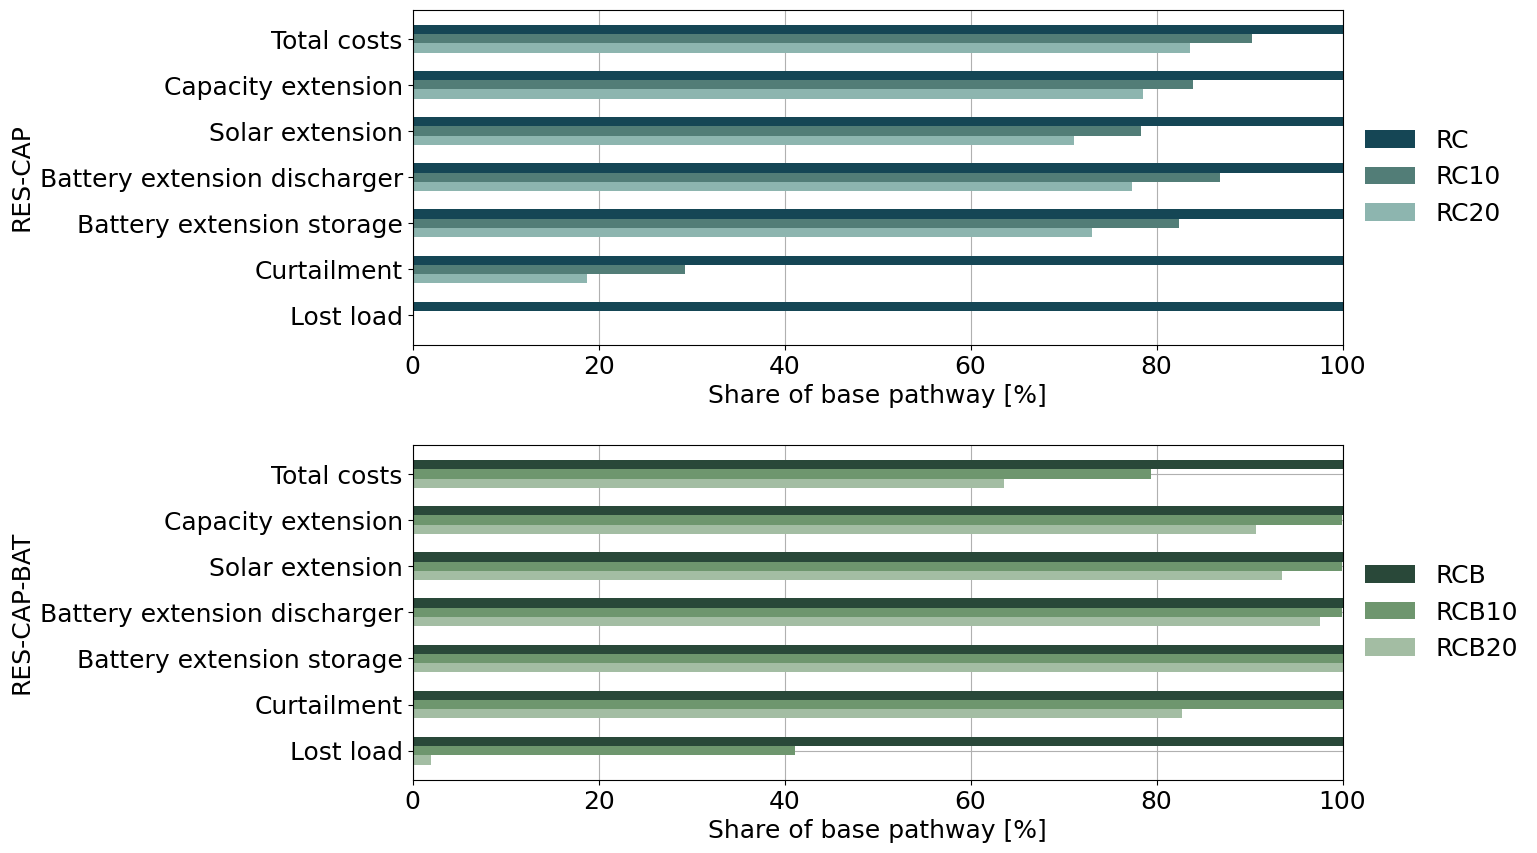

In [95]:
import matplotlib.pyplot as plt

# Assuming you have the values for E_comp as a pandas Series


# Set the width of each bar
bar_width = 0.2

categories = ['Lost load',
              'Curtailment',
              'Battery extension storage',
              'Battery extension discharger',
              'Solar extension',
              'Capacity extension',
              'Total costs'      
              ]

# Calculate the positions of the bars on the x-axis
bar_positions_0 = [0, 1, 2,3,4,5,6]
bar_positions_10 = [x - bar_width for x in bar_positions_0]
bar_positions_20 = [x - 2*bar_width for x in bar_positions_0]

# Create the bar plot
fig, axes = plt.subplots(2,1,figsize=(12,10),gridspec_kw={'hspace': 0.3})


axes[0].barh(bar_positions_0, [100, 100, 100,100,100,100,100],height=0.2,color=teal2,zorder = 2)
axes[0].barh(bar_positions_10,RC_ten.values*100, height=0.2,color=teal3,zorder = 2)
axes[0].barh(bar_positions_20,RC_twenty.values*100, height=0.2,color=teal4,zorder = 2)

axes[1].barh(bar_positions_0, [100, 100, 100,100,100,100,100],height=0.2,color=green1,zorder = 2)
axes[1].barh(bar_positions_10,RCB_ten.values*100, height=0.2,color=green2,zorder = 2)
axes[1].barh(bar_positions_20,RCB_twenty.values*100, height=0.2,color=green3,zorder = 2)

# Set the labels and title
#plt.xlabel('Categories')
axes[0].set_ylabel('RES-CAP')
axes[1].set_ylabel('RES-CAP-BAT')
#plt.title('Comparison of D and E_comp')
axes[0].set_xlim(0, 100)
axes[1].set_xlim(0, 100)

# Set the x-axis tick labels
#plt.xticks(bar_positions_D + [bar_width / 2] * len(bar_positions_D), categories)
axes[0].legend(labels=['RC','RC10','RC20'], frameon = False, loc='center left', bbox_to_anchor=(1, 0.5) )
axes[1].legend(labels=['RCB','RCB10','RCB20'], frameon = False, loc='center left', bbox_to_anchor=(1, 0.5) )
plt.grid(axis = 'y', zorder=0)
axes[0].set_yticks(ticks = bar_positions_10, labels = categories,rotation = 0)
axes[1].set_yticks(ticks = bar_positions_10, labels = categories,rotation = 0)
# Display the plot
axes[0].grid(axis='x')
axes[1].grid(axis='x')

axes[0].set_xlabel('Share of base pathway [%]')
axes[1].set_xlabel('Share of base pathway [%]')
plt.savefig(scen_path +f'sensitivity.pdf', dpi=300, bbox_inches='tight')



In [374]:
RC.global_constraints.constant

GlobalConstraint
CO2Limit    0.0
Name: constant, dtype: float64

## Capacity 2035

### Data

#### Baseline

In [5]:
caps_B = pd.Series(B.generators.p_nom_opt.head(17))
hydro_B = pd.Series(B.storage_units.p_nom_opt)

caps_B = pd.concat([caps_B, hydro_B])
caps_B=pd.DataFrame(caps_B)
#display(caps)
caps_B['Zone'] = caps_B.index.str.split().str[1]
caps_B['Carrier'] = caps_B.index.str.split().str[2]
#display(caps)

# Group the capacities by 'Zone' and 'Carrier' and sum them
grouped_B = caps_B.groupby(['Zone', 'Carrier'])['p_nom_opt'].sum().unstack()/1000


#### RES

In [393]:
caps_R = pd.Series(R.generators.p_nom_opt.head(17))
hydro_R = pd.Series(R.storage_units.p_nom_opt)

caps_R = pd.concat([caps_R, hydro_R])
caps_R=pd.DataFrame(caps_R)
#display(caps)
caps_R['Zone'] = caps_R.index.str.split().str[1]
caps_R['Carrier'] = caps_R.index.str.split().str[2]
#display(caps)

# Group the capacities by 'Zone' and 'Carrier' and sum them
grouped_R = caps_R.groupby(['Zone', 'Carrier'])['p_nom_opt'].sum().unstack()/1000

#### RES_CAP

In [438]:
caps_RC = pd.Series(RC.generators.p_nom_opt.head(17))
hydro_RC = pd.Series(RC.storage_units.p_nom_opt)

caps_RC = pd.concat([caps_RC, hydro_RC])
caps_RC=pd.DataFrame(caps_RC)
#display(caps)
caps_RC['Zone'] = caps_RC.index.str.split().str[1]
caps_RC['Carrier'] = caps_RC.index.str.split().str[2]
#display(caps)

# Group the capacities by 'Zone' and 'Carrier' and sum them
grouped_RC = caps_RC.groupby(['Zone', 'Carrier'])['p_nom_opt'].sum().unstack()/1000

#### RES_CAP_BAT

In [439]:
caps_RCB = pd.Series(RCB.generators.p_nom_opt.head(17))
hydro_RCB = pd.Series(RCB.storage_units.p_nom_opt)

caps_RCB = pd.concat([caps_RCB, hydro_RCB])
caps_RCB=pd.DataFrame(caps_RCB)
#display(caps)
caps_RCB['Zone'] = caps_RCB.index.str.split().str[1]
caps_RCB['Carrier'] = caps_RCB.index.str.split().str[2]
#display(caps)

# Group the capacities by 'Zone' and 'Carrier' and sum them
grouped_RCB = caps_RCB.groupby(['Zone', 'Carrier'])['p_nom_opt'].sum().unstack()/1000

### Capacity per carrier

NameError: name 'grouped_R' is not defined

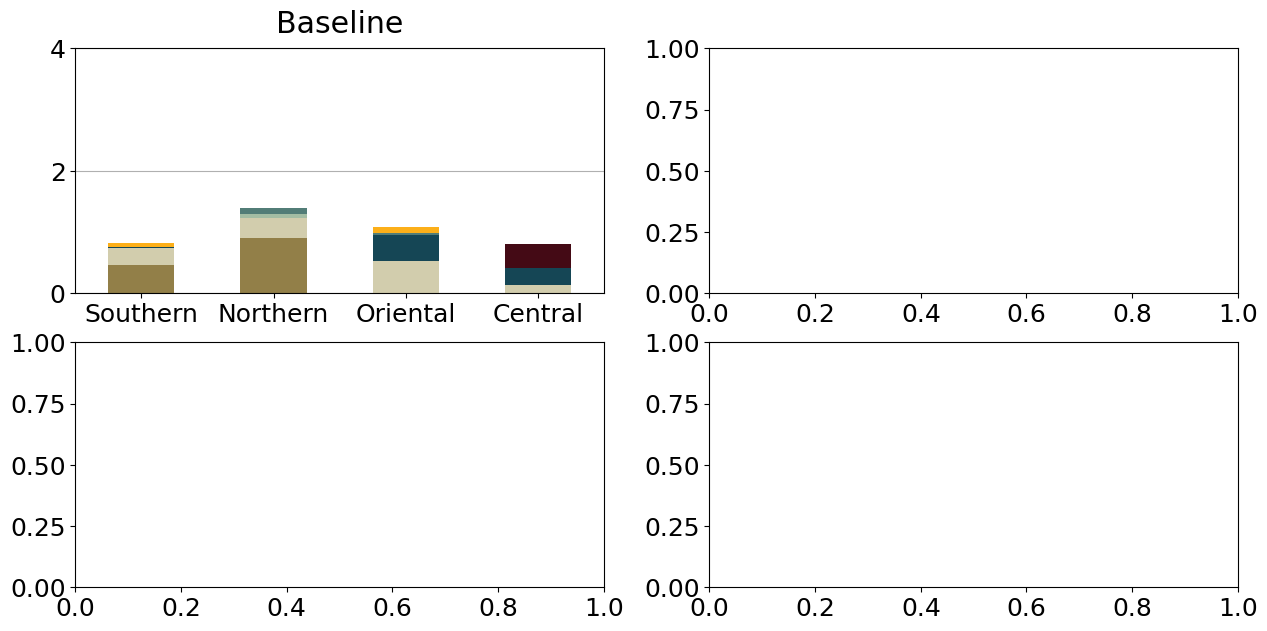

In [10]:


fig, axes = plt.subplots(2, 2, figsize=(20, 5), sharex=False, sharey=False)
# Create a stacked bar plot
bar1 = grouped_B.plot.bar(ax=axes[0,0] ,stacked=True, color=carrier_colors, figsize=(15, 7),zorder=2) #
axes[0,0].grid(axis = 'y',zorder = 0)
axes[0, 0].legend().remove()
axes[0, 0].set_title('Baseline',y=1.03)
axes[0, 0].set_xticklabels(['Southern', 'Northern', 'Oriental', 'Central'],rotation=0)
axes[0, 0].set_yticks(np.arange(0, 10, 2))
axes[0,0].set_ylim(0,4)
axes[0, 0].set_xlabel('')

grouped_R.plot.bar(ax=axes[0,1] ,stacked=True, color=carrier_colors, figsize=(15, 7),zorder=2) #
axes[0,1].grid(axis = 'y',zorder = 0)
axes[0, 1].legend().remove()
axes[0, 1].set_title('RES',y=1.03)
axes[0, 1].set_xticklabels(['Southern', 'Northern', 'Oriental', 'Central'],rotation=0)
axes[0, 1].set_yticks(np.arange(0, 10, 2))
axes[0,1].set_ylim(0,4)
axes[0, 1].set_xlabel('')

grouped_RC.plot.bar(ax=axes[1,0] ,stacked=True, color=carrier_colors, figsize=(15, 7),zorder=2) #
axes[1,0].grid(axis = 'y',zorder = 0)
axes[1, 0].legend().remove()
axes[1, 0].set_title('RES_CAP',y=1.03)
axes[1, 0].set_yticks(np.arange(0, 10, 2))
axes[1,0].set_ylim(0,9)
axes[1, 0].set_xticklabels(['Southern', 'Northern', 'Oriental', 'Central'],rotation=0)
axes[1, 0].set_xlabel('')

grouped_RCB.plot.bar(ax=axes[1,1] ,stacked=True, color=carrier_colors, figsize=(15, 7),zorder=2) #
axes[1,1].grid(axis = 'y',zorder = 0)
axes[1, 1].legend().remove()
axes[1, 1].set_title('RES_CAP_BAT',y=1.03)
axes[1, 1].set_yticks(np.arange(0, 10, 2))
axes[1,1].set_ylim(0,9)
axes[1, 1].set_xticklabels(['Southern', 'Northern', 'Oriental', 'Central'],rotation=0)
axes[1, 1].set_xlabel('')

# Get the legend from any one of the subplots
handles, labels = bar1.get_legend_handles_labels()

# Create a common legend
fig.legend(handles, labels_custom, loc='center left', bbox_to_anchor=(0.91, 0.5), frameon=False) #, frameon=False

plt.subplots_adjust(hspace=0.5, wspace=0.1)

# Set the common x-axis label
fig.text(0.075, 0.5,'Installed generation capacity in 2035 [GW]', va='center', rotation='vertical', fontsize=20)
plt.savefig(scen_path + 'Capacity/2035/' +f'Scen_capacity_carrier_{year}{direct}.pdf', dpi=300, bbox_inches='tight')
#plt.savefig(scen_path + 'Capacity/2035/' +f'{scen}_capacity_carrier_{year}{direct}.png', dpi=300, bbox_inches='tight')


### capacity Change per zone

In [ ]:
#path = data_path + f'{scen}_2021.nc'
path = data_path_R + f'RES_2021.nc'
start = pypsa.Network(path)

caps_2021 = pd.Series(start.generators.p_nom.head(17))
hydro_2021 = pd.Series(start.storage_units.p_nom)

caps_2021 = pd.concat([caps_2021, hydro_2021])
caps_2021=pd.DataFrame(caps_2021)
#display(caps)
caps_2021['Zone'] = caps_2021.index.str.split().str[1]
caps_2021['Carrier'] = caps_2021.index.str.split().str[2]
#display(caps)
difference = caps
difference['p_nom_opt'] = difference['p_nom_opt'] - caps_2021['p_nom']

# Group the capacities by 'Zone' and 'Carrier' and sum them
grouped = difference.groupby(['Zone', 'Carrier'])['p_nom_opt'].sum().unstack()

# Create a stacked bar plot
grouped.plot.bar(stacked=True, figsize=(10, 6),color=carrier_colors,zorder=2)

# Add labels and title
plt.ylabel('Installed generation capacity in 2035 [Mw]')
plt.ylim(0,8000)
plt.xlabel('')
plt.xticks(range(len(zones)), zones, rotation=0)
plt.grid(axis = 'y',zorder = 0)
plt.legend( loc="center right", bbox_to_anchor=(1.3, 0.5))

plt.savefig(scen_path +f'{scen}_capacity_carrier_difference{direct}.pdf', dpi=300, bbox_inches='tight')

## Other indicators

### Total emisions

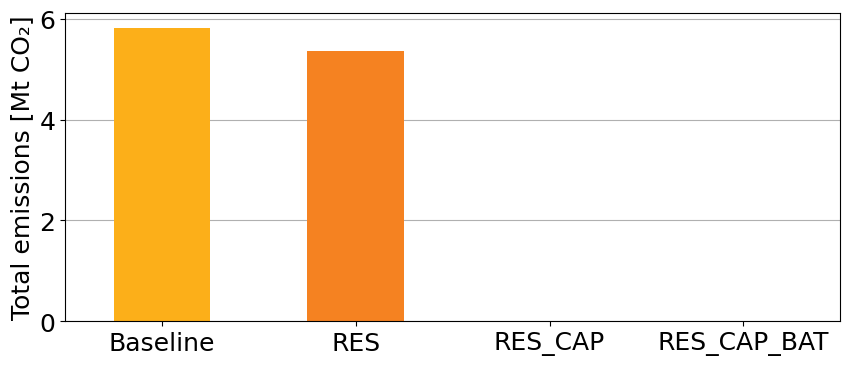

In [390]:
data = [5.815237321010919,5.367624859307271,0,0]
index = scen_list

tot_emissions = pd.Series(data,index, name='Total Emissions')


tot_emissions.plot.bar(color=scen_colors, figsize = (10,4), zorder = 2)
plt.ylabel('Total emissions [Mt CO\u2082]')
plt.xticks(rotation = 0)
plt.grid(axis = 'y',zorder = 0)

plt.savefig(scen_path +f'Scen_total_emissions.pdf', dpi=300, bbox_inches='tight')

### Average Marginal Costs 2035

In [109]:
mc_RCB = {'CCGT': 0.0,
 'OCGT': 0.0,
 'oil': 0.0,
 'solar': 0.01028800072913302,
 'onwind': 0.006525627846860697,
 'biomass': 0.12404550199224838,
 'hydro': 0.0019382126816348654}


mc_RC = {'CCGT': 0.0,
 'OCGT': 0.0,
 'oil': 0.0,
 'solar': 0.01666109059402763,
 'onwind': 0.00021499837812584044,
 'biomass': 0.14549196200504785,
 'hydro': 0.001967192551760239}


mc_R = {'CCGT': 6.061980448412363,
 'OCGT': 3.6346973249416927,
 'oil': 0.028847363049338232,
 'solar': 0.0014943011382377023,
 'onwind': 0.0002258799643597917,
 'biomass': 0.053471617523539725,
 'hydro': 0.0019285489936718247}


mc_B ={'CCGT': 6.061968018964419,
 'OCGT': 4.2130181495291295,
 'oil': 0.39665356099862104,
 'solar': 0.00035943404475885987,
 'onwind': 0.0002258773091938337,
 'biomass': 0.05347119850293901,
 'hydro': 0.0019285472884685725} 

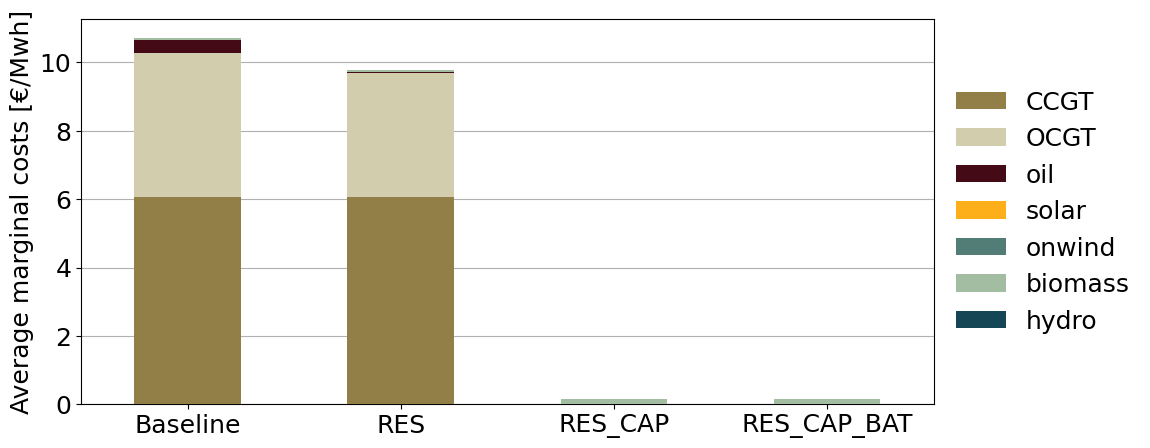

In [122]:
data_mc_B_R = [pd.Series(mc_B),pd.Series(mc_R),pd.Series(mc_RC),pd.Series(mc_RCB)]
data_mc = pd.DataFrame(data_mc_B_R)
#data = [10.727072707029963, 9.782645484023202,0.16463891951129514,0.14302739008640422]
index = scen_list

#avg_mc = pd.Series(data_mc,index, name='Average marginal costs')


data_mc.plot.bar(stacked = True, color=carrier_colors, figsize = (11,5), zorder = 3)
plt.ylabel('Average marginal costs [€/Mwh]')
plt.xticks(ticks = [0,1,2,3], labels = ['Baseline','RES','RES_CAP','RES_CAP_BAT'],rotation = 0)
plt.grid(axis = 'y',zorder = 0)
plt.legend( loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)

plt.savefig(scen_path +f'all_avg_mc_2035.png', dpi=300, bbox_inches='tight')


<Figure size 1920x1440 with 0 Axes>

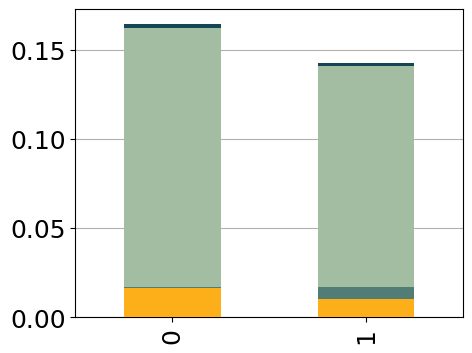

In [124]:
data_mc_RC_RCB = [pd.Series(mc_RC),pd.Series(mc_RCB)]
data_mc = pd.DataFrame(data_mc_RC_RCB)
data_mc_2035 = [10.727072707029963, 9.782645484023202,0.16463891951129514,0.14302739008640422] #no subs: B: 40.10, R: 36.57
index = scen_list

avg_mc = pd.Series(data_mc_2035,index, name='Average marginal costs')

plt.figure(dpi=300)
data_mc.plot.bar(stacked = True, color=carrier_colors, figsize = (5,4), zorder = 3)
#plt.ylabel('Average marginal costs [€/Mwh]')
#plt.xticks(ticks = [0,1], labels = ['RES_CAP','RES_CAP_BAT'],rotation = 0)
plt.grid(axis = 'y',zorder = 0)
#plt.legend( loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)
legend = plt.legend()

# Remove the legend
legend.remove()



plt.savefig(scen_path +f'RC_RCB_avg_mc_2035.png', dpi=300, bbox_inches='tight')

### mc and obj_value


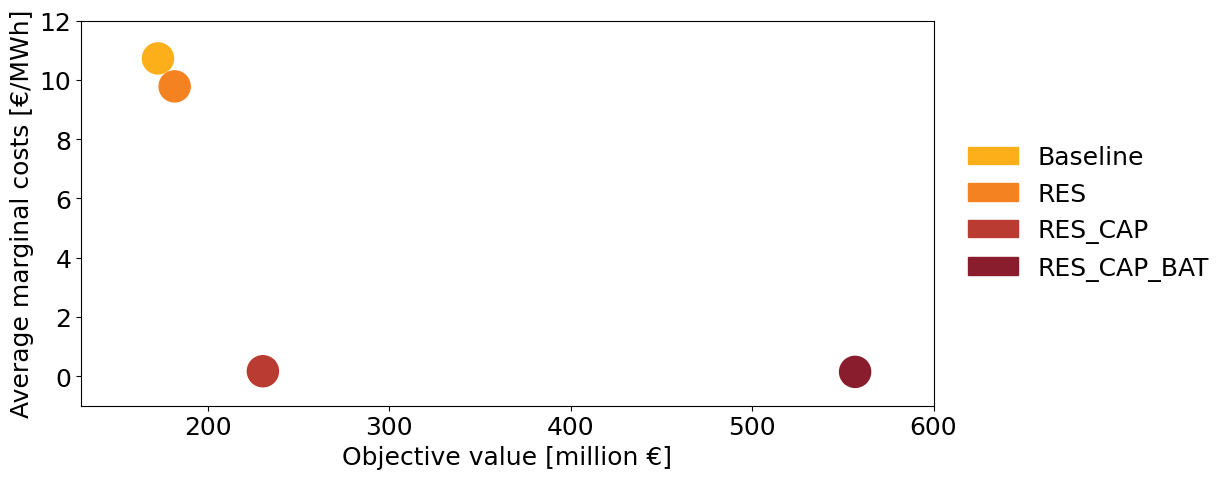

In [446]:
obj_value = [172428608.00084618/1000000,181609384.09763798/1000000,230275280.584265/1000000,556762408.5880082/1000000]

plt.figure(figsize = (11,5))
plt.scatter(obj_value, avg_mc, c=scen_colors, s=500)

plt.xlim(130,600)
plt.ylim(-1,12)
plt.ylabel('Average marginal costs [€/MWh]')
plt.xlabel('Objective value [million €]')

# Legend
Baseline = mpatches.Patch(color = yellow, label = 'Baseline')
RES = mpatches.Patch(color = orange, label = 'RES')
RES_CAP = mpatches.Patch(color = red2, label = 'RES_CAP')
RES_CAP_BAT = mpatches.Patch(color = red1, label = 'RES_CAP_BAT')

handles=[Baseline,RES,RES_CAP,RES_CAP_BAT] 
plt.legend(handles=handles, loc="center right", bbox_to_anchor=(1.35, 0.5),frameon = False)

plt.savefig(scen_path +f'Scen_mc_obj_scatter.pdf', dpi=300, bbox_inches='tight')

## Generation

In [87]:
first_date = "2013-01-01"
second_date = "2014-01-01"


Onwind_B = B.generators_t.p.loc[first_date:second_date].groupby(B.generators.carrier, axis=1).sum()["onwind"]
Onwind_RCB = RCB.generators_t.p.loc[first_date:second_date].groupby(RCB.generators.carrier, axis=1).sum()["onwind"]
Onwind_R = R.generators_t.p.loc[first_date:second_date].groupby(R.generators.carrier, axis=1).sum()["onwind"]
Onwind_RC = RC.generators_t.p.loc[first_date:second_date].groupby(RC.generators.carrier, axis=1).sum()["onwind"]


solar_B = B.generators_t.p.loc[first_date:second_date].groupby(B.generators.carrier, axis=1).sum()["solar"]
solar_RCB = RCB.generators_t.p.loc[first_date:second_date].groupby(RCB.generators.carrier, axis=1).sum()["solar"]
solar_R = R.generators_t.p.loc[first_date:second_date].groupby(R.generators.carrier, axis=1).sum()["solar"]
solar_RC = RC.generators_t.p.loc[first_date:second_date].groupby(RC.generators.carrier, axis=1).sum()["solar"]



biomass_B = B.generators_t.p.loc[first_date:second_date].groupby(B.generators.carrier, axis=1).sum()["biomass"]
biomass_RCB = RCB.generators_t.p.loc[first_date:second_date].groupby(RCB.generators.carrier, axis=1).sum()["biomass"]
biomass_R = R.generators_t.p.loc[first_date:second_date].groupby(R.generators.carrier, axis=1).sum()["biomass"]
biomass_RC = RC.generators_t.p.loc[first_date:second_date].groupby(RC.generators.carrier, axis=1).sum()["biomass"]



battery_B = B.stores_t.p.loc[first_date:second_date].groupby(B.stores.carrier, axis=1).sum()["battery"]
battery_RCB = RCB.stores_t.p.loc[first_date:second_date].groupby(RCB.stores.carrier, axis=1).sum()["battery"]
battery_R = R.stores_t.p.loc[first_date:second_date].groupby(R.stores.carrier, axis=1).sum()["battery"]
battery_RC = RC.stores_t.p.loc[first_date:second_date].groupby(RC.stores.carrier, axis=1).sum()["battery"]

p_bat = ['Bp','BCp','Rp','RCp']
n_bat = ['Bn','BCn','Rn','RCn']
batteries = [battery_B,battery_RCB,battery_R,battery_RC]

for list_p,list_n,battery in zip(p_bat,n_bat,batteries):
    i=0
    list_p = []
    list_n = []
    
    for i in battery:
        if i < 0:
            list_p.append(i)
        else:
            list_n.append(0) 
    for i in battery:
        if i > 0:
            list_p.append(i)
        else:
            list_n.append(0) 

Hydro_B = B.storage_units_t.p_dispatch[first_date:second_date].sum(axis=1)
Hydro_RCB = RCB.storage_units_t.p_dispatch[first_date:second_date].sum(axis=1)
Hydro_R = R.storage_units_t.p_dispatch[first_date:second_date].sum(axis=1)
Hydro_RC = RC.storage_units_t.p_dispatch[first_date:second_date].sum(axis=1)

demand_B = B.loads_t.p_set.loc[first_date:second_date].sum(axis=1)*-1
demand_RCB = RCB.loads_t.p_set.loc[first_date:second_date].sum(axis=1)*-1
demand_R = R.loads_t.p_set.loc[first_date:second_date].sum(axis=1)*-1
demand_RC = RC.loads_t.p_set.loc[first_date:second_date].sum(axis=1)*-1



demand = demand_RCB.sum()*-1

In [126]:
p_bat = ['Bp', 'BCp', 'Rp', 'RCp']
n_bat = ['Bn', 'BCn', 'Rn', 'RCn']
batteries = [battery_B, battery_RCB, battery_R, battery_RC]

# Create empty lists to store the values
result_p = []
result_n = []

for battery, list_p, list_n in zip(batteries, p_bat, n_bat):
    temp_p = []
    temp_n = []
    i=0
    
    for i in battery:
        if i < 0:
            temp_p.append(i)
        else:
            temp_n.append(0)
    
    for i in battery:
        if i > 0:
            temp_p.append(i)
        else:
            temp_n.append(0)
    
    # Assign the temporary lists to the original lists
    globals()[list_p] = temp_p
    globals()[list_n] = temp_n
    
    # Append the values to the result lists
    result_p.extend(temp_p)
    result_n.extend(temp_n)

### RES Share

In [132]:
data = {
    'Scenario': scen_list,
    'biomass': [biomass_B.sum()/demand,  biomass_R.sum()/demand,biomass_RC.sum()/demand, biomass_RCB.sum()/demand],
    'hydro': [Hydro_B.sum()/demand, Hydro_R.sum()/demand,Hydro_RC.sum()/demand, Hydro_RCB.sum()/demand],
    'onwind': [Onwind_B.sum()/demand,  Onwind_R.sum()/demand, Onwind_RC.sum()/demand,Onwind_RCB.sum()/demand],
    'solar': [solar_B.sum()/demand,  solar_R.sum()/demand, solar_RC.sum()/demand, solar_RCB.sum()/demand]}

df = pd.DataFrame(data)
df = df.set_index('Scenario')

df = df*100
df.sum(axis=1)

Scenario
Baseline        24.419746
RES             29.906505
RES_CAP        108.187890
RES_CAP_BAT     99.892293
dtype: float64

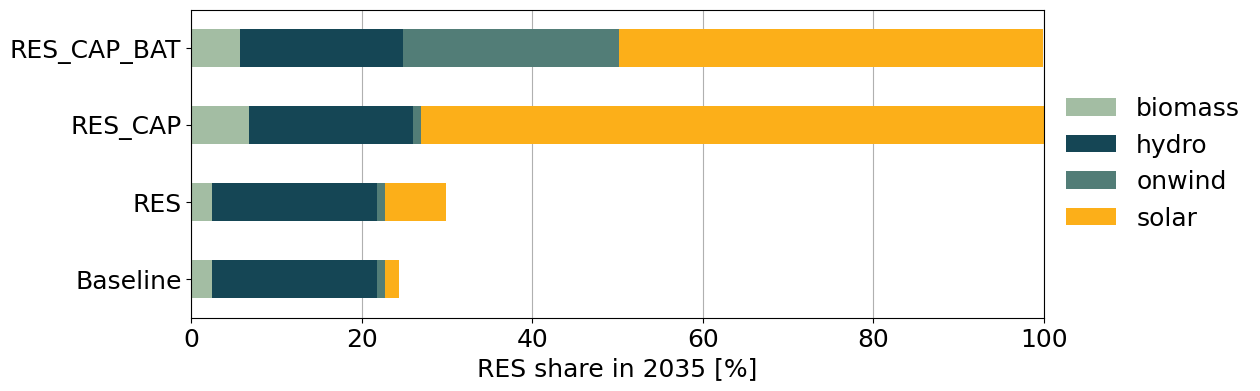

In [450]:

df.plot.barh(stacked=True,color=carrier_colors, figsize = (11,4), zorder = 2)
#plt.ylabel('RES capacity in 2035 [MW]')
plt.xticks(rotation = 0)
plt.xlim(0,100)
plt.grid(axis = 'x',zorder = 0)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),frameon = False)
plt.xlabel('RES share in 2035 [%]')
plt.ylabel('')

plt.savefig(scen_path +f'Generation/Scen_RES_share.pdf', dpi=300, bbox_inches='tight')

### RES share & Objective value

### Curtailment

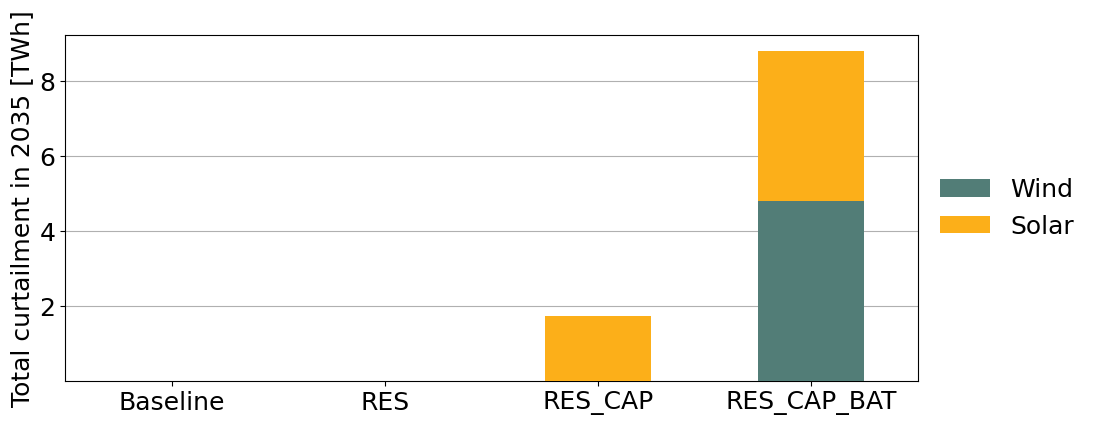

In [209]:
wind_curt = [5.481894449686589,2.489460212999867,7089.821510601944,4792869.986187305]
solar_curt = [5.169537726701227,1.9618266003156104,1734311.3859554306,4004166.703007248]
e_curt = 8206989

data_curt = {'Wind': wind_curt, 'Solar': solar_curt}
curtailment_dif= pd.DataFrame(data_curt,index = scen_list)


data = [10.651432176387814, 4.451286813315477,1741401.2074660326,8797036.689194554]
index = scen_list

curtailment = pd.Series(data,index, name='Total curtailment in 2035 [MWh]')


(curtailment_dif/1000000).plot.bar(stacked = True, color=[teal3,yellow], figsize = (11,4.5), zorder = 3)
plt.ylabel('Total curtailment in 2035 [TWh]')
plt.xticks(rotation = 0)
plt.grid(axis = 'y',zorder = 0)
plt.legend( loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)

plt.savefig(scen_path +f'Scen_curtailment.pdf', dpi=300, bbox_inches='tight')

## Lost load

In [149]:
demand = RCB.loads_t.p_set.sum(axis=1).sum() # MWh
demand

16608999.981928658

In [150]:
battery_B = B.stores_t.p.groupby(B.stores.carrier, axis=1).sum()["battery"]
battery_R = R.stores_t.p.groupby(R.stores.carrier, axis=1).sum()["battery"]
battery_RC = RC.stores_t.p.groupby(RC.stores.carrier, axis=1).sum()["battery"]
battery_RCB = RCB.stores_t.p.groupby(RCB.stores.carrier, axis=1).sum()["battery"]
battery_E = E.stores_t.p.groupby(E.stores.carrier, axis=1).sum()["battery"]

In [151]:
i=0
nbattery = []
pbattery =[]
for i in battery_E:
    if i < 0:
        nbattery.append(i)
    else:
        nbattery.append(0) 
for i in battery_E:
    if i > 0:
        pbattery.append(i)
    else:
        pbattery.append(0) 


battery_series_p = pd.Series(nbattery)
battery_series_n = pd.Series(pbattery)

In [152]:
battery_loss = (((battery_series_n.sum())/0.9)/0.9) - battery_series_n.sum()
battery_loss

518559.52950920304

In [155]:
hydro = R.storage_units_t.p.sum().sum()
generation = R.generators_t.p.sum().head(19).sum() + hydro

ll_B = 17084819.708834108 - battery_loss - demand
ll_B

-42739.80260375328

In [74]:
hydro = B.storage_units_t.p.sum().sum()
generation = B.generators_t.p.sum().head(17).sum() + hydro

ll_B = generation  - demand
ll_B/demand*100

-0.005208793784979322

In [123]:
ll_B

-532618.504996812

In [133]:
R.generators.columns

Index(['p_nom_max', 'weight', 'p_nom', 'capital_cost', 'efficiency',
       'p_nom_min', 'marginal_cost', 'carrier', 'p_nom_extendable', 'bus',
       'control', 'p_nom_opt', 'p_max_pu', 'sign', 'build_year', 'min_up_time',
       'min_down_time', 'up_time_before', 'down_time_before', 'type',
       'p_min_pu', 'p_set', 'q_set', 'lifetime', 'committable',
       'start_up_cost', 'shut_down_cost', 'ramp_limit_up', 'ramp_limit_down',
       'ramp_limit_start_up', 'ramp_limit_shut_down'],
      dtype='object')

# Storage

## Charging & Discharging timeline

In [147]:
first_date = "2013-01-01"
second_date = "2013-01-30"

battery_B = B.stores_t.p.loc[first_date:second_date].groupby(B.stores.carrier, axis=1).sum()["battery"]
battery_R = NS.stores_t.p.loc[first_date:second_date].groupby(NS.stores.carrier, axis=1).sum()["battery"]
battery_RC = RC.stores_t.p.loc[first_date:second_date].groupby(RC.stores.carrier, axis=1).sum()["battery"]
battery_RCB = RCB.stores_t.p.loc[first_date:second_date].groupby(RCB.stores.carrier, axis=1).sum()["battery"]


In [148]:
i=0
nbattery = []
pbattery =[]
for i in battery_RCB:
    if i < 0:
        nbattery.append(i)
    else:
        nbattery.append(0) 
for i in battery_RCB:
    if i > 0:
        pbattery.append(i)
    else:
        pbattery.append(0) 


RCBn_series = pd.Series(nbattery)
RCBp_series = pd.Series(pbattery)


In [147]:
RCB.generators_t.p_max_pu['BO 0 onwind']

snapshot
2013-01-01 00:00:00    0.200593
2013-01-01 01:00:00    0.192611
2013-01-01 02:00:00    0.168605
2013-01-01 03:00:00    0.138830
2013-01-01 04:00:00    0.109454
                         ...   
2013-12-31 19:00:00    0.041177
2013-12-31 20:00:00    0.066291
2013-12-31 21:00:00    0.090526
2013-12-31 22:00:00    0.109788
2013-12-31 23:00:00    0.083406
Name: BO 0 onwind, Length: 8760, dtype: float64

In [150]:
wind_0 = RCB.generators_t.p_max_pu['BO 0 onwind'].iloc[:8760]
wind_1 = RCB.generators_t.p_max_pu['BO 1 onwind'].iloc[:8760]
wind_2 = RCB.generators_t.p_max_pu['BO 2 onwind'].iloc[:8760]
wind_3 = RCB.generators_t.p_max_pu['BO 3 onwind'].iloc[:8760]
wind = (wind_0+wind_1+wind_2+wind_3)/4

solar_0 = RCB.generators_t.p_max_pu['BO 0 solar'].iloc[:600]
solar_1 = RCB.generators_t.p_max_pu['BO 1 solar'].iloc[:600]
solar_2 = RCB.generators_t.p_max_pu['BO 2 solar'].iloc[:600]
solar_3 = RCB.generators_t.p_max_pu['BO 3 solar'].iloc[:600]
solar = (solar_0+solar_1+solar_2+solar_3)/4

wind = pd.Series(wind.values,index=np.arange(0,8760))
solar = pd.Series(solar.values,index=np.arange(0,600))
wind.describe()

count    8760.000000
mean        0.093536
std         0.087202
min         0.000000
25%         0.033480
50%         0.066475
75%         0.126060
max         0.621791
dtype: float64

In [155]:
total_costs_RC.sum()['total_costs']/total_costs_B.sum()['total_costs']

3.0229128404143926

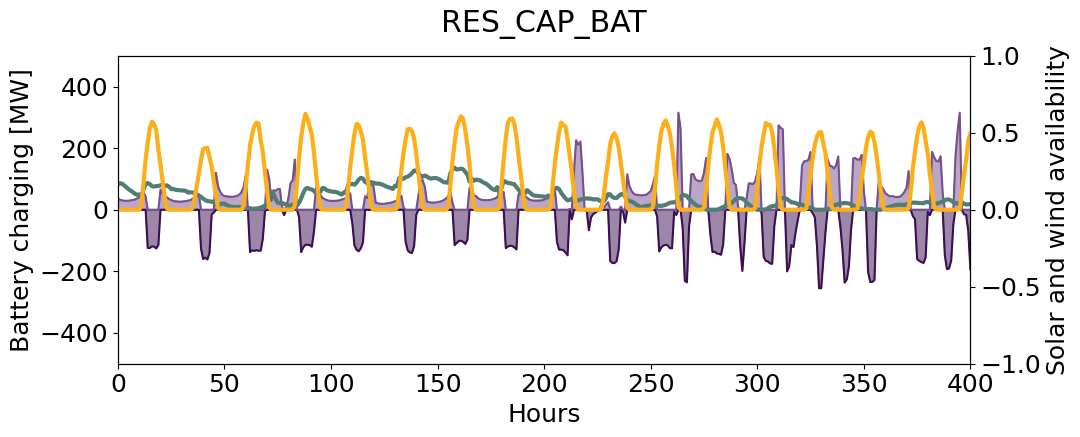

In [152]:
fig, ax1 = plt.subplots(figsize = (11,4))


ax1.fill_between(RCBn_series.index, RCBn_series, color=purple1, alpha=0.5)
ax1.fill_between(RCBp_series.index, RCBp_series, color=purple2, alpha=0.5)

# Plot the lines

RCBn_series.plot(ax=ax1,color = purple1)
RCBp_series.plot(ax=ax1,color = purple2)
ax1.set_ylabel('Battery charging [MW]')
ax1.set_ylim(-500,500)
ax1.set_xlabel('Hours')
ax1.set_title('RES_CAP_BAT', y = 1.05)

ax2 = ax1.twinx()

(wind).plot(ax=ax2,color=teal3,linewidth=3)
(solar).plot(ax=ax2,color=yellow,linewidth=3)
ax2.set_ylabel('Solar and wind availability')
ax2.set_ylim(-1,1)
plt.xlim(0,400)
ax2.set_xlabel('Hours')


plt.savefig(scen_path +f'RCB_battery_charging_long.pdf', dpi=300, bbox_inches='tight')

In [153]:
i=0
nbattery = []
pbattery =[]
for i in battery_RC:
    if i < 0:
        nbattery.append(i)
    else:
        nbattery.append(0) 
for i in battery_RC:
    if i > 0:
        pbattery.append(i)
    else:
        pbattery.append(0) 


RCn_series = pd.Series(nbattery)
RCp_series = pd.Series(pbattery)

In [154]:
wind_0 = RC.generators_t.p_max_pu['BO 0 onwind'].iloc[:600]
wind_1 = RC.generators_t.p_max_pu['BO 1 onwind'].iloc[:600]
wind_2 = RC.generators_t.p_max_pu['BO 2 onwind'].iloc[:600]
wind_3 = RC.generators_t.p_max_pu['BO 3 onwind'].iloc[:600]
wind = (wind_0+wind_1+wind_2+wind_3)/4

wind

snapshot
2013-01-01 00:00:00    0.163868
2013-01-01 01:00:00    0.172657
2013-01-01 02:00:00    0.168457
2013-01-01 03:00:00    0.157180
2013-01-01 04:00:00    0.145340
                         ...   
2013-01-25 19:00:00    0.150736
2013-01-25 20:00:00    0.137157
2013-01-25 21:00:00    0.109444
2013-01-25 22:00:00    0.112092
2013-01-25 23:00:00    0.105397
Length: 600, dtype: float64

In [155]:
solar_0 = RC.generators_t.p_max_pu['BO 0 solar'].iloc[:600]
solar_1 = RC.generators_t.p_max_pu['BO 1 solar'].iloc[:600]
solar_2 = RC.generators_t.p_max_pu['BO 2 solar'].iloc[:600]
solar_3 = RC.generators_t.p_max_pu['BO 3 solar'].iloc[:600]
solar = (solar_0+solar_1+solar_2+solar_3)/4

solar

snapshot
2013-01-01 00:00:00    0.000000
2013-01-01 01:00:00    0.000000
2013-01-01 02:00:00    0.000000
2013-01-01 03:00:00    0.000000
2013-01-01 04:00:00    0.000000
                         ...   
2013-01-25 19:00:00    0.506932
2013-01-25 20:00:00    0.411191
2013-01-25 21:00:00    0.290716
2013-01-25 22:00:00    0.147289
2013-01-25 23:00:00    0.022914
Length: 600, dtype: float64

In [156]:
wind = pd.Series(wind.values,index=np.arange(0,600))
solar = pd.Series(solar.values,index=np.arange(0,600))
wind

0      0.163868
1      0.172657
2      0.168457
3      0.157180
4      0.145340
         ...   
595    0.150736
596    0.137157
597    0.109444
598    0.112092
599    0.105397
Length: 600, dtype: float64

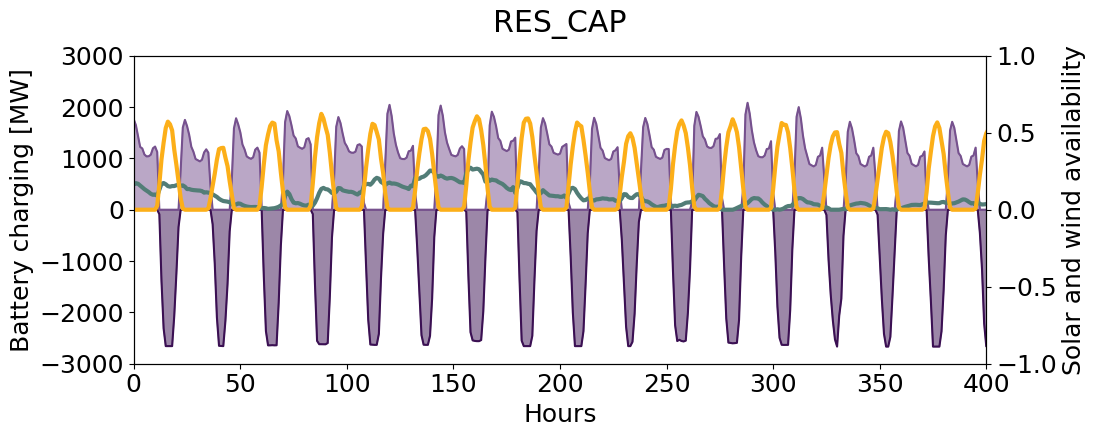

In [157]:
fig, ax1 = plt.subplots(figsize = (11,4))


ax1.fill_between(RCn_series.index, RCn_series, color=purple1, alpha=0.5)
ax1.fill_between(RCp_series.index, RCp_series, color=purple2, alpha=0.5)

# Plot the lines

RCn_series.plot(ax=ax1,color = purple1)
RCp_series.plot(ax=ax1,color = purple2)
ax1.set_ylabel('Battery charging [MW]')
ax1.set_ylim(-3000,3000)
ax1.set_xlabel('Hours')
ax1.set_title('RES_CAP', y = 1.05)

ax2 = ax1.twinx()

(wind).plot(ax=ax2,color=teal3,linewidth=3)
(solar).plot(ax=ax2,color=yellow,linewidth=3)
ax2.set_ylabel('Solar and wind availability')
ax2.set_ylim(-1,1)
plt.xlim(0,400)
ax2.set_xlabel('Hours')


plt.savefig(scen_path +f'RC_battery_charging_long.pdf', dpi=300, bbox_inches='tight')

# Dispatch Plots

## Baseline

CCGT  214613.7368336286
OCGT  27187.332657949773
Oil   983.8982744498612
Wind  1391.797899641136
Solar  4970.2150797896375
Biomass  11017.911114660954
Hydro 61290.5061775308
Demand  -322399.5746482449


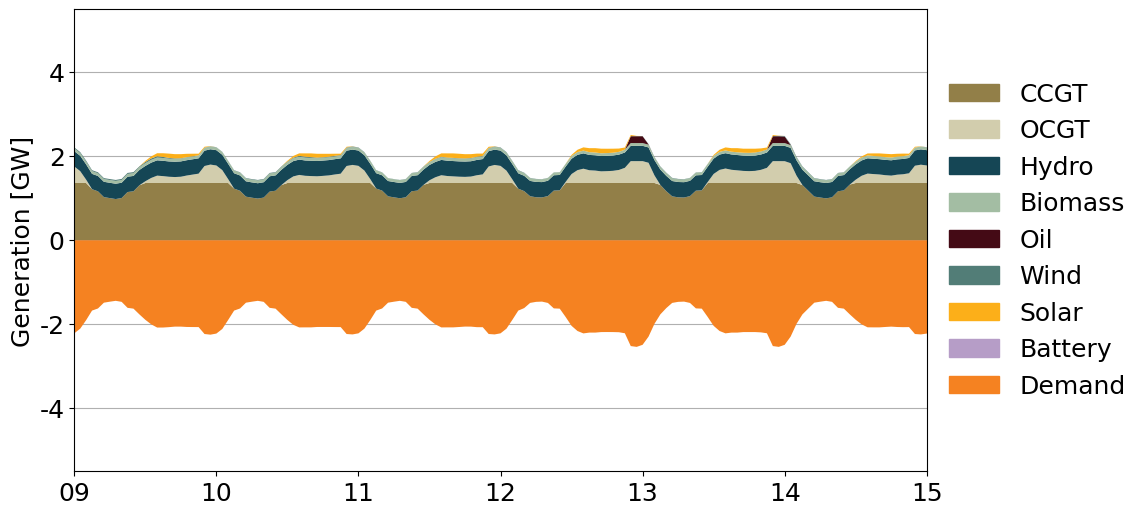

In [13]:
n = B

first_date = "2013-01-09"
second_date = "2013-01-15"
# first_date = "2013-01-01"
# second_date = "2014-01-01"


CCGT = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["CCGT"]
print('CCGT ',CCGT.sum())

OCGT = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["OCGT"]
print('OCGT ',OCGT.sum())

Oil = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["oil"]
print('Oil  ',Oil.sum())

Onwind = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["onwind"]
print('Wind ',Onwind.sum())

solar = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["solar"]
print('Solar ',solar.sum())

biomass = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["biomass"]
print('Biomass ',biomass.sum())


Hydro = n.storage_units_t.p_dispatch[first_date:second_date].sum(axis=1)
print('Hydro', Hydro.sum())


demand = n.loads_t.p_set.loc[first_date:second_date].sum(axis=1)*-1
print('Demand ',demand.sum())


fig, ax=plt.subplots(figsize = (11,6))

A = plt.stackplot(CCGT.index,CCGT,OCGT,Hydro,biomass,Oil,Onwind, solar, #,pbattery
                  colors=[beige1,beige3,teal2,green3,brown,teal3,yellow], zorder = 2) #,   purple3
plt.stackplot(CCGT.index,demand, colors=[orange,purple3], zorder = 2) #,nbattery
plt.xticks(rotation = 0)
plt.yticks()
scale_y = 1e3
ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_y))
ax.yaxis.set_major_formatter(ticks_y)
myFmt = mdates.DateFormatter('%d')
ax.xaxis.set_major_formatter(myFmt)
#ax.set_xticks(np.arange(0,200))
ax.set_ylabel('Generation [GW]')
start_date = "2013-01-09"
end_date = "2013-01-15"

start_date = pd.to_datetime(start_date)
end_date = pd.to_datetime(end_date)

ax.set_xlim(start_date, end_date)
ax.set_ylim(-5500, 5500)
#ax.set_title(scen,y = 1.03)

CCGT_patch = mpatches.Patch(color=beige1, label ='CCGT')
OCGT_patch = mpatches.Patch(color=beige3, label ='OCGT')
wind_patch = mpatches.Patch(color=teal3, label ='Wind')
solar_patch = mpatches.Patch(color=yellow, label ='Solar')
#ror_patch = mpatches.Patch(color='blue', label ='ROR')
battery_patch = mpatches.Patch(color=purple3, label ='Battery')
load_patch = mpatches.Patch(color=orange, label ='Demand')
hydro_patch = mpatches.Patch(color = teal2, label = 'Hydro')
biomass_patch = mpatches.Patch(color = green3, label = 'Biomass')
oil_patch = mpatches.Patch(color = brown, label = 'Oil')
handles=[CCGT_patch,OCGT_patch,hydro_patch,biomass_patch,oil_patch,wind_patch, solar_patch,battery_patch, load_patch] #battery_patch,
ax.legend(handles=handles, frameon = False, loc='center left', bbox_to_anchor=(1, 0.5))
ax.grid(axis='y', zorder=0)
plt.savefig(scen_path +f'Generation/B_new_dispatch.pdf', dpi=300, bbox_inches='tight')
plt.savefig(scen_path +f'Generation/B_new_dispatch.png', dpi=300, bbox_inches='tight')




## NS

CCGT  117898.35936778488
OCGT  8203.094056072927
Oil   1433.2140058854952
Wind  3393.377446051408
Solar  8479.123744317769
Biomass  18093.196376400567
Geothermal  8399.999690685861
Hydro 61076.39889124478
ROR  95255.99930558416
Demand  -322399.57444816665


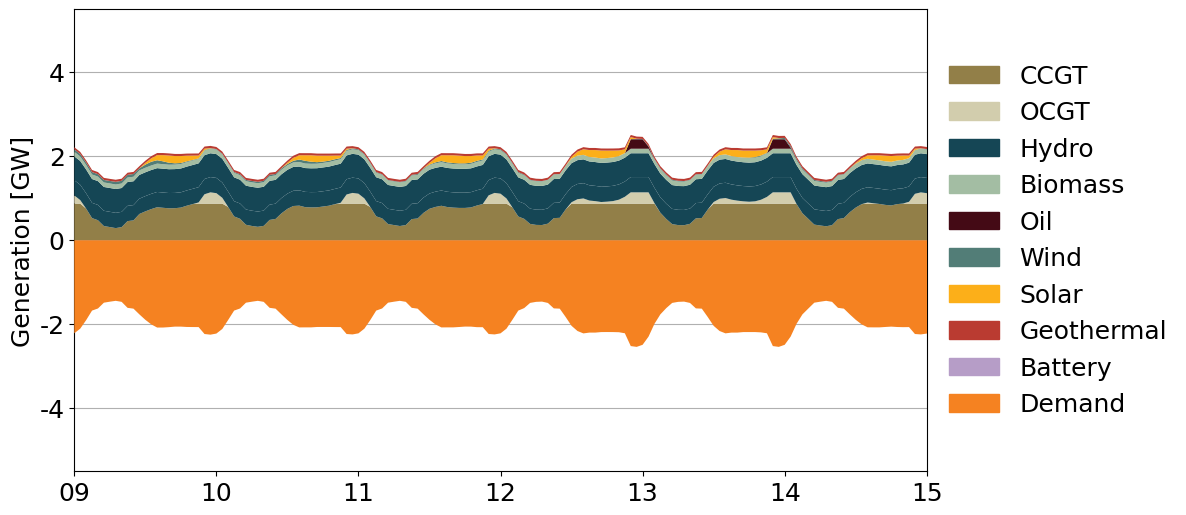

In [144]:
n = NS

first_date = "2013-01-09"
second_date = "2013-01-15"
# first_date = "2013-01-01"
# second_date = "2014-01-01"


CCGT = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["CCGT"]
print('CCGT ',CCGT.sum())

OCGT = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["OCGT"]
print('OCGT ',OCGT.sum())

Oil = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["oil"]
print('Oil  ',Oil.sum())

Onwind = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["onwind"]
print('Wind ',Onwind.sum())

solar = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["solar"]
print('Solar ',solar.sum())

biomass = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["biomass"]
print('Biomass ',biomass.sum())

geothermal = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["geothermal"]
print('Geothermal ',geothermal.sum())

#H2 = n.stores_t.p.loc[first_date:second_date].groupby(n.stores.carrier, axis=1).sum()["H2"]
#print('H2 ', H2.sum())

# battery = n.stores_t.p.loc[first_date:second_date].groupby(n.stores.carrier, axis=1).sum()["battery"]
# print('Battery', battery.sum())

Hydro = n.storage_units_t.p_dispatch[first_date:second_date].sum(axis=1)
print('Hydro', Hydro.sum())

ror = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["ror"]
print('ROR ',ror.sum())

demand = n.loads_t.p_set.loc[first_date:second_date].sum(axis=1)*-1
print('Demand ',demand.sum())


fig, ax=plt.subplots(figsize = (11,6))


A = plt.stackplot(CCGT.index,CCGT,OCGT,Hydro,ror,biomass,Oil,Onwind, solar,geothermal, #,pbattery
                  colors=[beige1,beige3,teal2,teal2,green3,brown,teal3,yellow,red2], zorder = 3) #,   purple3
plt.stackplot(CCGT.index,demand, colors=[orange,purple3], zorder = 3) #,nbattery
plt.xticks(rotation = 0)
plt.yticks()
scale_y = 1e3
ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_y))
ax.yaxis.set_major_formatter(ticks_y)
myFmt = mdates.DateFormatter('%d')
ax.xaxis.set_major_formatter(myFmt)
#ax.set_xticks(np.arange(0,200))
ax.set_ylabel('Generation [GW]')
start_date = "2013-01-09"
end_date = "2013-01-15"

start_date = pd.to_datetime(start_date)
end_date = pd.to_datetime(end_date)

ax.set_xlim(start_date, end_date)
ax.set_ylim(-5500, 5500)
#ax.set_title(scen,y = 1.03)

CCGT_patch = mpatches.Patch(color=beige1, label ='CCGT')
OCGT_patch = mpatches.Patch(color=beige3, label ='OCGT')
wind_patch = mpatches.Patch(color=teal3, label ='Wind')
solar_patch = mpatches.Patch(color=yellow, label ='Solar')
#ror_patch = mpatches.Patch(color='blue', label ='ROR')
battery_patch = mpatches.Patch(color=purple3, label ='Battery')
load_patch = mpatches.Patch(color=orange, label ='Demand')
geothermal_patch = mpatches.Patch(color=red2, label ='Geothermal')

hydro_patch = mpatches.Patch(color = teal2, label = 'Hydro')
biomass_patch = mpatches.Patch(color = green3, label = 'Biomass')
oil_patch = mpatches.Patch(color = brown, label = 'Oil')
handles=[CCGT_patch,OCGT_patch,hydro_patch,biomass_patch,oil_patch,wind_patch, solar_patch,geothermal_patch,battery_patch, load_patch] #battery_patch,
ax.legend(handles=handles, frameon = False, loc='center left', bbox_to_anchor=(1, 0.5))

ax.grid(axis='y', zorder=0)
plt.savefig(scen_path +f'Generation/NS_dispatch.pdf', dpi=300, bbox_inches='tight')
plt.savefig(scen_path +f'Generation/NS_dispatch.png', dpi=300, bbox_inches='tight')




## RC

CCGT  0.0
OCGT  0.0
Oil   0.0
Wind  140060.22725181433
Solar  13570673.93720562
Biomass  1070803.4399387136
Hydro 3194839.2598637594
Demand  -16609132.725793013
Battery -2.1827872842550278e-11
LL 64502.731509175894


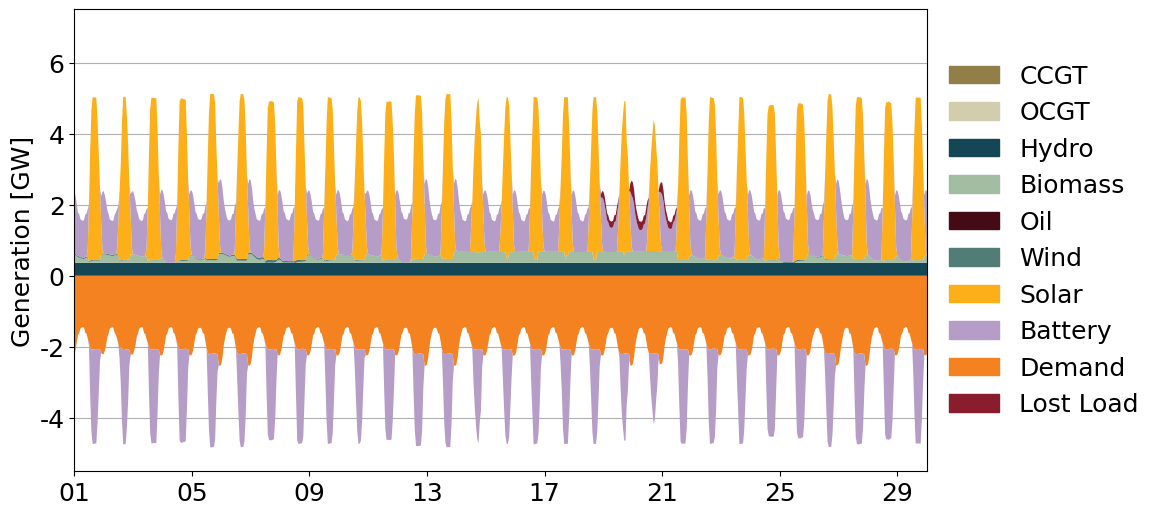

In [271]:
n = RC

# first_date = "2013-01-09"
# second_date = "2013-01-15"
first_date = "2013-01-01"
second_date = "2014-01-01"


CCGT = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["CCGT"]
print('CCGT ',CCGT.sum())

OCGT = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["OCGT"]
print('OCGT ',OCGT.sum())

Oil = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["oil"]
print('Oil  ',Oil.sum())

Onwind = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["onwind"]
print('Wind ',Onwind.sum())

solar = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["solar"]
print('Solar ',solar.sum())

biomass = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["biomass"]
print('Biomass ',biomass.sum())


Hydro = n.storage_units_t.p_dispatch[first_date:second_date].sum(axis=1)
print('Hydro', Hydro.sum())


demand = n.loads_t.p_set.loc[first_date:second_date].sum(axis=1)*-1
print('Demand ',demand.sum())

battery = n.stores_t.p.loc[first_date:second_date].groupby(n.stores.carrier, axis=1).sum()["battery"]
print('Battery', battery.sum())

i=0
nbattery = []
pbattery =[]
for i in battery:
    if i < 0:
        nbattery.append(i)
    else:
        nbattery.append(0) 
for i in battery:
    if i > 0:
        pbattery.append(i)
    else:
        pbattery.append(0) 
nbattery_9 = [float(n) / 0.9 for n in nbattery]
pbattery_9 = [float(n) * 0.9 for n in pbattery]
LL = (demand.values + nbattery_9)*-1 - (CCGT + OCGT +Oil +Onwind +solar +biomass +Hydro +pbattery_9)
print('LL',LL.sum())

fig, ax=plt.subplots(figsize = (11,6))

A = plt.stackplot(CCGT.index,CCGT,OCGT,Hydro,biomass,Oil,Onwind, solar,pbattery,LL, #,pbattery
                  colors=[beige1,beige3,teal2,green3,brown,teal3,yellow,purple3,red1], zorder = 2) #,   purple3
plt.stackplot(CCGT.index,demand,nbattery, colors=[orange,purple3], zorder = 2) #,nbattery
plt.xticks(rotation = 0)
plt.yticks()
scale_y = 1e3
ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_y))
ax.yaxis.set_major_formatter(ticks_y)
myFmt = mdates.DateFormatter('%d')
ax.xaxis.set_major_formatter(myFmt)
#ax.set_xticks(np.arange(0,200))
ax.set_ylabel('Generation [GW]')
start_date = "2013-01-01"
end_date = "2013-01-30"

start_date = pd.to_datetime(start_date)
end_date = pd.to_datetime(end_date)

ax.set_xlim(start_date, end_date)
ax.set_ylim(-5500,7500)
#ax.set_title(scen,y = 1.03)

CCGT_patch = mpatches.Patch(color=beige1, label ='CCGT')
OCGT_patch = mpatches.Patch(color=beige3, label ='OCGT')
wind_patch = mpatches.Patch(color=teal3, label ='Wind')
solar_patch = mpatches.Patch(color=yellow, label ='Solar')
#ror_patch = mpatches.Patch(color='blue', label ='ROR')
battery_patch = mpatches.Patch(color=purple3, label ='Battery')
load_patch = mpatches.Patch(color=orange, label ='Demand')
hydro_patch = mpatches.Patch(color = teal2, label = 'Hydro')
biomass_patch = mpatches.Patch(color = green3, label = 'Biomass')
oil_patch = mpatches.Patch(color = brown, label = 'Oil')
LL_patch = mpatches.Patch(color = red1, label = 'Lost Load')
handles=[CCGT_patch,OCGT_patch,hydro_patch,biomass_patch,oil_patch,wind_patch, solar_patch,battery_patch, load_patch,LL_patch] #battery_patch,
ax.legend(handles=handles, frameon = False, loc='center left', bbox_to_anchor=(1, 0.5))
ax.grid(axis='y', zorder=0)
plt.savefig(scen_path +f'Generation/RC_dispatch.pdf', dpi=300, bbox_inches='tight')
plt.savefig(scen_path +f'Generation/RC_dispatch.png', dpi=300, bbox_inches='tight')




In [263]:
LL.describe()

count     8760.000000
mean      5505.112147
std       2664.874803
min       2666.651307
25%       3261.124810
50%       4289.863656
75%       8628.920679
max      10274.801129
dtype: float64

## RCB

CCGT  0.0
OCGT  0.0
Oil   0.0
Wind  96752.03323517703
Solar  115864.84010716504
Biomass  27151.85996132333
Hydro 61010.459582750234
Demand  -322399.5746482449
Battery -46.463666355111286


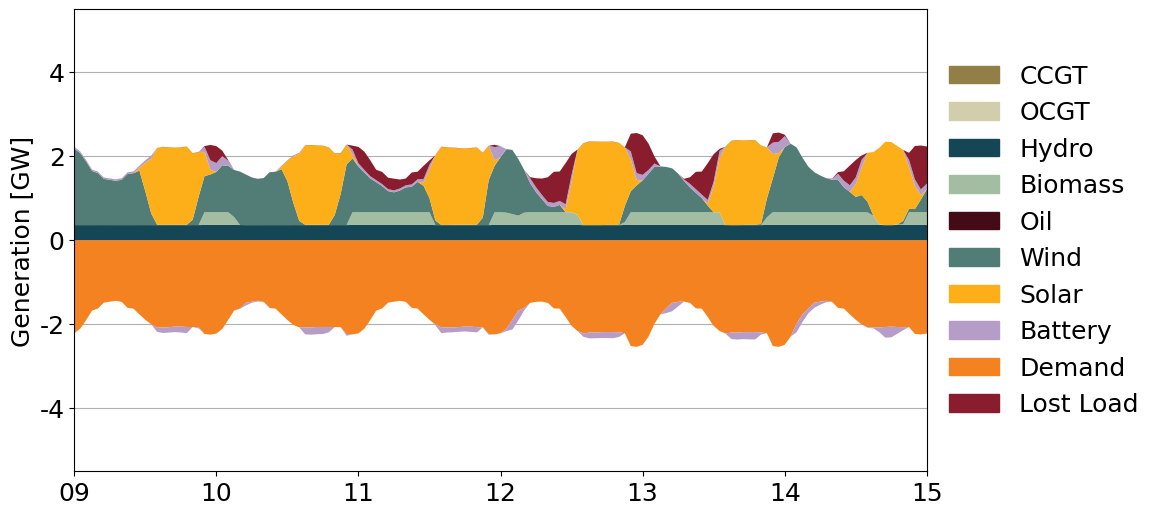

In [269]:
n = RCB

first_date = "2013-01-09"
second_date = "2013-01-15"
# first_date = "2013-01-01"
# second_date = "2014-01-01"


CCGT = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["CCGT"]
print('CCGT ',CCGT.sum())

OCGT = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["OCGT"]
print('OCGT ',OCGT.sum())

Oil = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["oil"]
print('Oil  ',Oil.sum())

Onwind = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["onwind"]
print('Wind ',Onwind.sum())

solar = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["solar"]
print('Solar ',solar.sum())

biomass = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["biomass"]
print('Biomass ',biomass.sum())


Hydro = n.storage_units_t.p_dispatch[first_date:second_date].sum(axis=1)
print('Hydro', Hydro.sum())


demand = n.loads_t.p_set.loc[first_date:second_date].sum(axis=1)*-1
print('Demand ',demand.sum())




battery = n.stores_t.p.loc[first_date:second_date].groupby(n.stores.carrier, axis=1).sum()["battery"]
print('Battery', battery.sum())

i=0
nbattery = []
pbattery =[]
for i in battery:
    if i < 0:
        nbattery.append(i)
    else:
        nbattery.append(0) 
for i in battery:
    if i > 0:
        pbattery.append(i)
    else:
        pbattery.append(0) 

nbattery_9 = [float(n) / 0.9 for n in nbattery]
pbattery_9 = [float(n) * 0.9 for n in pbattery]
LL = (demand.values + nbattery_9)*-1 - (CCGT + OCGT +Oil +Onwind +solar +biomass +Hydro +pbattery_9)

#LL = ((demand.values + nbattery)*-1) - CCGT - OCGT -Oil -Onwind -solar -biomass -Hydro -pbattery #+nbattery

fig, ax=plt.subplots(figsize = (11,6))

A = plt.stackplot(CCGT.index,CCGT,OCGT,Hydro,biomass,Oil,Onwind, solar,pbattery,LL, #,pbattery, LL,
                  colors=[beige1,beige3,teal2,green3,brown,teal3,yellow,purple3,red1], zorder = 2) #,   purple3
plt.stackplot(CCGT.index,demand,nbattery, colors=[orange,purple3], zorder = 2) #,nbattery
plt.xticks(rotation = 0)
plt.yticks()
scale_y = 1e3
ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_y))
ax.yaxis.set_major_formatter(ticks_y)
myFmt = mdates.DateFormatter('%d')
ax.xaxis.set_major_formatter(myFmt)
#ax.set_xticks(np.arange(0,200))
ax.set_ylabel('Generation [GW]')
start_date = "2013-01-09"
end_date = "2013-01-15"

start_date = pd.to_datetime(start_date)
end_date = pd.to_datetime(end_date)

ax.set_xlim(start_date, end_date)
ax.set_ylim(-5500, 5500)
#ax.set_title(scen,y = 1.03)

CCGT_patch = mpatches.Patch(color=beige1, label ='CCGT')
OCGT_patch = mpatches.Patch(color=beige3, label ='OCGT')
wind_patch = mpatches.Patch(color=teal3, label ='Wind')
solar_patch = mpatches.Patch(color=yellow, label ='Solar')
#ror_patch = mpatches.Patch(color='blue', label ='ROR')
battery_patch = mpatches.Patch(color=purple3, label ='Battery')
load_patch = mpatches.Patch(color=orange, label ='Demand')
hydro_patch = mpatches.Patch(color = teal2, label = 'Hydro')
biomass_patch = mpatches.Patch(color = green3, label = 'Biomass')
oil_patch = mpatches.Patch(color = brown, label = 'Oil')
LL_patch = mpatches.Patch(color = red1, label = 'Lost Load')
handles=[CCGT_patch,OCGT_patch,hydro_patch,biomass_patch,oil_patch,wind_patch, solar_patch,battery_patch, load_patch,LL_patch] #battery_patch,
ax.legend(handles=handles, frameon = False, loc='center left', bbox_to_anchor=(1, 0.5))
ax.grid(axis='y', zorder=0)
plt.savefig(scen_path +f'Generation/RCB_dispatch.pdf', dpi=300, bbox_inches='tight')
plt.savefig(scen_path +f'Generation/RCB_dispatch.png', dpi=300, bbox_inches='tight')




## Combined Dispatch plot

CCGT  146655.44330979013
OCGT  95024.50075155182
Oil   5007.05284834777
Wind  1391.8668115762962
Solar  4971.21293926961
Biomass  7933.690862306433
Hydro 61290.48796774808
Demand  -322399.5746482449
CCGT  117898.35936778488
OCGT  8203.094056072927
Oil   1433.2140058854952
Wind  3393.377446051408
Solar  8479.123744317769
Biomass  18093.196376400567
Geothermal  8399.999690685861
Hydro 156332.39819682896
Demand  -322399.57444816665
CCGT  0.0
OCGT  0.0
Oil   0.0
Wind  1378.7104668362315
Solar  251946.90049121762
Biomass  30011.780648073764
Hydro 61280.8477007949
Demand  -322399.5746482449
Battery 3308.6927060295293
CCGT  0.0
OCGT  0.0
Oil   0.0
Wind  96752.03323517703
Solar  115864.84010716504
Biomass  27151.85996132333
Hydro 61010.459582750234
Demand  -322399.5746482449
Battery -46.463666355111286


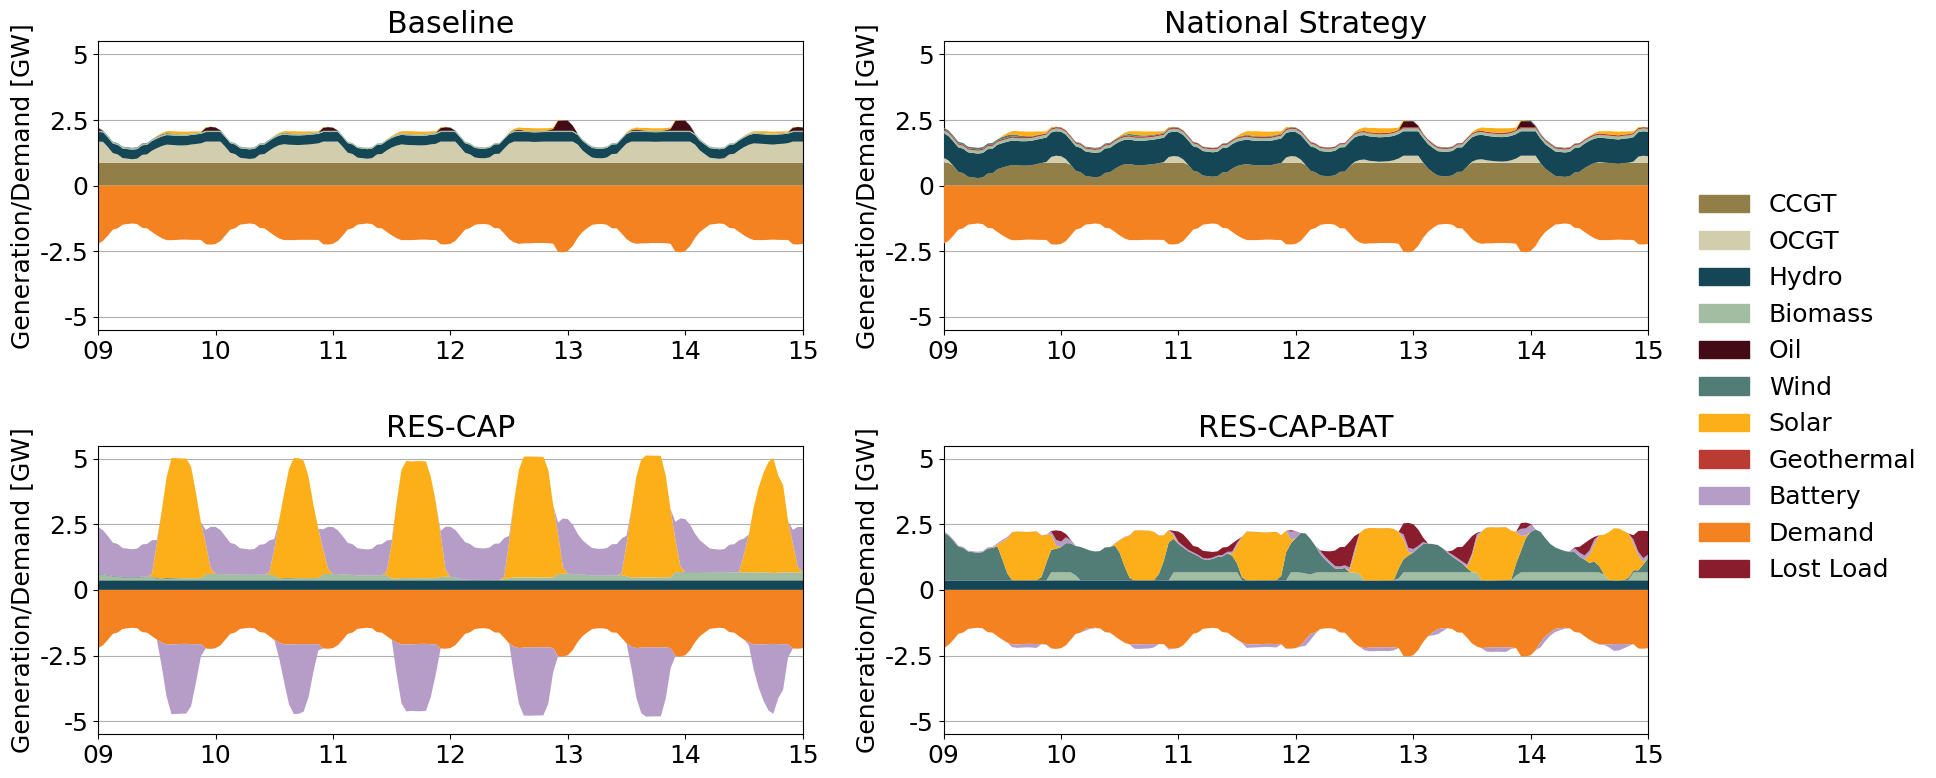

In [116]:
fig, axes = plt.subplots(2,2,figsize=(20,9),gridspec_kw={'hspace': 0.4})


n = B

first_date = "2013-01-09"
second_date = "2013-01-15"


CCGT = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["CCGT"]
print('CCGT ',CCGT.sum())

OCGT = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["OCGT"]
print('OCGT ',OCGT.sum())

Oil = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["oil"]
print('Oil  ',Oil.sum())

Onwind = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["onwind"]
print('Wind ',Onwind.sum())

solar = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["solar"]
print('Solar ',solar.sum())

biomass = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["biomass"]
print('Biomass ',biomass.sum())


Hydro = n.storage_units_t.p_dispatch[first_date:second_date].sum(axis=1)
print('Hydro', Hydro.sum())


demand = n.loads_t.p_set.loc[first_date:second_date].sum(axis=1)*-1
print('Demand ',demand.sum())


#fig, ax=plt.subplots(figsize = (11,6))

A = axes[0,0].stackplot(CCGT.index,CCGT,OCGT,Hydro,biomass,Oil,Onwind, solar, #,pbattery
                  colors=[beige1,beige3,teal2,green3,brown,teal3,yellow], zorder = 2) #,   purple3
ax=axes[0,0].stackplot(CCGT.index,demand, colors=[orange,purple3], zorder = 2) #,nbattery
plt.xticks(rotation = 0)
plt.yticks()
scale_y = 1e3
ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_y))
axes[0,0].yaxis.set_major_formatter(ticks_y)
myFmt = mdates.DateFormatter('%d')
axes[0,0].xaxis.set_major_formatter(myFmt)
#ax.set_xticks(np.arange(0,200))
axes[0,0].set_ylabel('Generation/Demand [GW]')
start_date = "2013-01-09"
end_date = "2013-01-15"

start_date = pd.to_datetime(start_date)
end_date = pd.to_datetime(end_date)

axes[0,0].set_xlim(start_date, end_date)
axes[0,0].set_ylim(-5500, 5500)
#ax.set_title(scen,y = 1.03)

CCGT_patch = mpatches.Patch(color=beige1, label ='CCGT')
OCGT_patch = mpatches.Patch(color=beige3, label ='OCGT')
wind_patch = mpatches.Patch(color=teal3, label ='Wind')
solar_patch = mpatches.Patch(color=yellow, label ='Solar')
#ror_patch = mpatches.Patch(color='blue', label ='ROR')
battery_patch = mpatches.Patch(color=purple3, label ='Battery')
load_patch = mpatches.Patch(color=orange, label ='Demand')
hydro_patch = mpatches.Patch(color = teal2, label = 'Hydro')
biomass_patch = mpatches.Patch(color = green3, label = 'Biomass')
oil_patch = mpatches.Patch(color = brown, label = 'Oil')
handles=[CCGT_patch,OCGT_patch,hydro_patch,biomass_patch,oil_patch,wind_patch, solar_patch,battery_patch, load_patch] #battery_patch,
#axes[0,0].legend(handles=handles, frameon = False, loc='center left', bbox_to_anchor=(2.2, 0))
axes[0,0].grid(axis='y', zorder=0)


#--------------NS-----------------------

n = NS



CCGT = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["CCGT"]
print('CCGT ',CCGT.sum())

OCGT = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["OCGT"]
print('OCGT ',OCGT.sum())

Oil = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["oil"]
print('Oil  ',Oil.sum())

Onwind = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["onwind"]
print('Wind ',Onwind.sum())

solar = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["solar"]
print('Solar ',solar.sum())

biomass = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["biomass"]
print('Biomass ',biomass.sum())

geothermal = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["geothermal"]
print('Geothermal ',geothermal.sum())


Hydro = n.storage_units_t.p_dispatch[first_date:second_date].sum(axis=1) + n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["ror"]
print('Hydro', Hydro.sum())

# ror = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["ror"]
# print('ROR ',ror.sum())

demand = n.loads_t.p_set.loc[first_date:second_date].sum(axis=1)*-1
print('Demand ',demand.sum())



A = axes[0,1].stackplot(CCGT.index,CCGT,OCGT,Hydro,biomass,geothermal,Oil,Onwind, solar, #,pbattery
                  colors=[beige1,beige3,teal2,green3,red2,brown,teal3,yellow], zorder = 3) #,   purple3
axes[0,1].stackplot(CCGT.index,demand, colors=[orange,purple3], zorder = 3) #,nbattery
plt.xticks(rotation = 0)
plt.yticks()
scale_y = 1e3
ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_y))
axes[0,1].yaxis.set_major_formatter(ticks_y)
myFmt = mdates.DateFormatter('%d')
axes[0,1].xaxis.set_major_formatter(myFmt)
#ax.set_xticks(np.arange(0,200))
axes[0,1].set_ylabel('Generation/Demand [GW]')
start_date = "2013-01-09"
end_date = "2013-01-15"

start_date = pd.to_datetime(start_date)
end_date = pd.to_datetime(end_date)

axes[0,1].set_xlim(start_date, end_date)
axes[0,1].set_ylim(-5500, 5500)
#ax.set_title(scen,y = 1.03)

CCGT_patch = mpatches.Patch(color=beige1, label ='CCGT')
OCGT_patch = mpatches.Patch(color=beige3, label ='OCGT')
wind_patch = mpatches.Patch(color=teal3, label ='Wind')
solar_patch = mpatches.Patch(color=yellow, label ='Solar')
#ror_patch = mpatches.Patch(color='blue', label ='ROR')
battery_patch = mpatches.Patch(color=purple3, label ='Battery')
load_patch = mpatches.Patch(color=orange, label ='Demand')
geothermal_patch = mpatches.Patch(color=red2, label ='Geothermal')

hydro_patch = mpatches.Patch(color = teal2, label = 'Hydro')
biomass_patch = mpatches.Patch(color = green3, label = 'Biomass')
oil_patch = mpatches.Patch(color = brown, label = 'Oil')
LL_patch = mpatches.Patch(color = red1, label = 'Lost Load')
handles=[CCGT_patch,OCGT_patch,hydro_patch,biomass_patch,oil_patch,wind_patch, solar_patch,geothermal_patch,battery_patch, load_patch, LL_patch] #battery_patch,
axes[0,1].legend(handles=handles, frameon = False, loc='center left', bbox_to_anchor=(1.04, -0.2))

axes[0,1].grid(axis='y', zorder=0)

#-------RC----------
n = RC

CCGT = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["CCGT"]
print('CCGT ',CCGT.sum())

OCGT = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["OCGT"]
print('OCGT ',OCGT.sum())

Oil = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["oil"]
print('Oil  ',Oil.sum())

Onwind = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["onwind"]
print('Wind ',Onwind.sum())

solar = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["solar"]
print('Solar ',solar.sum())

biomass = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["biomass"]
print('Biomass ',biomass.sum())


Hydro = n.storage_units_t.p_dispatch[first_date:second_date].sum(axis=1)
print('Hydro', Hydro.sum())


demand = n.loads_t.p_set.loc[first_date:second_date].sum(axis=1)*-1
print('Demand ',demand.sum())

battery = n.stores_t.p.loc[first_date:second_date].groupby(n.stores.carrier, axis=1).sum()["battery"]
print('Battery', battery.sum())

i=0
nbattery = []
pbattery =[]
for i in battery:
    if i < 0:
        nbattery.append(i)
    else:
        nbattery.append(0) 
for i in battery:
    if i > 0:
        pbattery.append(i)
    else:
        pbattery.append(0) 
nbattery_9 = [float(n) / 0.9 for n in nbattery]
pbattery_9 = [float(n) * 0.9 for n in pbattery]
LL = (demand.values + nbattery_9)*-1 - (CCGT + OCGT +Oil +Onwind +solar +biomass +Hydro +pbattery_9)


A = axes[1,0].stackplot(CCGT.index,CCGT,OCGT,Hydro,biomass,Oil,Onwind, solar,pbattery,LL, #,pbattery
                  colors=[beige1,beige3,teal2,green3,brown,teal3,yellow,purple3,red1], zorder = 2) #,   purple3
ax=axes[1,0].stackplot(CCGT.index,demand,nbattery, colors=[orange,purple3], zorder = 2) #,nbattery
plt.xticks(rotation = 0)
plt.yticks()
scale_y = 1e3
ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_y))
axes[1,0].yaxis.set_major_formatter(ticks_y)
myFmt = mdates.DateFormatter('%d')
axes[1,0].xaxis.set_major_formatter(myFmt)
#ax.set_xticks(np.arange(0,200))
axes[1,0].set_ylabel('Generation/Demand [GW]')
start_date = "2013-01-09"
end_date = "2013-01-15"

start_date = pd.to_datetime(start_date)
end_date = pd.to_datetime(end_date)

axes[1,0].set_xlim(start_date, end_date)
axes[1,0].set_ylim(-5500, 5500)

axes[1,0].grid(axis='y', zorder=0)


#-------RCB--------

n = RCB

CCGT = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["CCGT"]
print('CCGT ',CCGT.sum())

OCGT = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["OCGT"]
print('OCGT ',OCGT.sum())

Oil = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["oil"]
print('Oil  ',Oil.sum())

Onwind = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["onwind"]
print('Wind ',Onwind.sum())

solar = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["solar"]
print('Solar ',solar.sum())

biomass = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["biomass"]
print('Biomass ',biomass.sum())


Hydro = n.storage_units_t.p_dispatch[first_date:second_date].sum(axis=1)
print('Hydro', Hydro.sum())


demand = n.loads_t.p_set.loc[first_date:second_date].sum(axis=1)*-1
print('Demand ',demand.sum())

battery = n.stores_t.p.loc[first_date:second_date].groupby(n.stores.carrier, axis=1).sum()["battery"]
print('Battery', battery.sum())

i=0
nbattery = []
pbattery =[]
for i in battery:
    if i < 0:
        nbattery.append(i)
    else:
        nbattery.append(0) 
for i in battery:
    if i > 0:
        pbattery.append(i)
    else:
        pbattery.append(0) 
nbattery_9 = [float(n) / 0.9 for n in nbattery]
pbattery_9 = [float(n) * 0.9 for n in pbattery]
LL = (demand.values + nbattery_9)*-1 - (CCGT + OCGT +Oil +Onwind +solar +biomass +Hydro +pbattery_9)


A = axes[1,1].stackplot(CCGT.index,CCGT,OCGT,Hydro,biomass,Oil,Onwind, solar,pbattery,LL, #,pbattery
                  colors=[beige1,beige3,teal2,green3,brown,teal3,yellow,purple3,red1], zorder = 2) #,   purple3
ax=axes[1,1].stackplot(CCGT.index,demand,nbattery, colors=[orange,purple3], zorder = 2) #,nbattery
plt.xticks(rotation = 0)
plt.yticks()
scale_y = 1e3
ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_y))
axes[1,1].yaxis.set_major_formatter(ticks_y)
myFmt = mdates.DateFormatter('%d')
axes[1,1].xaxis.set_major_formatter(myFmt)
#ax.set_xticks(np.arange(0,200))
axes[1,1].set_ylabel('Generation/Demand [GW]')
start_date = "2013-01-09"
end_date = "2013-01-15"

start_date = pd.to_datetime(start_date)
end_date = pd.to_datetime(end_date)

axes[1,1].set_xlim(start_date, end_date)
axes[1,1].set_ylim(-5500, 5500)

axes[1,1].grid(axis='y', zorder=0)


axes[0,0].set_title('Baseline')
axes[0,1].set_title('National Strategy')
axes[1,0].set_title('RES-CAP')
axes[1,1].set_title('RES-CAP-BAT')

plt.savefig(scen_path +f'Generation/dispatch_all.pdf', dpi=300, bbox_inches='tight')


# Time Series

## Capacity

### Baseline

In [7]:
data_agg_B=pd.DataFrame({})
for y in range(2021,2036):
    net=pypsa.Network(data_path_B + f"B_{y}.nc")

    capacity=pd.DataFrame(net.generators.head(19))
    hydro=pd.DataFrame(net.storage_units)[["p_nom_opt","carrier"]]
    caps=pd.concat([capacity[["p_nom_opt","carrier"]],hydro],ignore_index=True)
    caps["year"]=np.ones(len(caps["p_nom_opt"]),dtype=int)*y
    
    data_agg_B=pd.concat([data_agg_B,caps])
    


INFO:pypsa.io:Imported network B_2021.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network B_2022.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network B_2023.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network B_2024.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network B_2025.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network B_2026.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network B_2027.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network B_2028.nc 

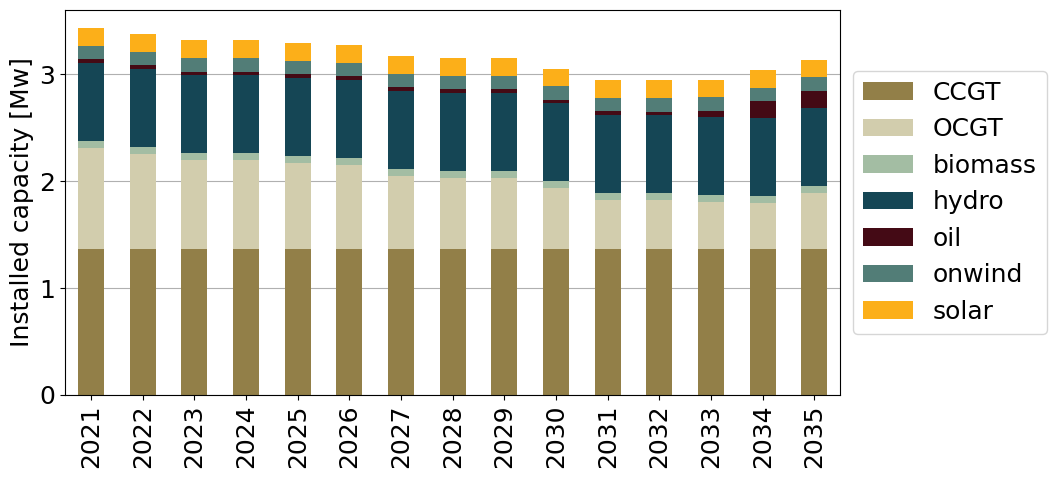

In [8]:
grouped_B = data_agg_B.groupby(["year","carrier"]).sum().unstack()/1000

grouped_B.columns = grouped_B.columns.droplevel(0)

# Create a stacked bar plot
grouped_B.plot.bar(stacked=True, figsize=(10, 5),color=carrier_colors,zorder = 2)

# Add labels and title
plt.ylabel('Installed capacity [Mw]')
plt.xlabel('')
plt.xticks(range(len(grouped_B.index)), grouped_B.index, rotation=90)
plt.grid(axis = 'y',zorder = 0)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.savefig(scen_path + 'Baseline_new_installed_capacity_2021-2035.pdf', dpi=300, bbox_inches='tight')
plt.savefig(scen_path + 'Baseline_new_installed_capacity_2021-2035.png', dpi=300, bbox_inches='tight')

In [13]:
# total capacity in 2035 
display(grouped_B.loc[2035].sum()*1000)

## Increase since 2021 MW
#display(grouped_B.loc[2035].sum()*1000 - (grouped_B.loc[2021].sum()*1000))

# Increase since 2021 %
display(grouped_B.loc[2035].sum()*1000/(grouped_B.loc[2021].sum()*1000)-1)

# Increase in 2035
display(grouped_B.loc[2035].sum()*1000 - (grouped_B.loc[2034].sum()*1000))

# RES share in 2035 
display(grouped_B.loc[2035].drop(['CCGT','OCGT','oil']).sum()/grouped_B.loc[2035].sum()*100)

# solar share in 2035
display(grouped_B.loc[2035]['solar']/grouped_B.loc[2035].sum()*100)

# Max capacity factor
max_load = 2537.885
display(max_load/(grouped_B.loc[2035].sum()*1000)*100)


3139.4485858755947

-0.08584157231948908

96.54974676605525

34.64067875044788

5.253743339186106

80.83855908384567

### RES

In [9]:
data_agg_R=pd.DataFrame({})
for y in range(2021,2036):
    net=pypsa.Network(data_path_R + f"R_{y}.nc")

    capacity=pd.DataFrame(net.generators.head(19))
    hydro=pd.DataFrame(net.storage_units)[["p_nom_opt","carrier"]]
    caps=pd.concat([capacity[["p_nom_opt","carrier"]],hydro],ignore_index=True)
    caps["year"]=np.ones(len(caps["p_nom_opt"]),dtype=int)*y
    
    data_agg_R=pd.concat([data_agg_R,caps])

INFO:pypsa.io:Imported network R_2021.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network R_2022.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network R_2023.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network R_2024.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network R_2025.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network R_2026.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network R_2027.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network R_2028.nc 

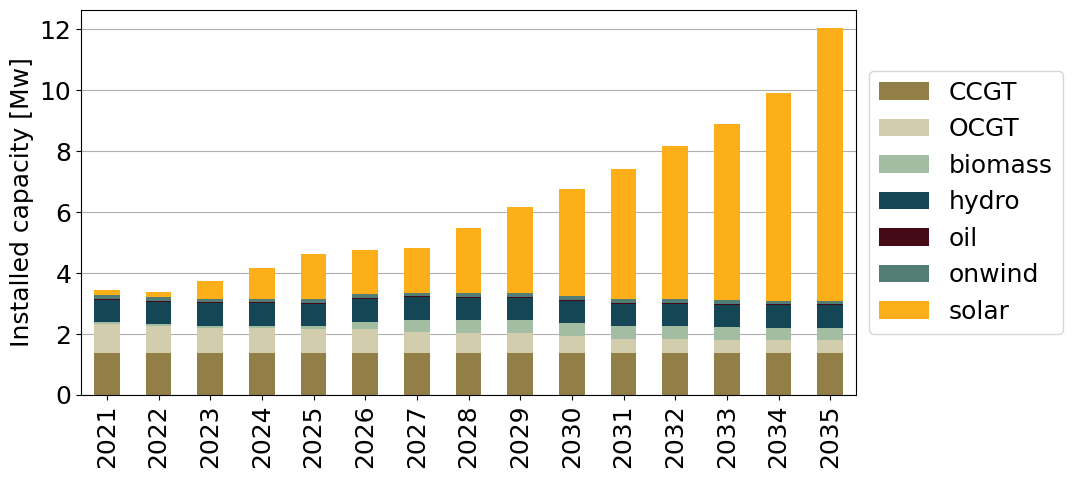

In [10]:
grouped_R = data_agg_R.groupby(["year","carrier"]).sum().unstack()/1000

grouped_R.columns = grouped_R.columns.droplevel(0)

# Create a stacked bar plot
grouped_R.plot.bar(stacked=True, figsize=(10, 5),color=carrier_colors,zorder = 2)

# Add labels and title
plt.ylabel('Installed capacity [Mw]')
plt.xlabel('')
plt.xticks(range(len(grouped_R.index)), grouped_R.index, rotation=90)
plt.grid(axis = 'y',zorder = 0)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.savefig(scen_path + 'RES_new_installed_capacity_2021-2035.pdf', dpi=300, bbox_inches='tight')
plt.savefig(scen_path + 'RES_new_installed_capacity_2021-2035.png', dpi=300, bbox_inches='tight')

In [12]:
grouped_R


p_nom_opt                                                         
carrier      CCGT     OCGT   biomass    hydro      oil    onwind     solar
year                                                                      
2021      1.36399  0.94892  0.065580  0.73220  0.03132  0.127340  0.164900
2022      1.36399  0.89186  0.065580  0.73220  0.03132  0.127340  0.164901
2023      1.36399  0.83437  0.065581  0.73220  0.03132  0.127342  0.581594
2024      1.36399  0.83437  0.065581  0.73220  0.03132  0.127343  1.019673
2025      1.36399  0.80893  0.080267  0.73220  0.03132  0.127343  1.470169
2026      1.36399  0.79107  0.248749  0.73220  0.03132  0.127343  1.470185
2027      1.36399  0.68520  0.412014  0.73220  0.03132  0.127344  1.470186
2028      1.36399  0.66830  0.420160  0.73220  0.03132  0.127347  2.124146
2029      1.36399  0.66830  0.420160  0.73220  0.03132  0.127348  2.809124
2030      1.36399  0.57045  0.420160  0.73220  0.03132  0.127381  3.517531
2031      1.36399  0.46108  0.420160  0.73220  0.03132  0.127382  4.255274
2032      1.36399  0.46108  0.420160  0.72965  0.03132  0.127439  5.025616
2033      1.36399  0.44036  0.420160  0.72965  0.02916  0.127440  5.782897
2034      1.36399  0.41964  0.420160  0.72965  0.02916  0.127440  6.815187
2035      1.36399  0.41964  0.420160  0.72965  0.02916  0.127501  8.939131

### NS

In [143]:
data_agg_NS=pd.DataFrame({})
for y in range(2021,2036):
    net=pypsa.Network(data_path_NS + f"NS_{y}.nc")

    capacity=pd.DataFrame(net.generators.head(22))
    hydro=pd.DataFrame(net.storage_units)[["p_nom_opt","carrier"]]
    caps=pd.concat([capacity[["p_nom_opt","carrier"]],hydro],ignore_index=True)
    caps["year"]=np.ones(len(caps["p_nom_opt"]),dtype=int)*y
    
    data_agg_NS=pd.concat([data_agg_NS,caps])
    

INFO:pypsa.io:Imported network NS_2021.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network NS_2022.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network NS_2023.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network NS_2024.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network NS_2025.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network NS_2026.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network NS_2027.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network NS_

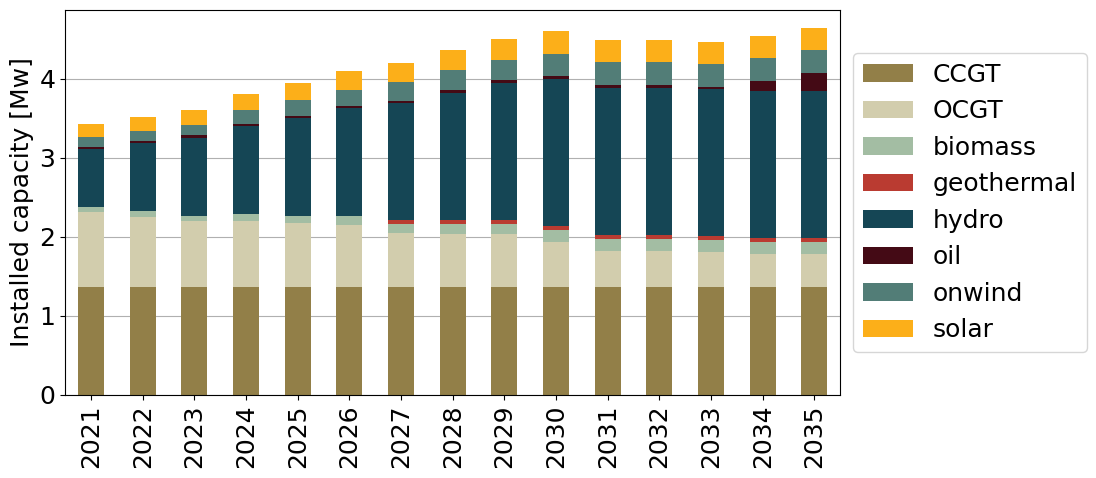

In [144]:
grouped_NS = data_agg_NS.groupby(["year","carrier"]).sum().unstack()/1000

grouped_NS.columns = grouped_NS.columns.droplevel(0)
grouped_NS['hydro'] = grouped_NS['hydro'] + grouped_NS['ror']
grouped_NS.drop('ror', axis=1, inplace=True)

# Create a stacked bar plot
grouped_NS.plot.bar(stacked=True, figsize=(10, 5),color=carrier_colors,zorder = 2)

# Add labels and title
plt.ylabel('Installed capacity [Mw]')
plt.xlabel('')
plt.xticks(range(len(grouped_NS.index)), grouped_NS.index, rotation=90)
plt.grid(axis = 'y',zorder = 0)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.savefig(scen_path + 'NS_installed_capacity_2021-2035.pdf', dpi=300, bbox_inches='tight')
plt.savefig(scen_path + 'NS_installed_capacity_2021-2035.png', dpi=300, bbox_inches='tight')

In [331]:
grouped_R[['onwind','solar']].loc[2035]

carrier
onwind    0.127341
solar     0.685826
Name: 2035, dtype: float64

In [167]:
# total capacity in 2035 
display(grouped_NS.loc[2035].sum()*1000)

## Increase since 2021 MW
#display(grouped_B.loc[2035].sum()*1000 - (grouped_B.loc[2021].sum()*1000))

# Increase since 2021 %
display(grouped_NS.loc[2035].sum()*1000/(grouped_NS.loc[2021].sum()*1000))

# Increase in 2035
display(grouped_NS.loc[2035].sum()*1000 - (grouped_NS.loc[2034].sum()*1000))

# RES share in 2035 
display(grouped_NS.loc[2035].drop(['CCGT','OCGT','oil']).sum()/grouped_NS.loc[2035].sum()*100)

# solar share in 2035
display(grouped_NS.loc[2035]['solar']/grouped_NS.loc[2035].sum()*100)

# wind potential
display(grouped_NS.loc[2035]['onwind']*1000/NS.generators.groupby('carrier').sum().p_nom_max['onwind']*100)

# solar potential
display((grouped_NS.loc[2035]['solar']*1000/NS.generators.groupby('carrier').sum().p_nom_max['solar'])*100)

4640.835402488288

1.352342142980938

95.62649072013573

56.7122046201992

6.074338223476543

0.012179863869284565

0.015078707227087642

In [155]:
NS.generators.groupby('carrier').sum().p_nom_max['onwind']

2375560.3552225567

In [45]:
RC.generators.head(20)

p_nom_max         weight         p_nom   capital_cost  \
Generator                                                                
BO 0 CCGT              inf       0.000000  4.543000e+02   84469.122809   
BO 0 OCGT              inf       0.000000  9.060000e+00   47234.561404   
BO 0 onwind   6.051026e+05   41405.519294  3.561391e-02  109295.569252   
BO 0 solar    7.058641e+05  139220.197844  4.519926e+03   50855.958267   
BO 1 CCGT              inf       0.000000  9.096900e+02   84469.122809   
BO 1 OCGT              inf       0.000000  3.194500e+02   47234.561404   
BO 1 biomass  3.571300e+02       0.000000  3.571300e+02  278015.359506   
BO 1 onwind   6.224211e+05   71313.098136  1.008158e+02  109295.569252   
BO 1 solar    2.391902e+05   33571.855042  5.535992e-02   50855.958267   
BO 2 OCGT              inf       0.000000  4.188000e+01   47234.561404   
BO 2 onwind   2.698194e+05   11403.310545  2.654628e+01  109295.569252   
BO 2 solar    3.716044e+05   73175.483153  2.295125e+03   50855.958267   
BO 3 OCGT              inf       0.000000  4.925000e+01   47234.561404   
BO 3 biomass  2.101000e+01       0.000000  2.101000e+01  278015.359506   
BO 3 oil               inf       0.000000  2.916000e+01   38234.561404   
BO 3 onwind   8.782172e+05   36204.411173  2.301282e-02  109295.569252   
BO 3 solar    5.528653e+05   84787.893600  6.104181e-02   50855.958267   
BO 0 biomass  2.101000e+01            NaN  2.101000e+01  278015.359506   
BO 2 biomass  2.101000e+01            NaN  2.101000e+01  278015.359506   
BO 0 load              inf            NaN  1.000000e+09       0.000000   

              efficiency    p_nom_min  marginal_cost  carrier   bus  \
Generator                                                             
BO 0 CCGT          0.500   454.300000      12.249258     CCGT  BO 0   
BO 0 OCGT          0.390     9.060000      13.574597     OCGT  BO 0   
BO 0 onwind        1.000     0.035614       0.024836   onwind  BO 0   
BO 0 solar         1.000  4519.925903       0.019818    solar  BO 0   
BO 1 CCGT          0.500   909.690000      12.249122     CCGT  BO 1   
BO 1 OCGT          0.390   319.450000      13.574410     OCGT  BO 1   
BO 1 biomass       0.468   357.130000       2.146007  biomass  BO 1   
BO 1 onwind        1.000   100.815819       0.024334   onwind  BO 1   
BO 1 solar         1.000     0.055360       0.020882    solar  BO 1   
BO 2 OCGT          0.390    41.880000      13.573152     OCGT  BO 2   
BO 2 onwind        1.000    26.546277       0.024283   onwind  BO 2   
BO 2 solar         1.000  2295.124685       0.019741    solar  BO 2   
BO 3 OCGT          0.390    49.250000      13.574998     OCGT  BO 3   
BO 3 biomass       0.468    21.010000       2.146974  biomass  BO 3   
BO 3 oil           0.393    29.160000      38.379064      oil  BO 3   
BO 3 onwind        1.000     0.023013       0.024622   onwind  BO 3   
BO 3 solar         1.000     0.061042       0.019825    solar  BO 3   
BO 0 biomass       0.468    21.010000       2.146030  biomass  BO 0   
BO 2 biomass       0.468    21.010000       2.146274  biomass  BO 2   
BO 0 load          1.000     0.000000       1.009719     load  BO 0   

              p_nom_extendable  ... q_set  marginal_cost_quadratic  lifetime  \
Generator                       ...                                            
BO 0 CCGT                False  ...   0.0                      0.0       inf   
BO 0 OCGT                False  ...   0.0                      0.0       inf   
BO 0 onwind               True  ...   0.0                      0.0       inf   
BO 0 solar                True  ...   0.0                      0.0       inf   
BO 1 CCGT                False  ...   0.0                      0.0       inf   
BO 1 OCGT                False  ...   0.0                      0.0       inf   
BO 1 biomass              True  ...   0.0                      0.0       inf   
BO 1 onwind               True  ...   0.0                      0.0       inf   
BO 1 solar               

### RES_CAP

In [198]:
data_agg_RC=pd.DataFrame({})
for y in range(2021,2036):
    net=pypsa.Network(data_path_RC + f"RC_{y}.nc")

    capacity=pd.DataFrame(net.generators.head(19))
    hydro=pd.DataFrame(net.storage_units)[["p_nom_opt","carrier"]]
    caps=pd.concat([capacity[["p_nom_opt","carrier"]],hydro],ignore_index=True)
    caps["year"]=np.ones(len(caps["p_nom_opt"]),dtype=int)*y
    
    data_agg_RC=pd.concat([data_agg_RC,caps])

INFO:pypsa.io:Imported network RC_2021.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network RC_2022.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network RC_2023.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network RC_2024.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network RC_2025.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network RC_2026.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network RC_2027.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network RC_

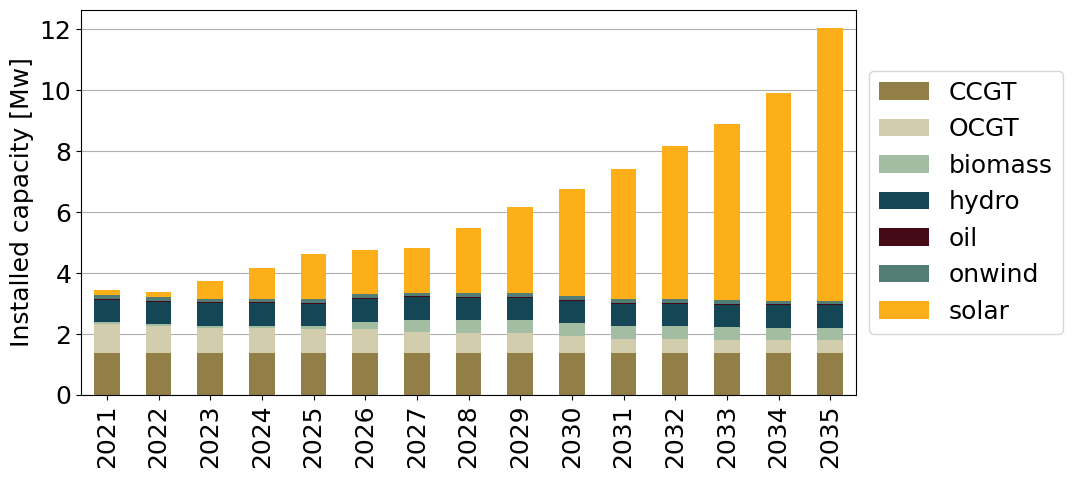

In [199]:
grouped_RC = data_agg_RC.groupby(["year","carrier"]).sum().unstack()/1000

grouped_RC.columns = grouped_RC.columns.droplevel(0)

# Create a stacked bar plot
grouped_RC.plot.bar(stacked=True, figsize=(10, 5),color=carrier_colors,zorder = 2)

# Add labels and title
plt.ylabel('Installed capacity [Mw]')
plt.xlabel('')
plt.xticks(range(len(grouped_RC.index)), grouped_RC.index, rotation=90)
plt.grid(axis = 'y',zorder = 0)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.savefig(scen_path + 'RES_CAP_bio_installed_capacity_2021-2035.pdf', dpi=300, bbox_inches='tight')
plt.savefig(scen_path + 'RES_CAP_bio_installed_capacity_2021-2035.png', dpi=300, bbox_inches='tight')

In [334]:
grouped_RC[['onwind','solar']].loc[2035]

carrier
onwind    0.127363
solar     8.729032
Name: 2035, dtype: float64

In [172]:
# total capacity in 2035 
display(grouped_RC.loc[2035].sum()*1000)

## Increase since 2021 MW
#display(grouped_B.loc[2035].sum()*1000 - (grouped_B.loc[2021].sum()*1000))

# Increase since 2021 %
display(grouped_RC.loc[2035].sum()*1000/(grouped_RC.loc[2021].sum()*1000))

# Increase in 2035
display(grouped_RC.loc[2035].sum()*1000 - (grouped_RC.loc[2034].sum()*1000))

# RES share in 2035 
display(grouped_RC.loc[2035].drop(['CCGT','OCGT','oil']).sum()/grouped_RC.loc[2035].sum()*100)

# solar share in 2035
display(grouped_RC.loc[2035]['solar']/grouped_RC.loc[2035].sum()*100)

# wind potential
display(grouped_RC.loc[2035]['onwind']*1000/RC.generators.groupby('carrier').sum().p_nom_max['onwind']*100)

# solar potential
display((grouped_RC.loc[2035]['solar']*1000/RC.generators.groupby('carrier').sum().p_nom_max['solar'])*100)

display(RC.stores.e_nom_opt.sum())

display(grouped_RC.loc[2035]['solar']*1000/RC.stores.e_nom_opt.sum()*100)

12028.341215131313

3.50246522445956

2123.1535031764797

84.92901084548915

74.31049879128777

0.0053638233846200175

0.47810676547094055

19430.523432156147

46.00143884178556

### RC_H2

In [194]:
data_agg_RC_H2=pd.DataFrame({})
for y in range(2021,2036):
    net=pypsa.Network(data_path_RC_H2 + f"RC_H2_{y}.nc")

    capacity=pd.DataFrame(net.generators.head(19))
    hydro=pd.DataFrame(net.storage_units)[["p_nom_opt","carrier"]]
    caps=pd.concat([capacity[["p_nom_opt","carrier"]],hydro],ignore_index=True)
    caps["year"]=np.ones(len(caps["p_nom_opt"]),dtype=int)*y
    
    data_agg_RC_H2=pd.concat([data_agg_RC_H2,caps])

grouped_RC_H2 = data_agg_RC_H2.groupby(["year","carrier"]).sum().unstack()/1000

grouped_RC_H2.columns = grouped_RC_H2.columns.droplevel(0)

INFO:pypsa.io:Imported network RC_H2_2021.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network RC_H2_2022.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network RC_H2_2023.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network RC_H2_2024.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network RC_H2_2025.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network RC_H2_2026.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network RC_H2_2027.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io

In [195]:
# total capacity in 2035 
display(grouped_RC_H2.loc[2035].sum()*1000)

## Increase since 2021 MW
#display(grouped_B.loc[2035].sum()*1000 - (grouped_B.loc[2021].sum()*1000))

# Increase since 2021 %
display(grouped_RC_H2.loc[2035].sum()*1000/(grouped_RC_H2.loc[2021].sum()*1000))

# Increase in 2035
display(grouped_RC_H2.loc[2035].sum()*1000 - (grouped_RC_H2.loc[2034].sum()*1000))

# RES share in 2035 
display(grouped_RC_H2.loc[2035].drop(['CCGT','OCGT','oil']).sum()/grouped_RC_H2.loc[2035].sum()*100)

# solar share in 2035
display(grouped_RC_H2.loc[2035]['solar']/grouped_RC_H2.loc[2035].sum()*100)

# wind potential
display(grouped_RC_H2.loc[2035]['onwind']*1000/RC_H2.generators.groupby('carrier').sum().p_nom_max['onwind']*100)

# solar potential
display((grouped_RC_H2.loc[2035]['solar']*1000/RC_H2.generators.groupby('carrier').sum().p_nom_max['solar'])*100)

display(RC_ror.stores.e_nom_opt.sum())

display(grouped_RC_H2.loc[2035]['solar']*1000/RC_H2.stores.e_nom_opt.sum()*100)

11690.008393813627

3.4039457343234534

1664.0444592343392

84.49282550593092

73.56720078497978

0.005362795631520035

0.460010799838232

3501.663628328535

16.10366657744607

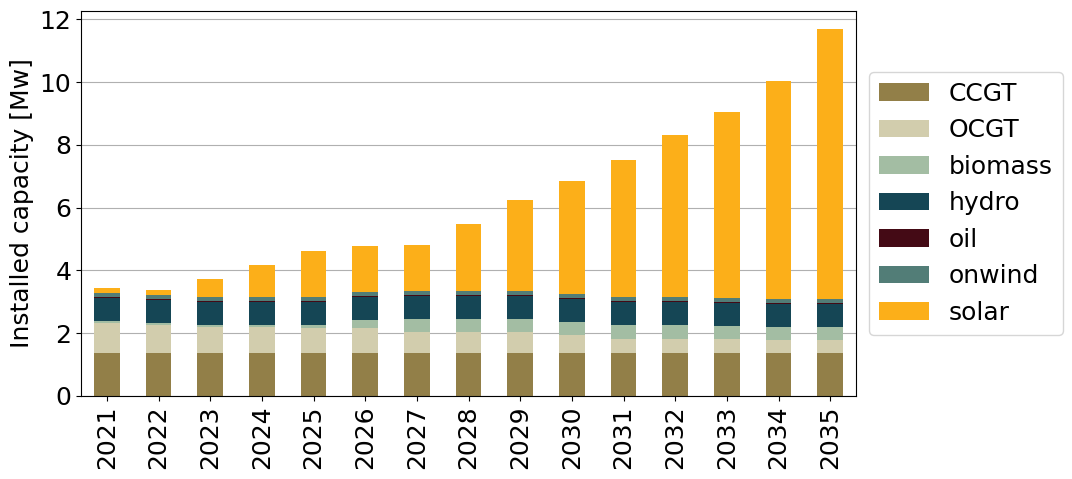

In [196]:
grouped_RC_H2 = data_agg_RC_H2.groupby(["year","carrier"]).sum().unstack()/1000

grouped_RC_H2.columns = grouped_RC_H2.columns.droplevel(0)

# Create a stacked bar plot
grouped_RC_H2.plot.bar(stacked=True, figsize=(10, 5),color=carrier_colors,zorder = 2)

# Add labels and title
plt.ylabel('Installed capacity [Mw]')
plt.xlabel('')
plt.xticks(range(len(grouped_RC_H2.index)), grouped_RC_H2.index, rotation=90)
plt.grid(axis = 'y',zorder = 0)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.savefig(scen_path + 'RES_CAP_H2_2021-2035.pdf', dpi=300, bbox_inches='tight')
plt.savefig(scen_path + 'RES_CAP_H2_2021-2035.png', dpi=300, bbox_inches='tight')

### RC_ror


In [102]:
data_agg_RC_ror=pd.DataFrame({})
for y in range(2021,2036):
    net=pypsa.Network(data_path_RC_ror + f"RC_ror_{y}.nc")

    capacity=pd.DataFrame(net.generators.head(21))
    hydro=pd.DataFrame(net.storage_units)[["p_nom_opt","carrier"]]
    caps=pd.concat([capacity[["p_nom_opt","carrier"]],hydro],ignore_index=True)
    caps["year"]=np.ones(len(caps["p_nom_opt"]),dtype=int)*y
    
    data_agg_RC_ror=pd.concat([data_agg_RC_ror,caps])

grouped_RC_ror = data_agg_RC_ror.groupby(["year","carrier"]).sum().unstack()/1000

grouped_RC_ror.columns = grouped_RC_ror.columns.droplevel(0)

INFO:pypsa.io:Imported network RC_ror_2021.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network RC_ror_2022.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network RC_ror_2023.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network RC_ror_2024.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network RC_ror_2025.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network RC_ror_2026.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network RC_ror_2027.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:p

In [103]:
# total capacity in 2035 
display(grouped_RC_ror.loc[2035].sum()*1000)

## Increase since 2021 MW
#display(grouped_B.loc[2035].sum()*1000 - (grouped_B.loc[2021].sum()*1000))

# Increase since 2021 %
display(grouped_RC_ror.loc[2035].sum()*1000/(grouped_RC_ror.loc[2021].sum()*1000))

# Increase in 2035
display(grouped_RC_ror.loc[2035].sum()*1000 - (grouped_RC_ror.loc[2034].sum()*1000))

# RES share in 2035 
display(grouped_RC_ror.loc[2035].drop(['CCGT','OCGT','oil']).sum()/grouped_RC_ror.loc[2035].sum()*100)

# solar share in 2035
display(grouped_RC_ror.loc[2035]['solar']/grouped_RC_ror.loc[2035].sum()*100)

# wind potential
display(grouped_RC_ror.loc[2035]['onwind']*1000/RC_ror.generators.groupby('carrier').sum().p_nom_max['onwind']*100)

# solar potential
display((grouped_RC_ror.loc[2035]['solar']*1000/RC_ror.generators.groupby('carrier').sum().p_nom_max['solar'])*100)

display(RC_ror.stores.e_nom_opt.sum())

display(grouped_RC_ror.loc[2035]['solar']*1000/RC_ror.stores.e_nom_opt.sum()*100)

6780.361026668029

1.9743351690037685

462.3327105519784

73.26410801917385

23.324000941340213

0.005362881649492646

0.0845911331252914

3501.663628328535

45.162860786865394

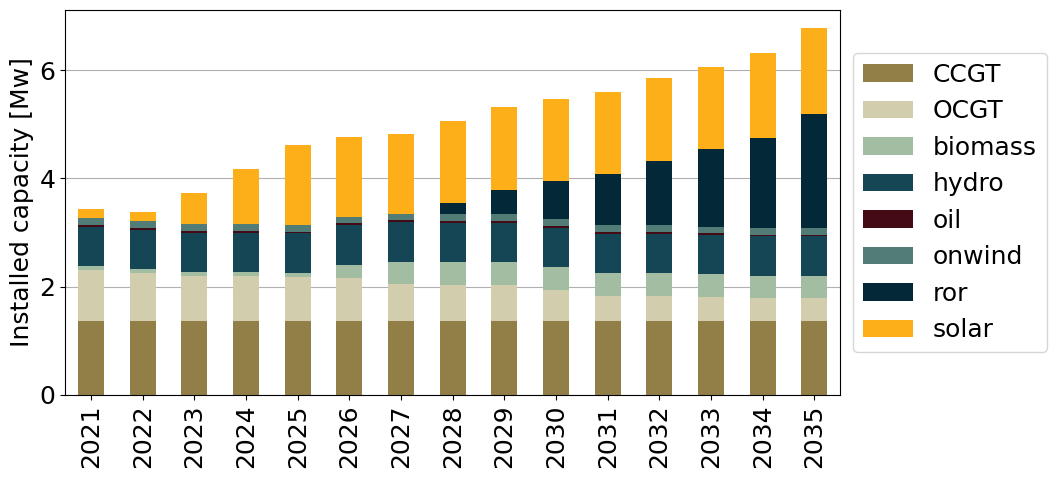

In [9]:
grouped_RC_ror = data_agg_RC_ror.groupby(["year","carrier"]).sum().unstack()/1000

grouped_RC_ror.columns = grouped_RC_ror.columns.droplevel(0)

# Create a stacked bar plot
grouped_RC_ror.plot.bar(stacked=True, figsize=(10, 5),color=carrier_colors,zorder = 2)

# Add labels and title
plt.ylabel('Installed capacity [Mw]')
plt.xlabel('')
plt.xticks(range(len(grouped_RC_ror.index)), grouped_RC_ror.index, rotation=90)
plt.grid(axis = 'y',zorder = 0)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.savefig(scen_path + 'RES_CAP_ror_2021-2035.pdf', dpi=300, bbox_inches='tight')
plt.savefig(scen_path + 'RES_CAP_ror_2021-2035.png', dpi=300, bbox_inches='tight')

### RES_CAP_BAT

In [28]:
data_agg_RCB=pd.DataFrame({})
for y in range(2021,2036):
    net=pypsa.Network(data_path_RCB + f"RCB_{y}.nc")

    capacity=pd.DataFrame(net.generators.head(19))
    hydro=pd.DataFrame(net.storage_units)[["p_nom_opt","carrier"]]
    caps=pd.concat([capacity[["p_nom_opt","carrier"]],hydro],ignore_index=True)
    caps["year"]=np.ones(len(caps["p_nom_opt"]),dtype=int)*y
    
    data_agg_RCB=pd.concat([data_agg_RCB,caps])

INFO:pypsa.io:Imported network RCB_2021.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network RCB_2022.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network RCB_2023.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network RCB_2024.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network RCB_2025.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network RCB_2026.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network RCB_2027.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported netw

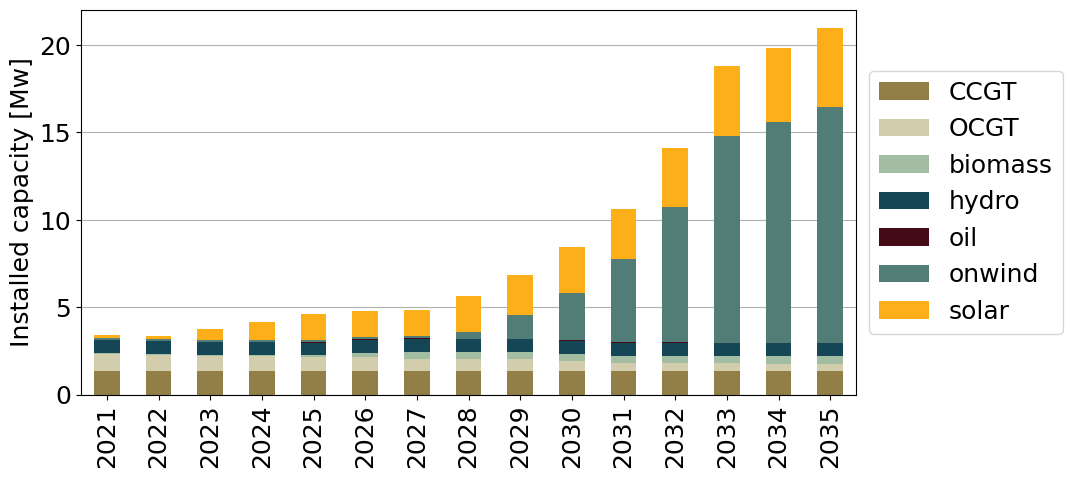

In [163]:
grouped_RCB = data_agg_RCB.groupby(["year","carrier"]).sum().unstack()/1000

grouped_RCB.columns = grouped_RCB.columns.droplevel(0)

# Create a stacked bar plot
grouped_RCB.plot.bar(stacked=True, figsize=(10, 5),color=carrier_colors,zorder = 2)

# Add labels and title
plt.ylabel('Installed capacity [Mw]')
plt.xlabel('')
plt.xticks(range(len(grouped_RCB.index)), grouped_RCB.index, rotation=90)
plt.grid(axis = 'y',zorder = 0)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.savefig(scen_path + 'RES_CAP_BAT_installed_capacity_2021-2035.pdf', dpi=300, bbox_inches='tight')
plt.savefig(scen_path + 'RES_CAP_BAT_installed_capacity_2021-2035.png', dpi=300, bbox_inches='tight')

In [337]:
grouped_RCB[['onwind','solar']].loc[2035]

carrier
onwind    7.920545
solar     7.006569
Name: 2035, dtype: float64

In [171]:
# total capacity in 2035 
display(grouped_RCB.loc[2035].sum()*1000)

## Increase since 2021 MW
#display(grouped_B.loc[2035].sum()*1000 - (grouped_B.loc[2021].sum()*1000))

# Increase since 2021 %
display(grouped_RCB.loc[2035].sum()*1000/(grouped_RCB.loc[2021].sum()*1000))

# Increase in 2035
display(grouped_RCB.loc[2035].sum()*1000 - (grouped_RCB.loc[2034].sum()*1000))

# RES share in 2035 
display(grouped_RCB.loc[2035].drop(['CCGT','OCGT','oil']).sum()/grouped_RCB.loc[2035].sum()*100)

# solar share in 2035
display(grouped_RCB.loc[2035]['solar']/grouped_RCB.loc[2035].sum()*100)

# wind potential
display(grouped_RCB.loc[2035]['onwind']*1000/RCB.generators.groupby('carrier').sum().p_nom_max['onwind']*100)

# solar potential
display((grouped_RCB.loc[2035]['solar']*1000/RCB.generators.groupby('carrier').sum().p_nom_max['solar'])*100)

display(RCB.stores.e_nom_opt.sum())

display(grouped_RCB.loc[2035]['solar']*1000/RCB.stores.e_nom_opt.sum()*100)

20959.948130600715

6.10320976256536

1132.1145789105467

91.35117134496437

21.514261772433706

0.5677805656574579

0.2412046219396852

900.0

501.04201202041804

### RCB_10

In [29]:
data_agg_RCB10=pd.DataFrame({})
for y in range(2021,2036):
    net=pypsa.Network(data_path_RCB10+ f"RCB_10_{y}.nc")

    capacity=pd.DataFrame(net.generators.head(17))
    hydro=pd.DataFrame(net.storage_units)[["p_nom_opt","carrier"]]
    caps=pd.concat([capacity[["p_nom_opt","carrier"]],hydro],ignore_index=True)
    caps["year"]=np.ones(len(caps["p_nom_opt"]),dtype=int)*y
    
    data_agg_RCB10=pd.concat([data_agg_RCB10,caps])

INFO:pypsa.io:Imported network RCB_10_2021.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network RCB_10_2022.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network RCB_10_2023.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network RCB_10_2024.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network RCB_10_2025.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network RCB_10_2026.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network RCB_10_2027.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:p

In [147]:
grouped_E.sum(axis=1)

year
2021     3.434250
2022     3.689043
2023     4.112315
2024     4.512648
2025     4.736522
2026     4.829527
2027     5.108750
2028     5.729617
2029     6.359802
2030     7.218255
2031     8.333809
2032     9.931763
2033    12.097134
2034    14.355487
2035    17.743637
dtype: float64

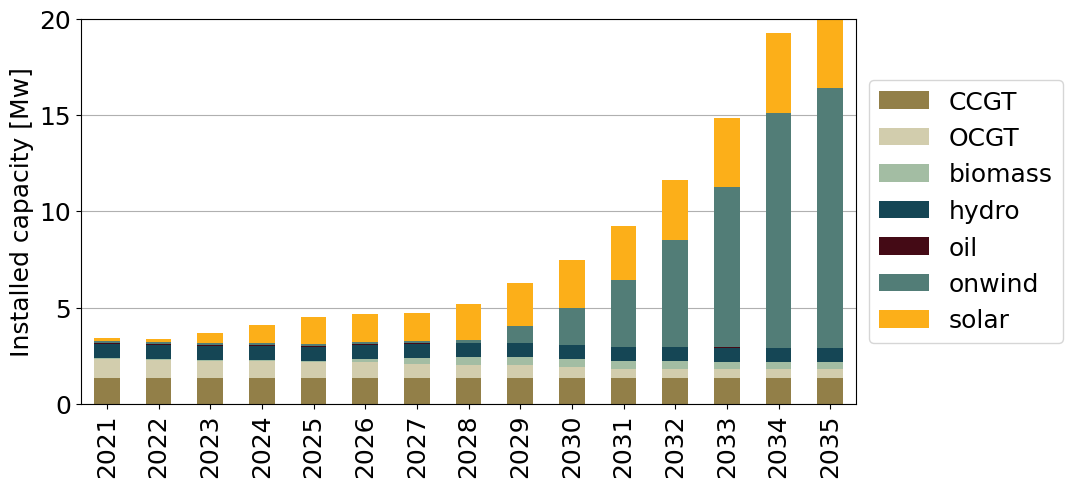

In [6]:
grouped_E = data_agg_E.groupby(["year","carrier"]).sum().unstack()/1000

grouped_E.columns = grouped_E.columns.droplevel(0)

# Create a stacked bar plot
grouped_E.plot.bar(stacked=True, figsize=(10, 5),color=carrier_colors,zorder = 2)

# Add labels and title
plt.ylabel('Installed capacity [Mw]')
plt.xlabel('')
plt.xticks(range(len(grouped_E.index)), grouped_E.index, rotation=90)
plt.grid(axis = 'y',zorder = 0)
plt.ylim(0,20)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.savefig(scen_path + 'E_installed_capacity_2021-2035.pdf', dpi=300, bbox_inches='tight')
plt.savefig(scen_path + 'E_installed_capacity_2021-2035.png', dpi=300, bbox_inches='tight')

### Combined capacity

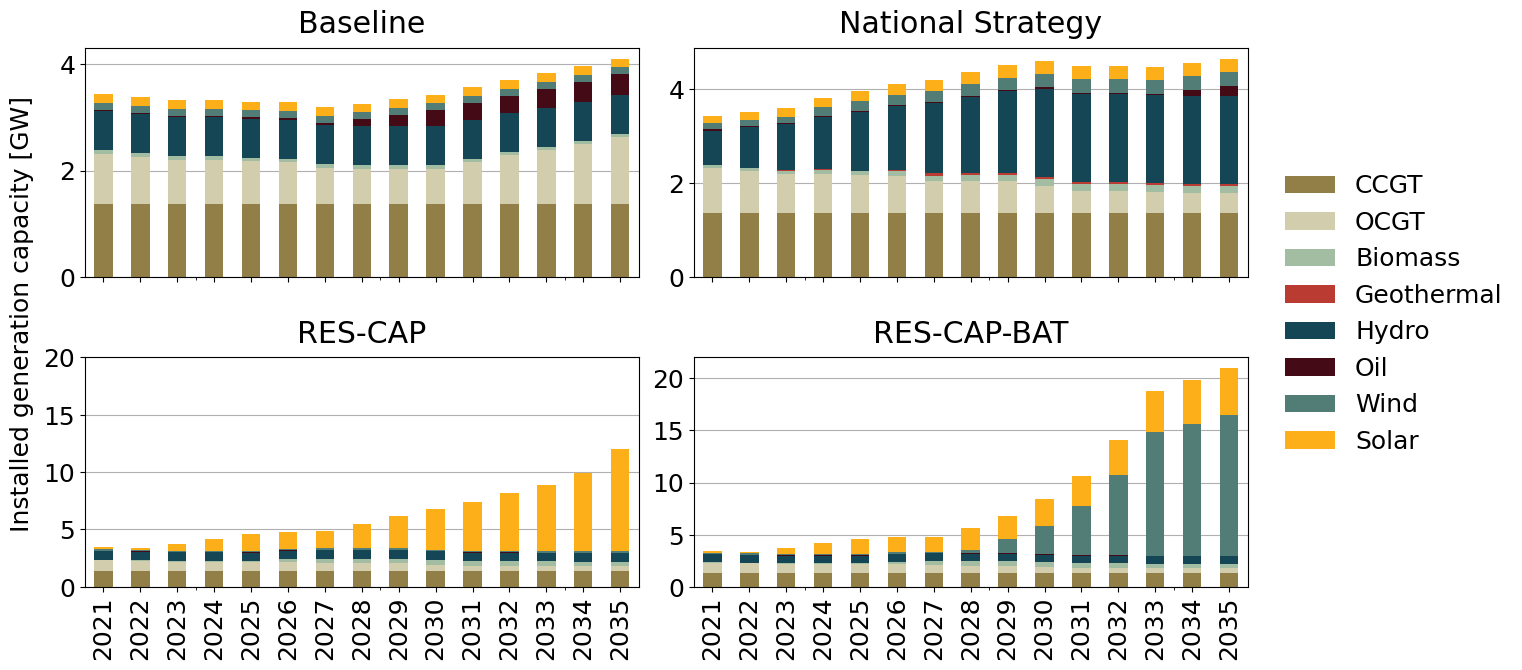

In [257]:
ticklabels= np.arange(2021,2036)

fig, axes = plt.subplots(2, 2, figsize=(20, 5), sharex=True, sharey=False)
# Create a stacked bar plot
grouped_B.plot.bar(ax=axes[0,0] ,stacked=True, color=carrier_colors, figsize=(15, 7),zorder=2) #
axes[0,0].grid(axis = 'y',zorder = 0)
axes[0, 0].legend().remove()
axes[0, 0].set_title('Baseline',y=1.03)
#axes[0, 0].set_xticklabels(ticklabels,rotation=0)
axes[0, 0].set_yticks(np.arange(0, 6, 2))

bar1 = grouped_NS.plot.bar(ax=axes[0,1] ,stacked=True, color=carrier_colors, figsize=(15, 7),zorder=2) #
axes[0,1].grid(axis = 'y',zorder = 0)
axes[0, 1].legend().remove()
axes[0, 1].set_title('National Strategy',y=1.03)
axes[0, 1].set_yticks(np.arange(0, 6, 2))

grouped_RC.plot.bar(ax=axes[1,0] ,stacked=True, color=carrier_colors, figsize=(15, 7),zorder=2) #
axes[1,0].grid(axis = 'y',zorder = 0)
axes[1, 0].legend().remove()
axes[1, 0].set_title('RES-CAP',y=1.03)
axes[1, 0].set_yticks(np.arange(0, 21, 5))
#axes[1, 0].set_xticklabels(ticklabels,rotation=0)
axes[1, 0].set_xlabel('')

grouped_RCB.plot.bar(ax=axes[1,1] ,stacked=True, color=carrier_colors, figsize=(15, 7),zorder=2) #
axes[1,1].grid(axis = 'y',zorder = 0)
axes[1, 1].legend().remove()
axes[1, 1].set_title('RES-CAP-BAT',y=1.03)
axes[1, 1].set_yticks(np.arange(0, 21, 5))
#axes[1, 1].set_xticklabels(ticklabels,rotation=0)
axes[1, 1].set_xlabel('')

# Get the legend from any one of the subplots
handles, labels = bar1.get_legend_handles_labels()

# Create a common legend
fig.legend(handles, labels_custom, loc='center left', bbox_to_anchor=(0.91, 0.5), frameon=False) #, frameon=False
fig.text(0.075, 0.5,'Installed generation capacity [GW]', va='center', rotation='vertical', fontsize=18)
plt.subplots_adjust(hspace=0.35, wspace=0.1)


plt.savefig(scen_path + 'Capacity/Timeline/' +f'Scen_capacity_carrier_2021-2035.pdf', dpi=300, bbox_inches='tight')

### Combined plot H2 ROR

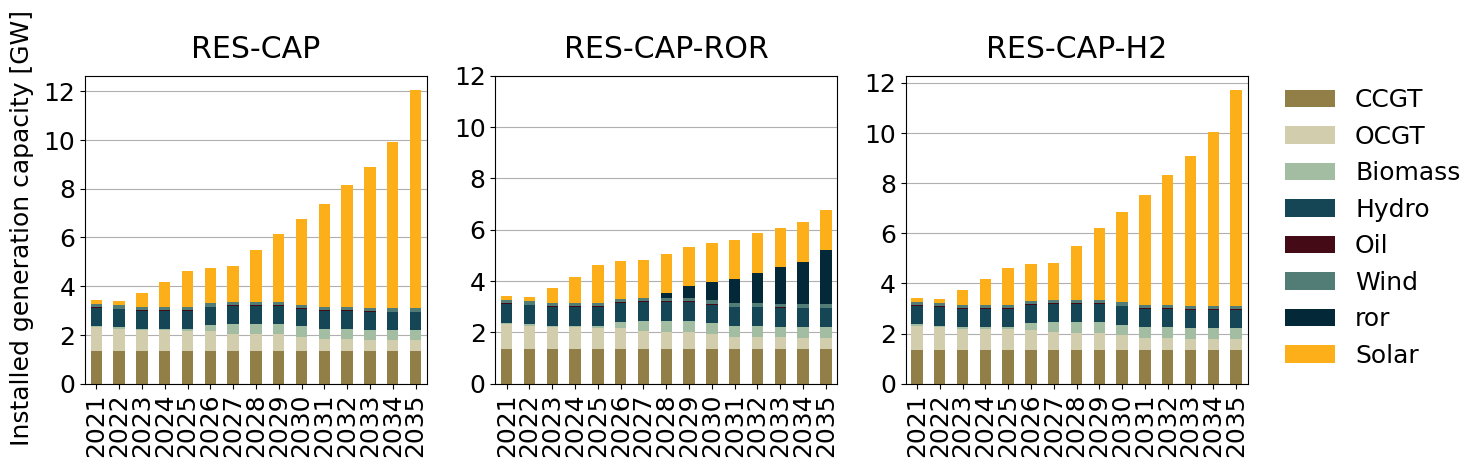

In [217]:
ticklabels= np.arange(2021,2036)

fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharex=True, sharey=False)
# Create a stacked bar plot
grouped_RC.plot.bar(ax=axes[0] ,stacked=True, color=carrier_colors, zorder=2) #
axes[0].grid(axis = 'y',zorder = 0)
axes[0].legend().remove()
axes[0].set_title('RES-CAP',y=1.03)
#axes[0, 0].set_xticklabels(ticklabels,rotation=0)
axes[0].set_yticks(np.arange(0, 14, 2))
axes[0].set_xlabel('')

bar1 = grouped_RC_ror.plot.bar(ax=axes[1] ,stacked=True, color=carrier_colors, zorder=2) #
axes[1].grid(axis = 'y',zorder = 0)
axes[1].legend().remove()
axes[1].set_title('RES-CAP-ROR',y=1.03)
axes[1].set_yticks(np.arange(0, 14, 2))
axes[1].set_xlabel('')

grouped_RC_H2.plot.bar(ax=axes[2] ,stacked=True, color=carrier_colors, zorder=2) #
axes[2].grid(axis = 'y',zorder = 0)
axes[2].legend().remove()
axes[2].set_title('RES-CAP-H2',y=1.03)
axes[2].set_yticks(np.arange(0, 14, 2))
#axes[1, 0].set_xticklabels(ticklabels,rotation=0)
axes[2].set_xlabel('')


# Get the legend from any one of the subplots
handles, labels = bar1.get_legend_handles_labels()

# Create a common legend
fig.legend(handles, labels_custom, loc='center left', bbox_to_anchor=(0.91, 0.5), frameon=False) #, frameon=False
fig.text(0.075, 0.5,'Installed generation capacity [GW]', va='center', rotation='vertical', fontsize=18)
plt.subplots_adjust(hspace=0.5, wspace=0.2)


plt.savefig(scen_path + f'capacity_H2_ror.pdf', dpi=300, bbox_inches='tight')

In [33]:
bar1.get_legend_handles_labels()

([<BarContainer object of 15 artists>,
  <BarContainer object of 15 artists>,
  <BarContainer object of 15 artists>,
  <BarContainer object of 15 artists>,
  <BarContainer object of 15 artists>,
  <BarContainer object of 15 artists>,
  <BarContainer object of 15 artists>,
  <BarContainer object of 15 artists>],
 ['CCGT', 'OCGT', 'biomass', 'geothermal', 'hydro', 'oil', 'onwind', 'solar'])

## Capacity change

### Baseline

In [34]:
data_agg=pd.DataFrame({})
for y in range(2021,2036):
    net=pypsa.Network(data_path_B + f"B_{y}.nc")

    capacity=pd.DataFrame(net.generators.head(19))
    hydro=pd.DataFrame(net.storage_units)[["p_nom_opt","carrier","p_nom"]]
    caps=pd.concat([capacity[["p_nom_opt","carrier","p_nom"]],hydro],ignore_index=True)
    caps["zubau"]=caps["p_nom_opt"]-caps["p_nom"]
    caps["year"]=np.ones(len(caps["p_nom_opt"]),dtype=int)*y
    
    data_agg=pd.concat([data_agg,caps[["year","carrier","zubau"]]])
    
grouped_cap_change_B = data_agg.groupby(['year', 'carrier']).sum().unstack()  

grouped_cap_change_B.columns = grouped_cap_change_B.columns.droplevel(0)
grouped_cap_change_B = grouped_cap_change_B.clip(lower=0)
grouped_cap_change_B

INFO:pypsa.io:Imported network B_2021.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network B_2022.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network B_2023.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network B_2024.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network B_2025.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network B_2026.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network B_2027.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network B_2028.nc 

carrier          CCGT          OCGT       biomass  hydro           oil  \
year                                                                     
2021     2.545050e-09  7.474519e-07  5.058150e-07    0.0  1.666954e-07   
2022     6.187542e-07  1.053011e-05  5.109303e-06    0.0  4.508837e-06   
2023     3.509544e-05  2.072206e-03  3.961275e-04    0.0  1.109486e-03   
2024     4.072659e-04  4.508042e-03  1.078082e-04    0.0  1.235165e-04   
2025     4.597347e-04  1.125031e-03  1.149924e-04    0.0  4.189376e-03   
2026     1.271257e-04  2.609177e-03  2.829504e-05    0.0  6.715203e-05   
2027     1.611066e-04  1.289635e-03  2.081960e-04    0.0  1.496280e+01   
2028     2.263415e-04  1.290468e-03  1.923675e-04    0.0  8.715877e+01   
2029     2.967632e-04  1.701041e-02  1.170282e-03    0.0  8.119977e+01   
2030     2.979993e-04  1.015233e+02  1.578904e-04    0.0  8.366880e+01   
2031     2.891773e-04  2.311321e+02  2.704650e-03    0.0  1.226492e+01   
2032     9.902023e-05  1.294811e+02  1.995722e-03    0.0  1.289218e+01   
2033     1.481428e-04  1.128781e+02  2.522956e-03    0.0  3.249327e+01   
2034     1.976949e-04  1.352498e+02  9.066784e-04    0.0  1.950104e+01   
2035     2.069382e-04  1.279976e+02  1.759322e-04    0.0  1.464873e+01   

carrier    onwind     solar  
year                         
2021     0.000001  0.000002  
2022     0.000015  0.000024  
2023     0.001104  0.003271  
2024     0.000735  0.000924  
2025     0.000943  0.001829  
2026     0.001447  0.001271  
2027     0.002113  0.013706  
2028     0.002658  0.002991  
2029     0.001370  0.004737  
2030     0.002003  0.000387  
2031     0.000941  0.009145  
2032     0.000503  0.014471  
2033     0.008997  0.000748  
2034     0.001316  0.004833  
2035     0.001802  0.001487

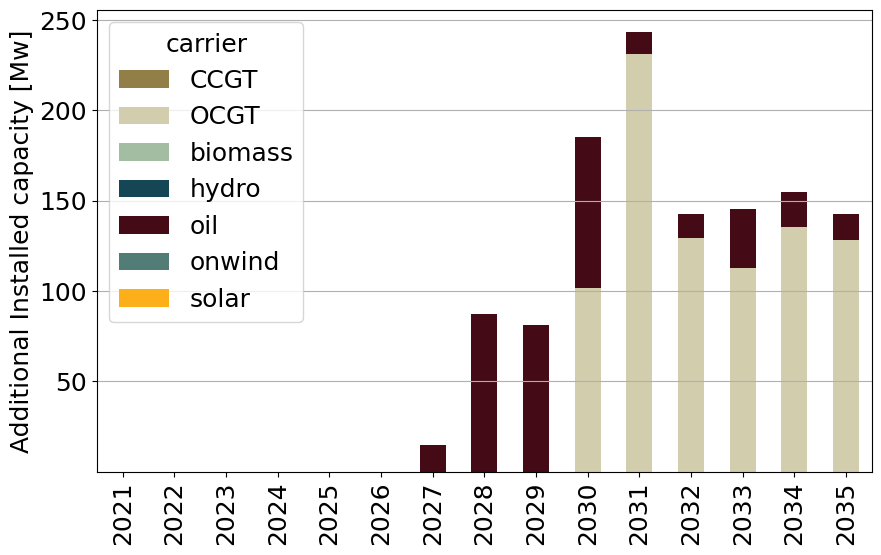

In [7]:

# Create a stacked bar plot
grouped_cap_change_B.plot.bar(stacked=True, figsize=(10, 6),color=carrier_colors)

# Add labels and title
plt.ylabel('Additional Installed capacity [Mw]')
plt.xlabel('')
plt.xticks(range(len(grouped_cap_change_B.index)), grouped_cap_change_B.index, rotation=90)
plt.grid(axis = 'y',zorder = 0)

#plt.savefig(f'{fig_path}/zubau.pdf', dpi=300, bbox_inches='tight')

### NS

In [35]:
# generation capacity change

data_agg=pd.DataFrame({})
for y in range(2021,2036):
    net=pypsa.Network(data_path_NS + f"NS_{y}.nc")

    capacity=pd.DataFrame(net.generators.head(22))
    hydro=pd.DataFrame(net.storage_units)[["p_nom_opt","carrier","p_nom"]]
    caps=pd.concat([capacity[["p_nom_opt","carrier","p_nom"]],hydro],ignore_index=True)
    caps["zubau"]=caps["p_nom_opt"]-caps["p_nom"]
    caps["year"]=np.ones(len(caps["p_nom_opt"]),dtype=int)*y
    
    data_agg=pd.concat([data_agg,caps[["year","carrier","zubau"]]])
    
grouped_cap_change_NS = data_agg.groupby(['year', 'carrier']).sum().unstack()  

grouped_cap_change_NS.columns = grouped_cap_change_NS.columns.droplevel(0)
grouped_cap_change_NS = grouped_cap_change_NS.clip(lower=0)
grouped_cap_change_NS

INFO:pypsa.io:Imported network NS_2021.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network NS_2022.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network NS_2023.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network NS_2024.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network NS_2025.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network NS_2026.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network NS_2027.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network NS_

carrier      CCGT      OCGT    biomass  geothermal  hydro         oil  \
year                                                                    
2021     0.000036  0.001148   0.000101    0.000041    0.0    0.000038   
2022     0.000013  0.000000   0.000024    4.999962    0.0    0.000000   
2023     0.000000  0.000000   0.000000    0.000000    0.0    0.000000   
2024     0.000000  0.000000  20.999875    0.000000    0.0    0.000000   
2025     0.000000  0.000000   0.000000    0.000000    0.0    0.000000   
2026     0.000000  0.000000  21.000389    0.000294    0.0    0.000010   
2027     0.000000  0.000000   0.000000   44.999704    0.0    0.000000   
2028     0.000028  0.000000  20.999643    0.000007    0.0    0.000106   
2029     0.000000  0.000000   0.000000    0.000000    0.0    0.000000   
2030     0.000071  0.000000  20.999807    0.000000    0.0    0.000000   
2031     0.000000  0.000000   0.000000    0.000000    0.0    0.000000   
2032     0.000000  0.000000   0.000000    0.000022    0.0    0.000007   
2033     0.000275  0.000000   0.000000    0.000000    0.0    0.000227   
2034     0.000000  0.000000   0.000000    0.000000    0.0  100.498270   
2035     0.000000  0.000000   0.000000    0.000000    0.0   95.626671   

carrier     onwind         ror      solar  
year                                       
2021      0.000205    0.000095   0.000459  
2022      0.000000  125.999955  12.999822  
2023      0.000000  125.999950  12.999547  
2024     52.999796  125.999999  12.999719  
2025     23.999809  126.000000  12.999721  
2026      0.000471  126.000060  13.000470  
2027     24.999371  125.999939  12.999301  
2028     24.999822  126.000006  12.999947  
2029      0.000000  125.999954  12.999186  
2030     34.999593  126.000018  12.999474  
2031      0.000000    0.000000   0.000000  
2032      0.000000    0.000000   0.000000  
2033      0.000000    0.000016   0.000000  
2034      0.000000    0.000000   0.000000  
2035      0.000000    0.000000   0.000000

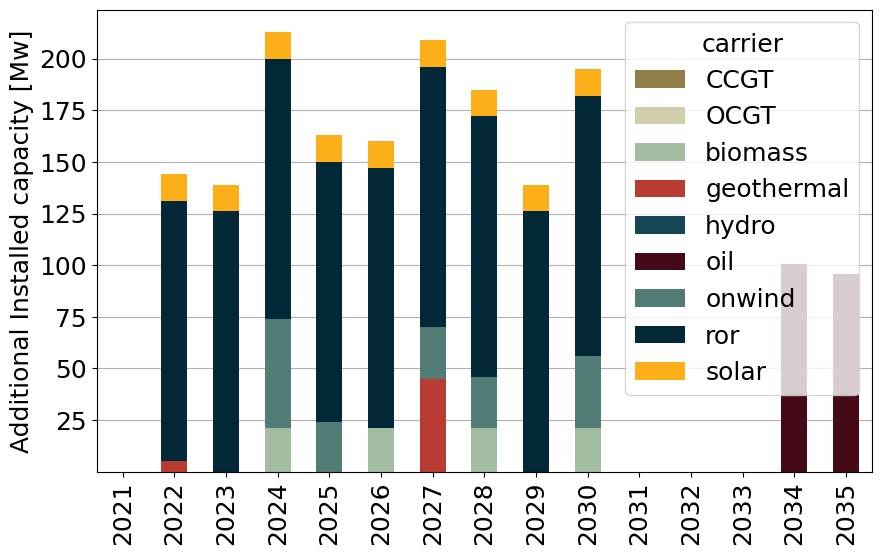

In [36]:
#Create a stacked bar plot
grouped_cap_change_NS.plot.bar(stacked=True, figsize=(10, 6),color=carrier_colors, zorder =2)

# Add labels and title
plt.ylabel('Additional Installed capacity [Mw]')
plt.xlabel('')
plt.xticks(range(len(grouped_cap_change_NS.index)), grouped_cap_change_NS.index, rotation=90)
plt.grid(axis = 'y',zorder = 0)

In [261]:
# Stores and links capacity change

data_agg=pd.DataFrame({})

for y in range(2021, 2036):
    net = pypsa.Network(data_path_R + f"RES_{y}.nc")

    links = pd.DataFrame(net.links)[['carrier', 'p_nom_opt', 'p_nom']]
    stores = pd.DataFrame(net.stores)[['carrier', 'e_nom_opt', 'e_nom']]
    stores = stores.rename(columns={"e_nom": "p_nom", "e_nom_opt": "p_nom_opt"})
    caps_change = pd.concat([links, stores], ignore_index=True)
    caps_change['zubau'] = caps_change['p_nom_opt'] - caps_change['p_nom']
    caps_change['year'] = np.ones(len(caps_change['p_nom_opt']), dtype=int) * y
    
    data_agg = pd.concat([data_agg, caps_change[['year', 'carrier', 'zubau']]])

grouped_cap_stores_change_R = data_agg.groupby(['year', 'carrier']).sum().unstack()

grouped_cap_stores_change_R.columns = grouped_cap_stores_change_R.columns.droplevel(0)

grouped_cap_stores_change_R = grouped_cap_stores_change_R.clip(lower=0)
grouped_cap_stores_change_R


INFO:pypsa.io:Imported network RES_2021.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network RES_2022.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network RES_2023.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network RES_2024.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network RES_2025.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network RES_2026.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network RES_2027.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported netw

carrier     battery  battery charger  battery discharger
year                                                    
2021       0.000013     8.380547e-06        9.311719e-06
2022       0.001000     7.732299e-04        8.591443e-04
2023       0.000000     0.000000e+00        0.000000e+00
2024       0.000000     3.569466e-07        3.966074e-07
2025       0.014511     1.197191e-02        1.330212e-02
2026       0.000000     0.000000e+00        0.000000e+00
2027       0.002136     1.793150e-03        1.992389e-03
2028       0.000000     0.000000e+00        0.000000e+00
2029       0.344737     1.551887e-01        1.724319e-01
2030     183.420985     5.497449e+01        6.108277e+01
2031     333.443878     9.555718e+01        1.061746e+02
2032     394.559909     9.185927e+01        1.020659e+02
2033     446.681067     8.929558e+01        9.921731e+01
2034     454.460244     9.047124e+01        1.005236e+02
2035     344.675706     6.513274e+01        7.236971e+01

### RES_CAP

In [37]:
# generation capacity change

data_agg=pd.DataFrame({})
for y in range(2021,2036):
    net=pypsa.Network(data_path_RC + f"RC_{y}.nc")

    capacity=pd.DataFrame(net.generators.head(19))
    hydro=pd.DataFrame(net.storage_units)[["p_nom_opt","carrier","p_nom"]]
    caps=pd.concat([capacity[["p_nom_opt","carrier","p_nom"]],hydro],ignore_index=True)
    caps["zubau"]=caps["p_nom_opt"]-caps["p_nom"]
    caps["year"]=np.ones(len(caps["p_nom_opt"]),dtype=int)*y
    
    data_agg=pd.concat([data_agg,caps[["year","carrier","zubau"]]])
    
grouped_cap_change_RC = data_agg.groupby(['year', 'carrier']).sum().unstack()  

grouped_cap_change_RC.columns = grouped_cap_change_RC.columns.droplevel(0)
grouped_cap_change_RC = grouped_cap_change_RC.clip(lower=0)
grouped_cap_change_RC

INFO:pypsa.io:Imported network RC_2021.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network RC_2022.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network RC_2023.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network RC_2024.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network RC_2025.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network RC_2026.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network RC_2027.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network RC_

carrier  CCGT  OCGT       biomass  hydro  oil    onwind        solar
year                                                                
2021      0.0   0.0  6.985294e-07    0.0  0.0  0.000002     0.000003
2022      0.0   0.0  1.937047e-05    0.0  0.0  0.000062     0.000119
2023      0.0   0.0  1.782639e-05    0.0  0.0  0.000057   416.686182
2024      0.0   0.0  7.054165e-04    0.0  0.0  0.002816   438.074385
2025      0.0   0.0  1.468710e+01    0.0  0.0  0.005729   450.491233
2026      0.0   0.0  1.684823e+02    0.0  0.0  0.003675     0.013663
2027      0.0   0.0  1.632685e+02    0.0  0.0  0.000319     0.011140
2028      0.0   0.0  8.141325e+00    0.0  0.0  0.002779   653.968018
2029      0.0   0.0  6.559514e-07    0.0  0.0  0.026342   684.712925
2030      0.0   0.0  1.625483e-06    0.0  0.0  0.021957   708.800570
2031      0.0   0.0  1.115051e-07    0.0  0.0  0.002498   737.440116
2032      0.0   0.0  0.000000e+00    0.0  0.0  0.001383   770.322470
2033      0.0   0.0  0.000000e+00    0.0  0.0  0.000389   757.490906
2034      0.0   0.0  8.617640e-07    0.0  0.0  0.012715  1032.255261
2035      0.0   0.0  7.268142e-08    0.0  0.0  0.000139  2123.153364

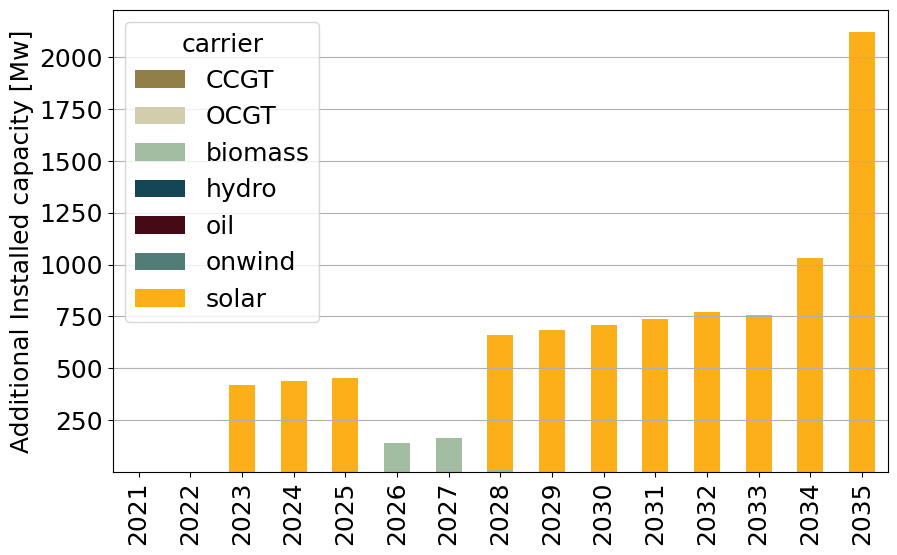

In [105]:
#Create a stacked bar plot
grouped_cap_change_RC.plot.bar(stacked=True, figsize=(10, 6),color=carrier_colors)

# Add labels and title
plt.ylabel('Additional Installed capacity [Mw]')
plt.xlabel('')
plt.xticks(range(len(grouped_cap_change_RC.index)), grouped_cap_change_RC.index, rotation=90)
plt.grid(axis = 'y',zorder = 0)

In [38]:
# Stores and links capacity change

data_agg=pd.DataFrame({})

for y in range(2021, 2036):
    net = pypsa.Network(data_path_RC + f"RC_{y}.nc")

    links = pd.DataFrame(net.links)[['carrier', 'p_nom_opt', 'p_nom']]
    stores = pd.DataFrame(net.stores)[['carrier', 'e_nom_opt', 'e_nom']]
    stores = stores.rename(columns={"e_nom": "p_nom", "e_nom_opt": "p_nom_opt"})
    caps_change = pd.concat([links, stores], ignore_index=True)
    caps_change['zubau'] = caps_change['p_nom_opt'] - caps_change['p_nom']
    caps_change['year'] = np.ones(len(caps_change['p_nom_opt']), dtype=int) * y
    
    data_agg = pd.concat([data_agg, caps_change[['year', 'carrier', 'zubau']]])

grouped_cap_stores_change_RC = data_agg.groupby(['year', 'carrier']).sum().unstack()

grouped_cap_stores_change_RC.columns = grouped_cap_stores_change_RC.columns.droplevel(0)

grouped_cap_stores_change_RC = grouped_cap_stores_change_RC.clip(lower=0)
grouped_cap_stores_change_RC


INFO:pypsa.io:Imported network RC_2021.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network RC_2022.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network RC_2023.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network RC_2024.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network RC_2025.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network RC_2026.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network RC_2027.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network RC_

carrier      battery  battery charger  battery discharger
year                                                     
2021        0.000022         0.000015            0.000017
2022        0.000524         0.000373            0.000415
2023        0.000209         0.000231            0.000256
2024        0.013026         0.008456            0.009396
2025        0.015490         0.003242            0.003602
2026        0.017542         0.005470            0.006078
2027        0.008384         0.000465            0.000517
2028     1572.567488       296.662857          329.625397
2029     2068.710469       350.780188          389.755765
2030     2252.203330       364.583535          405.092816
2031     2385.818155       362.346043          402.606715
2032     2463.870450       374.292791          415.880879
2033     2354.628522       356.556390          396.173766
2034     2402.079684       381.071762          423.413069
2035     3930.590137       476.139837          529.044263

### RC_H2

In [187]:
data_agg=pd.DataFrame({})
for y in range(2021,2036):
    net=pypsa.Network(data_path_RC_H2 + f"RC_H2_{y}.nc")

    capacity=pd.DataFrame(net.generators.head(19))
    hydro=pd.DataFrame(net.storage_units)[["p_nom_opt","carrier","p_nom"]]
    caps=pd.concat([capacity[["p_nom_opt","carrier","p_nom"]],hydro],ignore_index=True)
    caps["zubau"]=caps["p_nom_opt"]-caps["p_nom"]
    caps["year"]=np.ones(len(caps["p_nom_opt"]),dtype=int)*y
    
    data_agg=pd.concat([data_agg,caps[["year","carrier","zubau"]]])
    
grouped_cap_change_RC_H2 = data_agg.groupby(['year', 'carrier']).sum().unstack()  

grouped_cap_change_RC_H2.columns = grouped_cap_change_RC_H2.columns.droplevel(0)
grouped_cap_change_RC_H2 = grouped_cap_change_RC_H2.clip(lower=0)
grouped_cap_change_RC_H2

data_agg=pd.DataFrame({})

for y in range(2021, 2036):
    net = pypsa.Network(data_path_RC_H2 + f"RC_H2_{y}.nc")

    links = pd.DataFrame(net.links)[['carrier', 'p_nom_opt', 'p_nom']]
    stores = pd.DataFrame(net.stores)[['carrier', 'e_nom_opt', 'e_nom']]
    stores = stores.rename(columns={"e_nom": "p_nom", "e_nom_opt": "p_nom_opt"})
    caps_change = pd.concat([links, stores], ignore_index=True)
    caps_change['zubau'] = caps_change['p_nom_opt'] - caps_change['p_nom']
    caps_change['year'] = np.ones(len(caps_change['p_nom_opt']), dtype=int) * y
    
    data_agg = pd.concat([data_agg, caps_change[['year', 'carrier', 'zubau']]])

grouped_cap_stores_change_RC_H2 = data_agg.groupby(['year', 'carrier']).sum().unstack()

grouped_cap_stores_change_RC_H2.columns = grouped_cap_stores_change_RC_H2.columns.droplevel(0)

grouped_cap_stores_change_RC_H2 = grouped_cap_stores_change_RC_H2.clip(lower=0)
grouped_cap_stores_change_RC_H2

INFO:pypsa.io:Imported network RC_H2_2021.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network RC_H2_2022.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network RC_H2_2023.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network RC_H2_2024.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network RC_H2_2025.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network RC_H2_2026.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network RC_H2_2027.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io

carrier            H2  H2 electrolysis  H2 fuel cell      battery  \
year                                                                
2021         0.106435         0.002171      0.002732     0.005558   
2022         0.004829         0.001845      0.000386     0.000092   
2023         0.045050         0.000431      0.003182     0.004841   
2024         0.008286         0.003330      0.000550     0.001191   
2025         0.015764         0.000963      0.001178     0.024176   
2026         0.032779         0.003020      0.000590     0.031093   
2027         0.050857         0.010697      0.003538     0.045301   
2028      1041.126315       179.948282     63.922669   957.942189   
2029      1013.801166       140.439983     67.637735  1432.791014   
2030       502.902103        48.110875     34.707542  1968.426051   
2031       629.048108        74.137891     47.758719  1983.978719   
2032       627.186502        87.090176     53.924765  2023.990862   
2033       481.838927        54.593003     32.964491  2065.203087   
2034      3128.438958        82.140384     36.067957  2036.277177   
2035     30912.190100       225.292337    179.115254  2598.543624   

carrier  battery charger  battery discharger  
year                                          
2021            0.004225            0.004694  
2022            0.000011            0.000012  
2023            0.004407            0.004896  
2024            0.000399            0.000444  
2025            0.006572            0.007302  
2026            0.009235            0.010262  
2027            0.010988            0.012209  
2028          205.267913          228.075459  
2029          241.977039          268.863377  
2030          335.155406          372.394896  
2031          328.251916          364.724352  
2032          326.837488          363.152765  
2033          329.805509          366.450565  
2034          314.357873          349.286526  
2035          485.719525          539.688361

In [188]:
grouped_cap_change_RC_H2

carrier  CCGT  OCGT       biomass  hydro  oil    onwind        solar
year                                                                
2021      0.0   0.0  2.307647e-04    0.0  0.0  0.000932     0.001116
2022      0.0   0.0  6.280418e-05    0.0  0.0  0.000838     0.000638
2023      0.0   0.0  2.222868e-04    0.0  0.0  0.000569   416.692452
2024      0.0   0.0  1.830082e-04    0.0  0.0  0.000508   438.067910
2025      0.0   0.0  1.468386e+01    0.0  0.0  0.000387   450.505139
2026      0.0   0.0  1.684832e+02    0.0  0.0  0.001119     0.001165
2027      0.0   0.0  1.632653e+02    0.0  0.0  0.001113     0.005609
2028      0.0   0.0  8.146839e+00    0.0  0.0  0.001942   657.811101
2029      0.0   0.0  8.411160e-06    0.0  0.0  0.033068   755.605973
2030      0.0   0.0  8.503431e-05    0.0  0.0  0.008436   726.470944
2031      0.0   0.0  5.963109e-05    0.0  0.0  0.000963   762.701698
2032      0.0   0.0  1.196527e-07    0.0  0.0  0.000536   803.159188
2033      0.0   0.0  7.661233e-08    0.0  0.0  0.002529   773.960174
2034      0.0   0.0  0.000000e+00    0.0  0.0  0.001450   986.086440
2035      0.0   0.0  0.000000e+00    0.0  0.0  0.002056  1664.042403

### RC_ror

In [153]:
RC_ror.generators.head(21)

p_nom_max         weight         p_nom   capital_cost  \
Generator                                                                
BO 0 CCGT              inf       0.000000  4.543000e+02   84469.122809   
BO 0 OCGT              inf       0.000000  9.060000e+00   47234.561404   
BO 0 onwind   6.051026e+05   41405.519294  1.466721e-02  109295.569252   
BO 0 solar    7.058641e+05  139220.197844  1.211546e+03   50855.958267   
BO 1 CCGT              inf       0.000000  9.096900e+02   84469.122809   
BO 1 OCGT              inf       0.000000  3.194500e+02   47234.561404   
BO 1 biomass  3.571300e+02       0.000000  3.571300e+02  278015.359506   
BO 1 onwind   6.224211e+05   71313.098136  1.008242e+02  109295.569252   
BO 1 solar    2.391902e+05   33571.855042  7.144200e-02   50855.958267   
BO 2 OCGT              inf       0.000000  4.188000e+01   47234.561404   
BO 2 onwind   2.698194e+05   11403.310545  2.654709e+01  109295.569252   
BO 2 solar    3.716044e+05   73175.483153  3.511985e+02   50855.958267   
BO 3 OCGT              inf       0.000000  4.925000e+01   47234.561404   
BO 3 biomass  2.101000e+01       0.000000  2.101000e+01  278015.359506   
BO 3 oil               inf       0.000000  2.916000e+01   38234.561404   
BO 3 onwind   8.782172e+05   36204.411173  1.243385e-02  109295.569252   
BO 3 solar    5.528653e+05   84787.893600  3.606651e-02   50855.958267   
BO 0 biomass  2.101000e+01            NaN  2.101000e+01  278015.359506   
BO 2 biomass  2.101000e+01            NaN  2.101000e+01  278015.359506   
BO 2 ror               inf            NaN  6.583477e+02  270940.715283   
BO 3 ror               inf            NaN  1.006830e+03  270940.715283   
BO 0 load              inf            NaN  1.000000e+09       0.000000   

              efficiency    p_nom_min  marginal_cost  carrier   bus  \
Generator                                                             
BO 0 CCGT          0.500   454.300000      12.249473     CCGT  BO 0   
BO 0 OCGT          0.390     9.060000      13.573867     OCGT  BO 0   
BO 0 onwind        1.000     0.014667       0.025621   onwind  BO 0   
BO 0 solar         1.000  1211.545860       0.020502    solar  BO 0   
BO 1 CCGT          0.500   909.690000      12.249899     CCGT  BO 1   
BO 1 OCGT          0.390   319.450000      13.573777     OCGT  BO 1   
BO 1 biomass       0.468   357.130000       2.147123  biomass  BO 1   
BO 1 onwind        1.000   100.824180       0.025526   onwind  BO 1   
BO 1 solar         1.000     0.071442       0.019241    solar  BO 1   
BO 2 OCGT          0.390    41.880000      13.573723     OCGT  BO 2   
BO 2 onwind        1.000    26.547094       0.025978   onwind  BO 2   
BO 2 solar         1.000   351.198466       0.019877    solar  BO 2   
BO 3 OCGT          0.390    49.250000      13.574412     OCGT  BO 3   
BO 3 biomass       0.468    21.010000       2.147408  biomass  BO 3   
BO 3 oil           0.393    29.160000      38.379620      oil  BO 3   
BO 3 onwind        1.000     0.012434       0.024037   onwind  BO 3   
BO 3 solar         1.000     0.036067       0.019198    solar  BO 3   
BO 0 biomass       0.468    21.010000       2.146698  biomass  BO 0   
BO 2 biomass       0.468    21.010000       2.147280  biomass  BO 2   
BO 2 ror           0.900   658.347678       0.031029      ror  BO 2   
BO 3 ror           0.900  1006.830428       0.030370      ror  BO 3   
BO 0 load          1.000     0.000000       1.010631     load  BO 0   

              p_nom_extendable  ... q_set  marginal_cost_quadratic  lifetime  \
Generator                       ...                                            
BO 0 CCGT                False  ...   0.0                      0.0       inf   
BO 0 OCGT                False  ...   0.0                      0.0       inf   
BO 0 onwind               True  ...   0.0                      0.0       inf   
BO 0 solar                True  ...   0.0                      0.0       inf   
BO 1 CCGT                False  ...   0.0              

In [154]:
data_agg=pd.DataFrame({})
for y in range(2021,2036):
    net=pypsa.Network(data_path_RC_ror + f"RC_ror_{y}.nc")

    capacity=pd.DataFrame(net.generators.head(21))
    hydro=pd.DataFrame(net.storage_units)[["p_nom_opt","carrier","p_nom"]]
    caps=pd.concat([capacity[["p_nom_opt","carrier","p_nom"]],hydro],ignore_index=True)
    caps["zubau"]=caps["p_nom_opt"]-caps["p_nom"]
    caps["year"]=np.ones(len(caps["p_nom_opt"]),dtype=int)*y
    
    data_agg=pd.concat([data_agg,caps[["year","carrier","zubau"]]])
    
grouped_cap_change_RC_ror = data_agg.groupby(['year', 'carrier']).sum().unstack()  

grouped_cap_change_RC_ror.columns = grouped_cap_change_RC_ror.columns.droplevel(0)
grouped_cap_change_RC_ror = grouped_cap_change_RC_ror.clip(lower=0)
grouped_cap_change_RC_ror


INFO:pypsa.io:Imported network RC_ror_2021.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network RC_ror_2022.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network RC_ror_2023.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network RC_ror_2024.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network RC_ror_2025.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network RC_ror_2026.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network RC_ror_2027.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:p

carrier  CCGT  OCGT       biomass  hydro  oil    onwind         ror  \
year                                                                  
2021      0.0   0.0  4.393076e-05    0.0  0.0  0.000075    0.000021   
2022      0.0   0.0  2.107641e-05    0.0  0.0  0.000272    0.000003   
2023      0.0   0.0  3.955707e-04    0.0  0.0  0.001193    0.000135   
2024      0.0   0.0  5.115397e-04    0.0  0.0  0.000556    0.000043   
2025      0.0   0.0  1.468587e+01    0.0  0.0  0.001184    0.000346   
2026      0.0   0.0  1.684828e+02    0.0  0.0  0.001212    0.000392   
2027      0.0   0.0  1.632639e+02    0.0  0.0  0.000365    0.000476   
2028      0.0   0.0  8.146456e+00    0.0  0.0  0.009130  196.737225   
2029      0.0   0.0  1.129308e-05    0.0  0.0  0.000845  250.142592   
2030      0.0   0.0  5.819342e-07    0.0  0.0  0.028690  253.816720   
2031      0.0   0.0  1.104075e-08    0.0  0.0  0.012996  246.264196   
2032      0.0   0.0  0.000000e+00    0.0  0.0  0.000266  251.551353   
2033      0.0   0.0  0.000000e+00    0.0  0.0  0.000180  235.871483   
2034      0.0   0.0  0.000000e+00    0.0  0.0  0.001412  230.793121   
2035      0.0   0.0  0.000000e+00    0.0  0.0  0.000115  443.732960   

carrier       solar  
year                 
2021       0.000099  
2022       0.000026  
2023     416.687038  
2024     438.067320  
2025     450.503116  
2026       0.004825  
2027       0.002448  
2028      53.884100  
2029       0.000409  
2030       0.020703  
2031       0.013929  
2032       0.000141  
2033       0.001934  
2034      38.765749  
2035      18.599636

In [147]:

data_agg=pd.DataFrame({})

for y in range(2021, 2036):
    net = pypsa.Network(data_path_RC_ror + f"RC_ror_{y}.nc")

    links = pd.DataFrame(net.links)[['carrier', 'p_nom_opt', 'p_nom']]
    stores = pd.DataFrame(net.stores)[['carrier', 'e_nom_opt', 'e_nom']]
    stores = stores.rename(columns={"e_nom": "p_nom", "e_nom_opt": "p_nom_opt"})
    caps_change = pd.concat([links, stores], ignore_index=True)
    caps_change['zubau'] = caps_change['p_nom_opt'] - caps_change['p_nom']
    caps_change['year'] = np.ones(len(caps_change['p_nom_opt']), dtype=int) * y
    
    data_agg = pd.concat([data_agg, caps_change[['year', 'carrier', 'zubau']]])

grouped_cap_stores_change_RC_ror = data_agg.groupby(['year', 'carrier']).sum().unstack()

grouped_cap_stores_change_RC_ror.columns = grouped_cap_stores_change_RC_ror.columns.droplevel(0)

grouped_cap_stores_change_RC_ror = grouped_cap_stores_change_RC_ror.clip(lower=0)
grouped_cap_stores_change_RC_ror

INFO:pypsa.io:Imported network RC_ror_2021.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network RC_ror_2022.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network RC_ror_2023.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network RC_ror_2024.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network RC_ror_2025.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network RC_ror_2026.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network RC_ror_2027.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:p

carrier      battery  battery charger  battery discharger
year                                                     
2021        0.000743         0.000587            0.000652
2022        0.000017         0.000028            0.000031
2023        0.003662         0.002954            0.003283
2024        0.001505         0.000487            0.000541
2025        0.019849         0.006802            0.007557
2026        0.043159         0.015138            0.016820
2027        0.094412         0.025675            0.028527
2028      316.293488        73.230866           81.367629
2029       65.631135         9.935637           11.039596
2030      144.898944        14.409947           16.011052
2031      316.706041        52.335715           58.150794
2032      381.663491        59.462712           66.069680
2033      499.180107        84.619658           94.021842
2034      754.622425       165.470347          183.855941
2035     1022.504652       259.298601          288.109556

In [143]:
RC_ror.links

bus0          bus1             carrier  \
Link                                                                      
BO 0 battery charger             BO 0  BO 0 battery     battery charger   
BO 1 battery charger             BO 1  BO 1 battery     battery charger   
BO 2 battery charger             BO 2  BO 2 battery     battery charger   
BO 3 battery charger             BO 3  BO 3 battery     battery charger   
BO 0 battery discharger  BO 0 battery          BO 0  battery discharger   
BO 1 battery discharger  BO 1 battery          BO 1  battery discharger   
BO 2 battery discharger  BO 2 battery          BO 2  battery discharger   
BO 3 battery discharger  BO 3 battery          BO 3  battery discharger   

                         efficiency  capital_cost  p_nom_extendable  \
Link                                                                  
BO 0 battery charger            0.9  38507.720936              True   
BO 1 battery charger            0.9  38507.720936              True   
BO 2 battery charger            0.9  38507.720936              True   
BO 3 battery charger            0.9  38507.720936              True   
BO 0 battery discharger         0.9      0.000000              True   
BO 1 battery discharger         0.9      0.000000              True   
BO 2 battery discharger         0.9      0.000000              True   
BO 3 battery discharger         0.9      0.000000              True   

                              p_nom   p_nom_min   p_nom_opt  charger_ratio  \
Link                                                                         
BO 0 battery charger     152.490197  152.490197  244.314032  -38505.383540   
BO 1 battery charger      15.017986   15.017986   39.517883  -38506.219197   
BO 2 battery charger     145.898615  145.898615  196.793927  -38505.399595   
BO 3 battery charger     146.109755  146.109755  238.189312  -38505.407315   
BO 0 battery discharger  169.433553  169.433553  271.460035            NaN   
BO 1 battery discharger   16.686651   16.686651   43.908759            NaN   
BO 2 battery discharger  162.109572  162.109572  218.659919            NaN   
BO 3 battery discharger  162.344172  162.344172  264.654791            NaN   

                         ... start_up_cost  shut_down_cost  min_up_time  \
Link                     ...                                              
BO 0 battery charger     ...           0.0             0.0            0   
BO 1 battery charger     ...           0.0             0.0            0   
BO 2 battery charger     ...           0.0             0.0            0   
BO 3 battery charger     ...           0.0             0.0            0   
BO 0 battery discharger  ...           0.0             0.0            0   
BO 1 battery discharger  ...           0.0             0.0            0   
BO 2 battery discharger  ...           0.0             0.0            0   
BO 3 battery discharger  ...           0.0             0.0            0   

                         min_down_time  up_time_before  down_time_before  \
Link                                                                       
BO 0 battery charger                 0               1                 0   
BO 1 battery charger                 0               1                 0   
BO 2 battery charger                 0               1                 0   
BO 3 battery charger                 0               1                 0   
BO 0 battery discharger              0               1                 0   
BO 1 battery discharger              0               1                 0   
BO 2 battery discharger              0               1                 0   
BO 3 battery discharger              0               1                 0   

                         ramp_limit_up  ramp_limit_down  ramp_limit_start_up  \
Link                                                                           
BO 0 battery charger               NaN              NaN                  1.0   
BO 1 battery charger               NaN

### RC10

In [33]:
# generation capacity change

data_agg=pd.DataFrame({})
for y in range(2021,2036):
    net=pypsa.Network(data_path_RC10 + f"RC_10_{y}.nc")

    capacity=pd.DataFrame(net.generators.head(19))
    hydro=pd.DataFrame(net.storage_units)[["p_nom_opt","carrier","p_nom"]]
    caps=pd.concat([capacity[["p_nom_opt","carrier","p_nom"]],hydro],ignore_index=True)
    caps["zubau"]=caps["p_nom_opt"]-caps["p_nom"]
    caps["year"]=np.ones(len(caps["p_nom_opt"]),dtype=int)*y
    
    data_agg=pd.concat([data_agg,caps[["year","carrier","zubau"]]])
    
grouped_cap_change_RC10 = data_agg.groupby(['year', 'carrier']).sum().unstack()  

grouped_cap_change_RC10.columns = grouped_cap_change_RC10.columns.droplevel(0)
grouped_cap_change_RC10 = grouped_cap_change_RC10.clip(lower=0)
grouped_cap_change_RC10

# Stores and links capacity change

data_agg=pd.DataFrame({})

for y in range(2021, 2036):
    net = pypsa.Network(data_path_RC10 + f"RC_10_{y}.nc")

    links = pd.DataFrame(net.links)[['carrier', 'p_nom_opt', 'p_nom']]
    stores = pd.DataFrame(net.stores)[['carrier', 'e_nom_opt', 'e_nom']]
    stores = stores.rename(columns={"e_nom": "p_nom", "e_nom_opt": "p_nom_opt"})
    caps_change = pd.concat([links, stores], ignore_index=True)
    caps_change['zubau'] = caps_change['p_nom_opt'] - caps_change['p_nom']
    caps_change['year'] = np.ones(len(caps_change['p_nom_opt']), dtype=int) * y
    
    data_agg = pd.concat([data_agg, caps_change[['year', 'carrier', 'zubau']]])

grouped_cap_stores_change_RC10 = data_agg.groupby(['year', 'carrier']).sum().unstack()

grouped_cap_stores_change_RC10.columns = grouped_cap_stores_change_RC10.columns.droplevel(0)

grouped_cap_stores_change_RC10 = grouped_cap_stores_change_RC10.clip(lower=0)
grouped_cap_stores_change_RC10

INFO:pypsa.io:Imported network RC_10_2021.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network RC_10_2022.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network RC_10_2023.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network RC_10_2024.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network RC_10_2025.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network RC_10_2026.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network RC_10_2027.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io

carrier      battery  battery charger  battery discharger
year                                                     
2021        0.000012         0.000008            0.000009
2022        0.007755         0.006112            0.006791
2023        0.003192         0.001621            0.001801
2024        0.002670         0.002323            0.002581
2025        0.014666         0.004644            0.005160
2026        0.020942         0.004941            0.005489
2027        0.034556         0.011070            0.012300
2028      869.087557       193.118676          214.576306
2029     1809.722949       294.040525          326.711695
2030     2043.071579       344.407129          382.674588
2031     2214.919919       344.900396          383.222662
2032     2325.773468       356.802352          396.447058
2033     2234.749098       339.221025          376.912250
2034     2274.924938       344.497343          382.774825
2035     2236.716827       353.541782          392.824203

### RC20

In [40]:
# generation capacity change

data_agg=pd.DataFrame({})
for y in range(2021,2036):
    net=pypsa.Network(data_path_RC20 + f"RC_20_{y}.nc")

    capacity=pd.DataFrame(net.generators.head(19))
    hydro=pd.DataFrame(net.storage_units)[["p_nom_opt","carrier","p_nom"]]
    caps=pd.concat([capacity[["p_nom_opt","carrier","p_nom"]],hydro],ignore_index=True)
    caps["zubau"]=caps["p_nom_opt"]-caps["p_nom"]
    caps["year"]=np.ones(len(caps["p_nom_opt"]),dtype=int)*y
    
    data_agg=pd.concat([data_agg,caps[["year","carrier","zubau"]]])
    
grouped_cap_change_RC20 = data_agg.groupby(['year', 'carrier']).sum().unstack()  

grouped_cap_change_RC20.columns = grouped_cap_change_RC20.columns.droplevel(0)
grouped_cap_change_RC20 = grouped_cap_change_RC20.clip(lower=0)
grouped_cap_change_RC20

# Stores and links capacity change

data_agg=pd.DataFrame({})

for y in range(2021, 2036):
    net = pypsa.Network(data_path_RC20 + f"RC_20_{y}.nc")

    links = pd.DataFrame(net.links)[['carrier', 'p_nom_opt', 'p_nom']]
    stores = pd.DataFrame(net.stores)[['carrier', 'e_nom_opt', 'e_nom']]
    stores = stores.rename(columns={"e_nom": "p_nom", "e_nom_opt": "p_nom_opt"})
    caps_change = pd.concat([links, stores], ignore_index=True)
    caps_change['zubau'] = caps_change['p_nom_opt'] - caps_change['p_nom']
    caps_change['year'] = np.ones(len(caps_change['p_nom_opt']), dtype=int) * y
    
    data_agg = pd.concat([data_agg, caps_change[['year', 'carrier', 'zubau']]])

grouped_cap_stores_change_RC20 = data_agg.groupby(['year', 'carrier']).sum().unstack()

grouped_cap_stores_change_RC20.columns = grouped_cap_stores_change_RC20.columns.droplevel(0)

grouped_cap_stores_change_RC20 = grouped_cap_stores_change_RC20.clip(lower=0)
grouped_cap_stores_change_RC20

INFO:pypsa.io:Imported network RC_20_2021.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network RC_20_2022.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network RC_20_2023.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network RC_20_2024.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network RC_20_2025.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network RC_20_2026.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network RC_20_2027.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io

carrier      battery  battery charger  battery discharger
year                                                     
2021        0.000738         0.000505            0.000561
2022        0.002062         0.001396            0.001551
2023        0.000862         0.001042            0.001158
2024        0.005714         0.004748            0.005275
2025        0.003697         0.001257            0.001396
2026        0.017433         0.003490            0.003878
2027        0.055875         0.019008            0.021120
2028      249.450596        66.149726           73.499696
2029     1511.429704       266.736141          296.373490
2030     1848.160643       312.858429          347.620477
2031     2004.958422       331.465945          368.295494
2032     2169.302211       337.807332          375.341480
2033     2105.300632       321.498872          357.220969
2034     2139.635759       325.942206          362.158006
2035     2169.430150       328.534113          365.037904

### RES_CAP_BAT

In [41]:
# generation capacity change

data_agg=pd.DataFrame({})
for y in range(2021,2036):
    net=pypsa.Network(data_path_RCB + f"RCB_{y}.nc")

    capacity=pd.DataFrame(net.generators.head(19))
    hydro=pd.DataFrame(net.storage_units)[["p_nom_opt","carrier","p_nom"]]
    caps=pd.concat([capacity[["p_nom_opt","carrier","p_nom"]],hydro],ignore_index=True)
    caps["zubau"]=caps["p_nom_opt"]-caps["p_nom"]
    caps["year"]=np.ones(len(caps["p_nom_opt"]),dtype=int)*y
    
    data_agg=pd.concat([data_agg,caps[["year","carrier","zubau"]]])
    
grouped_cap_change_RCB = data_agg.groupby(['year', 'carrier']).sum().unstack()  

grouped_cap_change_RCB.columns = grouped_cap_change_RCB.columns.droplevel(0)
grouped_cap_change_RCB = grouped_cap_change_RCB.clip(lower=0)
grouped_cap_change_RCB

INFO:pypsa.io:Imported network RCB_2021.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network RCB_2022.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network RCB_2023.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network RCB_2024.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network RCB_2025.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network RCB_2026.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network RCB_2027.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported netw

carrier  CCGT  OCGT       biomass  hydro  oil        onwind         solar
year                                                                     
2021      0.0   0.0  9.023064e-08    0.0  0.0  2.169693e-07  2.680100e-07
2022      0.0   0.0  5.392182e-08    0.0  0.0  1.030685e-07  1.701924e-07
2023      0.0   0.0  6.400726e-07    0.0  0.0  2.211256e-06  4.166858e+02
2024      0.0   0.0  1.087311e-06    0.0  0.0  3.624494e-06  4.380673e+02
2025      0.0   0.0  1.469043e+01    0.0  0.0  1.275812e-03  4.504886e+02
2026      0.0   0.0  1.684843e+02    0.0  0.0  2.797840e-04  5.850131e-04
2027      0.0   0.0  1.632686e+02    0.0  0.0  7.601940e-04  3.369898e-04
2028      0.0   0.0  8.136666e+00    0.0  0.0  2.172768e+02  6.323417e+02
2029      0.0   0.0  3.424773e-07    0.0  0.0  9.975182e+02  1.775421e+02
2030      0.0   0.0  0.000000e+00    0.0  0.0  1.373520e+03  3.228061e+02
2031      0.0   0.0  0.000000e+00    0.0  0.0  2.026733e+03  2.731302e+02
2032      0.0   0.0  0.000000e+00    0.0  0.0  2.972841e+03  4.828947e+02
2033      0.0   0.0  0.000000e+00    0.0  0.0  4.122359e+03  6.423290e+02
2034      0.0   0.0  0.000000e+00    0.0  0.0  7.719489e+02  2.545085e+02
2035      0.0   0.0  0.000000e+00    0.0  0.0  8.784314e+02  2.536832e+02

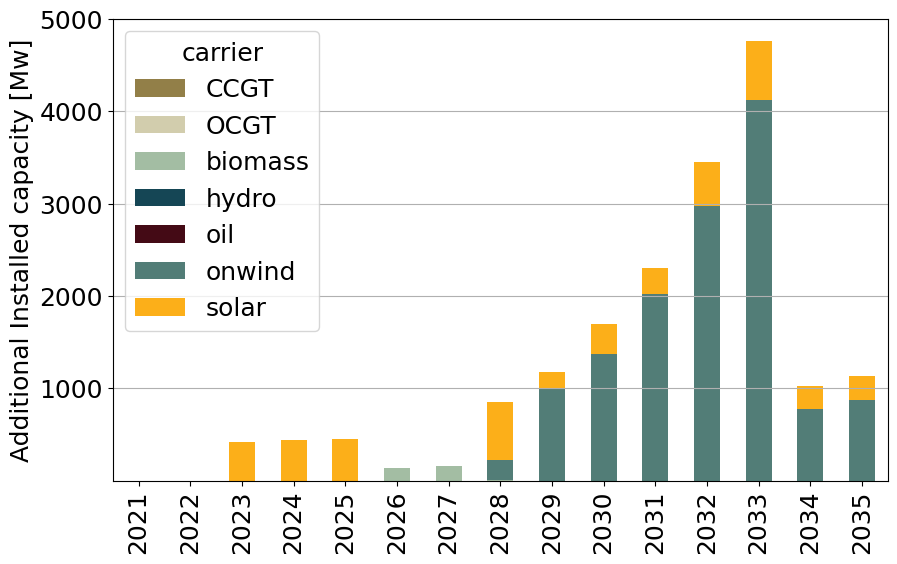

In [107]:
grouped_cap_change_RCB.plot.bar(stacked=True, figsize=(10, 6),color=carrier_colors)

# Add labels and title
plt.ylabel('Additional Installed capacity [Mw]')
plt.xlabel('')
plt.xticks(range(len(grouped_cap_change_RC.index)), grouped_cap_change_RC.index, rotation=90)
plt.grid(axis = 'y',zorder = 0)

In [42]:
# Stores and links capacity change

data_agg=pd.DataFrame({})

for y in range(2021, 2036):
    net = pypsa.Network(data_path_RCB + f"RCB_{y}.nc")

    links = pd.DataFrame(net.links)[['carrier', 'p_nom_opt', 'p_nom']]
    stores = pd.DataFrame(net.stores)[['carrier', 'e_nom_opt', 'e_nom']]
    stores = stores.rename(columns={"e_nom": "p_nom", "e_nom_opt": "p_nom_opt"})
    caps_change = pd.concat([links, stores], ignore_index=True)
    caps_change['zubau'] = caps_change['p_nom_opt'] - caps_change['p_nom']
    caps_change['year'] = np.ones(len(caps_change['p_nom_opt']), dtype=int) * y
    
    data_agg = pd.concat([data_agg, caps_change[['year', 'carrier', 'zubau']]])

grouped_cap_stores_change_RCB = data_agg.groupby(['year', 'carrier']).sum().unstack()

grouped_cap_stores_change_RCB.columns = grouped_cap_stores_change_RCB.columns.droplevel(0)

grouped_cap_stores_change_RCB = grouped_cap_stores_change_RCB.clip(lower=0)
grouped_cap_stores_change_RCB

INFO:pypsa.io:Imported network RCB_2021.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network RCB_2022.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network RCB_2023.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network RCB_2024.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network RCB_2025.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network RCB_2026.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network RCB_2027.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported netw

carrier       battery  battery charger  battery discharger
year                                                      
2021     2.458812e-06         0.000002            0.000002
2022     1.610786e-06         0.000001            0.000001
2023     7.438200e-06         0.000006            0.000007
2024     2.449876e-05         0.000016            0.000018
2025     1.623186e-02         0.007203            0.008003
2026     9.191681e-03         0.002028            0.002254
2027     2.948167e-02         0.008189            0.009099
2028     8.999451e+02       191.649519          212.943910
2029     4.286624e-07         0.000052            0.000058
2030     0.000000e+00         3.562941            3.958823
2031     0.000000e+00        18.556249           20.618055
2032     0.000000e+00        22.360184           24.844648
2033     0.000000e+00        35.656048           39.617831
2034     0.000000e+00        10.854582           12.060647
2035     0.000000e+00         0.846652            0.940725

### RCB10

In [43]:
# generation capacity change

data_agg=pd.DataFrame({})
for y in range(2021,2036):
    net=pypsa.Network(data_path_RCB10 + f"RCB_10_{y}.nc")

    capacity=pd.DataFrame(net.generators.head(19))
    hydro=pd.DataFrame(net.storage_units)[["p_nom_opt","carrier","p_nom"]]
    caps=pd.concat([capacity[["p_nom_opt","carrier","p_nom"]],hydro],ignore_index=True)
    caps["zubau"]=caps["p_nom_opt"]-caps["p_nom"]
    caps["year"]=np.ones(len(caps["p_nom_opt"]),dtype=int)*y
    
    data_agg=pd.concat([data_agg,caps[["year","carrier","zubau"]]])
    
grouped_cap_change_RCB10 = data_agg.groupby(['year', 'carrier']).sum().unstack()  

grouped_cap_change_RCB10.columns = grouped_cap_change_RCB10.columns.droplevel(0)
grouped_cap_change_RCB10 = grouped_cap_change_RCB10.clip(lower=0)
grouped_cap_change_RCB10

# Storage

data_agg=pd.DataFrame({})

for y in range(2021, 2036):
    net = pypsa.Network(data_path_RCB10 + f"RCB_10_{y}.nc")

    links = pd.DataFrame(net.links)[['carrier', 'p_nom_opt', 'p_nom']]
    stores = pd.DataFrame(net.stores)[['carrier', 'e_nom_opt', 'e_nom']]
    stores = stores.rename(columns={"e_nom": "p_nom", "e_nom_opt": "p_nom_opt"})
    caps_change = pd.concat([links, stores], ignore_index=True)
    caps_change['zubau'] = caps_change['p_nom_opt'] - caps_change['p_nom']
    caps_change['year'] = np.ones(len(caps_change['p_nom_opt']), dtype=int) * y
    
    data_agg = pd.concat([data_agg, caps_change[['year', 'carrier', 'zubau']]])

grouped_cap_stores_change_RCB10 = data_agg.groupby(['year', 'carrier']).sum().unstack()

grouped_cap_stores_change_RCB10.columns = grouped_cap_stores_change_RCB10.columns.droplevel(0)

grouped_cap_stores_change_RCB10 = grouped_cap_stores_change_RCB10.clip(lower=0)
grouped_cap_stores_change_RCB10

INFO:pypsa.io:Imported network RCB_10_2021.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network RCB_10_2022.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network RCB_10_2023.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network RCB_10_2024.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network RCB_10_2025.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network RCB_10_2026.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network RCB_10_2027.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:p

carrier       battery  battery charger  battery discharger
year                                                      
2021     1.073207e-05         0.000007            0.000008
2022     1.425120e-06         0.000002            0.000002
2023     2.707733e-03         0.002261            0.002512
2024     1.835211e-03         0.001387            0.001541
2025     6.514644e-03         0.001951            0.002168
2026     1.143052e-02         0.002966            0.003296
2027     4.640748e-02         0.015969            0.017744
2028     7.997912e+02       179.054656          198.949617
2029     1.001399e+02        18.544333           20.604814
2030     1.729358e-06         0.000086            0.000096
2031     5.880494e-08         7.176447            7.973830
2032     0.000000e+00         6.343078            7.047864
2033     0.000000e+00        29.558224           32.842471
2034     0.000000e+00        33.407754           37.119727
2035     0.000000e+00         9.269795           10.299772

### RCB20

In [44]:
# generation capacity change

data_agg=pd.DataFrame({})
for y in range(2021,2036):
    net=pypsa.Network(data_path_RCB20 + f"RCB_20_{y}.nc")

    capacity=pd.DataFrame(net.generators.head(19))
    hydro=pd.DataFrame(net.storage_units)[["p_nom_opt","carrier","p_nom"]]
    caps=pd.concat([capacity[["p_nom_opt","carrier","p_nom"]],hydro],ignore_index=True)
    caps["zubau"]=caps["p_nom_opt"]-caps["p_nom"]
    caps["year"]=np.ones(len(caps["p_nom_opt"]),dtype=int)*y
    
    data_agg=pd.concat([data_agg,caps[["year","carrier","zubau"]]])
    
grouped_cap_change_RCB20 = data_agg.groupby(['year', 'carrier']).sum().unstack()  

grouped_cap_change_RCB20.columns = grouped_cap_change_RCB20.columns.droplevel(0)
grouped_cap_change_RCB20 = grouped_cap_change_RCB20.clip(lower=0)
grouped_cap_change_RCB20

# Storage

data_agg=pd.DataFrame({})

for y in range(2021, 2036):
    net = pypsa.Network(data_path_RCB20 + f"RCB_20_{y}.nc")

    links = pd.DataFrame(net.links)[['carrier', 'p_nom_opt', 'p_nom']]
    stores = pd.DataFrame(net.stores)[['carrier', 'e_nom_opt', 'e_nom']]
    stores = stores.rename(columns={"e_nom": "p_nom", "e_nom_opt": "p_nom_opt"})
    caps_change = pd.concat([links, stores], ignore_index=True)
    caps_change['zubau'] = caps_change['p_nom_opt'] - caps_change['p_nom']
    caps_change['year'] = np.ones(len(caps_change['p_nom_opt']), dtype=int) * y
    
    data_agg = pd.concat([data_agg, caps_change[['year', 'carrier', 'zubau']]])

grouped_cap_stores_change_RCB20 = data_agg.groupby(['year', 'carrier']).sum().unstack()

grouped_cap_stores_change_RCB20.columns = grouped_cap_stores_change_RCB20.columns.droplevel(0)

grouped_cap_stores_change_RCB20 = grouped_cap_stores_change_RCB20.clip(lower=0)
grouped_cap_stores_change_RCB20

INFO:pypsa.io:Imported network RCB_20_2021.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network RCB_20_2022.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network RCB_20_2023.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network RCB_20_2024.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network RCB_20_2025.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network RCB_20_2026.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network RCB_20_2027.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:p

carrier       battery  battery charger  battery discharger
year                                                      
2021     1.453921e-05         0.000010            0.000011
2022     2.136329e-06         0.000002            0.000002
2023     1.677460e-05         0.000016            0.000018
2024     8.713883e-06         0.000004            0.000004
2025     1.173937e-04         0.000071            0.000078
2026     1.245005e-02         0.004701            0.005224
2027     2.917315e-03         0.000580            0.000644
2028     2.444702e+02        65.141583           72.379536
2029     6.555143e+02       137.285167          152.539074
2030     6.599319e-07         0.000039            0.000044
2031     0.000000e+00        10.597949           11.775499
2032     0.000000e+00         5.752883            6.392092
2033     0.000000e+00         0.626866            0.696517
2034     0.000000e+00        23.695530           26.328367
2035     0.000000e+00        33.511237           37.234708

### combined capacity change

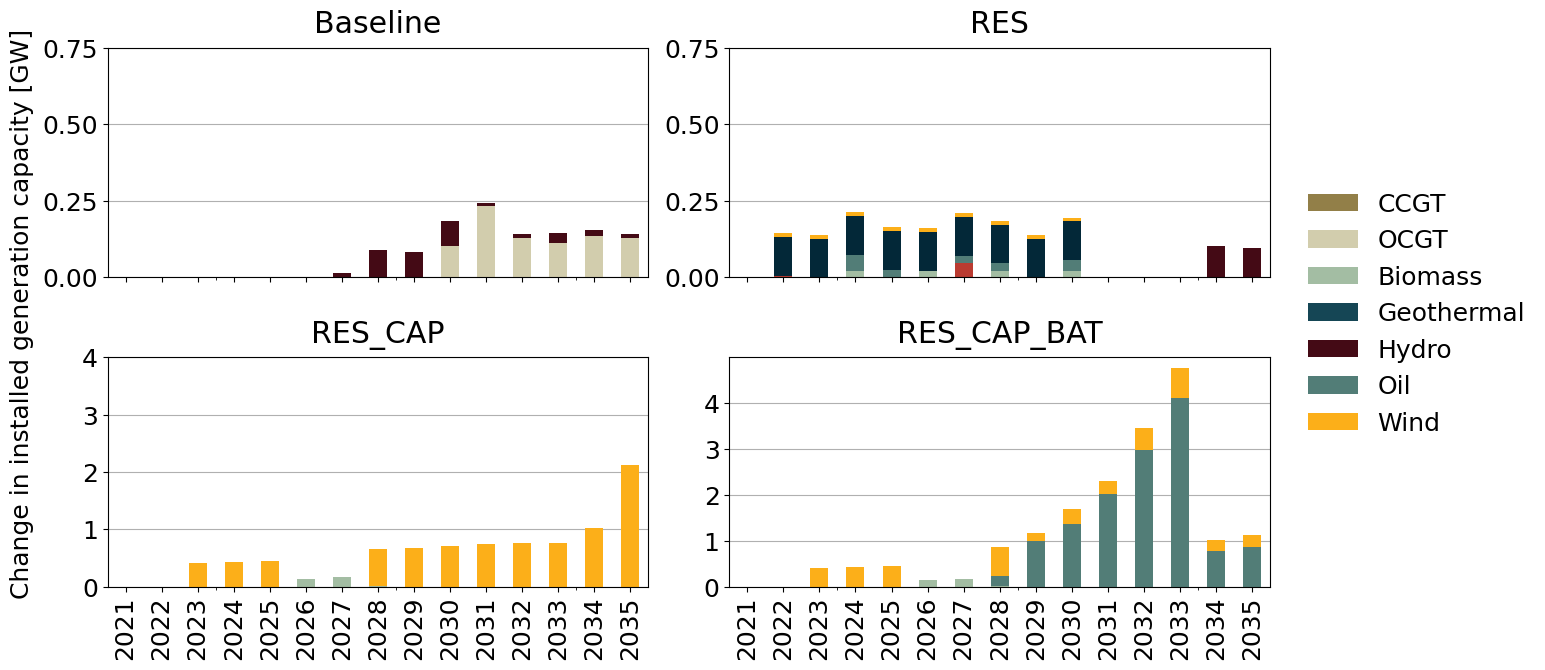

In [116]:
ticklabels= np.arange(2021,2036)

fig, axes = plt.subplots(2, 2, figsize=(20, 5), sharex=True, sharey=False)
# Create a stacked bar plot
bar1 = (grouped_cap_change_B/1000).plot.bar(ax=axes[0,0] ,stacked=True, color=carrier_colors, figsize=(15, 7),zorder=2) #
axes[0,0].grid(axis = 'y',zorder = 0)
axes[0, 0].legend().remove()
axes[0, 0].set_title('Baseline',y=1.03)
#axes[0, 0].set_xticklabels(ticklabels,rotation=0)
axes[0, 0].set_yticks(np.arange(0, 1, 0.25))

(grouped_cap_change_NS/1000).plot.bar(ax=axes[0,1] ,stacked=True, color=carrier_colors, figsize=(15, 7),zorder=2) #
axes[0,1].grid(axis = 'y',zorder = 0)
axes[0, 1].legend().remove()
axes[0, 1].set_title('RES',y=1.03)
axes[0, 1].set_yticks(np.arange(0, 1, 0.25))

(grouped_cap_change_RC/1000).plot.bar(ax=axes[1,0] ,stacked=True, color=carrier_colors, figsize=(15, 7),zorder=2) #
axes[1,0].grid(axis = 'y',zorder = 0)
axes[1, 0].legend().remove()
axes[1, 0].set_title('RES_CAP',y=1.03)
axes[1, 0].set_yticks(np.arange(0, 5, 1))
#axes[1, 0].set_xticklabels(ticklabels,rotation=0)
axes[1, 0].set_xlabel('')

(grouped_cap_change_RCB/1000).plot.bar(ax=axes[1,1] ,stacked=True, color=carrier_colors, figsize=(15, 7),zorder=2) #
axes[1,1].grid(axis = 'y',zorder = 0)
axes[1, 1].legend().remove()
axes[1, 1].set_title('RES_CAP_BAT',y=1.03)
axes[1, 1].set_yticks(np.arange(0, 5, 1))
#axes[1, 1].set_xticklabels(ticklabels,rotation=0)
axes[1, 1].set_xlabel('')

# Get the legend from any one of the subplots
handles, labels = bar1.get_legend_handles_labels()

# Create a common legend
fig.legend(handles, labels_custom, loc='center left', bbox_to_anchor=(0.91, 0.5), frameon=False) #, frameon=False
fig.text(0.06, 0.5,'Change in installed generation capacity [GW]', va='center', rotation='vertical', fontsize=18)
plt.subplots_adjust(hspace=0.35, wspace=0.15)


plt.savefig(scen_path + 'Capacity/Timeline/' +f'Scen_capacity_change_2021-2035.pdf', dpi=300, bbox_inches='tight')

## Battery capacity

In [32]:
n.stores

bus  carrier  e_cyclic  e_nom_extendable  capital_cost  \
Store                                                                           
BO 0 battery  BO 0 battery  battery      True              True  15877.883774   
BO 1 battery  BO 1 battery  battery      True              True  15877.883774   
BO 2 battery  BO 2 battery  battery      True              True  15877.883774   
BO 3 battery  BO 3 battery  battery      True              True  15877.883774   

              e_nom_max  e_nom  e_nom_min  marginal_cost  e_nom_opt  ...  \
Store                                                                ...   
BO 0 battery      225.0  225.0      225.0       0.009981      225.0  ...   
BO 1 battery      225.0  225.0      225.0       0.009761      225.0  ...   
BO 2 battery      225.0  225.0      225.0       0.009385      225.0  ...   
BO 3 battery      225.0  225.0      225.0       0.010844      225.0  ...   

             e_initial  e_initial_per_period  e_cyclic_per_period  p_set  \
Store                                                                      
BO 0 battery       0.0                 False                 True    0.0   
BO 1 battery       0.0                 False                 True    0.0   
BO 2 battery       0.0                 False                 True    0.0   
BO 3 battery       0.0                 False                 True    0.0   

              q_set  sign  marginal_cost_quadratic  standing_loss  build_year  \
Store                                                                           
BO 0 battery    0.0   1.0                      0.0            0.0           0   
BO 1 battery    0.0   1.0                      0.0            0.0           0   
BO 2 battery    0.0   1.0                      0.0            0.0           0   
BO 3 battery    0.0   1.0                      0.0            0.0           0   

              lifetime  
Store                   
BO 0 battery       inf  
BO 1 battery       inf  
BO 2 battery       inf  
BO 3 battery       inf  

[4 rows x 23 columns]

### Baseline

In [39]:
capacity_battery_list_B = {'Discharger':[],'Storage':[],'year':[]}
for y in range(2021,2036):
    net=pypsa.Network(data_path_B + f"B_{y}.nc")
    capacity_battery_list_B["year"].append(y)
    capacity_battery_list_B['Discharger'].append(net.links.groupby('carrier').p_nom.sum()['battery discharger'])
    capacity_battery_list_B['Storage'].append(net.stores.groupby('carrier').e_nom.sum()['battery'])

capacity_battery_list_B = pd.DataFrame(capacity_battery_list_B)
capacity_battery_list_B.set_index("year")

INFO:pypsa.io:Imported network B_2021.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network B_2022.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network B_2023.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network B_2024.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network B_2025.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network B_2026.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network B_2027.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network B_2028.nc 

Discharger   Storage
year                      
2021    0.000000  0.000000
2022    0.000012  0.000016
2023    0.000190  0.000199
2024    0.017138  0.017760
2025    0.021088  0.022237
2026    0.022355  0.023613
2027    0.026134  0.027280
2028    0.027714  0.036057
2029    0.035387  0.060676
2030    0.043863  0.083137
2031    0.052843  0.104375
2032    0.053603  0.105427
2033    0.055097  0.107055
2034    0.062093  0.123826
2035    0.071208  0.139600

In [38]:
capacity_battery_list_B

{'Discharger': [0.0,
  1.240836950981132e-05,
  0.00018992743538163745,
  0.01713825219671995,
  0.02108807069995572,
  0.022354654435994433,
  0.026134292822721693,
  0.027714499071479368,
  0.0353867825682929,
  0.04386281534392811,
  0.05284305800676902,
  0.05360279742749732,
  0.055097208968561504,
  0.06209284113426945,
  0.07120834876645223],
 'Storage': [0.0,
  1.6045821765276123e-05,
  0.00019871449798297791,
  0.01776014344255302,
  0.022237166465915552,
  0.02361321097494089,
  0.027280190993864827,
  0.03605691102284876,
  0.060676078665885355,
  0.0831368259421736,
  0.1043751029572858,
  0.10542666092129596,
  0.10705491463617746,
  0.12382556564817031,
  0.13960009477439705],
 'year': []}

### NS

In [40]:
capacity_battery_list_NS = {'Discharger':[],'Storage':[],'year':[]}

for y in range(2021,2036):
    net=pypsa.Network(data_path_NS + f"NS_{y}.nc")
    capacity_battery_list_NS["year"].append(y)
    capacity_battery_list_NS['Discharger'].append(net.links.groupby('carrier').p_nom.sum()['battery discharger'])
    capacity_battery_list_NS['Storage'].append(net.stores.groupby('carrier').e_nom.sum()['battery'])

capacity_battery_list_NS = pd.DataFrame(capacity_battery_list_NS)
capacity_battery_list_NS.set_index("year")
    


INFO:pypsa.io:Imported network NS_2021.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network NS_2022.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network NS_2023.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network NS_2024.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network NS_2025.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network NS_2026.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network NS_2027.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network NS_

Discharger   Storage
year                      
2021    0.000000  0.000000
2022    0.226299  0.214943
2023    0.462618  0.438010
2024    0.686153  0.652850
2025    0.909691  0.867704
2026    1.133234  1.082572
2027    1.359785  1.316615
2028    1.583998  1.531546
2029    1.812088  1.751826
2030    2.035673  1.966816
2031    2.259701  2.182222
2032    2.483234  2.397059
2033    2.708713  2.614914
2034    2.932333  2.932265
2035    3.155879  3.155862

### RES_CAP

In [95]:
capacity_battery_list_RC = {'Discharger':[],'Storage':[],'year':[]}

for y in range(2021,2036):
    net=pypsa.Network(data_path_RC + f"RC_{y}.nc")
    capacity_battery_list_RC["year"].append(y)
    capacity_battery_list_RC['Discharger'].append(net.links.groupby('carrier').p_nom.sum()['battery discharger'])
    capacity_battery_list_RC['Storage'].append(net.stores.groupby('carrier').e_nom.sum()['battery'])

capacity_battery_list_RC = pd.DataFrame(capacity_battery_list_RC)
capacity_battery_list_RC.set_index("year")
    


INFO:pypsa.io:Imported network RC_2021.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network RC_2022.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network RC_2023.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network RC_2024.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network RC_2025.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network RC_2026.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network RC_2027.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network RC_

Discharger       Storage
year                           
2021     0.000000      0.000000
2022     0.000017      0.000022
2023     0.000431      0.000546
2024     0.000688      0.000756
2025     0.010083      0.013782
2026     0.013686      0.029271
2027     0.019764      0.046814
2028     0.020281      0.055197
2029   329.645678   1572.622685
2030   719.401442   3641.333154
2031  1124.494259   5893.536484
2032  1527.100973   8279.354639
2033  1942.981852  10743.225089
2034  2339.155619  13097.853611
2035  2762.568688  15499.933295

### RC_ror

In [17]:
capacity_battery_list_RC_ror = {'Discharger':[],'Storage':[],'year':[]}

for y in range(2021,2036):
    net=pypsa.Network(data_path_RC_ror + f"RC_ror_{y}.nc")
    capacity_battery_list_RC_ror["year"].append(y)
    capacity_battery_list_RC_ror['Discharger'].append(net.links.groupby('carrier').p_nom.sum()['battery discharger'])
    capacity_battery_list_RC_ror['Storage'].append(net.stores.groupby('carrier').e_nom.sum()['battery'])

capacity_battery_list_RC_ror = pd.DataFrame(capacity_battery_list_RC_ror)
capacity_battery_list_RC_ror.set_index("year")
#indices = np.arange(2021,2036)
#series_battery_RC_ror = pd.Series(capacity_battery_list_RC_ror, index=indices)

INFO:pypsa.io:Imported network RC_ror_2021.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network RC_ror_2022.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network RC_ror_2023.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network RC_ror_2024.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network RC_ror_2025.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network RC_ror_2026.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network RC_ror_2027.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:p

Discharger      Storage
year                         
2021    0.000000     0.000000
2022    0.000652     0.000743
2023    0.000683     0.000760
2024    0.003966     0.004422
2025    0.004507     0.005926
2026    0.012064     0.025775
2027    0.028885     0.068933
2028    0.057412     0.163345
2029   81.425041   316.456834
2030   92.464638   382.087969
2031  108.475690   526.986913
2032  166.626484   843.692954
2033  232.696164  1225.356444
2034  326.718007  1724.536551
2035  510.573947  2479.158976

### RC-H2

In [220]:
capacity_battery_list_RC_H2 = {'Discharger':[],'Storage':[],'H2':[],'H2 fuel cell':[],'year':[]}

for y in range(2021,2036):
    net=pypsa.Network(data_path_RC_H2 + f"RC_H2_{y}.nc")
    capacity_battery_list_RC_H2["year"].append(y)
    capacity_battery_list_RC_H2['Discharger'].append(net.links.groupby('carrier').p_nom.sum()['battery discharger'])
    capacity_battery_list_RC_H2['Storage'].append(net.stores.groupby('carrier').e_nom.sum()['battery'])
    capacity_battery_list_RC_H2['H2'].append(net.stores.groupby('carrier').e_nom.sum()['H2'])
    capacity_battery_list_RC_H2['H2 fuel cell'].append(net.links.groupby('carrier').p_nom.sum()['H2 fuel cell'])

capacity_battery_list_RC_H2 = pd.DataFrame(capacity_battery_list_RC_H2)
capacity_battery_list_RC_H2.set_index("year")

INFO:pypsa.io:Imported network RC_H2_2021.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network RC_H2_2022.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network RC_H2_2023.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network RC_H2_2024.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network RC_H2_2025.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network RC_H2_2026.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network RC_H2_2027.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io

Discharger       Storage           H2  H2 fuel cell
year                                                      
2021     0.000000      0.000000     0.000000      0.000000
2022     0.004694      0.005558     0.106435      0.002732
2023     0.004706      0.005649     0.111264      0.003118
2024     0.009602      0.010491     0.156315      0.006299
2025     0.010046      0.011682     0.164601      0.006850
2026     0.017347      0.035857     0.180365      0.008028
2027     0.027609      0.066950     0.213143      0.008618
2028     0.039818      0.112251     0.264001      0.012156
2029   228.115276    958.054440  1041.390315     63.934825
2030   496.978653   2390.845454  2055.191481    131.572561
2031   869.373549   4359.271505  2558.093584    166.280103
2032  1234.097901   6343.250224  3187.141692    214.038821
2033  1597.250666   8367.241086  3814.328194    267.963586
2034  1963.701231  10432.444173  4296.167121    300.928077
2035  2312.987757  12468.721350  7424.606078    336.996034

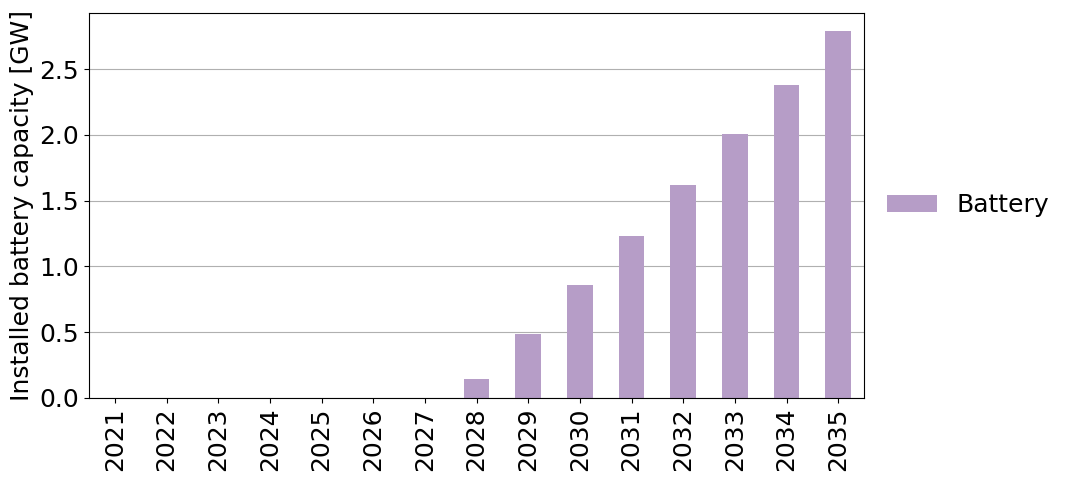

In [8]:
indices = np.arange(2021,2036)
series_battery_RC = pd.Series(capacity_battery_list_RC, index=indices)

(series_battery_RC/1000).plot.bar(stacked=True, figsize=(10, 5),color = purple3, zorder = 2,label = 'Battery')

# Add labels and title
plt.ylabel('Installed battery capacity [GW]')
plt.xlabel('')
#plt.xticks(range(len(grouped.index)), grouped.index, rotation=90)
plt.grid(axis = 'y',zorder = 0)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),frameon = False)

plt.savefig(scen_path + 'Battery/' + 'RES_CAP_installed_capacity_battery_2021-2035.pdf', dpi=300, bbox_inches='tight')
plt.savefig(scen_path + 'Battery/' + 'RES_CAP_installed_capacity_battery_2021-2035.png', dpi=300, bbox_inches='tight')

### RES_CAP_BAT

In [96]:
capacity_battery_list_RCB = {'Discharger':[],'Storage':[],'year':[]}

for y in range(2021,2036):
    net=pypsa.Network(data_path_RCB + f"RCB_{y}.nc")
    capacity_battery_list_RCB["year"].append(y)
    capacity_battery_list_RCB['Discharger'].append(net.links.groupby('carrier').p_nom.sum()['battery discharger'])
    capacity_battery_list_RCB['Storage'].append(net.stores.groupby('carrier').e_nom.sum()['battery'])

capacity_battery_list_RCB = pd.DataFrame(capacity_battery_list_RCB)
capacity_battery_list_RCB.set_index("year")

INFO:pypsa.io:Imported network RCB_2021.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network RCB_2022.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network RCB_2023.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network RCB_2024.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network RCB_2025.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network RCB_2026.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network RCB_2027.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported netw

Discharger     Storage
year                        
2021    0.000000    0.000000
2022    0.000002    0.000002
2023    0.000003    0.000004
2024    0.000010    0.000012
2025    0.000028    0.000036
2026    0.008031    0.016268
2027    0.010285    0.025460
2028    0.019384    0.054941
2029  212.963294  900.000000
2030  212.963352  900.000000
2031  216.922175  900.000000
2032  237.540230  900.000000
2033  262.384879  900.000000
2034  302.002709  900.000000
2035  314.063356  900.000000

In [46]:
capacity_battery_list_RC['Discharger']

0        0.000000
1        0.000017
2        0.000431
3        0.000688
4        0.010083
5        0.013686
6        0.019764
7        0.020281
8      329.645678
9      719.401442
10    1124.494259
11    1527.100973
12    1942.981852
13    2339.155619
14    2762.568688
Name: Discharger, dtype: float64

### combined battery capacity

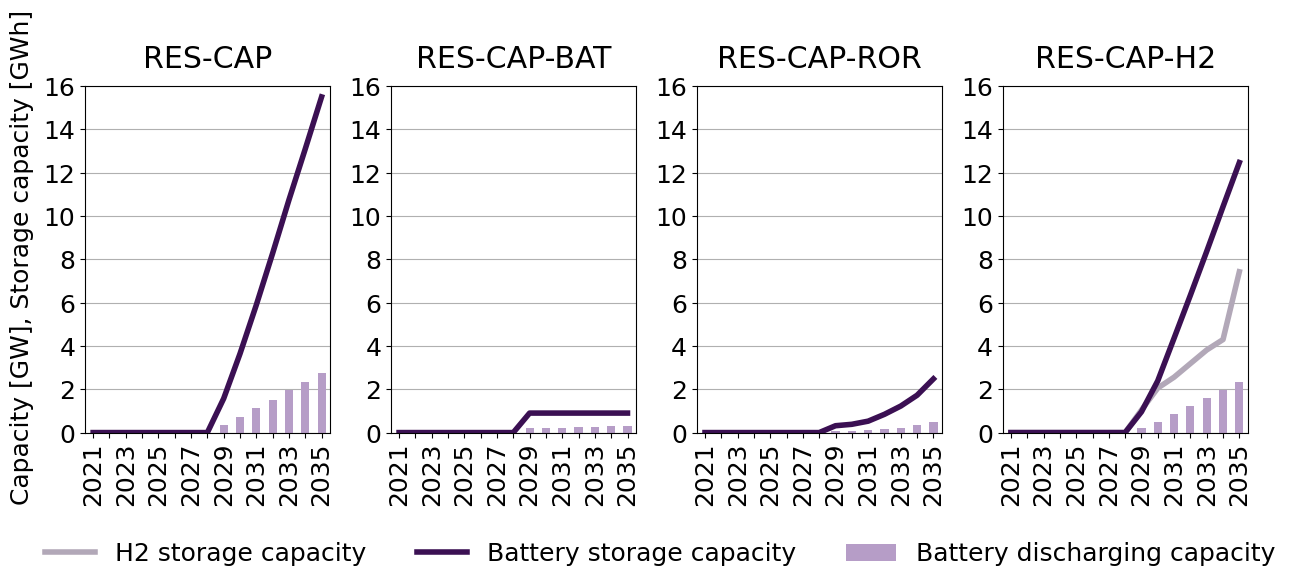

In [193]:
ticklabels= (2021,'',2023,'',2025,'',2027,'',2029,'',2031,'', 2033, '',2035)
indices = np.arange(0,15)
fig, axes = plt.subplots(1, 4, figsize=(25, 3), sharex=True, sharey=False)
# Create a stacked bar plot

# series_battery_B = pd.Series(capacity_battery_list_B['Discharger'], index=indices)
# (series_battery_B/1000).plot.bar(ax=axes[0,0],stacked=True, figsize=(15, 7),color = purple3, zorder = 2)
# axes[0,0].grid(axis = 'y',zorder = 0)
# axes[0, 0].legend().remove()
# axes[0, 0].set_title('Baseline',y=1.03)
# #axes[0, 0].set_xticklabels(ticklabels,rotation=0)
# axes[0, 0].set_yticks(np.arange(0, 4, 1))

# series_battery_R = pd.Series(capacity_battery_list_NS['Discharger'], index=indices)
# (series_battery_R/1000).plot.bar(ax=axes[0,1],stacked=True, figsize=(15, 7),color = purple3, zorder = 2)
# axes[0,1].grid(axis = 'y',zorder = 0)
# axes[0, 1].legend().remove()
# axes[0, 1].set_title('RES',y=1.03)
# axes[0, 1].set_yticks(np.arange(0, 4, 1))


series_battery_RC = pd.Series(capacity_battery_list_RC['Discharger'], index=indices)
(series_battery_RC/1000).plot.bar(ax=axes[0],stacked=True, figsize=(15, 4.5),color = purple3, zorder = 2)
(capacity_battery_list_RC['Storage']/1000).plot(ax=axes[0], color = purple1,linewidth=4, zorder = 2)
#axes[0].plot(indices,grouped_RC['solar'],color=yellow,linewidth=4,label='Solar')
#axes[0].plot(indices,grouped_RC['onwind'],color=teal3,linewidth=4,label='Wind')
axes[0].grid(axis = 'y',zorder = 0)
axes[0].legend().remove()
axes[0].set_title('RES-CAP',y=1.03)
axes[0].set_yticks(np.arange(0, 18, 2))
axes[0].set_xticklabels(ticklabels,rotation=90)
axes[0].set_xlabel('')
axes[0].set_ylim(0,16)

series_battery_RCB = pd.Series(capacity_battery_list_RCB['Discharger'], index=indices)
(series_battery_RCB/1000).plot.bar(ax=axes[1],stacked=True, figsize=(15, 4.5),color = purple3, zorder = 2)
(capacity_battery_list_RCB['Storage']/1000).plot(ax=axes[1], color = purple1,linewidth=4)
#axes[1].plot(indices,grouped_RCB['solar'],color=yellow,linewidth=4,label='Solar')
#axes[1].plot(indices,grouped_RCB['onwind'],color=teal3,linewidth=4,label='Wind')
axes[1].grid(axis = 'y',zorder = 0)
axes[1].legend().remove()
axes[1].set_title('RES-CAP-BAT',y=1.03)
axes[1].set_yticks(np.arange(0, 18, 2))
axes[1].set_xticklabels(ticklabels,rotation=90)
axes[1].set_xlabel('')


series_battery_RC_ror = pd.Series(capacity_battery_list_RC_ror['Discharger'], index=indices)
(series_battery_RC_ror/1000).plot.bar(ax=axes[2],stacked=True, figsize=(15, 4.5),color = purple3, zorder = 2)
(capacity_battery_list_RC_ror['Storage']/1000).plot(ax=axes[2], color = purple1,linewidth=4, zorder = 2)
#axes[2].plot(indices,grouped_RC_ror['solar'],color=yellow,linewidth=4,label='Solar')
#axes[2].plot(indices,grouped_RC_ror['onwind'],color=teal3,linewidth=4,label='Wind')
axes[2].grid(axis = 'y',zorder = 0)
axes[2].legend().remove()
axes[2].set_title('RES-CAP-ROR',y=1.03)
axes[2].set_yticks(np.arange(0, 18, 2))
axes[2].set_xticklabels(ticklabels,rotation=90)
axes[2].set_xlabel('')
axes[2].set_ylim(0,16)

series_battery_RC_H2 = pd.Series(capacity_battery_list_RC_H2['Discharger'], index=indices)
(capacity_battery_list_RC_H2['H2']/1000).plot(ax=axes[3],color = H2,linewidth=4, zorder = 2)
(series_battery_RC_H2/1000).plot.bar(ax=axes[3],stacked=True, figsize=(15, 4.5),color = purple3, zorder = 2)
(capacity_battery_list_RC_H2['Storage']/1000).plot(ax=axes[3], color = purple1,linewidth=4, zorder = 2)

#axes[2].plot(indices,grouped_RC_ror['solar'],color=yellow,linewidth=4,label='Solar')
#axes[2].plot(indices,grouped_RC_ror['onwind'],color=teal3,linewidth=4,label='Wind')
axes[3].grid(axis = 'y',zorder = 0)
axes[3].legend().remove()
axes[3].set_title('RES-CAP-H2',y=1.03)
axes[3].set_yticks(np.arange(0, 18, 2))
axes[3].set_xticklabels(ticklabels,rotation=90)
axes[3].set_xlabel('')
axes[3].set_ylim(0,16)

# Get the legend from any one of the subplots
#handles, labels = bar1.get_legend_handles_labels()

# Create a common legend
axes[3].legend(labels=['H2 storage capacity','Battery storage capacity', 'Battery discharging capacity'], 
               ncol = 3,loc='lower center', bbox_to_anchor=(-1.4, -0.45), frameon=False) #, frameon=False
fig.text(0.075, 0.5,'Capacity [GW], Storage capacity [GWh]', va='center', rotation='vertical', fontsize=18)
plt.subplots_adjust(hspace=2, wspace=0.25)


plt.savefig(scen_path + 'Battery/' +f'Scen_capacity_battery_extra.pdf', dpi=300, bbox_inches='tight')

In [70]:
capacity_battery_list_RC_H2['H2']

0        0.000000
1        0.001051
2        0.011856
3        0.018311
4        0.042279
5        0.176947
6        0.191061
7        0.243980
8        0.289240
9        0.349716
10       0.513847
11       1.298326
12     668.768194
13    2615.877185
14    4274.664043
Name: H2, dtype: float64

In [51]:
pd.Series(capacity_battery_list_RC['Discharger'],index=capacity_battery_list_RC['year'])

year
2021   NaN
2022   NaN
2023   NaN
2024   NaN
2025   NaN
2026   NaN
2027   NaN
2028   NaN
2029   NaN
2030   NaN
2031   NaN
2032   NaN
2033   NaN
2034   NaN
2035   NaN
Name: Discharger, dtype: float64

In [50]:
capacity_battery_list_RC['Discharger']

0        0.000000
1        0.000017
2        0.000431
3        0.000688
4        0.010083
5        0.013686
6        0.019764
7        0.020281
8      329.645678
9      719.401442
10    1124.494259
11    1527.100973
12    1942.981852
13    2339.155619
14    2762.568688
Name: Discharger, dtype: float64

In [48]:
series_battery_RC

2021   NaN
2022   NaN
2023   NaN
2024   NaN
2025   NaN
2026   NaN
2027   NaN
2028   NaN
2029   NaN
2030   NaN
2031   NaN
2032   NaN
2033   NaN
2034   NaN
2035   NaN
Name: Discharger, dtype: float64

### Battery vs solar capacity

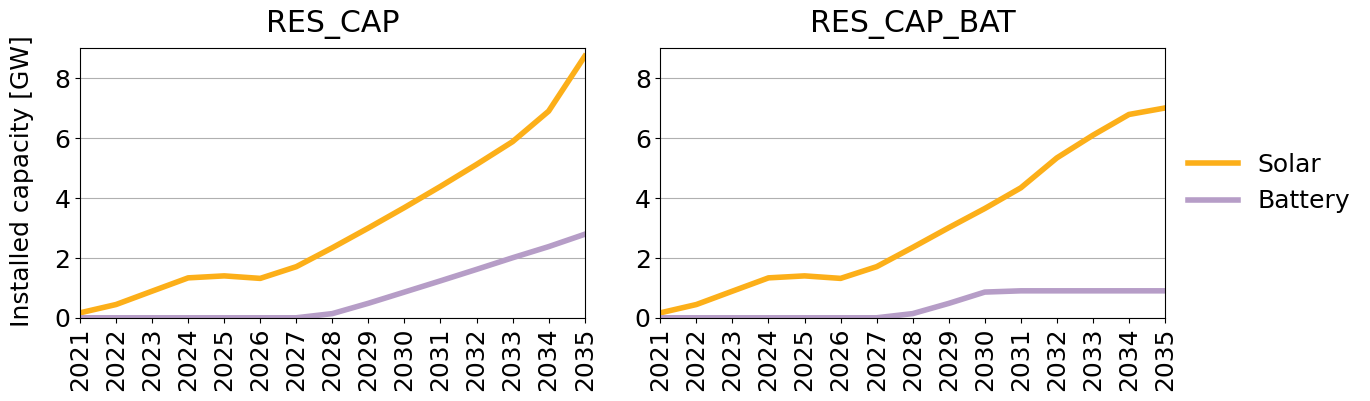

In [149]:
fig, axes = plt.subplots(1,2,figsize = (14,3.5))
(grouped_RC['solar']).plot(ax = axes[0],color=yellow,linewidth=4,label = 'Solar')
(series_battery_RC/1000).plot(label='Battery',ax = axes[0],color=purple3,linewidth=4)
axes[0].set_ylim(0,9)
axes[0].set_title('RES_CAP',y=1.03)
axes[0].set_xlabel('')
axes[0].set_xlim(2021,2035)
axes[0].set_xticks(ticks = range(2021,2036), labels = indices, rotation=90)
axes[0].grid(axis = 'y')


(grouped_RCB['solar']).plot(ax = axes[1],color=yellow,linewidth=4,label='Solar')
(series_battery_RCB/1000).plot(label='Battery',ax = axes[1],color=purple3,linewidth=4)
axes[1].set_ylim(0,9)
axes[1].set_title('RES_CAP_BAT',y=1.03)
axes[1].set_xlabel('')
axes[1].set_xlim(2021,2035)
axes[1].set_xticks(ticks = range(2021,2036), labels = indices, rotation=90)
axes[1].grid(axis = 'y')

fig.text(0.075, 0.5,'Installed capacity [GW]', va='center', rotation='vertical', fontsize=18)
plt.subplots_adjust(hspace=0.37, wspace=0.15)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),frameon = False)
plt.savefig(scen_path + 'Battery/' +f'Scen_solar_vs_battery_2021-2035.pdf', dpi=300, bbox_inches='tight')


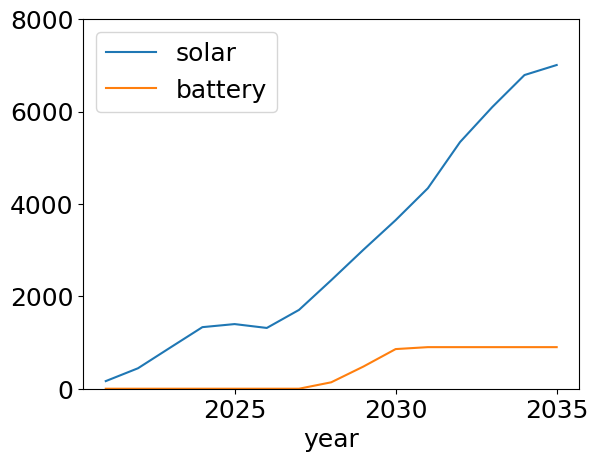

In [115]:

plt.ylim(0,8000)
plt.legend()

In [99]:
series_battery_RC

2021       0.000000
2022       0.000018
2023       0.000259
2024       0.000032
2025       0.008114
2026       0.011959
2027       0.002704
2028     139.053120
2029     484.047201
2030     858.099284
2031    1233.482796
2032    1615.430681
2033    2004.046653
2034    2375.889002
2035    2788.077063
dtype: float64

In [354]:
series_battery_B.index

Int64Index([2021, 2022, 2023, 2024, 2025, 2026, 2027, 2028, 2029, 2030, 2031,
            2032, 2033, 2034, 2035],
           dtype='int64')

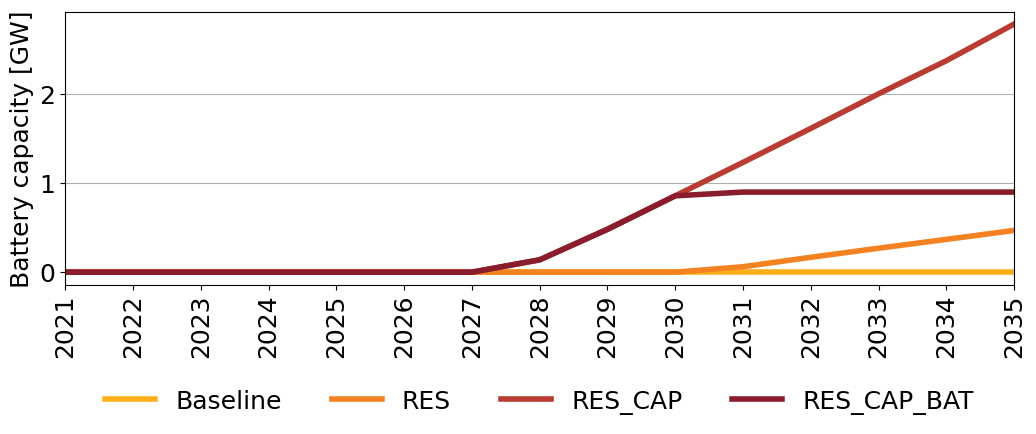

In [359]:
import matplotlib.pyplot as plt
import numpy as np

# Define the colors for each scenario
colors = [yellow, orange, red2, red1]

# Create the figure and axes
fig, ax = plt.subplots(figsize=(11, 5))

# Iterate over each scenario and plot the line for each year
for i, series in enumerate([series_battery_B, series_battery_R, series_battery_RC, series_battery_RCB]):
    ax.plot(range(0,15), series / 1000, color=colors[i], linewidth=4)

# Set the x-ticks and labels
ax.set_xticks(np.arange(0,15))
ax.set_xticklabels(indices,rotation = 90)

ax.set_xlim(0,14)

# Add gridlines
ax.grid(axis='y', zorder=0)

# Set the title and ylabel
#ax.set_title('Battery Capacity by Scenario', y=1.03)
ax.set_ylabel('Battery capacity [GW]')

# Create the legend
labels = ['Baseline', 'RES', 'RES_CAP', 'RES_CAP_BAT']

plt.legend(labels,loc='upper center', bbox_to_anchor=(0.5, -0.3), ncol=4, frameon=False)

plt.tight_layout()
plt.savefig(scen_path + 'Battery/' + 'Scen_capacity_battery_2021-2035_one_plot.pdf', dpi=300)
plt.show()


## Objective Value

### Data import

In [108]:
objective_value_list_B = []
for y in range(2021,2036):
    net=pypsa.Network(data_path_B + f"B_{y}.nc")
    objective_value_list_B.append(net.objective)

objective_value_list_NS = []
for y in range(2021,2036):
    net=pypsa.Network(data_path_NS + f"NS_{y}.nc")
    objective_value_list_NS.append(net.objective)


objective_value_list_RC = []
for y in range(2021,2036):
    net=pypsa.Network(data_path_RC + f"RC_{y}.nc")
    objective_value_list_RC.append(net.objective)



objective_value_list_RC10 = []
for y in range(2021,2036):
    net=pypsa.Network(data_path_RC10 + f"RC_10_{y}.nc")
    objective_value_list_RC10.append(net.objective)

objective_value_list_RC20 = []
for y in range(2021,2036):
    net=pypsa.Network(data_path_RC20 + f"RC_20_{y}.nc")
    objective_value_list_RC20.append(net.objective)



objective_value_list_RCB = []
for y in range(2021,2036):
    net=pypsa.Network(data_path_RCB + f"RCB_{y}.nc")
    objective_value_list_RCB.append(net.objective)

objective_value_list_RCB10 = []
for y in range(2021,2036):
    net=pypsa.Network(data_path_RCB10 + f"RCB_10_{y}.nc")
    objective_value_list_RCB10.append(net.objective)


objective_value_list_RCB20 = []
for y in range(2021,2036):
    net=pypsa.Network(data_path_RCB20 + f"RCB_20_{y}.nc")
    objective_value_list_RCB20.append(net.objective)

INFO:pypsa.io:Imported network B_2021.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network B_2022.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network B_2023.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network B_2024.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network B_2025.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network B_2026.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network B_2027.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network B_2028.nc 

In [182]:
objective_value_list_RC_H2 = []
for y in range(2021,2036):
    net=pypsa.Network(data_path_RC_H2 + f"RC_H2_{y}.nc")
    objective_value_list_RC_H2.append(net.objective)

INFO:pypsa.io:Imported network RC_H2_2021.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network RC_H2_2022.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network RC_H2_2023.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network RC_H2_2024.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network RC_H2_2025.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network RC_H2_2026.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network RC_H2_2027.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io

In [127]:
objective_value_list_RC_ror = []
for y in range(2021,2036):
    net=pypsa.Network(data_path_RC_ror + f"RC_ror_{y}.nc")
    objective_value_list_RC_ror.append(net.objective)

INFO:pypsa.io:Imported network RC_ror_2021.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network RC_ror_2022.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network RC_ror_2023.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network RC_ror_2024.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network RC_ror_2025.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network RC_ror_2026.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network RC_ror_2027.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:p

### combined objective value plot

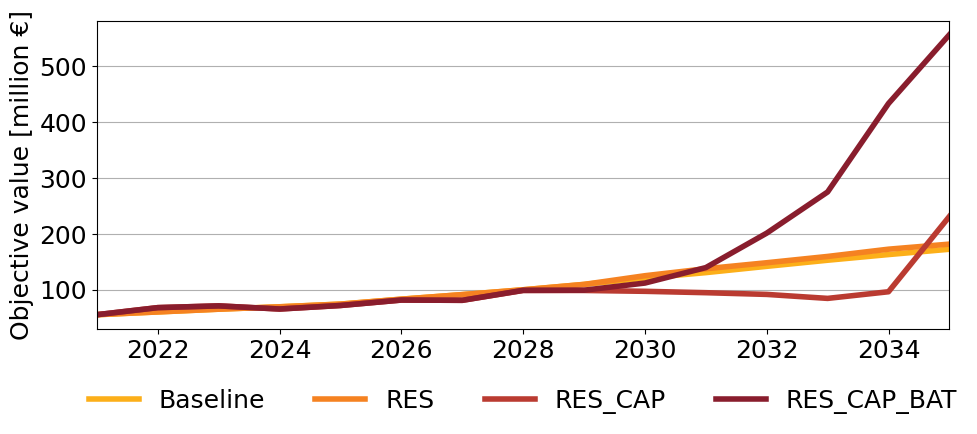

In [146]:
# data preparation
indices = np.arange(2021,2036)
objective_value_B= pd.Series(objective_value_list_B, index=indices)
objective_value_R= pd.Series(objective_value_list_R, index=indices)
objective_value_RC= pd.Series(objective_value_list_RC, index=indices)
objective_value_RCB= pd.Series(objective_value_list_RCB, index=indices)




(objective_value_B/1000000).plot(figsize=(11, 4),color = yellow, linewidth = 4, zorder = 2, label = 'Baseline')
(objective_value_R/1000000).plot(figsize=(11, 4),color = orange, linewidth = 4, zorder = 2, label = 'RES')
(objective_value_RC/1000000).plot(figsize=(11, 4),color = red2, linewidth = 4, zorder = 2, label = 'RES_CAP')
(objective_value_RCB/1000000).plot(figsize=(11, 4),color = red1, linewidth= 4, zorder = 2, label = 'RES_CAP_BAT')

plt.ylabel('Objective value [million €]',fontsize = 18)
plt.grid(axis='y')
plt.xlim(2021,2035)
plt.legend(frameon = False, loc='lower center', bbox_to_anchor=(0.5, -0.35), ncol=4)

plt.savefig(scen_path +f'Scen_obj_value_development.pdf', dpi=300, bbox_inches='tight')


In [372]:
display(objective_value_B[2035])
display(objective_value_R[2035])
display(objective_value_RC[2035])
display(objective_value_RCB[2035])

172428608.00084618

181609384.09763798

230275280.584265

556308603.0786958

### Objective vs demand curve

In [81]:
data = [9455.0, 9829.0, 10197.0, 10504.0, 10812.0, 11373.0, 11879.0, 12407.0, 12959.0, 13535.0, 14137.0, 14765.0, 15356.0, 15970.0, 16609.0]
years = range(2021, 2036)
demand = pd.Series(data, index=years)
demand.sum()

189787.0

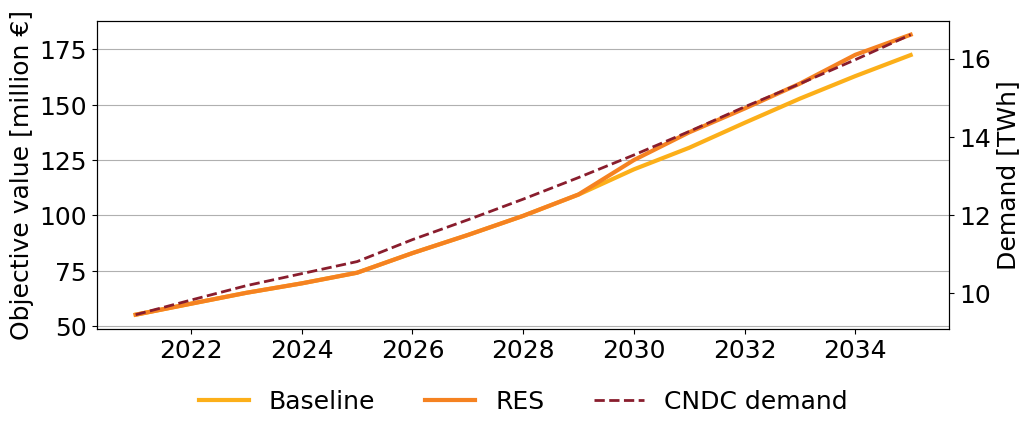

In [131]:
fig, ax1 = plt.subplots(figsize=(11, 4))

# Plot the first data on the left y-axis
(objective_value_B/1000000).plot(ax=ax1, color=yellow, linewidth=3, zorder=3, label='Baseline')
(objective_value_R/1000000).plot(ax=ax1, color=orange, linewidth=3, zorder=3, label='RES')
ax1.set_ylabel('Objective value [million €]')

# Create a second y-axis on the right side
ax2 = ax1.twinx()

# Plot the second data on the right y-axis
(demand/1000).plot(ax=ax2, color=red1, linewidth=2, linestyle='dashed', label="CNDC demand", zorder=1)
ax2.set_ylabel('Demand [TWh]')

# Combine the legends from both axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, frameon=False, loc='lower center', bbox_to_anchor=(0.5, -0.35), ncol=4)

ax1.grid(axis = 'y', zorder = 0)

plt.savefig(scen_path +f'Objective_value_vs_demand.pdf', dpi=300, bbox_inches='tight')


In [100]:
values.length

AttributeError: 'Series' object has no attribute 'length'

In [102]:


# Print the series
print(series)
series

2021     9455.0
2022     9829.0
2023    10197.0
2024    10504.0
2025    10812.0
2026    11373.0
2027    11879.0
2028    12407.0
2029    12959.0
2030    13535.0
2031    14137.0
2032    14765.0
2033    15356.0
2034    15970.0
2035    16609.0
dtype: float64


2021     9455.0
2022     9829.0
2023    10197.0
2024    10504.0
2025    10812.0
2026    11373.0
2027    11879.0
2028    12407.0
2029    12959.0
2030    13535.0
2031    14137.0
2032    14765.0
2033    15356.0
2034    15970.0
2035    16609.0
dtype: float64

### Cummulative objective value

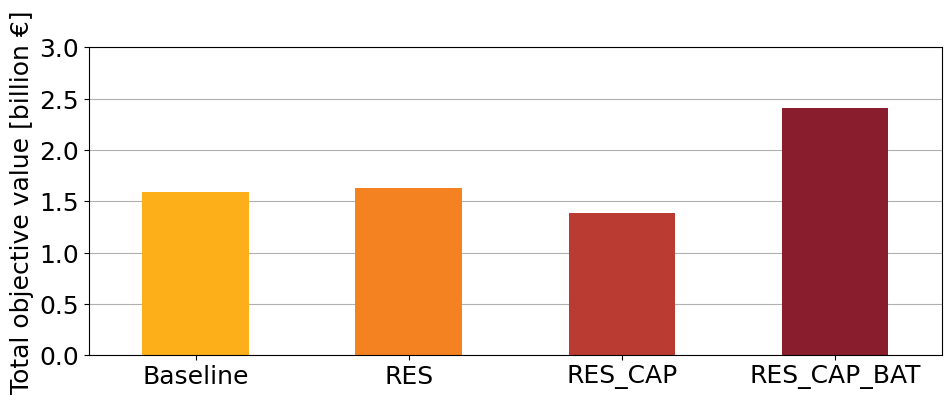

In [104]:
data = [objective_value_B.sum()/1000000000, objective_value_R.sum()/1000000000,
        objective_value_RC.sum()/1000000000,objective_value_RCB.sum()/1000000000] # ROR: 830.94
index = scen_list

obj_value = pd.Series(data,index, name='Objective value')


obj_value.plot.bar(color=scen_colors, figsize = (11,4), zorder = 2)
plt.ylabel('Total objective value [billion €]')
plt.xticks(rotation = 0)
plt.grid(axis = 'y',zorder = 0)
plt.ylim(0,3)

plt.savefig(scen_path +f'Scen_obj_value.pdf', dpi=300, bbox_inches='tight')

In [60]:
display(obj_value)

Baseline       1.588473
RES            1.631721
RES_CAP        1.374638
RES_CAP_BAT    2.401442
Name: Objective value, dtype: float64

In [42]:
objective_value_list_B

[55174952.87999371,
 60138421.438771605,
 65065299.86708179,
 69325286.151261,
 74130516.19232708,
 82985807.66844702,
 91163356.00439245,
 99800426.72700647,
 109408342.97988299,
 120803641.52513313,
 130561443.8922664,
 141815807.39344504,
 152755463.02285904,
 162915350.54352707,
 172428608.00084618]

## Generation

### Baseline

In [16]:
first_date = "2013-01-01"
second_date = "2014-01-01"
data={"CCGT":[],"OCGT":[],"oil":[],"onwind":[],"solar":[],"biomass":[],"hydro":[],"year":[],'demand':[]}
battery_Bp = {'battery':[],"year":[]}
battery_Bn = {'battery':[],"year":[]}
for y in range(2021,2036):
    path= data_path_B + f"B_{y}.nc"
    n = pypsa.Network(path)
    data["year"].append(y)
    battery_Bp["year"].append(y)
    battery_Bn["year"].append(y)

    CCGT = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["CCGT"]
    data["CCGT"].append(CCGT.sum())

    OCGT = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["OCGT"]
    data["OCGT"].append(OCGT.sum())

    Oil = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["oil"]
    data["oil"].append(Oil.sum())

    Onwind = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["onwind"]
    data["onwind"].append(Onwind.sum())

    solar = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["solar"]
    data["solar"].append(solar.sum())

    biomass = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["biomass"]
    data["biomass"].append(biomass.sum())

    Hydro = n.storage_units_t.p_dispatch[first_date:second_date].sum(axis=1)
    data["hydro"].append(Hydro.sum())

    
    battery = n.stores_t.p.loc[first_date:second_date].groupby(n.stores.carrier, axis=1).sum()["battery"]
    i=0
    nbattery = []
    pbattery =[]
    for i in battery:
        if i < 0:
            nbattery.append(i)
        else:
            nbattery.append(0) 
    for i in battery:
        if i > 0:
            pbattery.append(i)
        else:
            pbattery.append(0) 


    # data["battery"].append(sum(pbattery))
    battery_Bp["battery"].append(sum(pbattery))
    battery_Bn["battery"].append(sum(nbattery))

    demand = n.loads_t.p_set.loc[first_date:second_date].sum(axis=1)*-1
    data["demand"].append(demand.sum())

df_B=pd.DataFrame(data)
df_B.set_index("year")

INFO:pypsa.io:Imported network B_2021.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network B_2022.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network B_2023.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network B_2024.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network B_2025.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network B_2026.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network B_2027.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network B_2028.nc 

CCGT          OCGT           oil         onwind          solar  \
year                                                                           
2021  5.238367e+06  1.922275e-01      0.002437  146653.410437  288537.902085   
2022  5.612369e+06  1.500583e+00      0.019040  146653.362051  288537.884245   
2023  5.980372e+06  1.464757e+00      0.018899  146653.372322  288537.885621   
2024  6.287293e+06  1.131901e+02      1.815797  146650.938757  288536.465667   
2025  6.593777e+06  1.631391e+03      1.726117  146650.322690  288537.049311   
2026  7.145781e+06  1.060754e+04     44.043890  146650.596749  288538.159635   
2027  7.643779e+06  1.748531e+04   1120.426026  146652.337084  288541.268181   
2028  8.172915e+06  1.634529e+04   1087.989271  146653.363462  288543.518276   
2029  8.723142e+06  1.815887e+04   1060.417565  146651.177311  288544.204444   
2030  9.266110e+06  5.119562e+04   1035.276725  146652.627892  288548.746847   
2031  9.794411e+06  1.249345e+05   1005.501635  146652.837895  288552.937925   
2032  1.029750e+07  2.610088e+05    979.522199  146653.094418  288576.893358   
2033  1.070483e+07  4.398068e+05   5085.882934  146655.583769  288584.991898   
2034  1.101155e+07  7.274981e+05  24634.909685  146657.481664  288590.234060   
2035  1.121532e+07  1.161577e+06  25784.486804  146655.705235  288592.211470   

            biomass         hydro        demand  
year                                             
2021  574480.792847  3.207036e+06 -9.455076e+06  
2022  574480.747869  3.207036e+06 -9.829079e+06  
2023  574480.749037  3.207036e+06 -1.019708e+07  
2024  574477.592570  3.207029e+06 -1.050408e+07  
2025  574478.896708  3.207028e+06 -1.081209e+07  
2026  574480.859108  3.207027e+06 -1.137309e+07  
2027  574487.081593  3.207031e+06 -1.187909e+07  
2028  574496.597613  3.207032e+06 -1.240710e+07  
2029  574494.869043  3.207028e+06 -1.295910e+07  
2030  574509.144902  3.207030e+06 -1.353511e+07  
2031  574510.029201  3.207028e+06 -1.413711e+07  
2032  574512.194587  3.195858e+06 -1.476512e+07  
2033  574525.426783  3.195860e+06 -1.535612e+07  
2034  574536.238142  3.195863e+06 -1.597013e+07  
2035  574539.083698  3.195860e+06 -1.660913e+07

In [17]:


#df_B=pd.DataFrame(data)
#df_B.set_index("year")


# Create a stacked bar plot
df_B.plot.area(x="year",y=df_B.columns[:-1],stacked=True, figsize=(10, 6),color=carrier_colors, zorder = 2)

# Add labels and title
plt.ylabel('Power Mix?')
plt.xlabel('')
#plt.xticks(range(len(df["year"])), df["year"], rotation=90)
#plt.grid(axis = 'y',zorder = 0)

#plt.savefig(scen_path+ 'Generation/powermix_baseline_2021-2035.pdf', dpi=300, bbox_inches='tight')

KeyError: "['year'] not in index"

In [359]:
res_gen_2021 = df_B.drop(columns = ['CCGT','oil','OCGT','year']).loc[0].sum()

# RES share 2021
res_gen_2021/(9455*1000)*100


42.89670895447651

### NS

In [7]:
first_date = "2013-01-01"
second_date = "2014-01-01"
data={"CCGT":[],"OCGT":[],"oil":[],"onwind":[],"solar":[],"biomass":[],"hydro":[],"geothermal":[],"ror":[],"year":[],'demand':[]}
battery_Rp = {'battery':[],"year":[]}
battery_Rn = {'battery':[],"year":[]}

for y in range(2021,2036):
    path= data_path_NS + f"NS_{y}.nc"
    n = pypsa.Network(path)
    data["year"].append(y)
    battery_Rp["year"].append(y)
    battery_Rn["year"].append(y)

    CCGT = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["CCGT"]
    data["CCGT"].append(CCGT.sum())

    OCGT = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["OCGT"]
    data["OCGT"].append(OCGT.sum())

    Oil = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["oil"]
    data["oil"].append(Oil.sum())

    Onwind = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["onwind"]
    data["onwind"].append(Onwind.sum())

    solar = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["solar"]
    data["solar"].append(solar.sum())

    biomass = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["biomass"]
    data["biomass"].append(biomass.sum())

    geothermal = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["geothermal"]
    data["geothermal"].append(geothermal.sum())

    ror = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["ror"]
    data["ror"].append(ror.sum())

    #battery = n.stores_t.p.loc[first_date:second_date].groupby(n.stores.carrier, axis=1).sum()["battery"]
    #data["battery"].append(battery.sum())

    Hydro = n.storage_units_t.p_dispatch[first_date:second_date].sum(axis=1)
    data["hydro"].append(Hydro.sum())

    battery = n.stores_t.p.loc[first_date:second_date].groupby(n.stores.carrier, axis=1).sum()["battery"]
    i=0
    nbattery = []
    pbattery =[]
    for i in battery:
        if i < 0:
            nbattery.append(i)
        else:
            nbattery.append(0) 
    for i in battery:
        if i > 0:
            pbattery.append(i)
        else:
            pbattery.append(0) 


    # data["battery"].append(sum(pbattery))
    battery_Rp["battery"].append(sum(pbattery))
    battery_Rn["battery"].append(sum(nbattery))

    demand = n.loads_t.p_set.loc[first_date:second_date].sum(axis=1)*-1
    data["demand"].append(demand.sum())

df_NS=pd.DataFrame(data)
df_NS.set_index("year")

INFO:pypsa.io:Imported network NS_2021.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network NS_2022.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network NS_2023.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network NS_2024.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network NS_2025.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network NS_2026.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network NS_2027.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network NS_

CCGT           OCGT           oil         onwind          solar  \
year                                                                            
2021  5.390903e+06   19503.884099      0.438237  146652.887025  288537.833152   
2022  5.150971e+06   14882.878577      0.229883  146652.799249  311426.638168   
2023  4.946941e+06   12351.940582      0.002287  146653.412551  334082.324618   
2024  4.484208e+06    5500.686476      0.001084  216019.999488  356971.292194   
2025  4.188443e+06    3320.697529      0.001356  247431.281928  379626.747059   
2026  4.041685e+06    3881.690029      0.509987  247430.396383  402515.415826   
2027  3.548895e+06    1243.123036      0.025179  280151.258994  425171.129445   
2028  3.337798e+06    1240.752628      0.479029  312870.667123  448059.911813   
2029  3.314650e+06    2421.864632      0.016996  312871.420436  470715.577908   
2030  3.141523e+06    2779.197861      0.125004  358679.038437  493604.462326   
2031  3.727258e+06   14715.275556      0.000381  358679.579907  493604.557920   
2032  4.334081e+06   45849.198284      0.376150  358678.844111  493604.330478   
2033  4.867382e+06  101095.743006   1571.331762  358679.422305  493604.504136   
2034  5.380439e+06  189624.937414  13825.582721  358679.542754  493604.542046   
2035  5.870796e+06  310339.704653  41774.666415  358679.546813  493604.567299   

            biomass         hydro     geothermal           ror        demand  
year                                                                          
2021  413625.509070  3.195866e+06       0.206858  2.257799e-01 -9.455076e+06  
2022  413625.298806  3.195866e+06   43799.449937  5.518797e+05 -9.829079e+06  
2023  413626.168988  3.195867e+06   43799.996278  1.103760e+06 -1.019708e+07  
2024  546077.372263  3.195867e+06   43799.997639  1.655640e+06 -1.050408e+07  
2025  546077.371286  3.195867e+06   43799.997413  2.207520e+06 -1.081209e+07  
2026  678527.694069  3.195865e+06   43800.202625  2.759398e+06 -1.137309e+07  
2027  678490.718208  3.195867e+06  437999.917457  3.311280e+06 -1.187909e+07  
2028  810143.917517  3.195865e+06  437999.375984  3.863159e+06 -1.240710e+07  
2029  809544.969392  3.195867e+06  437999.972957  4.415040e+06 -1.295910e+07  
2030  937887.820453  3.195866e+06  437999.752647  4.966794e+06 -1.353511e+07  
2031  942076.465913  3.195867e+06  437999.999223  4.966920e+06 -1.413711e+07  
2032  943304.237941  3.184696e+06  437999.494893  4.966919e+06 -1.476512e+07  
2033  943430.795577  3.184698e+06  437999.870142  4.966920e+06 -1.535612e+07  
2034  943430.928864  3.184698e+06  437999.963923  4.966920e+06 -1.597013e+07  
2035  943430.952617  3.184698e+06  437999.983365  4.966920e+06 -1.660913e+07

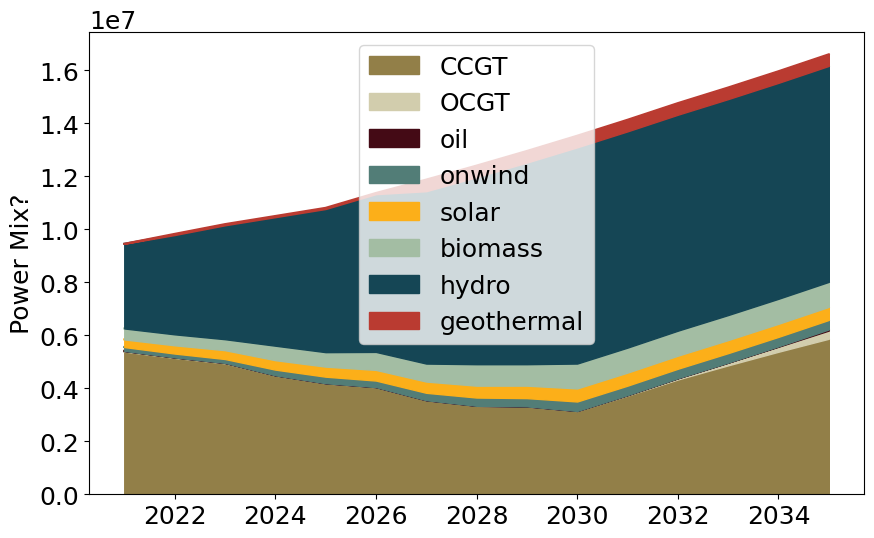

In [24]:
df_NS=pd.DataFrame(data)
df_NS.set_index("year")
df_NS['hydro'] = df_NS['hydro'] + df_NS['ror']
df_NS.drop('ror', axis=1, inplace=True)

# Create a stacked bar plot
df_NS.plot.area(x="year",y=df_NS.columns[:-1],stacked=True, figsize=(10, 6),color=carrier_colors, zorder = 2)

# Add labels and title
plt.ylabel('Power Mix?')
plt.xlabel('')
#plt.xticks(range(len(df["year"])), df["year"], rotation=90)
#plt.grid(axis = 'y',zorder = 0)

plt.savefig(scen_path+ 'Generation/powermix_NS_2021-2035.pdf', dpi=300, bbox_inches='tight')

In [54]:
df_NS['hydro'] = df_NS['hydro'] + df_NS['ror']
df_NS.drop('ror', axis=1, inplace=True)
df_NS


CCGT           OCGT           oil         onwind          solar  \
0   5.390934e+06   19463.935646      0.146310  146653.151334  288537.790947   
1   5.193200e+06   16444.204817      0.677303  146652.374958  311426.632358   
2   4.989354e+06   13798.572924      2.864871  146650.625598  334082.330607   
3   4.527374e+06    6173.490626      0.422980  216018.821560  356970.863610   
4   4.231768e+06    3795.869683      0.002582  247431.278055  379626.745749   
5   4.084993e+06    4355.466608      0.003517  247431.276930  402515.711775   
6   3.592347e+06    1613.390160      1.828886  280149.767109  425171.074766   
7   3.381160e+06    1476.305699      0.135108  312871.231240  448060.036137   
8   3.357849e+06    2805.708972      0.131101  312871.197133  470715.480730   
9   3.184272e+06    3143.377149      0.011191  358679.541320  493604.550410   
10  3.769770e+06   15813.729208      0.115465  358679.368966  493604.495619   
11  4.375344e+06   48338.090914      0.001077  358679.578234  493604.557302   
12  4.906378e+06  105561.788845   1783.361265  358679.025531  493604.732287   
13  5.416760e+06  196096.246345  14836.672760  358679.575724  493604.556750   
14  5.904283e+06  318447.292553  43989.208741  358679.439513  493604.492654   

          biomass         hydro     geothermal  year  
0   413625.685878  3.195866e+06       0.127282  2021  
1   413624.893937  3.747744e+06       0.424181  2022  
2   413622.702743  4.299617e+06       0.995117  2023  
3   546075.222206  4.851503e+06       0.421162  2024  
4   546077.353714  5.403387e+06       0.002605  2025  
5   678528.565418  5.955267e+06       0.003109  2026  
6   678505.497056  6.507139e+06  394198.530813  2027  
7   810311.688960  7.059026e+06  394199.820944  2028  
8   809765.809368  7.610906e+06  394199.855981  2029  
9   938539.099334  8.162690e+06  394199.979664  2030  
10  942269.027016  8.162786e+06  394199.919076  2031  
11  943335.123485  8.151618e+06  394199.997971  2032  
12  943430.567282  8.151615e+06  394200.803902  2033  
13  943430.970431  8.151618e+06  394199.997135  2034  
14  943430.811285  8.151617e+06  394199.867385  2035

### RES_CAP

In [8]:
first_date = "2013-01-01"
second_date = "2014-01-01"
data={"CCGT":[],"OCGT":[],"oil":[],"onwind":[],"solar":[],"biomass":[],"hydro":[],"year":[],'demand':[]}
battery_RCp = {'battery':[],"year":[]}
battery_RCn = {'battery':[],"year":[]}

for y in range(2021,2036):
    path= data_path_RC + f"RC_{y}.nc"
    n = pypsa.Network(path)
    data["year"].append(y)
    battery_RCp["year"].append(y)
    battery_RCn["year"].append(y)

    CCGT = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["CCGT"]
    data["CCGT"].append(CCGT.sum())

    OCGT = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["OCGT"]
    data["OCGT"].append(OCGT.sum())

    Oil = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["oil"]
    data["oil"].append(Oil.sum())

    Onwind = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["onwind"]
    data["onwind"].append(Onwind.sum())

    solar = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["solar"]
    data["solar"].append(solar.sum())

    biomass = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["biomass"]
    data["biomass"].append(biomass.sum())

    #battery = n.stores_t.p.loc[first_date:second_date].groupby(n.stores.carrier, axis=1).sum()["battery"]
    #data["battery"].append(battery.sum())

    Hydro = n.storage_units_t.p_dispatch[first_date:second_date].sum(axis=1)
    data["hydro"].append(Hydro.sum())

    battery = n.stores_t.p.loc[first_date:second_date].groupby(n.stores.carrier, axis=1).sum()["battery"]
    i=0
    nbattery = []
    pbattery =[]
    for i in battery:
        if i < 0:
            nbattery.append(i)
        else:
            nbattery.append(0) 
    for i in battery:
        if i > 0:
            pbattery.append(i)
        else:
            pbattery.append(0) 


    # data["battery"].append(sum(pbattery))
    battery_RCp["battery"].append(sum(pbattery))
    battery_RCn["battery"].append(sum(nbattery))

    demand = n.loads_t.p_set.loc[first_date:second_date].sum(axis=1)*-1
    data["demand"].append(demand.sum())

df_RC=pd.DataFrame(data)
df_RC.set_index("year")

INFO:pypsa.io:Imported network RC_2021.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network RC_2022.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network RC_2023.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network RC_2024.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network RC_2025.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network RC_2026.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network RC_2027.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network RC_

CCGT           OCGT          oil         onwind         solar  \
year                                                                          
2021  5.380214e+06   19008.049510     0.001613  146653.411784  2.885379e+05   
2022  5.727196e+06   46029.981050     0.044740  146653.271358  2.885379e+05   
2023  5.324024e+06   82044.287137  1433.419199  146653.355043  1.022193e+06   
2024  4.818431e+06  123095.642748  1627.327434  146652.578320  1.793499e+06   
2025  4.323601e+06  156006.319007  1628.056928  132132.496468  2.537651e+06   
2026  3.942194e+06  100442.328601  1632.477896  143614.646001  2.558471e+06   
2027  3.546633e+06   55918.473514  1636.830945  146559.491686  2.566494e+06   
2028  3.166976e+06    1148.871210     0.267937  143675.921757  3.689947e+06   
2029  2.715764e+06      34.420692     3.191342  142352.609610  4.869522e+06   
2030  2.263095e+06      57.113358     5.738415  139199.832901  6.090996e+06   
2031  1.810534e+06       6.205832     0.508349  138615.997023  7.340136e+06   
2032  1.357903e+06       2.454374     0.210963  139175.559996  8.615922e+06   
2033  9.052685e+05       1.859595     0.174604  142678.129595  9.842984e+06   
2034  4.526333e+05       1.572643     0.179908  143175.803561  1.132078e+07   
2035  0.000000e+00       0.000000     0.000000  140060.227252  1.357067e+07   

           biomass         hydro        demand  
year                                            
2021  4.136262e+05  3.207036e+06 -9.455076e+06  
2022  4.136257e+05  3.207036e+06 -9.829079e+06  
2023  4.136262e+05  3.207036e+06 -1.019708e+07  
2024  4.136280e+05  3.207034e+06 -1.050408e+07  
2025  4.542232e+05  3.206697e+06 -1.081209e+07  
2026  1.419627e+06  3.206950e+06 -1.137309e+07  
2027  2.354677e+06  3.207004e+06 -1.187909e+07  
2028  2.307310e+06  3.206848e+06 -1.240710e+07  
2029  2.281924e+06  3.204646e+06 -1.295910e+07  
2030  2.254267e+06  3.202902e+06 -1.353511e+07  
2031  2.232886e+06  3.200008e+06 -1.413711e+07  
2032  2.219078e+06  3.195162e+06 -1.476512e+07  
2033  2.204512e+06  3.195029e+06 -1.535612e+07  
2034  1.982005e+06  3.194530e+06 -1.597013e+07  
2035  1.070803e+06  3.194839e+06 -1.660913e+07

### RC10

In [79]:
first_date = "2013-01-01"
second_date = "2014-01-01"
data={"CCGT":[],"OCGT":[],"oil":[],"onwind":[],"solar":[],"biomass":[],"hydro":[],"year":[],'demand':[]}
battery_RC10p = {'battery':[],"year":[]}
battery_RC10n = {'battery':[],"year":[]}

for y in range(2021,2036):
    path= data_path_RC10 + f"RC_10_{y}.nc"
    n = pypsa.Network(path)
    data["year"].append(y)
    battery_RCp["year"].append(y)
    battery_RCn["year"].append(y)

    CCGT = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["CCGT"]
    data["CCGT"].append(CCGT.sum())

    OCGT = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["OCGT"]
    data["OCGT"].append(OCGT.sum())

    Oil = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["oil"]
    data["oil"].append(Oil.sum())

    Onwind = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["onwind"]
    data["onwind"].append(Onwind.sum())

    solar = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["solar"]
    data["solar"].append(solar.sum())

    biomass = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["biomass"]
    data["biomass"].append(biomass.sum())

    #battery = n.stores_t.p.loc[first_date:second_date].groupby(n.stores.carrier, axis=1).sum()["battery"]
    #data["battery"].append(battery.sum())

    Hydro = n.storage_units_t.p_dispatch[first_date:second_date].sum(axis=1)
    data["hydro"].append(Hydro.sum())

    battery = n.stores_t.p.loc[first_date:second_date].groupby(n.stores.carrier, axis=1).sum()["battery"]
    i=0
    nbattery = []
    pbattery =[]
    for i in battery:
        if i < 0:
            nbattery.append(i)
        else:
            nbattery.append(0) 
    for i in battery:
        if i > 0:
            pbattery.append(i)
        else:
            pbattery.append(0) 


    # data["battery"].append(sum(pbattery))
    battery_RC10p["battery"].append(sum(pbattery))
    battery_RC10n["battery"].append(sum(nbattery))

    demand = n.loads_t.p_set.loc[first_date:second_date].sum(axis=1)*-1
    data["demand"].append(demand.sum())

df_RC10=pd.DataFrame(data)
df_RC10.set_index("year")

INFO:pypsa.io:Imported network RC_10_2021.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network RC_10_2022.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network RC_10_2023.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network RC_10_2024.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network RC_10_2025.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network RC_10_2026.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network RC_10_2027.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io

CCGT           OCGT          oil         onwind         solar  \
year                                                                          
2021  5.380214e+06   19007.999059     0.000893  146653.414718  2.885379e+05   
2022  5.727117e+06   46137.041790     0.785256  146649.044053  2.885341e+05   
2023  5.413297e+06   83081.385261  1388.477875  146654.017353  9.319400e+05   
2024  4.952505e+06  124426.187775  1633.360101  146653.950816  1.658082e+06   
2025  4.484599e+06  171606.094534  1661.368002  139389.344663  2.420480e+06   
2026  4.125139e+06  134272.906983  1632.254921  143232.413727  2.561643e+06   
2027  3.777870e+06   87386.726494  1636.783314  146506.695284  2.569540e+06   
2028  3.471134e+06    9280.259508  1340.642025  146414.649693  3.263324e+06   
2029  3.077871e+06      35.316298     3.296408  142195.764870  4.427959e+06   
2030  2.670485e+06      45.266078     4.170989  140858.951120  5.592214e+06   
2031  2.263159e+06      13.069614     1.231531  136230.672666  6.782681e+06   
2032  1.855805e+06       0.836674     0.073176  138646.293308  8.001240e+06   
2033  1.448425e+06       6.195397     0.567882  142529.514267  9.167740e+06   
2034  1.041054e+06       5.824072     0.517115  143987.791996  1.035279e+07   
2035  6.336895e+05       0.229840     0.022677  143687.508278  1.168060e+07   

           biomass         hydro        demand  
year                                            
2021  4.136262e+05  3.207036e+06 -9.455076e+06  
2022  4.136195e+05  3.207027e+06 -9.829079e+06  
2023  4.136272e+05  3.207034e+06 -1.019708e+07  
2024  4.136288e+05  3.207034e+06 -1.050408e+07  
2025  3.873868e+05  3.206812e+06 -1.081209e+07  
2026  1.200085e+06  3.206927e+06 -1.137309e+07  
2027  2.089006e+06  3.206982e+06 -1.187909e+07  
2028  2.370105e+06  3.206947e+06 -1.240710e+07  
2029  2.291128e+06  3.206139e+06 -1.295910e+07  
2030  2.260421e+06  3.203619e+06 -1.353511e+07  
2031  2.238985e+06  3.204931e+06 -1.413711e+07  
2032  2.228604e+06  3.195330e+06 -1.476512e+07  
2033  2.220183e+06  3.194170e+06 -1.535612e+07  
2034  2.219589e+06  3.194460e+06 -1.597013e+07  
2035  2.110831e+06  3.195748e+06 -1.660913e+07

In [347]:
battery_RC10p

{'battery': [0.0006276158857559327,
  0.027146042008249254,
  0.17702069773982312,
  2.801906119548436,
  11.226914629919396,
  18.339589517204978,
  19.771148558628923,
  515349.6548937688,
  1207088.1572384825,
  1965003.1654118742,
  2766795.2315898547,
  3604528.7799767605,
  4419502.113140276,
  5310981.345388404,
  6781958.857781364],
 'year': []}

### RC20

In [80]:
first_date = "2013-01-01"
second_date = "2014-01-01"
data={"CCGT":[],"OCGT":[],"oil":[],"onwind":[],"solar":[],"biomass":[],"hydro":[],"year":[],'demand':[]}
battery_RC20p = {'battery':[],"year":[]}
battery_RC20n = {'battery':[],"year":[]}

for y in range(2021,2036):
    path= data_path_RC20 + f"RC_20_{y}.nc"
    n = pypsa.Network(path)
    data["year"].append(y)
    battery_RCp["year"].append(y)
    battery_RCn["year"].append(y)

    CCGT = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["CCGT"]
    data["CCGT"].append(CCGT.sum())

    OCGT = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["OCGT"]
    data["OCGT"].append(OCGT.sum())

    Oil = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["oil"]
    data["oil"].append(Oil.sum())

    Onwind = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["onwind"]
    data["onwind"].append(Onwind.sum())

    solar = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["solar"]
    data["solar"].append(solar.sum())

    biomass = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["biomass"]
    data["biomass"].append(biomass.sum())

    #battery = n.stores_t.p.loc[first_date:second_date].groupby(n.stores.carrier, axis=1).sum()["battery"]
    #data["battery"].append(battery.sum())

    Hydro = n.storage_units_t.p_dispatch[first_date:second_date].sum(axis=1)
    data["hydro"].append(Hydro.sum())

    battery = n.stores_t.p.loc[first_date:second_date].groupby(n.stores.carrier, axis=1).sum()["battery"]
    i=0
    nbattery = []
    pbattery =[]
    for i in battery:
        if i < 0:
            nbattery.append(i)
        else:
            nbattery.append(0) 
    for i in battery:
        if i > 0:
            pbattery.append(i)
        else:
            pbattery.append(0) 


    # data["battery"].append(sum(pbattery))
    battery_RC20p["battery"].append(sum(pbattery))
    battery_RC20n["battery"].append(sum(nbattery))

    demand = n.loads_t.p_set.loc[first_date:second_date].sum(axis=1)*-1
    data["demand"].append(demand.sum())

df_RC20=pd.DataFrame(data)
df_RC20.set_index("year")

INFO:pypsa.io:Imported network RC_20_2021.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network RC_20_2022.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network RC_20_2023.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network RC_20_2024.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network RC_20_2025.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network RC_20_2026.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network RC_20_2027.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io

CCGT           OCGT          oil         onwind         solar  \
year                                                                          
2021  5.380212e+06   19011.548113     0.052099  146653.191206  2.885376e+05   
2022  5.727186e+06   46043.910963     0.171486  146652.662015  2.885376e+05   
2023  5.502482e+06   84191.967882  1339.943170  146653.259652  8.416998e+05   
2024  5.086397e+06  125937.060172  1610.871595  146652.859691  1.522704e+06   
2025  4.662651e+06  173995.963033  1624.891920  146286.938236  2.212658e+06   
2026  4.292941e+06  179945.831920  1609.401809  137466.072291  2.650597e+06   
2027  3.990739e+06  133212.360062  1613.854422  145340.969497  2.662790e+06   
2028  3.724040e+06   58852.966701  1568.564882  146607.540157  2.883884e+06   
2029  3.435902e+06    3154.813769    49.626622  142099.719840  3.994727e+06   
2030  3.077882e+06      27.750658     2.476971  140951.792591  5.093332e+06   
2031  2.715776e+06      26.358924     2.489140  139008.967309  6.231429e+06   
2032  2.353705e+06       0.246873     0.021646  137818.219932  7.392413e+06   
2033  1.991596e+06       0.438605     0.038233  141602.342175  8.496605e+06   
2034  1.629486e+06       1.334732     0.117110  143752.933181  9.627867e+06   
2035  1.267378e+06       1.029620     0.091280  144271.117544  1.077369e+07   

           biomass         hydro        demand  
year                                            
2021  4.136260e+05  3.207036e+06 -9.455076e+06  
2022  4.136253e+05  3.207034e+06 -9.829079e+06  
2023  4.136277e+05  3.207035e+06 -1.019708e+07  
2024  4.136312e+05  3.207034e+06 -1.050408e+07  
2025  4.077676e+05  3.206971e+06 -1.081209e+07  
2026  9.035990e+05  3.206776e+06 -1.137309e+07  
2027  1.738270e+06  3.206966e+06 -1.187909e+07  
2028  2.403443e+06  3.206920e+06 -1.240710e+07  
2029  2.299516e+06  3.206902e+06 -1.295910e+07  
2030  2.270750e+06  3.204747e+06 -1.353511e+07  
2031  2.243148e+06  3.203301e+06 -1.413711e+07  
2032  2.233942e+06  3.195733e+06 -1.476512e+07  
2033  2.229654e+06  3.195572e+06 -1.535612e+07  
2034  2.227434e+06  3.195272e+06 -1.597013e+07  
2035  2.228263e+06  3.206415e+06 -1.660913e+07

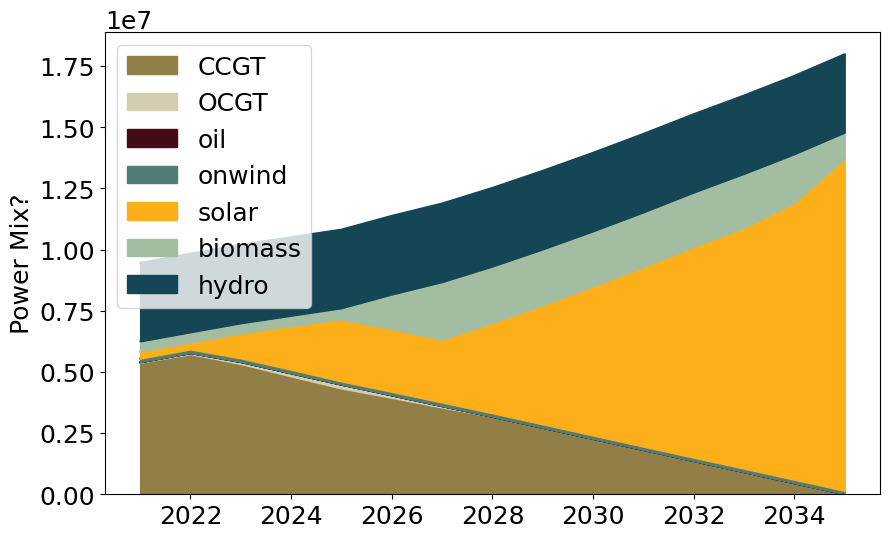

In [26]:
df_RC=pd.DataFrame(data)
df_RC.set_index("year")


# Create a stacked bar plot
df_RC.plot.area(x="year",y=df_RC.columns[:-1],stacked=True, figsize=(10, 6),color=carrier_colors, zorder = 2)

# Add labels and title
plt.ylabel('Power Mix?')
plt.xlabel('')
#plt.xticks(range(len(df["year"])), df["year"], rotation=90)
#plt.grid(axis = 'y',zorder = 0)

plt.savefig(scen_path+ 'Generation/powermix_RES_CAP_2021-2035.pdf', dpi=300, bbox_inches='tight')

### RES_CAP_BAT

In [9]:
first_date = "2013-01-01"
second_date = "2014-01-01"
data={"CCGT":[],"OCGT":[],"oil":[],"onwind":[],"solar":[],"biomass":[],"hydro":[],"year":[],'demand':[]} 
battery_RCBp = {'battery':[],"year":[]}
battery_RCBn = {'battery':[],"year":[]}

for y in range(2021,2036):
    path= data_path_RCB + f"RCB_{y}.nc"
    n = pypsa.Network(path)
    data["year"].append(y)
    battery_RCBp["year"].append(y)
    battery_RCBn["year"].append(y)

    CCGT = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["CCGT"]
    data["CCGT"].append(CCGT.sum())

    OCGT = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["OCGT"]
    data["OCGT"].append(OCGT.sum())

    Oil = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["oil"]
    data["oil"].append(Oil.sum())

    Onwind = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["onwind"]
    data["onwind"].append(Onwind.sum())

    solar = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["solar"]
    data["solar"].append(solar.sum())

    biomass = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["biomass"]
    data["biomass"].append(biomass.sum())

    battery = n.stores_t.p.loc[first_date:second_date].groupby(n.stores.carrier, axis=1).sum()["battery"]
    i=0
    nbattery = []
    pbattery =[]
    for i in battery:
        if i < 0:
            nbattery.append(i)
        else:
            nbattery.append(0) 
    for i in battery:
        if i > 0:
            pbattery.append(i)
        else:
            pbattery.append(0) 


    # data["battery"].append(sum(pbattery))
    battery_RCBp["battery"].append(sum(pbattery))
    battery_RCBn["battery"].append(sum(nbattery))

    
    Hydro = n.storage_units_t.p_dispatch[first_date:second_date].sum(axis=1)
    data["hydro"].append(Hydro.sum())

    demand = n.loads_t.p_set.loc[first_date:second_date].sum(axis=1)*-1
    data["demand"].append(demand.sum())

df_RCB=pd.DataFrame(data)
df_RCB.set_index("year")

INFO:pypsa.io:Imported network RCB_2021.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network RCB_2022.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network RCB_2023.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network RCB_2024.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network RCB_2025.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network RCB_2026.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network RCB_2027.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported netw

CCGT           OCGT          oil        onwind         solar  \
year                                                                         
2021  5.380214e+06   19007.944822     0.000202  1.466534e+05  2.885379e+05   
2022  5.727199e+06   46026.092481     0.000331  1.466534e+05  2.885379e+05   
2023  5.324024e+06   82043.748823  1433.371112  1.466534e+05  1.022192e+06   
2024  4.818444e+06  123085.754515  1627.247554  1.466534e+05  1.793490e+06   
2025  4.323600e+06  156007.065806  1628.027964  1.318361e+05  2.537929e+06   
2026  3.942191e+06  100444.354343  1632.326815  1.436046e+05  2.558423e+06   
2027  3.546633e+06   55918.257567  1636.802694  1.465530e+05  2.566467e+06   
2028  3.155304e+06    8556.335898  1289.280255  3.863740e+05  3.572670e+06   
2029  2.700457e+06   11801.216819   134.434418  1.325171e+06  3.818467e+06   
2030  2.247309e+06   12377.832569     0.062426  2.248487e+06  4.180647e+06   
2031  1.799929e+06    8278.500553     0.039178  3.193035e+06  4.536745e+06   
2032  1.350419e+06    5840.312718     0.045145  4.130524e+06  4.996345e+06   
2033  9.052709e+05       0.207696     0.024842  4.986288e+06  5.423934e+06   
2034  4.526327e+05       2.023520     0.212446  5.384569e+06  5.632519e+06   
2035  0.000000e+00       0.000000     0.000000  5.583320e+06  5.979157e+06   

           biomass         hydro        demand  
year                                            
2021  4.136262e+05  3.207036e+06 -9.455076e+06  
2022  4.136262e+05  3.207036e+06 -9.829079e+06  
2023  4.136262e+05  3.207036e+06 -1.019708e+07  
2024  4.136262e+05  3.207036e+06 -1.050408e+07  
2025  4.542370e+05  3.206699e+06 -1.081209e+07  
2026  1.419656e+06  3.206976e+06 -1.137309e+07  
2027  2.354728e+06  3.206987e+06 -1.187909e+07  
2028  2.143647e+06  3.205702e+06 -1.240710e+07  
2029  1.966675e+06  3.205998e+06 -1.295910e+07  
2030  1.714400e+06  3.205033e+06 -1.353511e+07  
2031  1.468403e+06  3.203677e+06 -1.413711e+07  
2032  1.168311e+06  3.188399e+06 -1.476512e+07  
2033  9.042598e+05  3.189869e+06 -1.535612e+07  
2034  9.002970e+05  3.148792e+06 -1.597013e+07  
2035  8.929221e+05  3.175212e+06 -1.660913e+07

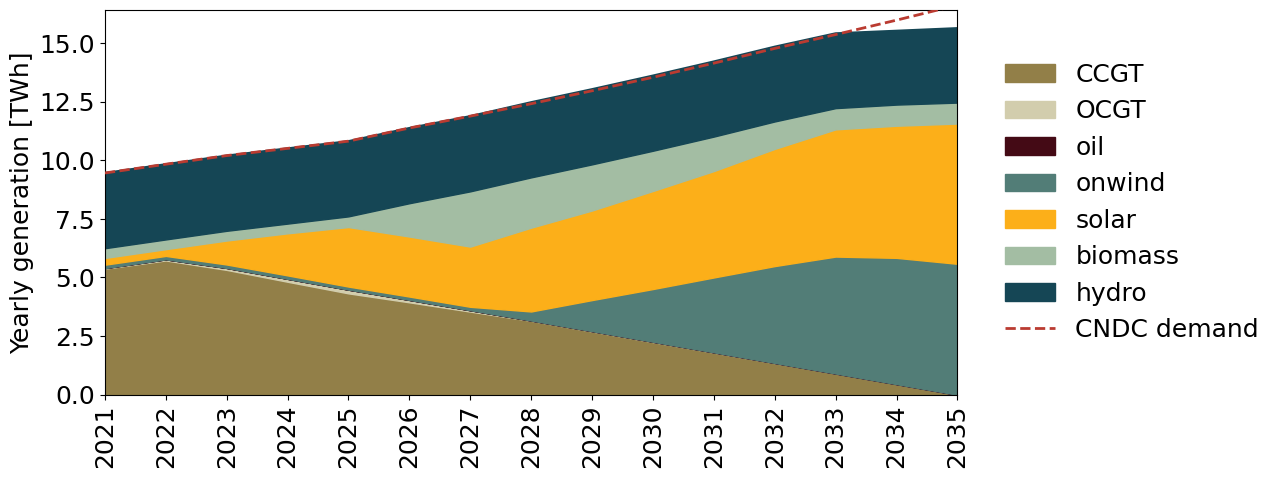

In [28]:
df_RCB=pd.DataFrame(data)
df_RCB.set_index("year")

demand_data = [9455.0, 9829.0, 10197.0, 10504.0, 10812.0, 11373.0, 11879.0, 12407.0, 12959.0, 13535.0, 14137.0, 14765.0, 15356.0, 15970.0, 16609.0]
years = range(0,15)
demand = pd.Series(demand_data, index=years)


# Create a stacked bar plot
plot_df = df_RCB.iloc[:, :-1]
(plot_df/1000000).plot.area( color=carrier_colors,stacked=True, figsize=(11, 5), zorder = 2)


(demand/1000).plot( color=red2, linewidth=2, linestyle='dashed', label="CNDC demand", zorder=3)


# Add labels and title
plt.ylabel('Yearly generation [TWh]')
plt.xlabel('')
plt.xlim(0,14)
plt.xticks(ticks = range(15),labels = np.arange(2021,2036), rotation=90)
#plt.grid(axis = 'y',zorder = 0)
plt.legend(loc='center left', bbox_to_anchor=(1.03, 0.5), frameon=False)

plt.savefig(scen_path+ 'Generation/powermix_RES_CAP_2021-2035.pdf', dpi=300, bbox_inches='tight')

In [114]:
df_RCB.sum(axis=1)[14]

16593145.918796

### RCB_10


In [83]:
first_date = "2013-01-01"
second_date = "2014-01-01"
data={"CCGT":[],"OCGT":[],"oil":[],"onwind":[],"solar":[],"biomass":[],"hydro":[],"year":[],'demand':[]} #,"battery":[]
battery_RCB10p = {'battery':[],"year":[]}
battery_RCB10n = {'battery':[],"year":[]}

for y in range(2021,2036):
    path= data_path_RCB10 + f"RCB_10_{y}.nc"
    n = pypsa.Network(path)
    data["year"].append(y)
    battery_RCB10p["year"].append(y)
    battery_RCB10n["year"].append(y)

    CCGT = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["CCGT"]
    data["CCGT"].append(CCGT.sum())

    OCGT = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["OCGT"]
    data["OCGT"].append(OCGT.sum())

    Oil = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["oil"]
    data["oil"].append(Oil.sum())

    Onwind = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["onwind"]
    data["onwind"].append(Onwind.sum())

    solar = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["solar"]
    data["solar"].append(solar.sum())

    biomass = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["biomass"]
    data["biomass"].append(biomass.sum())

    battery = n.stores_t.p.loc[first_date:second_date].groupby(n.stores.carrier, axis=1).sum()["battery"]
    i=0
    nbattery = []
    pbattery =[]
    for i in battery:
        if i < 0:
            nbattery.append(i)
        else:
            nbattery.append(0) 
    for i in battery:
        if i > 0:
            pbattery.append(i)
        else:
            pbattery.append(0) 


    # data["battery"].append(sum(pbattery))
    battery_RCB10p["battery"].append(sum(pbattery))
    battery_RCB10n["battery"].append(sum(nbattery))

    
    Hydro = n.storage_units_t.p_dispatch[first_date:second_date].sum(axis=1)
    data["hydro"].append(Hydro.sum())

    demand = n.loads_t.p_set.loc[first_date:second_date].sum(axis=1)*-1
    data["demand"].append(demand.sum())

df_RCB10=pd.DataFrame(data)
df_RCB10.set_index("year")


INFO:pypsa.io:Imported network RCB_10_2021.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network RCB_10_2022.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network RCB_10_2023.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network RCB_10_2024.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network RCB_10_2025.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network RCB_10_2026.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network RCB_10_2027.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:p

CCGT           OCGT          oil        onwind         solar  \
year                                                                         
2021  5.380214e+06   19007.993655     0.000846  1.466534e+05  2.885379e+05   
2022  5.727199e+06   46026.146030     0.001231  1.466534e+05  2.885379e+05   
2023  5.413303e+06   83077.000694  1388.106855  1.466531e+05  9.319366e+05   
2024  4.952509e+06  124423.471587  1633.052913  1.466530e+05  1.658080e+06   
2025  4.484596e+06  171609.137111  1660.975441  1.390006e+05  2.420847e+06   
2026  4.125142e+06  134270.854257  1632.052024  1.430308e+05  2.561782e+06   
2027  3.777868e+06   87388.051356  1636.890832  1.464986e+05  2.569489e+06   
2028  3.468386e+06   11240.204306  1480.089057  1.453139e+05  3.311702e+06   
2029  3.057129e+06   14758.322596  1109.735527  9.177350e+05  3.758703e+06   
2030  2.642752e+06   21682.089654     0.076575  1.758834e+06  4.115921e+06   
2031  2.237015e+06   20406.287016     0.591643  2.700993e+06  4.433941e+06   
2032  1.832305e+06   18282.643973    36.385813  3.521917e+06  4.881837e+06   
2033  1.432948e+06   12078.982857     0.051845  4.371322e+06  5.272969e+06   
2034  1.041061e+06       0.328467     0.038483  5.186527e+06  5.694230e+06   
2035  6.336895e+05       0.205286     0.025143  5.525179e+06  6.008692e+06   

           biomass         hydro        demand  
year                                            
2021  4.136262e+05  3.207036e+06 -9.455076e+06  
2022  4.136262e+05  3.207036e+06 -9.829079e+06  
2023  4.136272e+05  3.207035e+06 -1.019708e+07  
2024  4.136271e+05  3.207035e+06 -1.050408e+07  
2025  3.873727e+05  3.206844e+06 -1.081209e+07  
2026  1.200140e+06  3.206929e+06 -1.137309e+07  
2027  2.089089e+06  3.206956e+06 -1.187909e+07  
2028  2.319321e+06  3.206618e+06 -1.240710e+07  
2029  2.073805e+06  3.203997e+06 -1.295910e+07  
2030  1.861783e+06  3.205405e+06 -1.353511e+07  
2031  1.634492e+06  3.189773e+06 -1.413711e+07  
2032  1.394444e+06  3.190243e+06 -1.476512e+07  
2033  1.148992e+06  3.189528e+06 -1.535612e+07  
2034  9.245233e+05  3.190186e+06 -1.597013e+07  
2035  8.913843e+05  3.192607e+06 -1.660913e+07

In [143]:
df_E.sum(axis=1)[14]

17084819.708834108

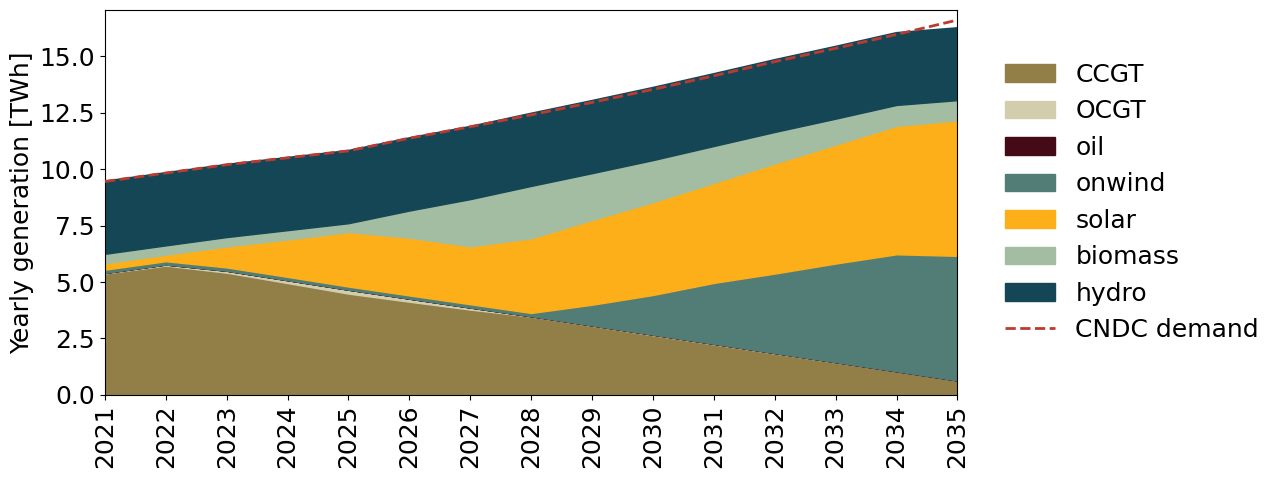

In [62]:
df_E=pd.DataFrame(data)
df_E.set_index("year")

demand_data = [9455.0, 9829.0, 10197.0, 10504.0, 10812.0, 11373.0, 11879.0, 12407.0, 12959.0, 13535.0, 14137.0, 14765.0, 15356.0, 15970.0, 16609.0]
years = range(0,15)
demand = pd.Series(demand_data, index=years)


# Create a stacked bar plot
plot_df = df_E.iloc[:, :-1]
(plot_df/1000000).plot.area( color=carrier_colors,stacked=True, figsize=(11, 5), zorder = 2)


(demand/1000).plot( color=red2, linewidth=2, linestyle='dashed', label="CNDC demand", zorder=3)


# Add labels and title
plt.ylabel('Yearly generation [TWh]')
plt.xlabel('')
plt.xlim(0,14)
plt.xticks(ticks = range(15),labels = np.arange(2021,2036), rotation=90)
#plt.grid(axis = 'y',zorder = 0)
plt.legend(loc='center left', bbox_to_anchor=(1.03, 0.5), frameon=False)

plt.savefig(scen_path+ 'Generation/powermix_E_2021-2035.pdf', dpi=300, bbox_inches='tight')

### RCB_20

In [82]:
first_date = "2013-01-01"
second_date = "2014-01-01"
data={"CCGT":[],"OCGT":[],"oil":[],"onwind":[],"solar":[],"biomass":[],"hydro":[],"year":[],'demand':[]} #,"battery":[]
battery_RCB20p = {'battery':[],"year":[]}
battery_RCB20n = {'battery':[],"year":[]}

for y in range(2021,2036):
    path= data_path_RCB20 + f"RCB_20_{y}.nc"
    n = pypsa.Network(path)
    data["year"].append(y)
    battery_RCB20p["year"].append(y)
    battery_RCB20n["year"].append(y)

    CCGT = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["CCGT"]
    data["CCGT"].append(CCGT.sum())

    OCGT = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["OCGT"]
    data["OCGT"].append(OCGT.sum())

    Oil = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["oil"]
    data["oil"].append(Oil.sum())

    Onwind = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["onwind"]
    data["onwind"].append(Onwind.sum())

    solar = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["solar"]
    data["solar"].append(solar.sum())

    biomass = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["biomass"]
    data["biomass"].append(biomass.sum())

    battery = n.stores_t.p.loc[first_date:second_date].groupby(n.stores.carrier, axis=1).sum()["battery"]
    i=0
    nbattery = []
    pbattery =[]
    for i in battery:
        if i < 0:
            nbattery.append(i)
        else:
            nbattery.append(0) 
    for i in battery:
        if i > 0:
            pbattery.append(i)
        else:
            pbattery.append(0) 


    # data["battery"].append(sum(pbattery))
    battery_RCB20p["battery"].append(sum(pbattery))
    battery_RCB20n["battery"].append(sum(nbattery))

    
    Hydro = n.storage_units_t.p_dispatch[first_date:second_date].sum(axis=1)
    data["hydro"].append(Hydro.sum())

    demand = n.loads_t.p_set.loc[first_date:second_date].sum(axis=1)*-1
    data["demand"].append(demand.sum())

df_RCB20=pd.DataFrame(data)
df_RCB20.set_index("year")


INFO:pypsa.io:Imported network RCB_20_2021.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network RCB_20_2022.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network RCB_20_2023.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network RCB_20_2024.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network RCB_20_2025.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network RCB_20_2026.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network RCB_20_2027.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:p

CCGT           OCGT          oil        onwind         solar  \
year                                                                         
2021  5.380214e+06   19008.016055     0.001111  1.466534e+05  2.885379e+05   
2022  5.727199e+06   46026.253730     0.001446  1.466534e+05  2.885379e+05   
2023  5.502488e+06   84187.886683  1339.665155  1.466534e+05  8.416977e+05   
2024  5.086408e+06  125929.874402  1610.202096  1.466534e+05  1.522699e+06   
2025  4.662656e+06  173992.707020  1624.288718  1.460644e+05  2.212822e+06   
2026  4.292946e+06  179941.763822  1609.244530  1.373290e+05  2.650842e+06   
2027  3.990727e+06  133222.308426  1613.617123  1.453004e+05  2.662730e+06   
2028  3.723077e+06   59605.136030  1567.495939  1.466011e+05  2.887332e+06   
2029  3.413699e+06   18670.340646  1419.802412  4.700423e+05  3.791397e+06   
2030  3.039758e+06   29214.280456   420.650993  1.309111e+06  4.030193e+06   
2031  2.662417e+06   41536.935373    85.412661  2.124451e+06  4.403554e+06   
2032  2.308557e+06   35039.293081   134.138574  2.937980e+06  4.778455e+06   
2033  1.949045e+06   32752.885187   332.634288  3.736512e+06  5.145108e+06   
2034  1.596766e+06   25100.134002   321.749430  4.521481e+06  5.534967e+06   
2035  1.267380e+06       0.024019     0.002289  5.341367e+06  5.865260e+06   

           biomass         hydro        demand  
year                                            
2021  4.136262e+05  3.207036e+06 -9.455076e+06  
2022  4.136262e+05  3.207036e+06 -9.829079e+06  
2023  4.136262e+05  3.207036e+06 -1.019708e+07  
2024  4.136262e+05  3.207036e+06 -1.050408e+07  
2025  4.077580e+05  3.207034e+06 -1.081209e+07  
2026  9.036472e+05  3.206615e+06 -1.137309e+07  
2027  1.738320e+06  3.207009e+06 -1.187909e+07  
2028  2.399798e+06  3.206993e+06 -1.240710e+07  
2029  2.125725e+06  3.205876e+06 -1.295910e+07  
2030  1.989924e+06  3.206220e+06 -1.353511e+07  
2031  1.779366e+06  3.200668e+06 -1.413711e+07  
2032  1.583672e+06  3.194196e+06 -1.476512e+07  
2033  1.381262e+06  3.187686e+06 -1.535612e+07  
2034  1.168323e+06  3.194925e+06 -1.597013e+07  
2035  9.843346e+05  3.195441e+06 -1.660913e+07

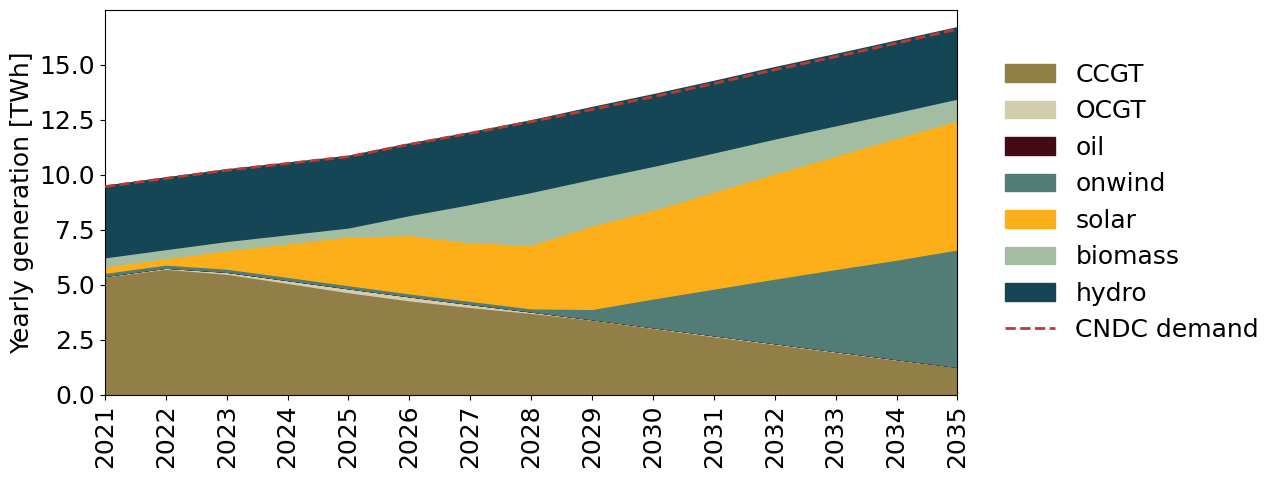

In [5]:
df_RCB_20=pd.DataFrame(data)
df_RCB_20.set_index("year")

demand_data = [9455.0, 9829.0, 10197.0, 10504.0, 10812.0, 11373.0, 11879.0, 12407.0, 12959.0, 13535.0, 14137.0, 14765.0, 15356.0, 15970.0, 16609.0]
years = range(0,15)
demand = pd.Series(demand_data, index=years)


# Create a stacked bar plot
plot_df = df_RCB_20.iloc[:, :-1]
(plot_df/1000000).plot.area( color=carrier_colors,stacked=True, figsize=(11, 5), zorder = 2)


(demand/1000).plot( color=red2, linewidth=2, linestyle='dashed', label="CNDC demand", zorder=3)


# Add labels and title
plt.ylabel('Yearly generation [TWh]')
plt.xlabel('')
plt.xlim(0,14)
plt.xticks(ticks = range(15),labels = np.arange(2021,2036), rotation=90)
#plt.grid(axis = 'y',zorder = 0)
plt.legend(loc='center left', bbox_to_anchor=(1.03, 0.5), frameon=False)

plt.savefig(scen_path+ 'Generation/powermix_E_2021-2035.pdf', dpi=300, bbox_inches='tight')

### Combined generation plot

C:\Users\xenia\AppData\Local\Temp\ipykernel_1308\957413227.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0, 0].set_xticklabels(ticklabels,rotation=90)


NameError: name 'df_NS' is not defined

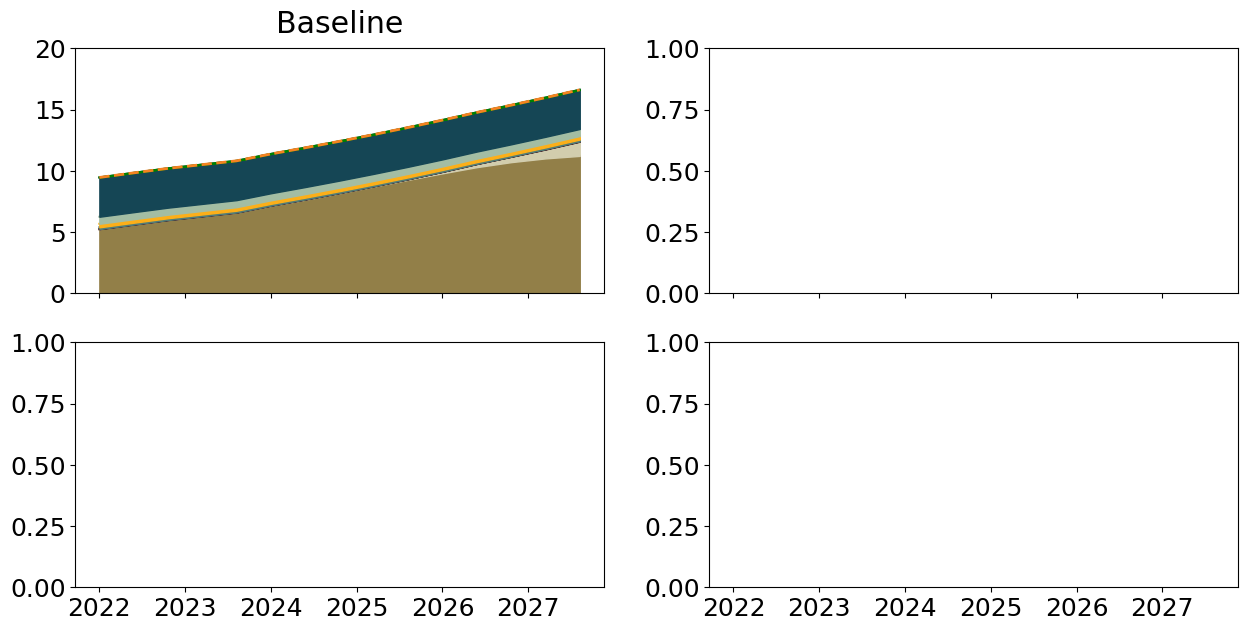

In [18]:
demand_data = [9455.0, 9829.0, 10197.0, 10504.0, 10812.0, 11373.0, 11879.0, 12407.0, 12959.0, 13535.0, 14137.0, 14765.0, 15356.0, 15970.0, 16609.0]
years = range(0,15)
demand = pd.Series(demand_data, index=years)


ticklabels= np.arange(2021,2036)

fig, axes = plt.subplots(2, 2, figsize=(20, 5), sharex=True, sharey=False)
# Create a stacked bar plot
(df_B.iloc[:, :-1]/1000000).plot.area(ax=axes[0,0] ,stacked=True, color=carrier_colors, figsize=(15, 7),zorder=2)
(demand/1000).plot(ax=axes[0,0] , color=orange, linewidth=2, linestyle='dashed', label="Demand", zorder=3) #
#axes[0,0].grid(axis = 'y',zorder = 0)
axes[0, 0].legend().remove()
axes[0, 0].set_title('Baseline',y=1.03)
axes[0, 0].set_xticklabels(ticklabels,rotation=90)
axes[0, 0].set_yticks(np.arange(0, 21, 5))

bar1 = (df_NS.iloc[:, :-1]/1000000).plot.area(ax=axes[0,1] ,stacked=True, color=carrier_colors, figsize=(15, 7),zorder=2) 
(demand/1000).plot(ax=axes[0,1] , color=orange, linewidth=2, linestyle='dashed', label="CNDC demand", zorder=3)
#axes[0,1].grid(axis = 'y',zorder = 0)
axes[0, 1].legend().remove()
axes[0, 1].set_title('National Strategy',y=1.03)
axes[0, 1].set_yticks(np.arange(0, 21, 5))

(df_RC.iloc[:, :-1]/1000000).plot.area(ax=axes[1,0] ,stacked=True, color=carrier_colors, figsize=(15, 7),zorder=2)
(demand/1000).plot(ax=axes[1,0] , color=orange, linewidth=2, linestyle='dashed', label="CNDC demand", zorder=3)
#axes[1,0].grid(axis = 'y',zorder = 0)
axes[1, 0].legend().remove()
axes[1, 0].set_title('RES-CAP',y=1.03)
axes[1, 0].set_yticks(np.arange(0, 21, 5))
axes[1, 0].set_xticklabels(ticklabels,rotation=90)
axes[1, 0].set_xlabel('')

(df_RCB.iloc[:, :-1]/1000000).plot.area(ax=axes[1,1] ,stacked=True, color=carrier_colors, figsize=(15, 7),zorder=2) 
(demand/1000).plot(ax=axes[1,1] , color=orange, linewidth=2, linestyle='dashed', label="CNDC demand", zorder=3)
#axes[1,1].grid(axis = 'y',zorder = 0)
axes[1, 1].legend().remove()
axes[1, 1].set_title('RES-CAP-BAT',y=1.03)
axes[1, 1].set_yticks(np.arange(0, 21, 5))
axes[1, 1].set_xticks(range(0,15),ticklabels,rotation=90)
axes[1, 1].set_xlabel('')
axes[1, 1].set_xlim(0,14)

demand_handle = plt.Line2D([], [], color=orange, linewidth=2, linestyle='dashed')
# Get the handles and labels from any one of the subplots
handles, labels = bar1.get_legend_handles_labels()
# Add the demand handle and label to the list of handles and labels
#handles.append(demand_handle)
##labels.append("CNDC demand")

# Create a common legend
fig.legend(handles, labels, loc='center left', bbox_to_anchor=(0.91, 0.5), frameon=False) #, frameon=False
fig.text(0.075, 0.5,'Yearly generation [TWh]', va='center', rotation='vertical', fontsize=18)
plt.subplots_adjust(hspace=0.35, wspace=0.1)


plt.savefig(scen_path + 'Generation/' +f'Scen_generation_2021-2035.pdf', dpi=300, bbox_inches='tight')

### Multilevel Piechart

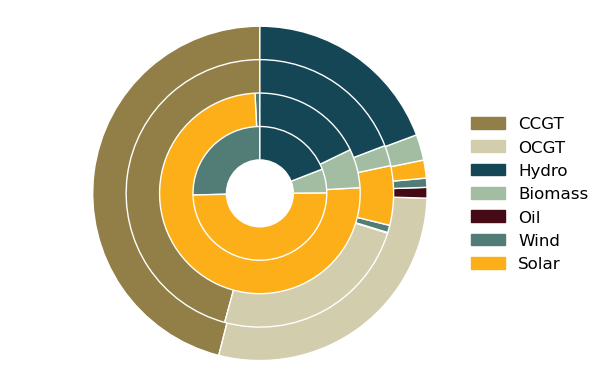

In [78]:
import matplotlib.pyplot as plt

colors = [beige1, beige3, brown, teal3,yellow, green3, teal2,brown]
df = pd.DataFrame([df_B.loc[14].iloc[:-1],df_R.loc[14].iloc[:-1],df_RC.loc[14].iloc[:-1],df_RCB.loc[14].iloc[:-1]],index = scen_list)

# Calculate the total value for each level
level_totals = df.sum(axis=1)

# Calculate the angle for each slice
angles = [360 * df.loc[slice_name] / level_totals.loc[slice_name] for slice_name in df.index]


# Create the figure and axes
fig, ax = plt.subplots()

# Draw the outer ring (level 1)
#ax.pie(angles[0], colors = colors, startangle=90, radius=1, wedgeprops=dict(width=0.3, edgecolor='w')) #,labels=df.columns, 

# Draw the inner rings (level 2 and level 3)
for i in range(0, 4):
    ax.pie(angles[i], colors = colors,startangle=90, radius=1-(i*0.2), wedgeprops=dict(width=0.3, edgecolor='w'))

# Add a circle in the center to create a donut hole
ax.add_artist(plt.Circle((0, 0), 0.2, color='white'))

# Set aspect ratio to be equal so that the chart appears as a circle
ax.axis('equal')
CCGT_patch = mpatches.Patch(color=beige1, label ='CCGT')
OCGT_patch = mpatches.Patch(color=beige3, label ='OCGT')
wind_patch = mpatches.Patch(color=teal3, label ='Wind')
solar_patch = mpatches.Patch(color=yellow, label ='Solar')
#ror_patch = mpatches.Patch(color='blue', label ='ROR')
#battery_patch = mpatches.Patch(color=purple3, label ='Battery')
#load_patch = mpatches.Patch(color=red2, label ='Demand')
hydro_patch = mpatches.Patch(color = teal2, label = 'Hydro')
biomass_patch = mpatches.Patch(color = green3, label = 'Biomass')
oil_patch = mpatches.Patch(color = brown, label = 'Oil')
handles=[CCGT_patch,OCGT_patch,hydro_patch,biomass_patch,oil_patch,wind_patch, solar_patch] #battery_patch,
ax.legend(handles=handles, frameon = False, loc='center left', bbox_to_anchor=(0.9, 0.5),fontsize = 12)


plt.savefig(scen_path + 'Generation/' +f'Scen_power_mix_2035.png', dpi=300, bbox_inches='tight')


In [130]:
df

CCGT          OCGT            oil        onwind  \
Baseline     7.647048e+06  4.733689e+06  171654.814725  1.466000e+05   
RES          7.647064e+06  4.083895e+06   12483.913537  1.466017e+05   
RES_CAP      0.000000e+00  0.000000e+00       0.000000  1.395341e+05   
RES_CAP_BAT  0.000000e+00  0.000000e+00       0.000000  4.213692e+06   

                    solar       biomass         hydro  
Baseline     2.886223e+05  4.136220e+05  3.207031e+06  
RES          1.199910e+06  4.136253e+05  3.207034e+06  
RES_CAP      1.350111e+07  1.125252e+06  3.203029e+06  
RES_CAP_BAT  8.250271e+06  9.593898e+05  3.167758e+06

In [67]:
[df.loc['Baseline'] / level_totals for slice_name in df.index]
level_totals

Baseline       1.660827e+07
RES            1.671061e+07
RES_CAP        1.796893e+07
RES_CAP_BAT    1.659111e+07
dtype: float64

### Combined battery generation

In [ ]:
# data preparation:

# positive
battery_B=pd.DataFrame(battery_Bp)
battery_B.set_index("year")

battery_R=pd.DataFrame(battery_Rp)
battery_R.set_index("year")

battery_RC=pd.DataFrame(battery_RCp)
battery_RC.set_index("year")

battery_RCB=pd.DataFrame(battery_RCBp)
battery_RCB.set_index("year")

# negative

battery_Bn=pd.DataFrame(battery_Bn)
battery_Bn.set_index("year")

battery_Rn=pd.DataFrame(battery_Rn)
battery_Rn.set_index("year")

battery_RCn=pd.DataFrame(battery_RCn)
battery_RCn.set_index("year")

battery_RCBn=pd.DataFrame(battery_RCBn)
battery_RCBn.set_index("year")

x = 'Hallo'

display(battery_B.sum())
display(battery_R.sum())
display(battery_RC.sum())
display(battery_RCB.sum())

display(x)

display(battery_Bn.sum()/0.9)
display(battery_Rn.sum()/0.9)
display(battery_RCn.sum()/0.9)
display(battery_RCBn.sum()/0.9)

battery_RC


In [ ]:




ticklabels= np.arange(2021,2036)

fig, axes = plt.subplots(2, 2, figsize=(20, 5), sharex=True, sharey=False)
# Create a stacked bar plot
bar1 = (battery_B.iloc[:, :-1]/1000000).plot.area(ax=axes[0,0] ,stacked=True, color=carrier_colors, figsize=(15, 7),zorder=2)
#(demand/1000).plot(ax=axes[0,0] , color=red2, linewidth=2, linestyle='dashed', label="Demand", zorder=3) #
#axes[0,0].grid(axis = 'y',zorder = 0)
axes[0, 0].legend().remove()
axes[0, 0].set_title('Baseline',y=1.03)
axes[0, 0].set_xticklabels(ticklabels,rotation=90)
axes[0, 0].set_yticks(np.arange(0, 10, 2))

(battery_R.iloc[:, :-1]/1000000).plot.area(ax=axes[0,1] ,stacked=True, color=carrier_colors, figsize=(15, 7),zorder=2) 
#(demand/1000).plot(ax=axes[0,1] , color=red2, linewidth=2, linestyle='dashed', label="CNDC demand", zorder=3)
#axes[0,1].grid(axis = 'y',zorder = 0)
axes[0, 1].legend().remove()
axes[0, 1].set_title('RES',y=1.03)
axes[0, 1].set_yticks(np.arange(0, 10, 2))

(battery_RC.iloc[:, :-1]/1000000).plot.area(ax=axes[1,0] ,stacked=True, color=carrier_colors, figsize=(15, 7),zorder=2)
#(demand/1000).plot(ax=axes[1,0] , color=red2, linewidth=2, linestyle='dashed', label="CNDC demand", zorder=3)
#axes[1,0].grid(axis = 'y',zorder = 0)
axes[1, 0].legend().remove()
axes[1, 0].set_title('RES_CAP',y=1.03)
axes[1, 0].set_yticks(np.arange(0, 10, 2))
axes[1, 0].set_xticklabels(ticklabels,rotation=90)
axes[1, 0].set_xlabel('')

(battery_RCB.iloc[:, :-1]/1000000).plot.area(ax=axes[1,1] ,stacked=True, color=carrier_colors, figsize=(15, 7),zorder=2) 
#(demand/1000).plot(ax=axes[1,1] , color=red2, linewidth=2, linestyle='dashed', label="CNDC demand", zorder=3)
#axes[1,1].grid(axis = 'y',zorder = 0)
axes[1, 1].legend().remove()
axes[1, 1].set_title('RES_CAP_BAT',y=1.03)
axes[1, 1].set_yticks(np.arange(0, 10, 2))
axes[1, 1].set_xticks(range(0,15),ticklabels,rotation=90)
axes[1, 1].set_xlabel('')
axes[1, 1].set_xlim(0,14)

#demand_handle = plt.Line2D([], [], color=red2, linewidth=2, linestyle='dashed')
# Get the handles and labels from any one of the subplots
handles, labels = bar1.get_legend_handles_labels()
# Add the demand handle and label to the list of handles and labels
#handles.append(demand_handle)
##labels.append("CNDC demand")

# Create a common legend
fig.legend(handles, labels, loc='center left', bbox_to_anchor=(0.91, 0.5), frameon=False) #, frameon=False
fig.text(0.075, 0.5,'Yearly battery generation [GWh]', va='center', rotation='vertical', fontsize=18)
plt.subplots_adjust(hspace=0.35, wspace=0.1)


plt.savefig(scen_path + 'Battery/' +f'Scen_battery_generation_2021-2035.pdf', dpi=300, bbox_inches='tight')

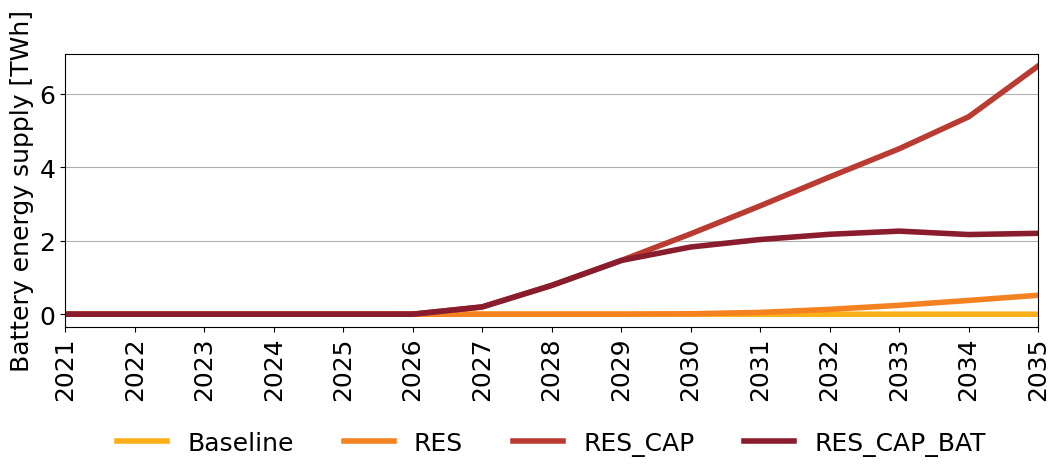

In [361]:
# Define the colors for each scenario
colors = [yellow, orange, red2, red1]

# Create the figure and axes
fig, ax = plt.subplots(figsize=(11, 5))

# Iterate over each scenario and plot the line for each year
for i, series in enumerate([battery_B.iloc[:, :-1], battery_R.iloc[:, :-1], battery_RC.iloc[:, :-1], battery_RCB.iloc[:, :-1]]):
    ax.plot(series.index, (series/1000000), color=colors[i], linewidth=4)

# Set the x-ticks and labels
ax.set_xticks(np.arange(15))
ax.set_xticklabels(np.arange(2021,2036),rotation = 90)

ax.set_xlim(0,14)

# Add gridlines
ax.grid(axis='y', zorder=0)

# Set the title and ylabel
#ax.set_title('Battery Capacity by Scenario', y=1.03)
ax.set_ylabel('Battery energy supply [TWh]')

# Create the legend
labels = ['Baseline', 'RES', 'RES_CAP', 'RES_CAP_BAT']

ax.legend(labels,loc='upper center', bbox_to_anchor=(0.5, -0.3), ncol=4, frameon=False)

plt.tight_layout()
plt.savefig(scen_path + 'Battery/' + 'Scen_generation_battery_2021-2035_one_plot.pdf', dpi=300,bbox_inches='tight')
plt.show()

## Lost Load

## Capacity factors

### Baseline

In [38]:
cp_B = {
    "CCGT": [], "OCGT": [],"oil": [], "onwind": [],  "solar": [], "biomass": [],"hydro": [],"year": []
}

carrier_list_stat = ['Biomass', 'Combined-Cycle Gas', 'Oil', 'Onshore Wind', 'Open-Cycle Gas', 'Solar']
carrier_list = ['biomass', 'CCGT', 'oil', 'onwind', 'OCGT', 'solar']

max_length = 0  # Maximum length among all carrier lists

for y in range(2021, 2036):
    cp_B["year"].append(y)
    n = pypsa.Network(f"{data_path_B}/Baseline_{y}.nc")

    values = {carrier: [] for carrier in carrier_list}  # Initialize empty lists for each carrier

    for carrier_stat, carrier in zip(carrier_list_stat, carrier_list):
        value = n.statistics().loc['Generator']['Capacity Factor'].drop('load')[carrier_stat]
        values[carrier].append(value)  # Append values to the respective carrier list

    # Find the maximum length among all carrier lists
    max_length = max(max_length, max(len(val) for val in values.values()))

    # Append values to the respective columns in the data dictionary
    for carrier in carrier_list:
        cp_B[carrier].extend(values[carrier])



INFO:pypsa.io:Imported network Baseline_2021.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network Baseline_2022.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network Baseline_2023.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network Baseline_2024.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network Baseline_2025.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network Baseline_2026.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network Baseline_2027.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units,

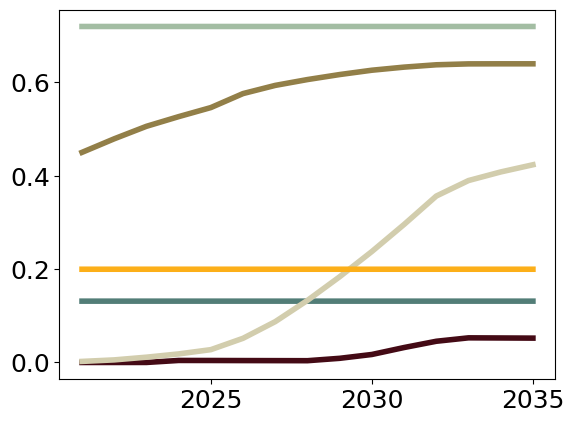

In [39]:
for carrier in carrier_list :
    pd.Series(cp_B[carrier], index = range(2021, 2036)).plot(color = carrier_colors[carrier], linewidth = 4) 

### RES

In [40]:
cp_R = {
    "CCGT": [], "OCGT": [],"oil": [], "onwind": [],  "solar": [], "biomass": [],"hydro": [],"year": []
}

carrier_list_stat = ['Biomass', 'Combined-Cycle Gas', 'Oil', 'Onshore Wind', 'Open-Cycle Gas', 'Solar']
carrier_list = ['biomass', 'CCGT', 'oil', 'onwind', 'OCGT', 'solar']

max_length = 0  # Maximum length among all carrier lists

for y in range(2021, 2036):
    cp_R["year"].append(y)
    n = pypsa.Network(f"{data_path_R}/RES_{y}.nc")

    values = {carrier: [] for carrier in carrier_list}  # Initialize empty lists for each carrier

    for carrier_stat, carrier in zip(carrier_list_stat, carrier_list):
        value = n.statistics().loc['Generator']['Capacity Factor'].drop('load')[carrier_stat]
        values[carrier].append(value)  # Append values to the respective carrier list

    # Find the maximum length among all carrier lists
    max_length = max(max_length, max(len(val) for val in values.values()))

    # Append values to the respective columns in the data dictionary
    for carrier in carrier_list:
        cp_R[carrier].extend(values[carrier])

INFO:pypsa.io:Imported network RES_2021.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network RES_2022.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network RES_2023.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network RES_2024.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network RES_2025.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network RES_2026.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network RES_2027.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported netw

### RES_CAP

In [46]:
cp_RC = {
    "CCGT": [], "OCGT": [],"oil": [], "onwind": [],  "solar": [], "biomass": [],"hydro": [],"year": []
}

carrier_list_stat = ['Biomass', 'Combined-Cycle Gas', 'Oil', 'Onshore Wind', 'Open-Cycle Gas', 'Solar']
carrier_list = ['biomass', 'CCGT', 'oil', 'onwind', 'OCGT', 'solar']

max_length = 0  # Maximum length among all carrier lists

for y in range(2021, 2036):
    cp_RC["year"].append(y)
    n = pypsa.Network(f"{data_path_R_CAP}/RES_CAP_{y}.nc")

    values = {carrier: [] for carrier in carrier_list}  # Initialize empty lists for each carrier

    for carrier_stat, carrier in zip(carrier_list_stat, carrier_list):
        value = n.statistics().loc['Generator']['Capacity Factor'].drop('load')[carrier_stat]
        values[carrier].append(value)  # Append values to the respective carrier list

    # Find the maximum length among all carrier lists
    max_length = max(max_length, max(len(val) for val in values.values()))

    # Append values to the respective columns in the data dictionary
    for carrier in carrier_list:
        cp_RC[carrier].extend(values[carrier])

INFO:pypsa.io:Imported network RES_CAP_2021.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network RES_CAP_2022.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network RES_CAP_2023.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network RES_CAP_2024.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network RES_CAP_2025.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network RES_CAP_2026.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network RES_CAP_2027.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores

### RES_CAP_BAT


In [49]:
cp_RCB = {
    "CCGT": [], "OCGT": [],"oil": [], "onwind": [],  "solar": [], "biomass": [],"hydro": [],"year": []
}

carrier_list_stat = ['Biomass', 'Combined-Cycle Gas', 'Oil', 'Onshore Wind', 'Open-Cycle Gas', 'Solar']
carrier_list = ['biomass', 'CCGT', 'oil', 'onwind', 'OCGT', 'solar']

max_length = 0  # Maximum length among all carrier lists

for y in range(2021, 2036):
    cp_RCB["year"].append(y)
    n = pypsa.Network(f"{data_path_RCB}/second_run/RES_CAP_BAT_{y}.nc")

    values = {carrier: [] for carrier in carrier_list}  # Initialize empty lists for each carrier

    for carrier_stat, carrier in zip(carrier_list_stat, carrier_list):
        value = n.statistics().loc['Generator']['Capacity Factor'].drop('load')[carrier_stat]
        values[carrier].append(value)  # Append values to the respective carrier list

    # Find the maximum length among all carrier lists
    max_length = max(max_length, max(len(val) for val in values.values()))

    # Append values to the respective columns in the data dictionary
    for carrier in carrier_list:
        cp_RCB[carrier].extend(values[carrier])

INFO:pypsa.io:Imported network RES_CAP_BAT_2021.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network RES_CAP_BAT_2022.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network RES_CAP_BAT_2023.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network RES_CAP_BAT_2024.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network RES_CAP_BAT_2025.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network RES_CAP_BAT_2026.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network RES_CAP_BAT_2027.nc has buses, carriers, generators, global_constraints, lines, links, 

In [54]:
cp_B['CCGT']

[0.4502760202273195,
 0.4793130289435591,
 0.5060729316453589,
 0.526791012320941,
 0.5462163479192141,
 0.5762353565763257,
 0.5937585833938164,
 0.6062593989568995,
 0.6169983350602569,
 0.6262730914049653,
 0.6329023159755527,
 0.6379079842728745,
 0.6398508611615551,
 0.6399994872035746,
 0.6399965707494361]

### Plot Capacity factors

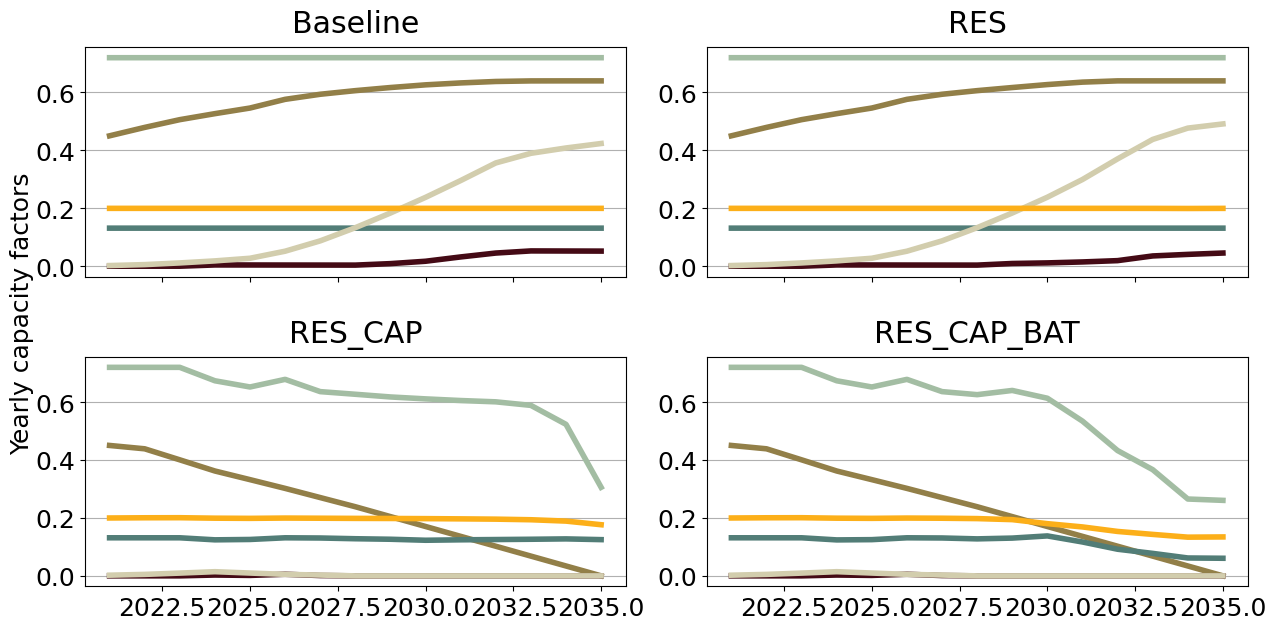

In [52]:
ticklabels= np.arange(2021,2036)

fig, axes = plt.subplots(2, 2, figsize=(20, 5), sharex=True, sharey=False)
# Create a stacked bar plot
for carrier in carrier_list :
    (pd.Series(cp_B[carrier], index = range(2021, 2036))).plot(color = carrier_colors[carrier], linewidth = 4,ax=axes[0,0], figsize=(15, 7),zorder=2)

axes[0,0].grid(axis = 'y',zorder = 0)
axes[0, 0].legend().remove()
axes[0, 0].set_title('Baseline',y=1.03)
#axes[0, 0].set_xticklabels(ticklabels,rotation=90)
#axes[0, 0].set_yticks(np.arange(0, 21, 5))

for carrier in carrier_list :
    (pd.Series(cp_R[carrier], index = range(2021, 2036))).plot(color = carrier_colors[carrier], linewidth = 4,ax=axes[0,1], figsize=(15, 7),zorder=2)
axes[0,1].grid(axis = 'y',zorder = 0)
axes[0, 1].legend().remove()
axes[0, 1].set_title('RES',y=1.03)
#axes[0, 1].set_yticks(np.arange(0, 21, 5))

for carrier in carrier_list :
    (pd.Series(cp_RC[carrier], index = range(2021, 2036))).plot(color = carrier_colors[carrier], linewidth = 4,ax=axes[1,0], figsize=(15, 7),zorder=2)
axes[1,0].grid(axis = 'y',zorder = 0)
axes[1, 0].legend().remove()
axes[1, 0].set_title('RES_CAP',y=1.03)
#axes[1, 0].set_yticks(np.arange(0, 21, 5))
#axes[1, 0].set_xticklabels(ticklabels,rotation=90)
axes[1, 0].set_xlabel('')

for carrier in carrier_list :
    (pd.Series(cp_RCB[carrier], index = range(2021, 2036))).plot(color = carrier_colors[carrier], linewidth = 4,ax=axes[1,1], figsize=(15, 7),zorder=2)
axes[1,1].grid(axis = 'y',zorder = 0)
axes[1, 1].legend().remove()
axes[1, 1].set_title('RES_CAP_BAT',y=1.03)
#axes[1, 1].set_yticks(np.arange(0, 21, 5))
#axes[1, 1].set_xticks(range(0,15),ticklabels,rotation=90)
axes[1, 1].set_xlabel('')
#axes[1, 1].set_xlim(0,1)

#demand_handle = plt.Line2D([], [], color=red2, linewidth=2, linestyle='dashed')
# Get the handles and labels from any one of the subplots
#handles, labels = bar1.get_legend_handles_labels()
# Add the demand handle and label to the list of handles and labels
#handles.append(demand_handle)
##labels.append("CNDC demand")

# Create a common legend
#fig.legend(handles, labels, loc='center left', bbox_to_anchor=(0.91, 0.5), frameon=False) #, frameon=False
fig.text(0.075, 0.5,'Yearly capacity factors', va='center', rotation='vertical', fontsize=18)
plt.subplots_adjust(hspace=0.35, wspace=0.15)


plt.savefig(scen_path + 'Generation/' +f'Scen_cp_2021-2035.pdf', dpi=300, bbox_inches='tight')

## Emissions

In [136]:
display((B.generators_t.p / B.generators.efficiency * B.generators.carrier.map(B.carriers.co2_emissions)).sum().sum()/1000000)
display((NS.generators_t.p / NS.generators.efficiency * NS.generators.carrier.map(NS.carriers.co2_emissions)).sum().sum()/1000000)

5.244367908968126

2.4184917850498455

### Baseline

In [312]:
start_year = 2021
start_value = 2370000
end_year = 2035
end_value = 0
decrease_per_year = (start_value - end_value) / (end_year - start_year)
data={"year":[],"emissions":[],"emission_lim":[]}
for y in range(2021,2036):
    data["year"].append(y)
    n=pypsa.Network(f"{data_path_B}/Baseline_{y}.nc")

    emissions = n.generators_t.p / n.generators.efficiency * n.generators.carrier.map(n.carriers.co2_emissions) # t/h
    n.snapshot_weightings.generators @ emissions.sum(axis=1).div(1e6)
    
    data["emissions"].append(emissions.sum().sum()/1000000)
    
    emission = max(start_value - decrease_per_year * (y - start_year), end_value)
    data["emission_lim"].append(emission/1000000)
    
df_emissions_B=pd.DataFrame(data)

INFO:pypsa.io:Imported network Baseline_2021.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network Baseline_2022.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network Baseline_2023.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network Baseline_2024.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network Baseline_2025.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network Baseline_2026.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network Baseline_2027.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units,

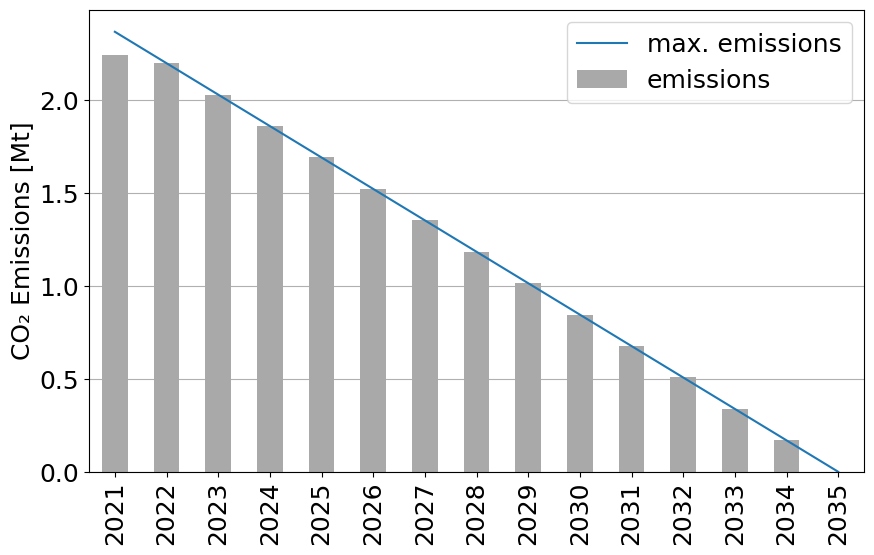

In [140]:

fig,ax=plt.subplots(figsize=(10,6))

df_emissions_B["emissions"].plot(color="darkgray",kind="bar",ax=ax,label="emissions", zorder = 2)    
df_emissions_B["emission_lim"].plot(kind="line",ax=ax,label="max. emissions", zorder = 2)

plt.ylabel(u'CO\u2082 Emissions [Mt]')
plt.legend()

plt.xticks(range(len(df_emissions_B["year"])),df_emissions_B["year"], rotation=90)
plt.grid(axis = 'y',zorder = 0)

plt.savefig(scen_path + f'{scen}_emissions.pdf', dpi=300, bbox_inches='tight')

In [313]:
df_emissions_B["emissions"].sum()

56.59254526624486

### RES

In [314]:
start_year = 2021
start_value = 2370000
end_year = 2035
end_value = 0
decrease_per_year = (start_value - end_value) / (end_year - start_year)
data={"year":[],"emissions":[],"emission_lim":[]}
for y in range(2021,2036):
    data["year"].append(y)
    n=pypsa.Network(f"{data_path_R}/RES_{y}.nc")

    emissions = n.generators_t.p / n.generators.efficiency * n.generators.carrier.map(n.carriers.co2_emissions) # t/h
    n.snapshot_weightings.generators @ emissions.sum(axis=1).div(1e6)
    
    data["emissions"].append(emissions.sum().sum()/1000000)
    
    emission = max(start_value - decrease_per_year * (y - start_year), end_value)
    data["emission_lim"].append(emission/1000000)
    
df_emissions_R=pd.DataFrame(data)

INFO:pypsa.io:Imported network RES_2021.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network RES_2022.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network RES_2023.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network RES_2024.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network RES_2025.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network RES_2026.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network RES_2027.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported netw

In [315]:
df_emissions_R["emissions"].sum()

55.94897272177092

### RES_CAP

In [316]:
start_year = 2021
start_value = 2370000
end_year = 2035
end_value = 0
decrease_per_year = (start_value - end_value) / (end_year - start_year)
data={"year":[],"emissions":[],"emission_lim":[]}
for y in range(2021,2036):
    data["year"].append(y)
    n=pypsa.Network(f"{data_path_R_CAP}/RES_CAP_{y}.nc")

    emissions = n.generators_t.p / n.generators.efficiency * n.generators.carrier.map(n.carriers.co2_emissions) # t/h
    n.snapshot_weightings.generators @ emissions.sum(axis=1).div(1e6)
    
    data["emissions"].append(emissions.sum().sum()/1000000)
    
    emission = max(start_value - decrease_per_year * (y - start_year), end_value)
    data["emission_lim"].append(emission/1000000)
    
df_emissions_RC=pd.DataFrame(data)

INFO:pypsa.io:Imported network RES_CAP_2021.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network RES_CAP_2022.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network RES_CAP_2023.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network RES_CAP_2024.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network RES_CAP_2025.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network RES_CAP_2026.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network RES_CAP_2027.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores

In [318]:
df_emissions_RC["emissions"].sum()

17.65086900391211

### RES_CAP_BAT

In [317]:
start_year = 2021
start_value = 2370000
end_year = 2035
end_value = 0
decrease_per_year = (start_value - end_value) / (end_year - start_year)
data={"year":[],"emissions":[],"emission_lim":[]}
for y in range(2021,2036):
    data["year"].append(y)
    n=pypsa.Network(f"{data_path_RCB}/second_run/RES_CAP_BAT_{y}.nc")

    emissions = n.generators_t.p / n.generators.efficiency * n.generators.carrier.map(n.carriers.co2_emissions) # t/h
    n.snapshot_weightings.generators @ emissions.sum(axis=1).div(1e6)
    
    data["emissions"].append(emissions.sum().sum()/1000000)
    
    emission = max(start_value - decrease_per_year * (y - start_year), end_value)
    data["emission_lim"].append(emission/1000000)
    
df_emissions_RCB=pd.DataFrame(data)

INFO:pypsa.io:Imported network RES_CAP_BAT_2021.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network RES_CAP_BAT_2022.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network RES_CAP_BAT_2023.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network RES_CAP_BAT_2024.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network RES_CAP_BAT_2025.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network RES_CAP_BAT_2026.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network RES_CAP_BAT_2027.nc has buses, carriers, generators, global_constraints, lines, links, 

In [319]:
df_emissions_RCB["emissions"].sum()

17.650870817540884

### Combined emission plot

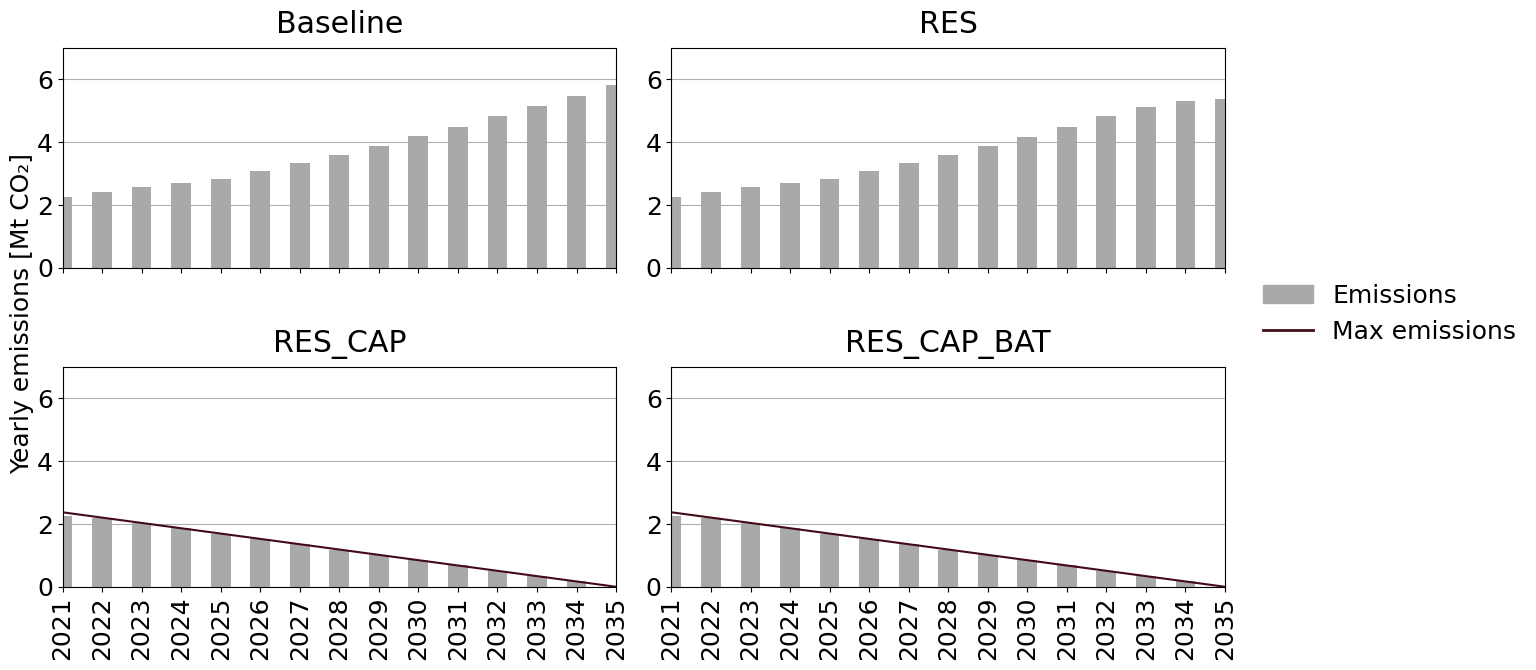

In [177]:
ticklabels= np.arange(2021,2036)

fig, axes = plt.subplots(2, 2, figsize=(20, 5), sharex=True, sharey=False)
# Create a stacked bar plot
df_emissions_B["emissions"].plot.bar(color="darkgray",ax=axes[0,0],label="emissions", figsize=(15, 7),zorder = 2)    #,kind="bar"
#df_emissions_B["emission_lim"].plot(kind="line",ax=axes[0,0],label="max. emissions", zorder = 2)
axes[0,0].grid(axis = 'y',zorder = 0)
#axes[0, 0].legend().remove()
axes[0, 0].set_title('Baseline',y=1.03)
axes[0, 0].set_xticklabels(ticklabels,rotation=90)
axes[0, 0].set_yticks(np.arange(0, 7, 2))
axes[0, 0].set_ylim(0,7)

df_emissions_R["emissions"].plot(color="darkgray",kind="bar",ax=axes[0,1],label="emissions",figsize=(15, 7), zorder = 2)    
#df_emissions_R["emission_lim"].plot(kind="line",ax=axes[0,1],label="max. emissions",color = brown, zorder = 2)
axes[0,1].grid(axis = 'y',zorder = 0)
#axes[0, 1].legend().remove()
axes[0, 1].set_title('RES',y=1.03)
axes[0, 1].set_yticks(np.arange(0, 7, 2))
axes[0, 1].set_ylim(0,7)

df_emissions_RC["emissions"].plot(color="darkgray",kind="bar",ax=axes[1,0],label="emissions",figsize=(15, 7), zorder = 2)    
df_emissions_RC["emission_lim"].plot(kind="line",ax=axes[1,0],label="max. emissions",color = brown, zorder = 2)
axes[1,0].grid(axis = 'y',zorder = 0)
#axes[1, 0].legend().remove()
axes[1, 0].set_title('RES_CAP',y=1.03)
axes[1, 0].set_yticks(np.arange(0, 7, 2))
axes[1, 0].set_xticklabels(ticklabels,rotation=90)
axes[1, 0].set_xlabel('')
axes[1, 0].set_ylim(0,7)

df_emissions_RCB["emissions"].plot(color="darkgray",kind="bar",ax=axes[1,1],label="emissions", figsize=(15, 7),zorder = 2)    
df_emissions_RCB["emission_lim"].plot(kind="line",ax=axes[1,1],label="max. emissions", color = brown,zorder = 2)
axes[1,1].grid(axis = 'y',zorder = 0)
#axes[1, 1].legend().remove()
axes[1, 1].set_title('RES_CAP_BAT',y=1.03)
axes[1, 1].set_yticks(np.arange(0, 7, 2))
axes[1, 1].set_xticks(range(0,15),ticklabels,rotation=90)
axes[1, 1].set_xlabel('')
axes[1, 1].set_xlim(0,14)
axes[1, 1].set_ylim(0,7)

# Get the handles and labels from any one of the subplots
handles, labels = bar1.get_legend_handles_labels()

# Create a common legend
emissions_patch = mpatches.Patch(color = 'darkgrey', label = 'Emissions')
max_emissions_patch = Line2D([0], [0], color=brown, linewidth=2, linestyle='-')
handles=[emissions_patch,max_emissions_patch ]
fig.legend(handles=handles, labels = ['Emissions', 'Max emissions'],frameon = False, loc='center left', bbox_to_anchor=(0.91, 0.5))


#fig.legend(handles, labels, loc='center left', bbox_to_anchor=(0.91, 0.5), frameon=False) #, frameon=False
fig.text(0.09, 0.5,'Yearly emissions [Mt CO\u2082]', va='center', rotation='vertical', fontsize=18)
plt.subplots_adjust(hspace=0.45, wspace=0.1)


plt.savefig(scen_path  +f'Scen_emissions_2021-2035.pdf', dpi=300, bbox_inches='tight')

In [165]:
emissions_patch

In [145]:
df_emissions_B["emissions"]

0     2.245887
1     2.200712
2     2.031426
3     1.862141
4     1.692855
5     1.523570
6     1.354284
7     1.184999
8     1.015713
9     0.846428
10    0.677142
11    0.507857
12    0.338571
13    0.169286
14    0.000000
Name: emissions, dtype: float64

## Additional costs

### Baseline

In [50]:
i =0.04
data_add_cost = {}

# Iterate over the carriers
for carrier in carrier_list:
    # Create a list to store the values for the current carrier
    carrier_values = []
    # Iterate over the years
    for y in np.arange(2021, 2036):
        # Calculate the value and append it to the carrier_values list
        value = 0
        for rest in np.arange(2036-y):
            if rest > 0:
                value += (grouped_cap_change_B[carrier].loc[y] * capital_cost[carrier])/((1+i)**rest)
            
        carrier_values.append(value)
    # Add the carrier_values list to the data dictionary with the carrier as the key
    data_add_cost[carrier] = carrier_values

# Create the DataFrame from the data dictionary
add_cost_B = pd.DataFrame(data_add_cost, index=np.arange(2021, 2036))
add_cost_B

CCGT          OCGT      biomass           oil       onwind  \
2021    0.002271  3.729370e-01     1.485432  6.732435e-02     1.256994   
2022    0.521906  4.966713e+00    14.184259  1.721460e+00    16.582969   
2023   27.821874  9.186085e+02  1033.573836  3.981216e+02  1132.409417   
2024  301.372640  1.865415e+03   262.571894  4.137222e+01   703.888732   
2025  314.973588  4.310159e+02   259.302518  1.299195e+03   836.327091   
2026   79.842073  9.163551e+02    58.489708  1.909043e+01  1175.721423   
2027   91.622774  4.101276e+02   389.702610  3.851778e+06  1554.764438   
2028  114.752512  3.658533e+02   320.996664  2.000171e+07  1743.889558   
2029  131.406342  4.211949e+03  1705.563231  1.627494e+07   784.887243   
2030  112.060118  2.134832e+07   195.417050  1.424156e+07   974.581211   
2031   88.665822  3.962910e+07  2729.442247  1.702217e+06   373.126552   
2032   23.211284  1.697241e+07  1539.735446  1.367917e+06   152.565064   
2033   23.601630  1.005618e+07  1322.945441  2.343220e+06  1854.757893   
2034   16.056838  6.142753e+06   242.375512  7.169364e+05   138.301905   
2035    0.000000  0.000000e+00     0.000000  0.000000e+00     0.000000   

            solar  
2021     0.839949  
2022    12.352914  
2023  1561.257394  
2024   411.608367  
2025   754.245715  
2026   480.693274  
2027  4692.981886  
2028   913.026081  
2029  1262.762612  
2030    87.617720  
2031  1688.202938  
2032  2042.309674  
2033    71.743258  
2034   236.331822  
2035     0.000000

### NS

In [51]:
data_add_cost = {}

# Iterate over the carriers
for carrier in carrier_list:
    # Create a list to store the values for the current carrier
    carrier_values = []
    # Iterate over the years
    for y in np.arange(2021, 2036):
        # Calculate the value and append it to the carrier_values list

        value = 0
        for rest in np.arange(2036-y):
            if rest > 0:
                value += (grouped_cap_change_NS[carrier].loc[y] * capital_cost[carrier])/((1+i)**rest)
                
        carrier_values.append(value)
    
    # Add the carrier_values list to the data dictionary with the carrier as the key
    data_add_cost[carrier] = carrier_values

# Create the DataFrame from the data dictionary
add_cost_NS = pd.DataFrame(data_add_cost, index=np.arange(2021, 2036))
add_cost_NS

CCGT        OCGT       biomass           oil        onwind  \
2021  32.500851  572.727912  2.960900e+02  1.523814e+01  2.365641e+02   
2022  11.257800    0.000000  6.557719e+01  0.000000e+00  0.000000e+00   
2023   0.000000    0.000000  0.000000e+00  0.000000e+00  0.000000e+00   
2024   0.000000    0.000000  5.114618e+07  0.000000e+00  5.074631e+07   
2025   0.000000    0.000000  0.000000e+00  0.000000e+00  2.127547e+07   
2026   0.000000    0.000000  4.341067e+07  2.785624e+00  3.824018e+02   
2027   0.000000    0.000000  0.000000e+00  0.000000e+00  1.839602e+07   
2028  13.998152    0.000000  3.504134e+07  2.427058e+01  1.639983e+07   
2029   0.000000    0.000000  0.000000e+00  0.000000e+00  0.000000e+00   
2030  26.756653    0.000000  2.599094e+07  0.000000e+00  1.702956e+07   
2031   0.000000    0.000000  0.000000e+00  0.000000e+00  0.000000e+00   
2032   0.000000    0.000000  0.000000e+00  7.340582e-01  0.000000e+00   
2033  43.822308    0.000000  0.000000e+00  1.639511e+01  0.000000e+00   
2034   0.000000    0.000000  0.000000e+00  3.694719e+06  0.000000e+00   
2035   0.000000    0.000000  0.000000e+00  0.000000e+00  0.000000e+00   

             solar  
2021  2.463651e+02  
2022  6.601696e+06  
2023  6.204514e+06  
2024  5.791666e+06  
2025  5.362221e+06  
2026  4.915880e+06  
2027  4.450963e+06  
2028  3.968107e+06  
2029  3.465503e+06  
2030  2.943103e+06  
2031  0.000000e+00  
2032  0.000000e+00  
2033  0.000000e+00  
2034  0.000000e+00  
2035  0.000000e+00

In [265]:
data_add_cost = {}

# Iterate over the carriers
for store in store_list:
    # Create a list to store the values for the current carrier
    store_values = []
    # Iterate over the years
    for y in np.arange(2021, 2036):
        # Calculate the value and append it to the carrier_values list
        value = grouped_cap_stores_change_R[store].loc[y] * capital_cost_stores[store] * (2035-y+1)
        store_values.append(value)
    
    # Add the carrier_values list to the data dictionary with the carrier as the key
    data_add_cost[store] = store_values

# Create the DataFrame from the data dictionary
add_cost_store_R = pd.DataFrame(data_add_cost, index=np.arange(2021, 2036))
add_cost_store_R

battery  battery charger  battery discharger
2021  1.573293e+00     4.840737e+00                 0.0
2022  1.167205e+02     4.168545e+02                 0.0
2023  0.000000e+00     0.000000e+00                 0.0
2024  0.000000e+00     1.649424e-01                 0.0
2025  1.330740e+03     5.071119e+03                 0.0
2026  0.000000e+00     0.000000e+00                 0.0
2027  1.602734e+02     6.214511e+02                 0.0
2028  0.000000e+00     0.000000e+00                 0.0
2029  2.011868e+04     4.183173e+04                 0.0
2030  9.175177e+06     1.270165e+07                 0.0
2031  1.389975e+07     1.839845e+07                 0.0
2032  1.315792e+07     1.414916e+07                 0.0
2033  1.117205e+07     1.031571e+07                 0.0
2034  7.577746e+06     6.967683e+06                 0.0
2035  2.873590e+06     2.508113e+06                 0.0

### RES_CAP

In [52]:
data_add_cost_1 = {} # investment costs all
 # investment costs future years

# Iterate over the carriers
for carrier in carrier_list:
    # Create a list to store the values for the current carrier
    carrier_values_1 = []
    
    # Iterate over the years
    for y in np.arange(2021, 2036):
        # Calculate the value and append it to the carrier_values list
        value = 0
        for rest in np.arange(2036-y):
            if rest > 0:
                value += (grouped_cap_change_RC[carrier].loc[y] * capital_cost[carrier])/((1+i)**rest)
                #print(grouped_cap_change_RC[carrier].loc[y])
        carrier_values_1.append(value)
    
    # Add the carrier_values list to the data dictionary with the carrier as the key
    data_add_cost_1[carrier] = carrier_values_1
    #data_add_cost_2[carrier] = carrier_values_2

# Create the DataFrame from the data dictionary
add_cost_RC_1 = pd.DataFrame(data_add_cost_1, index=np.arange(2021, 2036))
#add_cost_RC_2 = pd.DataFrame(data_add_cost_2, index=np.arange(2021, 2036))
#display(add_cost_RC_2)
display(add_cost_RC_1)

CCGT  OCGT       biomass  oil        onwind         solar
2021   0.0   0.0  2.051379e+00  0.0      2.192056  1.370325e+00
2022   0.0   0.0  5.377558e+01  0.0     67.600658  6.063532e+01
2023   0.0   0.0  4.651253e+01  0.0     58.098482  1.988789e+08
2024   0.0   0.0  1.718075e+03  0.0   2696.392042  1.951720e+08
2025   0.0   0.0  3.311872e+07  0.0   5078.894750  1.858219e+08
2026   0.0   0.0  3.482760e+08  0.0   2986.547536  5.166354e+03
2027   0.0   0.0  3.056070e+08  0.0    234.496295  3.814425e+03
2028   0.0   0.0  1.358513e+07  0.0   1822.936641  1.996174e+08
2029   0.0   0.0  9.559800e-01  0.0  15092.648149  1.825403e+08
2030   0.0   0.0  2.011819e+00  0.0  10683.589611  1.604736e+08
2031   0.0   0.0  1.125272e-01  0.0    990.838801  1.361328e+08
2032   0.0   0.0  0.000000e+00  0.0    419.510933  1.087155e+08
2033   0.0   0.0  0.000000e+00  0.0     80.146231  7.265789e+07
2034   0.0   0.0  2.303689e-01  0.0   1336.270986  5.047724e+07
2035   0.0   0.0  0.000000e+00  0.0      0.000000  0.000000e+00

In [53]:
data_add_cost_1 = {}
data_add_cost_2 = {}

# Iterate over the carriers
for store in store_list:
    # Create a list to store the values for the current carrier
    store_values_1 = []
    store_values_2 = []
    # Iterate over the years
    for y in np.arange(2021, 2036):
        # Calculate the value and append it to the carrier_values list
        value = 0
        for rest in np.arange(2036-y):
            if rest > 0:
                value += grouped_cap_stores_change_RC[store].loc[y] * capital_cost_stores[store] /((1+i)**rest)
        
        store_values_1.append(value)
    
    # Add the carrier_values list to the data dictionary with the carrier as the key
    data_add_cost_1[store] = store_values_1


# Create the DataFrame from the data dictionary
add_cost_store_RC_1 = pd.DataFrame(data_add_cost_1, index=np.arange(2021, 2036))

display(add_cost_store_RC_1)


battery  battery charger  battery discharger
2021  3.680299e+00     6.051391e+00                 0.0
2022  8.314488e+01     1.435574e+02                 0.0
2023  3.120172e+01     8.336921e+01                 0.0
2024  1.811907e+03     2.852623e+03                 0.0
2025  1.994799e+03     1.012638e+03                 0.0
2026  2.070993e+03     1.566287e+03                 0.0
2027  8.962166e+02     1.206164e+02                 0.0
2028  1.498656e+08     6.856634e+07                 0.0
2029  1.721871e+08     7.080945e+07                 0.0
2030  1.591982e+08     6.250038e+07                 0.0
2031  1.375068e+08     5.064836e+07                 0.0
2032  1.085645e+08     3.999784e+07                 0.0
2033  7.051451e+07     2.589641e+07                 0.0
2034  3.667302e+07     1.410981e+07                 0.0
2035  0.000000e+00     0.000000e+00                 0.0

### RC_H2

In [189]:
data_add_cost_1 = {} # investment costs all
 # investment costs future years

carrier_list = ['CCGT',	'OCGT',	'biomass',	'oil',	'onwind',	'solar']
store_list = ['battery',	'battery charger'	,'battery discharger','H2', 'H2 electrolysis','H2 fuel cell']

# Iterate over the carriers
for carrier in carrier_list:
    # Create a list to store the values for the current carrier
    carrier_values_1 = []
    
    # Iterate over the years
    for y in np.arange(2021, 2036):
        # Calculate the value and append it to the carrier_values list
        value = 0
        for rest in np.arange(2036-y):
            if rest > 0:
                value += (grouped_cap_change_RC_H2[carrier].loc[y] * capital_cost[carrier])/((1+i)**rest)
                #print(grouped_cap_change_RC[carrier].loc[y])
        carrier_values_1.append(value)
    
    # Add the carrier_values list to the data dictionary with the carrier as the key
    data_add_cost_1[carrier] = carrier_values_1
    #data_add_cost_2[carrier] = carrier_values_2

# Create the DataFrame from the data dictionary
add_cost_RC_H2_1 = pd.DataFrame(data_add_cost_1, index=np.arange(2021, 2036))
#add_cost_RC_2 = pd.DataFrame(data_add_cost_2, index=np.arange(2021, 2036))
#display(add_cost_RC_2)
display(add_cost_RC_H2_1)

data_add_cost_1 = {}
data_add_cost_2 = {}

# Iterate over the carriers
for store in store_list:
    # Create a list to store the values for the current carrier
    store_values_1 = []
    store_values_2 = []
    # Iterate over the years
    for y in np.arange(2021, 2036):
        # Calculate the value and append it to the carrier_values list
        value = 0
        for rest in np.arange(2036-y):
            if rest > 0:
                value += grouped_cap_stores_change_RC_H2[store].loc[y] * capital_cost_stores[store] /((1+i)**rest)
        
        store_values_1.append(value)
    
    # Add the carrier_values list to the data dictionary with the carrier as the key
    data_add_cost_1[store] = store_values_1


# Create the DataFrame from the data dictionary
add_cost_store_RC_H2_1 = pd.DataFrame(data_add_cost_1, index=np.arange(2021, 2036))

display(add_cost_store_RC_H2_1)

CCGT  OCGT       biomass  oil        onwind         solar
2021   0.0   0.0  6.776890e+02  0.0   1075.707419  5.994770e+02
2022   0.0   0.0  1.743547e+02  0.0    914.474136  3.238427e+02
2023   0.0   0.0  5.799895e+02  0.0    583.893414  1.988819e+08
2024   0.0   0.0  4.457250e+02  0.0    486.565906  1.951691e+08
2025   0.0   0.0  3.311143e+07  0.0    342.859782  1.858277e+08
2026   0.0   0.0  3.482777e+08  0.0    909.744573  4.403742e+02
2027   0.0   0.0  3.056010e+08  0.0    819.221029  1.920575e+03
2028   0.0   0.0  1.359433e+07  0.0   1274.256270  2.007904e+08
2029   0.0   0.0  1.225838e+01  0.0  18946.283821  2.014399e+08
2030   0.0   0.0  1.052448e+02  0.0   4104.491551  1.644742e+08
2031   0.0   0.0  6.017770e+01  0.0    381.897704  1.407961e+08
2032   0.0   0.0  9.231420e-02  0.0    162.656420  1.133498e+08
2033   0.0   0.0  4.017269e-02  0.0    521.313612  7.423760e+07
2034   0.0   0.0  0.000000e+00  0.0    152.356889  4.821959e+07
2035   0.0   0.0  0.000000e+00  0.0      0.000000  0.000000e+00

battery  battery charger  battery discharger            H2  \
2021  9.321379e+02     1.718476e+03                 0.0  8.952539e+02   
2022  1.452970e+01     4.047784e+00                 0.0  3.839758e+01   
2023  7.214334e+02     1.592520e+03                 0.0  3.366685e+02   
2024  1.656652e+02     1.347044e+02                 0.0  5.780276e+01   
2025  3.113420e+03     2.052499e+03                 0.0  1.018125e+02   
2026  3.670759e+03     2.644269e+03                 0.0  1.940702e+02   
2027  4.842722e+03     2.848701e+03                 0.0  2.726541e+02   
2028  9.129182e+07     4.744264e+07                 0.0  4.975894e+06   
2029  1.192570e+08     4.884615e+07                 0.0  4.231837e+06   
2030  1.391392e+08     5.745553e+07                 0.0  1.782744e+06   
2031  1.143467e+08     4.588272e+07                 0.0  1.818217e+06   
2032  8.918224e+07     3.492665e+07                 0.0  1.385931e+06   
2033  6.184703e+07     2.395351e+07                 0.0  7.236576e+05   
2034  3.108824e+07     1.163962e+07                 0.0  2.395312e+06   
2035  0.000000e+00     0.000000e+00                 0.0  0.000000e+00   

      H2 electrolysis  H2 fuel cell  
2021     1.118735e+03  7.058103e+02  
2022     8.988479e+02  9.423663e+01  
2023     1.974391e+02  7.303094e+02  
2024     1.423319e+03  1.179456e+02  
2025     3.811562e+02  2.336441e+02  
2026     1.095600e+03  1.073664e+02  
2027     3.514128e+03  5.825801e+02  
2028     5.270086e+07  9.383789e+06  
2029     3.592272e+07  8.672030e+06  
2030     1.045084e+07  3.779071e+06  
2031     1.313120e+07  4.240042e+06  
2032     1.179279e+07  3.660066e+06  
2033     5.024242e+06  1.520664e+06  
2034     3.853838e+06  8.482260e+05  
2035     0.000000e+00  0.000000e+00

### RC_ror

In [162]:
data_add_cost_1 = {} # investment costs all
 # investment costs future years
carrier_list = ['CCGT',	'OCGT',	'biomass',	'oil',	'onwind',	'solar', 'ror']
# Iterate over the carriers
for carrier in carrier_list:
    # Create a list to store the values for the current carrier
    carrier_values_1 = []
    
    # Iterate over the years
    for y in np.arange(2021, 2036):
        # Calculate the value and append it to the carrier_values list
        value = 0
        for rest in np.arange(2036-y):
            if rest > 0:
                value += (grouped_cap_change_RC_ror[carrier].loc[y] * capital_cost[carrier])/((1+i)**rest)
                #print(grouped_cap_change_RC[carrier].loc[y])
        carrier_values_1.append(value)
    
    # Add the carrier_values list to the data dictionary with the carrier as the key
    data_add_cost_1[carrier] = carrier_values_1
    #data_add_cost_2[carrier] = carrier_values_2

# Create the DataFrame from the data dictionary
add_cost_RC_ror_1 = pd.DataFrame(data_add_cost_1, index=np.arange(2021, 2036))
#add_cost_RC_2 = pd.DataFrame(data_add_cost_2, index=np.arange(2021, 2036))
#display(add_cost_RC_2)
display(add_cost_RC_ror_1)

data_add_cost_1 = {}
data_add_cost_2 = {}

# Iterate over the carriers
for store in store_list:
    # Create a list to store the values for the current carrier
    store_values_1 = []
    store_values_2 = []
    # Iterate over the years
    for y in np.arange(2021, 2036):
        # Calculate the value and append it to the carrier_values list
        value = 0
        for rest in np.arange(2036-y):
            if rest > 0:
                value += grouped_cap_stores_change_RC_ror[store].loc[y] * capital_cost_stores[store] /((1+i)**rest)
        
        store_values_1.append(value)
    
    # Add the carrier_values list to the data dictionary with the carrier as the key
    data_add_cost_1[store] = store_values_1


# Create the DataFrame from the data dictionary
add_cost_store_RC_ror_1 = pd.DataFrame(data_add_cost_1, index=np.arange(2021, 2036))

display(add_cost_store_RC_ror_1)

CCGT  OCGT       biomass  oil        onwind         solar           ror
2021   0.0   0.0  1.290119e+02  0.0     86.880975  5.319303e+01  6.046029e+01
2022   0.0   0.0  5.851156e+01  0.0    297.332332  1.297846e+01  9.399334e+00
2023   0.0   0.0  1.032121e+03  0.0   1223.216530  1.988793e+08  3.438255e+02
2024   0.0   0.0  1.245879e+03  0.0    531.911318  1.951688e+08  1.018925e+02
2025   0.0   0.0  3.311595e+07  0.0   1049.972661  1.858268e+08  7.602626e+02
2026   0.0   0.0  3.482770e+08  0.0    984.738509  1.824319e+03  7.899057e+02
2027   0.0   0.0  3.055984e+08  0.0    268.251048  8.380616e+02  8.685841e+02
2028   0.0   0.0  1.359369e+07  0.0   5989.514656  1.644760e+07  3.199343e+08
2029   0.0   0.0  1.645847e+01  0.0    483.952503  1.090841e+02  3.552796e+08
2030   0.0   0.0  7.202454e-01  0.0  13959.497856  4.687099e+03  3.061486e+08
2031   0.0   0.0  1.114196e-02  0.0   5155.742321  2.571316e+03  2.421975e+08
2032   0.0   0.0  0.000000e+00  0.0     80.678824  1.984452e+01  1.891377e+08
2033   0.0   0.0  0.000000e+00  0.0     37.199271  1.854838e+02  1.205350e+08
2034   0.0   0.0  0.000000e+00  0.0    148.397521  1.895644e+06  6.012620e+07
2035   0.0   0.0  0.000000e+00  0.0      0.000000  0.000000e+00  0.000000e+00

battery  battery charger  battery discharger
2021  1.245781e+02     2.388539e+02                 0.0
2022  2.699964e+00     1.068189e+01                 0.0
2023  5.456592e+02     1.067702e+03                 0.0
2024  2.092774e+02     1.642601e+02                 0.0
2025  2.556181e+03     2.124362e+03                 0.0
2026  5.095192e+03     4.334378e+03                 0.0
2027  1.009282e+04     6.656479e+03                 0.0
2028  3.014275e+07     1.692552e+07                 0.0
2029  5.462744e+06     2.005635e+06                 0.0
2030  1.024226e+07     2.470290e+06                 0.0
2031  1.825337e+07     7.315433e+06                 0.0
2032  1.681708e+07     6.354330e+06                 0.0
2033  1.494904e+07     6.145859e+06                 0.0
2034  1.152097e+07     6.126813e+06                 0.0
2035  0.000000e+00     0.000000e+00                 0.0

### RC10

In [54]:
data_add_cost= {} # investment costs all
 # investment costs future years

# Iterate over the carriers
for carrier in carrier_list:
    # Create a list to store the values for the current carrier
    carrier_values = []
    
    # Iterate over the years
    for y in np.arange(2021, 2036):
        # Calculate the value and append it to the carrier_values list
        value = 0
        for rest in np.arange(2036-y):
            if rest > 0:
                value += (grouped_cap_change_RC10[carrier].loc[y] * capital_cost[carrier])/((1+i)**rest)
                #print(grouped_cap_change_RC[carrier].loc[y])
        carrier_values.append(value)
    
    # Add the carrier_values list to the data dictionary with the carrier as the key
    data_add_cost[carrier] = carrier_values


# Create the DataFrame from the data dictionary
add_cost_RC10 = pd.DataFrame(data_add_cost, index=np.arange(2021, 2036))

display(add_cost_RC10)

data_add_cost = {}


# Iterate over the carriers
for store in store_list:
    # Create a list to store the values for the current carrier
    store_values = []

    # Iterate over the years
    for y in np.arange(2021, 2036):
        # Calculate the value and append it to the carrier_values list
        value = 0
        for rest in np.arange(2036-y):
            if rest > 0:
                value += grouped_cap_stores_change_RC10[store].loc[y] * capital_cost_stores[store] /((1+i)**rest)
        
        store_values.append(value)
    
    # Add the carrier_values list to the data dictionary with the carrier as the key
    data_add_cost[store] = store_values


# Create the DataFrame from the data dictionary
add_cost_store_RC10 = pd.DataFrame(data_add_cost, index=np.arange(2021, 2036))

display(add_cost_store_RC10)


CCGT  OCGT       biomass  oil        onwind         solar
2021   0.0   0.0  1.130992e+00  0.0      0.906634  9.462667e-01
2022   0.0   0.0  5.395931e+02  0.0   1380.834633  5.145229e+02
2023   0.0   0.0  7.387825e+02  0.0   1017.577808  1.744131e+08
2024   0.0   0.0  1.158710e+03  0.0    639.200695  1.837425e+08
2025   0.0   0.0  3.338087e+03  0.0    448.102943  1.837317e+08
2026   0.0   0.0  2.950458e+08  0.0    687.776815  3.132676e+07
2027   0.0   0.0  2.864833e+08  0.0   1558.320091  1.521711e+03
2028   0.0   0.0  9.810763e+07  0.0   1831.630904  1.218194e+08
2029   0.0   0.0  4.352956e+01  0.0  47873.116054  1.826516e+08
2030   0.0   0.0  0.000000e+00  0.0   6573.135773  1.527663e+08
2031   0.0   0.0  3.788858e-01  0.0   1204.425032  1.289593e+08
2032   0.0   0.0  1.223923e-01  0.0    325.296015  1.028705e+08
2033   0.0   0.0  0.000000e+00  0.0    823.320056  6.805834e+07
2034   0.0   0.0  0.000000e+00  0.0    469.644023  3.571220e+07
2035   0.0   0.0  0.000000e+00  0.0      0.000000  0.000000e+00

battery  battery charger  battery discharger
2021  1.981538e+00     3.236430e+00                 0.0
2022  1.229623e+03     2.350292e+03                 0.0
2023  4.755855e+02     5.856885e+02                 0.0
2024  3.713586e+02     7.835842e+02                 0.0
2025  1.888785e+03     1.450542e+03                 0.0
2026  2.472382e+03     1.414565e+03                 0.0
2027  3.694146e+03     2.869965e+03                 0.0
2028  8.282398e+07     4.463464e+07                 0.0
2029  1.506306e+08     5.935583e+07                 0.0
2030  1.444156e+08     5.904155e+07                 0.0
2031  1.276570e+08     4.820983e+07                 0.0
2032  1.024796e+08     3.812877e+07                 0.0
2033  6.692446e+07     2.463735e+07                 0.0
2034  3.473172e+07     1.275558e+07                 0.0
2035  0.000000e+00     0.000000e+00                 0.0

### RC20


In [55]:
data_add_cost= {} # investment costs all
 # investment costs future years

# Iterate over the carriers
for carrier in carrier_list:
    # Create a list to store the values for the current carrier
    carrier_values = []
    
    # Iterate over the years
    for y in np.arange(2021, 2036):
        # Calculate the value and append it to the carrier_values list
        value = 0
        for rest in np.arange(2036-y):
            if rest > 0:
                value += (grouped_cap_change_RC20[carrier].loc[y] * capital_cost[carrier])/((1+i)**rest)
                #print(grouped_cap_change_RC[carrier].loc[y])
        carrier_values.append(value)
    
    # Add the carrier_values list to the data dictionary with the carrier as the key
    data_add_cost[carrier] = carrier_values


# Create the DataFrame from the data dictionary
add_cost_RC20 = pd.DataFrame(data_add_cost, index=np.arange(2021, 2036))

display(add_cost_RC20)

data_add_cost = {}


# Iterate over the carriers
for store in store_list:
    # Create a list to store the values for the current carrier
    store_values = []

    # Iterate over the years
    for y in np.arange(2021, 2036):
        # Calculate the value and append it to the carrier_values list
        value = 0
        for rest in np.arange(2036-y):
            if rest > 0:
                value += grouped_cap_stores_change_RC20[store].loc[y] * capital_cost_stores[store] /((1+i)**rest)
        
        store_values.append(value)
    
    # Add the carrier_values list to the data dictionary with the carrier as the key
    data_add_cost[store] = store_values


# Create the DataFrame from the data dictionary
add_cost_store_RC20 = pd.DataFrame(data_add_cost, index=np.arange(2021, 2036))

display(add_cost_store_RC20)


CCGT  OCGT       biomass  oil        onwind         solar
2021   0.0   0.0  6.658006e+01  0.0     97.938284  5.680192e+01
2022   0.0   0.0  1.225437e+02  0.0    337.359151  2.138715e+02
2023   0.0   0.0  8.849805e+02  0.0    247.988624  1.499508e+08
2024   0.0   0.0  2.051616e+03  0.0   1521.176593  1.723209e+08
2025   0.0   0.0  1.722068e+02  0.0    396.961428  1.628311e+08
2026   0.0   0.0  1.931680e+08  0.0    493.376023  1.009728e+08
2027   0.0   0.0  2.701625e+08  0.0   1455.305949  1.540764e+03
2028   0.0   0.0  1.948983e+08  0.0   1204.141663  3.826911e+07
2029   0.0   0.0  9.637986e+00  0.0   1461.198613  1.732619e+08
2030   0.0   0.0  1.066435e-02  0.0  21638.564270  1.452337e+08
2031   0.0   0.0  0.000000e+00  0.0   7684.240943  1.224559e+08
2032   0.0   0.0  0.000000e+00  0.0      6.096217  9.734052e+07
2033   0.0   0.0  0.000000e+00  0.0     17.265052  6.394023e+07
2034   0.0   0.0  0.000000e+00  0.0     87.708605  3.384732e+07
2035   0.0   0.0  0.000000e+00  0.0      0.000000  0.000000e+00

battery  battery charger  battery discharger
2021  1.237758e+02     2.054643e+02                 0.0
2022  3.269995e+02     5.368464e+02                 0.0
2023  1.284303e+02     3.765246e+02                 0.0
2024  7.947732e+02     1.601611e+03                 0.0
2025  4.761629e+02     3.925488e+02                 0.0
2026  2.058150e+03     9.993484e+02                 0.0
2027  5.973102e+03     4.928008e+03                 0.0
2028  2.377262e+07     1.528888e+07                 0.0
2029  1.258024e+08     5.384409e+07                 0.0
2030  1.306382e+08     5.363317e+07                 0.0
2031  1.155559e+08     4.633198e+07                 0.0
2032  9.558504e+07     3.609891e+07                 0.0
2033  6.304784e+07     2.335021e+07                 0.0
2034  3.266624e+07     1.206855e+07                 0.0
2035  0.000000e+00     0.000000e+00                 0.0

### RES_CAP_BAT

In [56]:
data_add_cost = {}

# Iterate over the carriers
for carrier in carrier_list:
    # Create a list to store the values for the current carrier
    carrier_values = []
    # Iterate over the years
    for y in np.arange(2021, 2036):
        # Calculate the value and append it to the carrier_values list
        value = 0

        for rest in np.arange(2036-y):
            if rest > 0:
                value += grouped_cap_change_RCB[carrier].loc[y] * capital_cost[carrier] /((1+i)**rest)
        carrier_values.append(value)
    
    # Add the carrier_values list to the data dictionary with the carrier as the key
    data_add_cost[carrier] = carrier_values

# Create the DataFrame from the data dictionary
add_cost_RCB = pd.DataFrame(data_add_cost, index=np.arange(2021, 2036))
add_cost_RCB

CCGT  OCGT       biomass  oil        onwind         solar
2021   0.0   0.0  2.649812e-01  0.0  2.504916e-01  1.439744e-01
2022   0.0   0.0  1.496958e-01  0.0  1.124877e-01  8.642876e-02
2023   0.0   0.0  1.670074e+00  0.0  2.268189e+00  1.988787e+08
2024   0.0   0.0  2.648198e+00  0.0  3.470386e+00  1.951688e+08
2025   0.0   0.0  3.312624e+07  0.0  1.130988e+03  1.858209e+08
2026   0.0   0.0  3.482800e+08  0.0  2.273661e+02  2.212115e+02
2027   0.0   0.0  3.056073e+08  0.0  5.593958e+02  1.153854e+02
2028   0.0   0.0  1.357736e+07  0.0  1.425331e+08  1.930161e+08
2029   0.0   0.0  4.991246e-01  0.0  5.715204e+08  4.733164e+07
2030   0.0   0.0  0.000000e+00  0.0  6.683058e+08  7.308385e+07
2031   0.0   0.0  0.000000e+00  0.0  8.040687e+08  5.042032e+07
2032   0.0   0.0  0.000000e+00  0.0  9.016781e+08  6.815089e+07
2033   0.0   0.0  0.000000e+00  0.0  8.497904e+08  6.161166e+07
2034   0.0   0.0  0.000000e+00  0.0  8.112557e+07  1.244545e+07
2035   0.0   0.0  0.000000e+00  0.0  0.000000e+00  0.000000e+00

In [57]:
data_add_cost = {}

# Iterate over the carriers
for store in store_list:
    # Create a list to store the values for the current carrier
    store_values = []
    # Iterate over the years
    for y in np.arange(2021, 2036):
        #print(y)
        # Calculate the value and append it to the carrier_values list
        value = 0
        for rest in np.arange(2036-y):
            #print(rest)
            if rest > 0:
                value = grouped_cap_stores_change_RCB[store].loc[y] * capital_cost_stores[store]/((1+i)**rest)
        store_values.append(value)
    
    # Add the carrier_values list to the data dictionary with the carrier as the key
    data_add_cost[store] = store_values

# Create the DataFrame from the data dictionary
add_cost_store_RCB = pd.DataFrame(data_add_cost, index=np.arange(2021, 2036))
add_cost_store_RCB

battery  battery charger  battery discharger
2021  2.254505e-02     3.768231e-02                 0.0
2022  1.536021e-02     2.537934e-02                 0.0
2023  7.376671e-02     1.534880e-01                 0.0
2024  2.526795e-01     3.998995e-01                 0.0
2025  1.741115e+02     1.873828e+02                 0.0
2026  1.025386e+02     5.487410e+01                 0.0
2027  3.420409e+02     2.304294e+02                 0.0
2028  1.085864e+07     5.608183e+06                 0.0
2029  5.379080e-03     1.596457e+00                 0.0
2030  0.000000e+00     1.127690e+05                 0.0
2031  0.000000e+00     6.108079e+05                 0.0
2032  0.000000e+00     7.654612e+05                 0.0
2033  0.000000e+00     1.269446e+06                 0.0
2034  0.000000e+00     4.019089e+05                 0.0
2035  0.000000e+00     0.000000e+00                 0.0

### RCB10

In [58]:
data_add_cost = {}

# Iterate over the carriers
for carrier in carrier_list:
    # Create a list to store the values for the current carrier
    carrier_values = []
    # Iterate over the years
    for y in np.arange(2021, 2036):
        # Calculate the value and append it to the carrier_values list
        value = 0

        for rest in np.arange(2036-y):
            if rest > 0:
                value += grouped_cap_change_RCB10[carrier].loc[y] * capital_cost[carrier] /((1+i)**rest)
        carrier_values.append(value)
    
    # Add the carrier_values list to the data dictionary with the carrier as the key
    data_add_cost[carrier] = carrier_values

# Create the DataFrame from the data dictionary
add_cost_RCB10 = pd.DataFrame(data_add_cost, index=np.arange(2021, 2036))
add_cost_RCB10

data_add_cost = {}

# Iterate over the carriers
for store in store_list:
    # Create a list to store the values for the current carrier
    store_values = []
    # Iterate over the years
    for y in np.arange(2021, 2036):
        #print(y)
        # Calculate the value and append it to the carrier_values list
        value = 0
        for rest in np.arange(2036-y):
            #print(rest)
            if rest > 0:
                value = grouped_cap_stores_change_RCB10[store].loc[y] * capital_cost_stores[store]/((1+i)**rest)
        store_values.append(value)
    
    # Add the carrier_values list to the data dictionary with the carrier as the key
    data_add_cost[store] = store_values

# Create the DataFrame from the data dictionary
add_cost_store_RCB10 = pd.DataFrame(data_add_cost, index=np.arange(2021, 2036))
add_cost_store_RCB10

battery  battery charger  battery discharger
2021  9.840321e-02     1.623017e-01                 0.0
2022  1.358972e-02     3.506142e-02                 0.0
2023  2.685334e+01     5.437322e+01                 0.0
2024  1.892831e+01     3.469134e+01                 0.0
2025  6.987952e+01     5.075685e+01                 0.0
2026  1.275142e+02     8.024479e+01                 0.0
2027  5.384110e+02     4.493363e+02                 0.0
2028  9.650190e+06     5.239623e+06                 0.0
2029  1.256608e+06     5.643636e+05                 0.0
2030  2.256892e-02     2.735265e+00                 0.0
2031  7.981290e-04     2.362239e+05                 0.0
2032  0.000000e+00     2.171440e+05                 0.0
2033  0.000000e+00     1.052348e+06                 0.0
2034  0.000000e+00     1.236977e+06                 0.0
2035  0.000000e+00     0.000000e+00                 0.0

### RCB20

In [59]:
data_add_cost = {}

# Iterate over the carriers
for carrier in carrier_list:
    # Create a list to store the values for the current carrier
    carrier_values = []
    # Iterate over the years
    for y in np.arange(2021, 2036):
        # Calculate the value and append it to the carrier_values list
        value = 0

        for rest in np.arange(2036-y):
            if rest > 0:
                value += grouped_cap_change_RCB20[carrier].loc[y] * capital_cost[carrier] /((1+i)**rest)
        carrier_values.append(value)
    
    # Add the carrier_values list to the data dictionary with the carrier as the key
    data_add_cost[carrier] = carrier_values

# Create the DataFrame from the data dictionary
add_cost_RCB20 = pd.DataFrame(data_add_cost, index=np.arange(2021, 2036))
add_cost_RCB20

data_add_cost = {}

# Iterate over the carriers
for store in store_list:
    # Create a list to store the values for the current carrier
    store_values = []
    # Iterate over the years
    for y in np.arange(2021, 2036):
        #print(y)
        # Calculate the value and append it to the carrier_values list
        value = 0
        for rest in np.arange(2036-y):
            #print(rest)
            if rest > 0:
                value = grouped_cap_stores_change_RCB20[store].loc[y] * capital_cost_stores[store]/((1+i)**rest)
        store_values.append(value)
    
    # Add the carrier_values list to the data dictionary with the carrier as the key
    data_add_cost[store] = store_values

# Create the DataFrame from the data dictionary
add_cost_store_RCB20 = pd.DataFrame(data_add_cost, index=np.arange(2021, 2036))
add_cost_store_RCB20

battery  battery charger  battery discharger
2021  1.333112e-01     2.177304e-01                 0.0
2022  2.037170e-02     4.208456e-02                 0.0
2023  1.663584e-01     3.820915e-01                 0.0
2024  8.987473e-02     1.000250e-01                 0.0
2025  1.259227e+00     1.837659e+00                 0.0
2026  1.388877e+02     1.271939e+02                 0.0
2027  3.384615e+01     1.630572e+01                 0.0
2028  2.949750e+06     1.906219e+06                 0.0
2029  8.225735e+06     4.178028e+06                 0.0
2030  8.612417e-03     1.247597e+00                 0.0
2031  0.000000e+00     3.488481e+05                 0.0
2032  0.000000e+00     1.969397e+05                 0.0
2033  0.000000e+00     2.231802e+04                 0.0
2034  0.000000e+00     8.773662e+05                 0.0
2035  0.000000e+00     0.000000e+00                 0.0

## total system costs


#### Baseline

In [60]:
data={"year":[],"total_costs":[]}
for y in np.arange(2021,2036):
    data["year"].append(y)
    data["total_costs"].append(objective_value_list_B[y-2021]/((1+i)**(y-2021))+ add_cost_B.sum(axis = 1)[y]/((1+i)**(y-2021))) #objective_value_B[y]+

total_costs_B=pd.DataFrame(data)
total_costs_B

year   total_costs
0   2021  4.982395e+07
1   2022  5.234885e+07
2   2023  5.491509e+07
3   2024  5.682648e+07
4   2025  5.881742e+07
5   2026  6.346909e+07
6   2027  7.065147e+07
7   2028  8.769163e+07
8   2029  8.753812e+07
9   2030  1.070659e+08
10  2031  1.135215e+08
11  2032  9.655654e+07
12  2033  9.428075e+07
13  2034  9.283309e+07
14  2035  9.010443e+07

In [43]:
# Total system costs including generation:
baseline_costs = {
    'year': [2021, 2022, 2023, 2024, 2025, 2026, 2027, 2028, 2029, 2030, 2031, 2032, 2033, 2034, 2035],
    'total_costs': [5.517696e+07, 6.014711e+07, 6.506530e+07, 6.932529e+07, 7.413207e+07, 8.298606e+07, 
                   9.116336e+07, 9.980043e+07, 1.112841e+08, 1.370144e+08, 1.438655e+08, 1.526612e+08,
                   1.629497e+08, 1.692759e+08, 1.724286e+08]
}

baseline_costs = pd.DataFrame(baseline_costs)
baseline_costs

#generation_baseline = pd.Series([], index=indices)

total_costs_B['generation_costs'] = baseline_costs['total_costs']-total_costs_B['investment_costs']
total_costs_B

year  investment_costs  generation_costs
0   2021      2.152718e+03      5.517481e+07
1   2022      9.356006e+03      6.013775e+07
2   2023      0.000000e+00      6.506530e+07
3   2024      0.000000e+00      6.932529e+07
4   2025      1.703695e+03      7.413037e+07
5   2026      2.825492e+02      8.298578e+07
6   2027      1.350615e+00      9.116336e+07
7   2028      0.000000e+00      9.980043e+07
8   2029      2.188417e+06      1.090957e+08
9   2030      1.945286e+07      1.175615e+08
10  2031      1.663004e+07      1.272355e+08
11  2032      1.446057e+07      1.382006e+08
12  2033      1.529143e+07      1.476583e+08
13  2034      1.272103e+07      1.565549e+08
14  2035      6.629845e+06      1.657988e+08

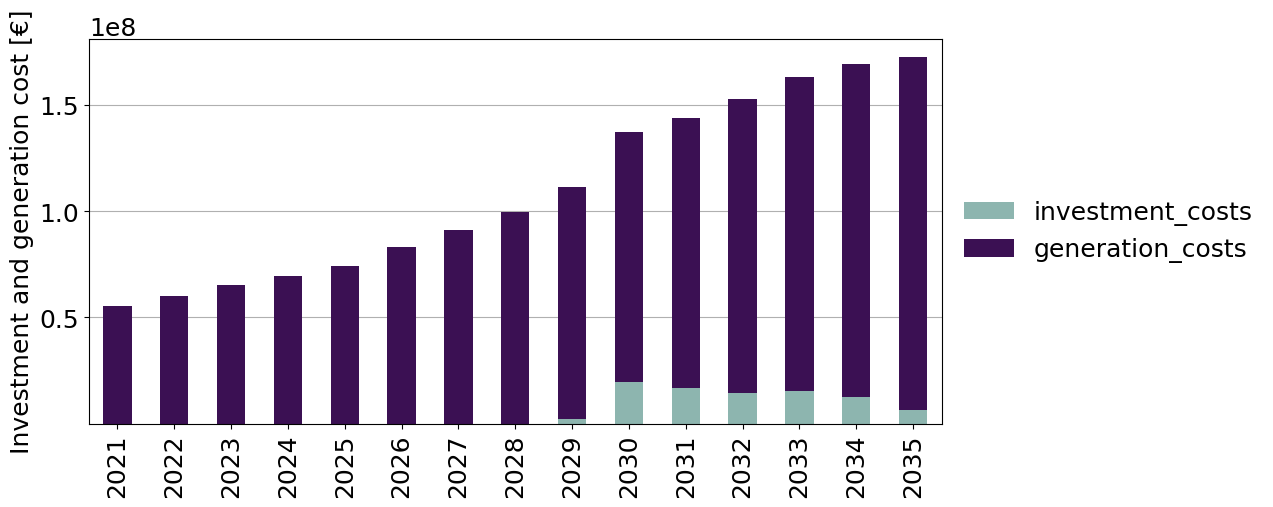

In [55]:
total_costs_B.plot.bar(x='year', y=['investment_costs', 'generation_costs'],stacked = True, figsize=(11, 5),color = [teal4,purple1], zorder = 2)
plt.ylabel('Investment and generation cost [€]')
plt.xlabel('')
plt.title('Baseline')
#plt.xticks(range(len(grouped.index)), grouped.index, rotation=90)
plt.grid(axis = 'y',zorder = 0)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),frameon = False)

#### NS

In [61]:
data={"year":[],"total_costs":[]}
for y in np.arange(2021,2036):
    data["year"].append(y)
    data["total_costs"].append(objective_value_list_NS[y-2021]/((1+i)**(y-2021)) + add_cost_NS.sum(axis = 1)[y]/((1+i)**(y-2021)) ) #objective_value_R[y]+

total_costs_NS=pd.DataFrame(data)
total_costs_NS

year   total_costs
0   2021  4.997546e+07
1   2022  8.659829e+07
2   2023  7.902532e+07
3   2024  1.716964e+08
4   2025  8.499955e+07
5   2026  1.009828e+08
6   2027  8.161339e+07
7   2028  9.448262e+07
8   2029  4.645319e+07
9   2030  8.003502e+07
10  2031  2.082370e+07
11  2032  2.513694e+07
12  2033  2.923179e+07
13  2034  3.753323e+07
14  2035  3.890541e+07

In [271]:
data={"year":[],"investment_gen":[], "investment_bat":[]}
for y in np.arange(2021,2036):
    data["year"].append(y)
    data["investment_gen"].append( add_cost_R.sum(axis = 1)[y])
    data["investment_bat"].append( add_cost_store_R.sum(axis = 1)[y]) 

invest_R=pd.DataFrame(data)
invest_R

year  investment_gen  investment_bat
0   2021    2.350933e+00    6.414030e+00
1   2022    6.311723e+02    5.335750e+02
2   2023    0.000000e+00    0.000000e+00
3   2024    2.727892e-01    1.649424e-01
4   2025    4.636449e+03    6.401859e+03
5   2026    0.000000e+00    0.000000e+00
6   2027    5.242071e+02    7.817245e+02
7   2028    0.000000e+00    0.000000e+00
8   2029    1.738874e+04    6.195042e+04
9   2030    0.000000e+00    2.187683e+07
10  2031    4.096495e+02    3.229819e+07
11  2032    3.592850e+02    2.730708e+07
12  2033    4.474475e+06    2.148776e+07
13  2034    1.841930e+07    1.454543e+07
14  2035    1.579104e+07    5.381703e+06

<AxesSubplot:>

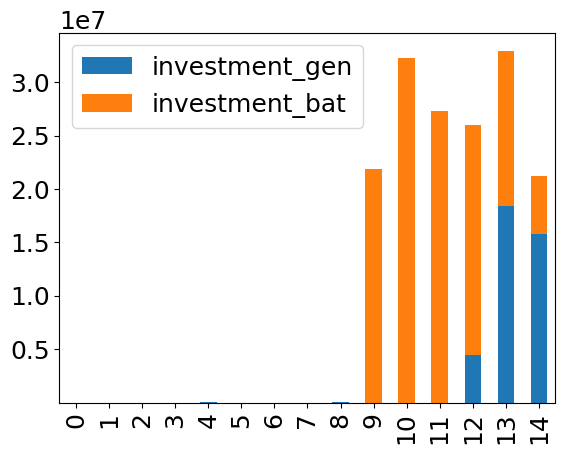

In [274]:
invest_R[['investment_gen','investment_bat']].plot.bar(stacked = True)

In [58]:
RES_costs = {
    'year': [2021, 2022, 2023, 2024, 2025, 2026, 2027, 2028, 2029, 2030, 2031, 2032, 2033, 2034, 2035],
    'total_cost': [5.517865e+07, 6.014072e+07, 6.506184e+07, 6.931999e+07, 7.414142e+07, 8.298488e+07, 9.116448e+07, 9.980764e+07, 1.095517e+08, 1.501459e+08, 1.734179e+08, 1.776688e+08, 1.835842e+08, 1.924446e+08, 1.816094e+08]
}

RES_costs = pd.DataFrame(RES_costs)

total_costs_R['generation_costs'] = RES_costs['total_cost']-total_costs_R['investment_costs']
total_costs_R

year  investment_costs  generation_costs
0   2021      1.018799e+01      5.517864e+07
1   2022      1.270320e+03      6.013945e+07
2   2023      0.000000e+00      6.506184e+07
3   2024      4.377316e-01      6.931999e+07
4   2025      1.224195e+04      7.412918e+07
5   2026      0.000000e+00      8.298488e+07
6   2027      1.450897e+03      9.116303e+07
7   2028      0.000000e+00      9.980764e+07
8   2029      9.753628e+04      1.094542e+08
9   2030      3.017568e+07      1.199702e+08
10  2031      4.487077e+07      1.285471e+08
11  2032      3.920863e+07      1.384602e+08
12  2033      3.606723e+07      1.475170e+08
13  2034      3.981871e+07      1.526259e+08
14  2035      2.377187e+07      1.578375e+08

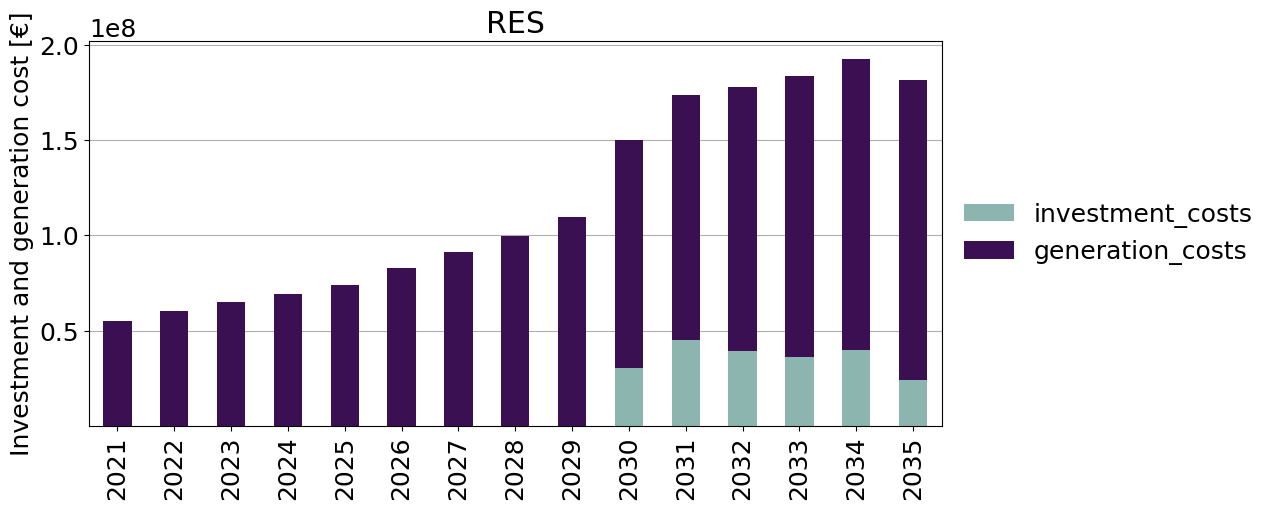

In [59]:
total_costs_R.plot.bar(x='year', y=['investment_costs', 'generation_costs'],stacked = True, figsize=(11, 5),color = [teal4,purple1], zorder = 2)
plt.ylabel('Investment and generation cost [€]')
plt.xlabel('')
plt.title('RES')
#plt.xticks(range(len(grouped.index)), grouped.index, rotation=90)
plt.grid(axis = 'y',zorder = 0)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),frameon = False)

#### RES_CAP

In [62]:
# Investment costs
data={"year":[],"total_costs":[]}
for y in np.arange(2021,2036):
    data["year"].append(y)
    data["total_costs"].append(objective_value_list_RC[y-2021]/((1+i)**(y-2021))+ add_cost_RC_1.sum(axis = 1)[y]/((1+i)**(y-2021)) + add_cost_store_RC_1.sum(axis = 1)[y]/((1+i)**(y-2021))) #objective_value_RC[y]+

total_costs_RC=pd.DataFrame(data)

### RC_H2

In [190]:
# Investment costs
data={"year":[],"total_costs":[]}
for y in np.arange(2021,2036):
    data["year"].append(y)
    data["total_costs"].append(objective_value_list_RC_H2[y-2021]/((1+i)**(y-2021))+ add_cost_RC_H2_1.sum(axis = 1)[y]/((1+i)**(y-2021)) 
                               + add_cost_store_RC_H2_1.sum(axis = 1)[y]/((1+i)**(y-2021))) #objective_value_RC[y]+

total_costs_RC_H2=pd.DataFrame(data)

In [191]:
total_costs_RC_H2['total_costs'].sum()/1000000000

3.498504626171942

### RC_ror

In [163]:
# Investment costs
data={"year":[],"total_costs":[]}
for y in np.arange(2021,2036):
    data["year"].append(y)
    data["total_costs"].append(objective_value_list_RC_ror[y-2021]/((1+i)**(y-2021))+ add_cost_RC_ror_1.sum(axis = 1)[y]/((1+i)**(y-2021)) 
                               + add_cost_store_RC_ror_1.sum(axis = 1)[y]/((1+i)**(y-2021))) #objective_value_RC[y]+

total_costs_RC_ror=pd.DataFrame(data)

In [164]:
total_costs_RC_ror['total_costs'].sum()/1000000000


3.2266913119540197

### RC10

In [63]:
data={"year":[],"total_costs":[]}
for y in np.arange(2021,2036):
    data["year"].append(y)
    data["total_costs"].append(objective_value_list_RC10[y-2021]/((1+i)**(y-2021))+ add_cost_RC10.sum(axis = 1)[y]/((1+i)**(y-2021)) + add_cost_store_RC10.sum(axis = 1)[y]/((1+i)**(y-2021))) #objective_value_RC[y]+

total_costs_RC10=pd.DataFrame(data)

### RC20

In [64]:
data={"year":[],"total_costs":[]}
for y in np.arange(2021,2036):
    data["year"].append(y)
    data["total_costs"].append(objective_value_list_RC20[y-2021]/((1+i)**(y-2021))+ add_cost_RC20.sum(axis = 1)[y]/((1+i)**(y-2021)) + add_cost_store_RC20.sum(axis = 1)[y]/((1+i)**(y-2021))) #objective_value_RC[y]+

total_costs_RC20=pd.DataFrame(data)

In [178]:
# total costs
data={"year":[],"total_costs":[]}
for y in np.arange(2021,2036):
    data["year"].append(y)
    data["total_costs"].append(objective_value_RC[y]+ add_cost_RC_2.sum(axis = 1)[y] + add_cost_store_RC_2.sum(axis = 1)[y]) #objective_value_RC[y]+

total_costs_RC=pd.DataFrame(data)
total_costs_RC['total_costs']


0     5.517814e+07
1     2.515517e+08
2     3.433697e+08
3     3.135431e+08
4     2.837784e+08
5     4.833683e+08
6     4.794646e+08
7     6.083777e+08
8     5.681663e+08
9     5.076885e+08
10    4.347347e+08
11    3.535433e+08
12    2.556604e+08
13    1.997097e+08
14    2.311990e+08
Name: total_costs, dtype: float64

In [179]:
# merge and add generation costs
total_costs_RC = pd.concat([total_costs_RC, investment_costs_RC['investment_costs']],axis=1)

total_costs_RC['generation_costs'] = total_costs_RC['total_costs']-investment_costs_RC['investment_costs']
total_costs_RC

year   total_costs  investment_costs  generation_costs
0   2021  5.517814e+07      2.228456e+01      5.517812e+07
1   2022  2.515517e+08      1.978489e+08      5.370277e+07
2   2023  3.433697e+08      2.950996e+08      4.827016e+07
3   2024  3.135431e+08      2.707409e+08      4.280224e+07
4   2025  2.837784e+08      2.333111e+08      5.046729e+07
5   2026  4.833683e+08      4.466061e+08      3.676220e+07
6   2027  4.794646e+08      4.483494e+08      3.111522e+07
7   2028  6.083777e+08      5.826315e+08      2.574614e+07
8   2029  5.681663e+08      5.478300e+08      2.033625e+07
9   2030  5.076885e+08      4.927464e+08      1.494209e+07
10  2031  4.347347e+08      4.251734e+08      9.561282e+06
11  2032  3.535433e+08      3.493585e+08      4.184743e+06
12  2033  2.556604e+08      2.569211e+08     -1.260718e+06
13  2034  1.997097e+08      2.068174e+08     -7.107721e+06
14  2035  2.311990e+08      1.733116e+08      5.788740e+07

In [166]:
data_add_cost = {}

# Iterate over the carriers
for carrier in carrier_list:
    # Create a list to store the values for the current carrier
    carrier_values = []
    # Iterate over the years
    for y in np.arange(2021, 2036):
        # Calculate the value and append it to the carrier_values list
        value = grouped_cap_change_RC[carrier].loc[y] * capital_cost[carrier]
        carrier_values.append(value)
    
    # Add the carrier_values list to the data dictionary with the carrier as the key
    data_add_cost[carrier] = carrier_values

# Create the DataFrame from the data dictionary
invest_RC = pd.DataFrame(data_add_cost, index=np.arange(2021, 2036))
invest_RC


data_add_cost = {}

# Iterate over the carriers
for store in store_list:
    # Create a list to store the values for the current carrier
    store_values = []
    # Iterate over the years
    for y in np.arange(2021, 2036):
        # Calculate the value and append it to the carrier_values list
        value = grouped_cap_stores_change_RCB[store].loc[y] * capital_cost_stores[store]
        store_values.append(value)
    
    # Add the carrier_values list to the data dictionary with the carrier as the key
    data_add_cost[store] = store_values

# Create the DataFrame from the data dictionary
invest_store_RC = pd.DataFrame(data_add_cost, index=np.arange(2021, 2036))
invest_store_RC


battery  battery charger  battery discharger
2021  5.246535e-01     7.630236e-01                 0.0
2022  0.000000e+00     0.000000e+00                 0.0
2023  3.091249e-01     3.760401e-01                 0.0
2024  0.000000e+00     0.000000e+00                 0.0
2025  8.958109e-02     5.816823e-03                 0.0
2026  8.334895e-01     8.086432e-01                 0.0
2027  9.244419e+06     4.818476e+06                 0.0
2028  2.857897e+07     1.182556e+07                 0.0
2029  3.194972e+07     1.309264e+07                 0.0
2030  1.706141e+07     1.454575e+06                 0.0
2031  1.019943e+07     0.000000e+00                 0.0
2032  1.093940e+07     0.000000e+00                 0.0
2033  5.502430e+07     0.000000e+00                 0.0
2034  4.819021e+07     0.000000e+00                 0.0
2035  6.934665e+06     1.409652e+01                 0.0

In [169]:

yearly_investment = pd.concat([invest_RC,invest_store_RC],axis = 1)
yearly_investment.sum(axis=1)

2021    1.801789e+00
2022    1.413205e+07
2023    2.269999e+07
2024    2.256122e+07
2025    2.120974e+07
2026    4.891779e+07
2027    4.981790e+07
2028    7.252254e+07
2029    7.867147e+07
2030    5.318479e+07
2031    4.614073e+07
2032    4.817922e+07
2033    9.372488e+07
2034    9.999181e+07
2035    9.999179e+07
dtype: float64

In [170]:
generation = objective_value_RC - yearly_investment.sum(axis=1)
generation

2021    5.517812e+07
2022    5.370279e+07
2023    4.827014e+07
2024    4.280276e+07
2025    5.046765e+07
2026    3.250502e+07
2027    3.111392e+07
2028    2.605254e+07
2029    1.992622e+07
2030    4.388169e+07
2031    4.845523e+07
2032    4.334515e+07
2033   -9.345219e+06
2034   -3.690833e+06
2035    1.312072e+08
dtype: float64

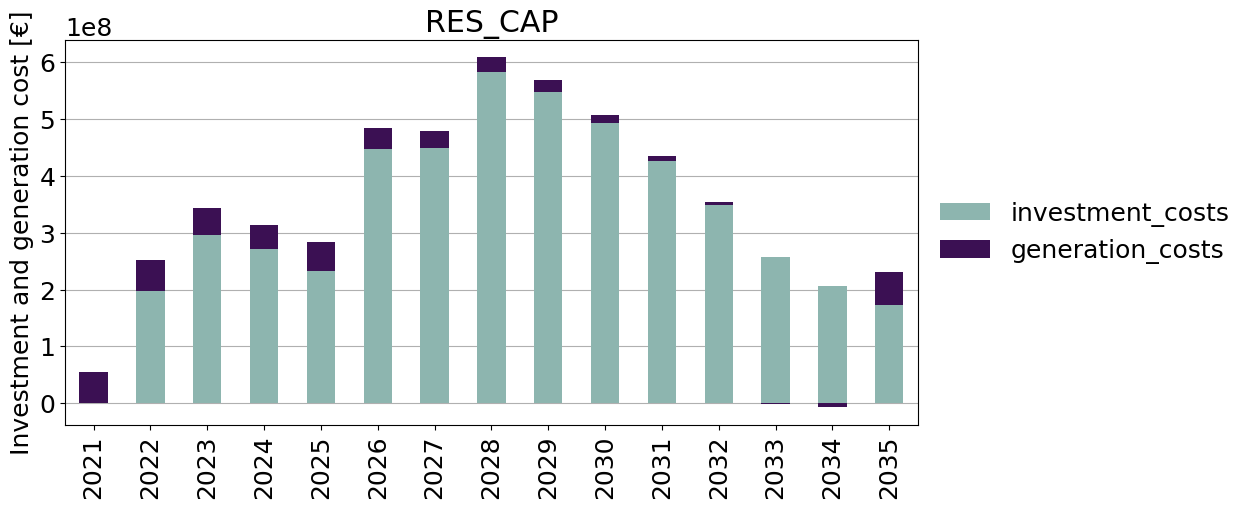

In [180]:
total_costs_RC.plot.bar(x='year', y=['investment_costs', 'generation_costs'],stacked = True, figsize=(11, 5),color = [teal4,purple1], zorder = 2)
#total_costs_RC.plot(x='year', y=['total_costs'], figsize=(11, 5),color = red1, zorder = 2)
plt.ylabel('Investment and generation cost [€]')
plt.xlabel('')
plt.title('RES_CAP')
#plt.xticks(range(len(grouped.index)), grouped.index, rotation=90)
plt.grid(axis = 'y',zorder = 0)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),frameon = False)

In [275]:
data={"year":[],"investment_gen":[], "investment_bat":[]}
for y in np.arange(2021,2036):
    data["year"].append(y)
    data["investment_gen"].append( add_cost_RC_1.sum(axis = 1)[y])
    data["investment_bat"].append( add_cost_store_RC_1.sum(axis = 1)[y]) 

invest_RC=pd.DataFrame(data)
invest_RC

year  investment_gen  investment_bat
0   2021    7.711678e+00    1.199734e+01
1   2022    1.978487e+08    1.606026e+02
2   2023    2.950997e+08   -1.395045e+02
3   2024    2.707347e+08    4.854844e+03
4   2025    2.333072e+08    2.776197e+03
5   2026    4.466129e+08   -5.122413e+03
6   2027    3.217929e+08    8.704989e+07
7   2028    2.569436e+08    2.164380e+08
8   2029    2.353982e+08    2.071470e+08
9   2030    2.079825e+08    1.865941e+08
10  2031    1.796730e+08    1.603394e+08
11  2032    1.489255e+08    1.308280e+08
12  2033    1.160716e+08    9.231756e+07
13  2034    1.035801e+08    6.777610e+07
14  2035    9.304785e+07    5.149361e+07

<AxesSubplot:>

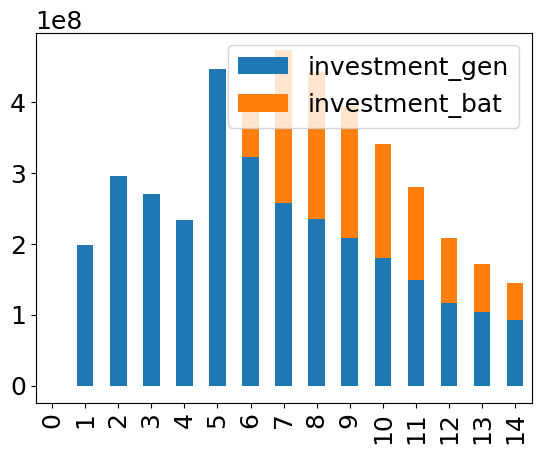

In [276]:
invest_RC[['investment_gen','investment_bat']].plot.bar(stacked = True)

#### RES_CAP_BAT

In [65]:
data={"year":[],"total_costs":[]}
for y in np.arange(2021,2036):
    data["year"].append(y)
    data["total_costs"].append(objective_value_list_RCB[y-2021]/((1+i)**(y-2021))+ add_cost_RCB.sum(axis = 1)[y]/((1+i)**(y-2021)) + add_cost_store_RCB.sum(axis = 1)[y]/((1+i)**(y-2021))) #objective_value_RCB[y]+

total_costs_RCB=pd.DataFrame(data)
total_costs_RCB

year   total_costs
0   2021  4.982225e+07
1   2022  5.235438e+07
2   2023  2.499506e+08
3   2024  2.335589e+08
4   2025  2.448648e+08
5   2026  3.558402e+08
6   2027  3.054617e+08
7   2028  3.596875e+08
8   2029  5.557523e+08
9   2030  6.524171e+08
10  2031  7.469929e+08
11  2032  8.659013e+08
12  2033  8.911453e+08
13  2034  4.493887e+08
14  2035  6.865325e+08

### RCB10

In [66]:
data={"year":[],"total_costs":[]}
for y in np.arange(2021,2036):
    data["year"].append(y)
    data["total_costs"].append(objective_value_list_RCB10[y-2021]/((1+i)**(y-2021))+ add_cost_RCB10.sum(axis = 1)[y]/((1+i)**(y-2021)) + add_cost_store_RCB10.sum(axis = 1)[y]/((1+i)**(y-2021))) #objective_value_RCB[y]+

total_costs_RCB10=pd.DataFrame(data)
total_costs_RCB10

year   total_costs
0   2021  4.982397e+07
1   2022  5.235020e+07
2   2023  2.259577e+08
3   2024  2.237171e+08
4   2025  2.129796e+08
5   2026  3.372494e+08
6   2027  2.902312e+08
7   2028  2.548314e+08
8   2029  4.647529e+08
9   2030  5.124340e+08
10  2031  5.849667e+08
11  2032  6.120585e+08
12  2033  6.040003e+08
13  2034  5.468066e+08
14  2035  3.511429e+08

### RCB20

In [67]:
data={"year":[],"total_costs":[]}
for y in np.arange(2021,2036):
    data["year"].append(y)
    data["total_costs"].append(objective_value_list_RCB20[y-2021]/((1+i)**(y-2021))+ add_cost_RCB20.sum(axis = 1)[y]/((1+i)**(y-2021)) + add_cost_store_RCB20.sum(axis = 1)[y]/((1+i)**(y-2021))) #objective_value_RCB[y]+

total_costs_RCB20=pd.DataFrame(data)
total_costs_RCB20

year   total_costs
0   2021  4.982230e+07
1   2022  5.235065e+07
2   2023  2.019641e+08
3   2024  2.138975e+08
4   2025  1.948414e+08
5   2026  3.088693e+08
6   2027  2.773749e+08
7   2028  2.445347e+08
8   2029  3.282016e+08
9   2030  4.265778e+08
10  2031  4.490303e+08
11  2032  4.788436e+08
12  2033  4.209615e+08
13  2034  3.712602e+08
14  2035  2.441999e+08

In [65]:
RES_CAP_BAT_costs = {
    'year': [2021, 2022, 2023, 2024, 2025, 2026, 2027, 2028, 2029, 2030, 2031, 2032, 2033, 2034, 2035],
    'total_cost': [5.517429e+07, 2.515539e+08, 3.433730e+08, 3.135403e+08, 2.837806e+08, 5.216779e+08, 4.794875e+08, 6.104968e+08, 5.705250e+08, 5.964773e+08, 6.553790e+08, 7.857868e+08, 8.220561e+08, 8.467877e+08, 5.567624e+08]
}

RES_CAP_BAT_costs = pd.DataFrame(RES_CAP_BAT_costs)

total_costs_RCB['generation_costs'] = RES_CAP_BAT_costs['total_cost']-total_costs_RCB['investment_costs']
total_costs_RCB

year  investment_costs  generation_costs
0   2021      3.910813e+01      5.517425e+07
1   2022      1.978484e+08      5.370549e+07
2   2023      2.951000e+08      4.827302e+07
3   2024      2.707318e+08      4.280846e+07
4   2025      2.333058e+08      5.047479e+07
5   2026      4.891752e+08      3.250268e+07
6   2027      4.483690e+08      3.111849e+07
7   2028      5.847644e+08      2.573235e+07
8   2029      5.500220e+08      2.050302e+07
9   2030      5.815232e+08      1.495415e+07
10  2031      6.447730e+08      1.060602e+07
11  2032      7.793090e+08      6.477817e+06
12  2033      8.205240e+08      1.532106e+06
13  2034      8.265214e+08      2.026627e+07
14  2035      8.639555e+07      4.703668e+08

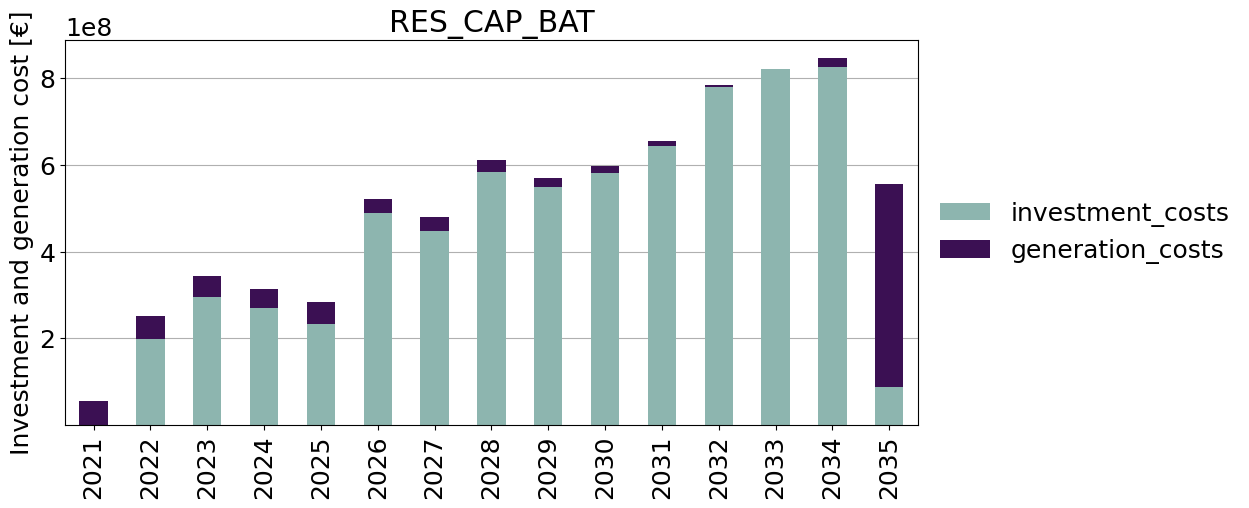

In [66]:
total_costs_RCB.plot.bar(x='year', y=['investment_costs', 'generation_costs'],stacked = True, figsize=(11, 5),color = [teal4,purple1], zorder = 2)
plt.ylabel('Investment and generation cost [€]')
plt.xlabel('')
plt.title('RES_CAP_BAT')
#plt.xticks(range(len(grouped.index)), grouped.index, rotation=90)
plt.grid(axis = 'y',zorder = 0)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),frameon = False)

In [277]:
data={"year":[],"investment_gen":[], "investment_bat":[]}
for y in np.arange(2021,2036):
    data["year"].append(y)
    data["investment_gen"].append( add_cost_RCB.sum(axis = 1)[y])
    data["investment_bat"].append( add_cost_store_RCB.sum(axis = 1)[y]) 

invest_RCB=pd.DataFrame(data)
invest_RCB

year  investment_gen  investment_bat
0   2021    1.979297e+01    1.557759e+01
1   2022    1.978484e+08    0.000000e+00
2   2023    2.951000e+08    6.998601e+00
3   2024    2.707318e+08    0.000000e+00
4   2025    2.333058e+08    5.813900e-01
5   2026    4.891752e+08    1.246288e+01
6   2027    3.218030e+08    8.705243e+07
7   2028    2.615282e+08    2.146534e+08
8   2029    2.347255e+08    2.090805e+08
9   2030    4.704272e+08    6.247859e+07
10  2031    5.937758e+08    2.677735e+07
11  2032    7.355514e+08    2.297603e+07
12  2033    6.554511e+08    8.667569e+07
13  2034    7.301410e+08    5.060697e+07
14  2035    7.946087e+07    3.641235e+06

<AxesSubplot:>

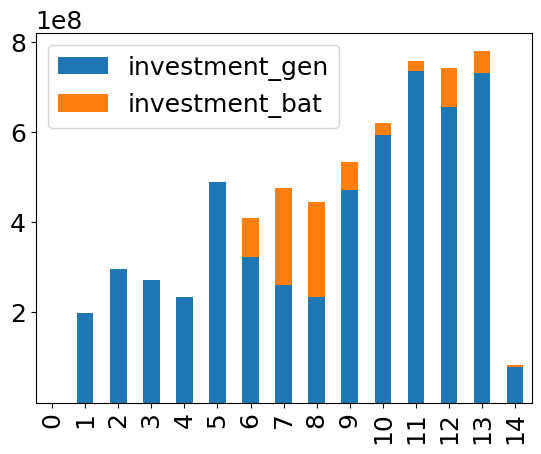

In [278]:
invest_RCB[['investment_gen','investment_bat']].plot.bar(stacked = True)

## Plot

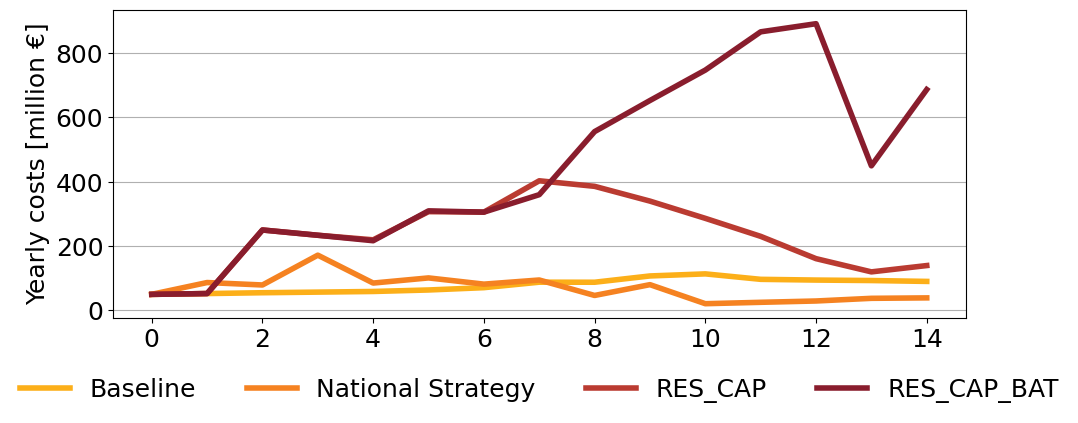

In [124]:
(total_costs_B['total_costs']/1000000).plot(figsize=(11, 4),color = yellow, linewidth = 4, zorder = 2, label = 'Baseline')
(total_costs_NS['total_costs']/1000000).plot(figsize=(11, 4),color = orange, linewidth = 4, zorder = 2, label = 'National Strategy')
(total_costs_RC['total_costs']/1000000).plot(figsize=(11, 4),color = red2, linewidth = 4, zorder = 2, label = 'RES_CAP')
(total_costs_RCB['total_costs']/1000000).plot(figsize=(11, 4),color = red1, linewidth= 4, zorder = 2, label = 'RES_CAP_BAT')

plt.ylabel('Yearly costs [million €]',fontsize = 18)
plt.grid(axis='y')
#plt.xlim(2021,2035)
plt.legend(frameon = False, loc='lower center', bbox_to_anchor=(0.5, -0.35), ncol=4)

plt.savefig(scen_path +f'Scen_system_cost_development.pdf', dpi=300, bbox_inches='tight')

[1.1764382878911803, 1.0274931903748792, 3.481871558789558, 6.62491992606893]


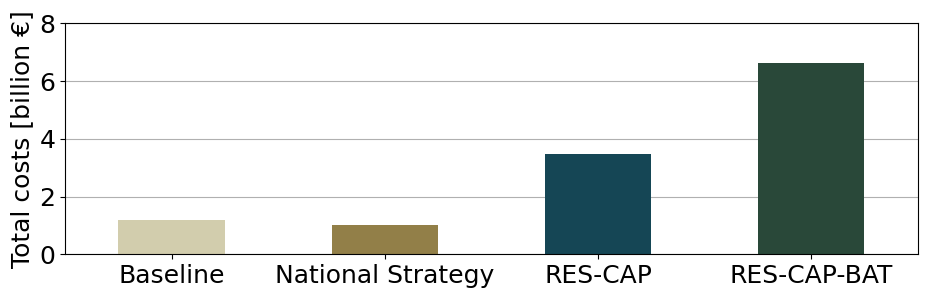

In [125]:
data = [total_costs_B['total_costs'].sum()/1000000000, total_costs_NS['total_costs'].sum()/1000000000,
        total_costs_RC['total_costs'].sum()/1000000000,total_costs_RCB['total_costs'].sum()/1000000000] # ROR: 830.94
index = ['Baseline','National Strategy','RES-CAP','RES-CAP-BAT']

total = pd.Series(data,index, name='Total System Costs')

print(data)
total.plot.bar(color=scen_colors, figsize = (11,3), zorder = 2)
plt.ylabel('Total costs [billion €]')
plt.xticks(rotation = 0)
plt.grid(axis = 'y',zorder = 0)
plt.ylim(0,8)

plt.savefig(scen_path +f'Scen_total_system_costs.pdf', dpi=300, bbox_inches='tight')

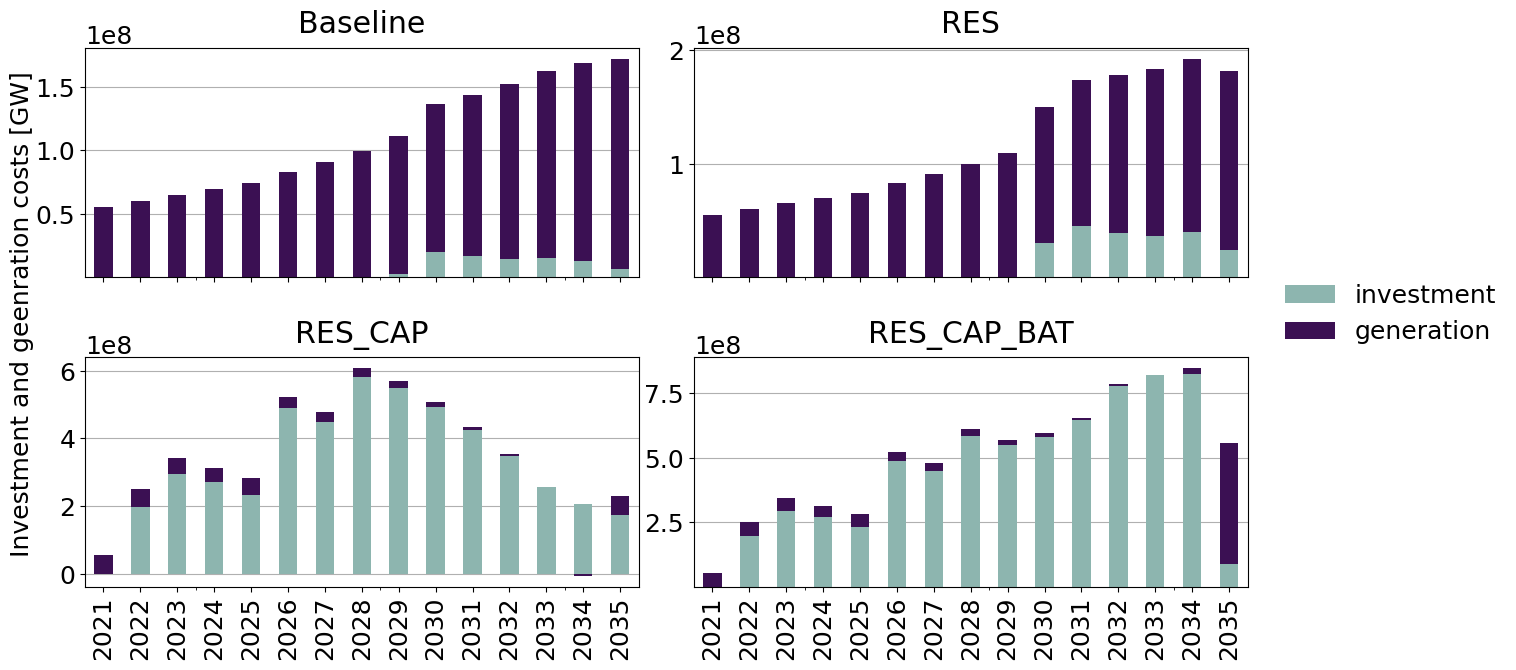

In [68]:
ticklabels= np.arange(2021,2036)

fig, axes = plt.subplots(2, 2, figsize=(20, 5), sharex=True, sharey=False)
# Create a stacked bar plot
bar1 = total_costs_B.plot.bar(x='year', y=['investment_costs', 'generation_costs'],ax=axes[0,0] ,stacked=True, color = [teal4,purple1], figsize=(15, 7),zorder=2) #
axes[0,0].grid(axis = 'y',zorder = 0)
axes[0, 0].legend().remove()
axes[0, 0].set_title('Baseline',y=1.03)
#axes[0, 0].set_xticklabels(ticklabels,rotation=0)
#axes[0, 0].set_yticks(np.arange(0, 6, 2))

total_costs_R.plot.bar(x='year', y=['investment_costs', 'generation_costs'],ax=axes[0,1] ,stacked=True, color = [teal4,purple1], figsize=(15, 7),zorder=2) #
axes[0,1].grid(axis = 'y',zorder = 0)
axes[0, 1].legend().remove()
axes[0, 1].set_title('RES',y=1.03)
#axes[0, 1].set_yticks(np.arange(0, 6, 2))

total_costs_RC.plot.bar(x='year', y=['investment_costs', 'generation_costs'],ax=axes[1,0] ,stacked=True, color = [teal4,purple1], figsize=(15, 7),zorder=2) #
axes[1,0].grid(axis = 'y',zorder = 0)
axes[1, 0].legend().remove()
axes[1, 0].set_title('RES_CAP',y=1.03)
#axes[1, 0].set_yticks(np.arange(0, 21, 5))
#axes[1, 0].set_xticklabels(ticklabels,rotation=0)
axes[1, 0].set_xlabel('')

total_costs_RCB.plot.bar(x='year', y=['investment_costs', 'generation_costs'],ax=axes[1,1] ,stacked=True, color = [teal4,purple1], figsize=(15, 7),zorder=2) #
axes[1,1].grid(axis = 'y',zorder = 0)
axes[1, 1].legend().remove()
axes[1, 1].set_title('RES_CAP_BAT',y=1.03)
#axes[1, 1].set_yticks(np.arange(0, 21, 5))
#axes[1, 1].set_xticklabels(ticklabels,rotation=0)
axes[1, 1].set_xlabel('')

# Get the legend from any one of the subplots
handles, labels = bar1.get_legend_handles_labels()

# Create a common legend
fig.legend(handles, ['investment','generation'], loc='center left', bbox_to_anchor=(0.91, 0.5), frameon=False) #, frameon=False
fig.text(0.075, 0.5,'Investment and geenration costs [€]', va='center', rotation='vertical', fontsize=18)
plt.subplots_adjust(hspace=0.35, wspace=0.1)


plt.savefig(scen_path  +f'Scen_invest_gen_sosts_2021-2035.pdf', dpi=300, bbox_inches='tight')

In [95]:
total_costs_B[['investment_costs','generation_costs']].sum().sum()

1647275980.0

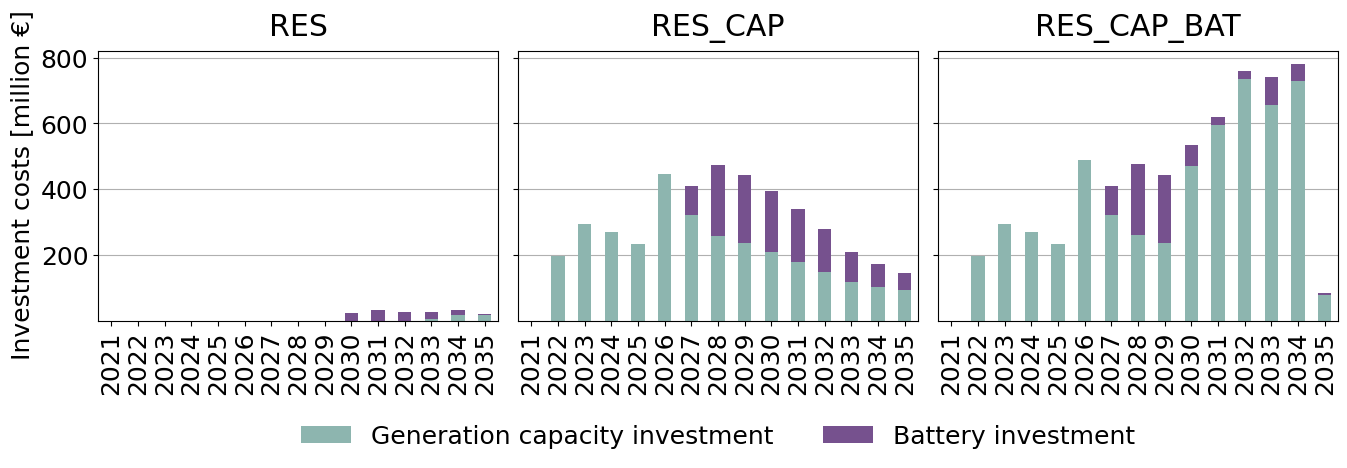

In [311]:
fig, axes = plt.subplots(1,3,figsize = (16,3.5),sharey=True)

(invest_R[['investment_gen','investment_bat']]/1000000).plot.bar(stacked = True,ax = axes[0],color=[teal4,purple2],zorder = 2)
#axes[0].set_ylim(0,9)
axes[0].set_title('RES',y=1.03)
axes[0].set_xlabel('')
#axes[0].set_xlim(2021,2035)
axes[0].set_xticks(ticks = range(0,15), labels = indices, rotation=90)
axes[0].grid(axis = 'y',zorder = 0)


(invest_RC[['investment_gen','investment_bat']]/1000000).plot.bar(stacked = True,ax = axes[1],color=[teal4,purple2],zorder = 2)
#axes[1].set_ylim(0,9)
axes[1].set_title('RES_CAP',y=1.03)
axes[1].set_xlabel('')
#axes[1].set_xlim(2021,2035)
axes[1].set_xticks(ticks = range(0,15), labels = indices, rotation=90)
axes[1].grid(axis = 'y',zorder = 0)

(invest_RCB[['investment_gen','investment_bat']]/1000000).plot.bar(stacked = True,ax = axes[2],color=[teal4,purple2],
                                                         zorder = 2)
#axes[2].set_ylim(0,9)
axes[2].set_title('RES_CAP_BAT',y=1.03)
axes[2].set_xlabel('')
#axes[2].set_xlim(2021,2035)
axes[2].set_xticks(ticks = range(0,15), labels = indices, rotation=90)
axes[2].grid(axis = 'y',zorder = 0)


fig.text(0.07, 0.5,'Investment costs [million €]', va='center', rotation='vertical', fontsize=18)
plt.subplots_adjust(hspace=0.37, wspace=0.05)
axes[1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.3), ncol=2, frameon=False,labels = ['Generation capacity investment','Battery investment'])
legend0 = axes[0].legend()
legend0.remove()
legend2 = axes[2].legend()
legend2.remove()
plt.savefig(scen_path + 'Battery/' +f'Scen_investment_2021-2035.pdf', dpi=300, bbox_inches='tight')


In [367]:
invest_RCB[['investment_gen','investment_bat']].sum()/invest_RCB[['investment_gen','investment_bat']].sum().sum()

investment_gen    0.879371
investment_bat    0.120629
dtype: float64

In [365]:
invest_R[['investment_gen','investment_bat']].sum().sum()

161675432.77589452